In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
%matplotlib inline

In [7]:
### Faster SVM run
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [9]:
# Data Analysis Packages
import os
import random
import pandas as pd
import numpy as np
import pathlib
import pickle
import itertools
import collections
from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Plot Packages
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib.ticker import FixedFormatter
from matplotlib import gridspec 
from pylab import *
#import pylab as pl
from matplotlib.colors import LogNorm
from statannotations.Annotator import Annotator

# ML Packages
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy.optimize import curve_fit # Fit data

In [10]:
# Font size adjustment
sns.set(font_scale = 1.5)
# Set background
sns.set_style("white")

In [11]:
### Function to process F2a and/or b?
def processExcelFormat01(name, percent=0.5):
    DF = pd.read_csv(name, header = None)
    columnNames = ['Nutrient', 'Conjugation Inhibitor', 'N10', 'N11', 'N20', 'N21', 'noP', 'P', 'N1']
#     columnNames = ['Nutrient', 'Conjugation Inhibitor', 'N0', 'N1']
    DF.columns = columnNames
    # This part needs to be more flexible
    # What if people want N0?
    DF01 = DF[['Nutrient', 'Conjugation Inhibitor', 'N1']]
#     DF01['Conjugation Inhibitor'] = np.log10(DF01['Conjugation Inhibitor'])
    # Rename last col as Density
    DF01.columns = [*DF01.columns[:-1], 'Density']
#     DF01['BinaryClass'] = DF01.Density.apply(lambda x: 1 if x >= np.mean(DF01.iloc[:, -1]) else -1)

    #DF01.Density.apply(lambda x: 1 if x >= np.mean(DF01.iloc[:, -1]) else -1)
    
    # Reduce to 10*10
    A = list(set(list(DF01['Nutrient'])))
    A.sort()
    B = list(set(list(DF01['Conjugation Inhibitor'])))
    B.sort()
    
#     print(len(DF01))
    # Reduce the original 100 * 100 variables
    # 50/5 == 10; 50/5 == 10
    DF01 = DF01[DF01['Nutrient'].isin(A[::5])]
    DF01 = DF01[DF01['Conjugation Inhibitor'].isin(B[::5])]
    
    DF01['BinaryClass'] = \
    DF01.Density.apply(lambda x: 1 if \
                        x >= DF01.Density.quantile(percent)  # 20th percentile\
                        else -1)
    
    return DF01

In [12]:
### Function to import Katie's
def processExcelFormat02(name, sheet):
    DF = pd.read_excel(name, sheet_name=sheet)

    DF['BinaryClass'] = \
    DF.Density.apply(lambda x: 1 if x >= np.median(DF.iloc[:, -1]) else -1)
    
#     DF['BinaryClass'] = \
#     DF.Density.apply(lambda x: 1 if \
#                         x >= DF.Density.quantile(percent)  # 20th percentile\
#                         else -1)
    
    return DF

In [13]:
### Function to import Fig 1 synthetic data
### Need to add assignment of boundaried here as well? -- percentage for pos
def processExcelFormat05(name, sheet, percentage = 0):
    DF = pd.read_excel(name, sheet)
#     print(DF)
    column_name = ['Environmental factor 1', 'Environmental factor 2', 'Density', 'BinaryClass']
    DF.columns = column_name
    
    # Retain the original name
    # Get input features
    inputName = list(DF.columns)[:-2]
    column_name = inputName + ['Density', 'BinaryClass']

    # Reduce to 10*10
    A = list(set(list(DF['Environmental factor 1'])))
    A.sort()
    B = list(set(list(DF['Environmental factor 2'])))
    B.sort()
    
    # Reduce the original 100 * 100 variables
    # 900/3/3
#     DF = DF[DF['Environmental factor 1'].isin(A[::3])]
#     DF = DF[DF['Environmental factor 2'].isin(B[::3])]
    
    # Assign binary class, if know the percentage
    if percentage != 0:
        RSorted = sort(DF['Density'])
        BoundaryVal = RSorted[int(percentage*len(RSorted)/10)]
        DF['BinaryClass']=np.where(DF['Density']>BoundaryVal, 1, -1)
        #### To make this consistent with Fig1File
        #DF['BinaryClass']=np.where(DF['Density']>percentage, 1, -1)
        
    return DF

In [14]:
### Function to import Helena's experimental data of 3 columns
### No preassigned column/drug names here
### Assign binary boundaried manually here
def processExcelFormat03(name, sheet, quant=0.25):
    DF = pd.read_excel(name, sheet, header = None)
    #print(DF)\n
    column_name = ['Environmental factor 1', 'Environmental factor 2', 'Density']
    DF.columns = column_name
    
    ### How about infinity after log transform
    ### Assign a very small positive value to 0 for log operation
    DF.loc[DF['Environmental factor 1'] == 0, 'Environmental factor 1'] = 0.2
    DF.loc[DF['Environmental factor 2'] == 0, 'Environmental factor 2'] = 0.2
    
    # Log transform data
    DF['Environmental factor 1'] = np.log10(DF['Environmental factor 1'])
    DF['Environmental factor 2'] = np.log10(DF['Environmental factor 2'])

    ### Assign binary class
    ### This could be tuned by the percentage parameter
#     RSorted = sort(DF['Density'])
#     ### To assign number of points for each class, not based on mean values
#     BoundaryVal = RSorted[int(percentage*len(RSorted)/10)]
#     DF['BinaryClass']=np.where(DF['Density']>BoundaryVal, 1, -1)
    
    DF['BinaryClass'] = \
    DF.Density.apply(lambda x: 1 if \
                        x >= DF.Density.quantile(quant)  # 20th percentile\
                        else -1)

#     ### To reduce the row numbers, if necessary
#     A = list(set(list(DF['Environmental factor 1'])))
#     A.sort()
#     B = list(set(list(DF['Environmental factor 2'])))
#     B.sort()
#     DF = DF[DF['Environmental factor 1'].isin(A[::4])]
#     DF = DF[DF['Environmental factor 2'].isin(B[::4])]
    
    return DF

In [15]:
### Visualize inputs before or after normalization
### The only mandatory input is the dataframe
def heatmapGenerator(dataframe, values = 0, centered=1, labels=1, colorP="coolwarm"): # 'vlag', 'Spectral'
    ### dataframe: DF that stores all the data
    ### rows: rows of Heatmap; columns: columns of Heatmap; values: values to visualize
    ### digit: # length of labels
    #ax.set_xlim(0, 60)
    
    # Retrieve rows, columns and values columns for heatmap dataframe
    rows = dataframe.columns[1]
    columns = dataframe.columns[0]
    
    # Default is density plot
    if values == 0:
        values = dataframe.columns[2]
        
    # Get the boundary from the sheet
    ### Sort values from both class, get the ones closest to the boundary
    pos_values = dataframe[dataframe['BinaryClass'] > 0][values]
    pos_values_threshold = pos_values.sort_values(ascending=True)

    neg_values = dataframe[dataframe['BinaryClass'] < 0][values]
    neg_values_threshold = neg_values.sort_values(ascending=False)
    # Take avg as the boundary value
    boundary = (pos_values_threshold.iloc[0] + neg_values_threshold.iloc[0])/2

    heatmap_DF = dataframe.pivot(index=rows, columns=columns, values=values)

    fig = plt.figure(figsize=(6,4))
    
    colorPalette = sns.color_palette(colorP, as_cmap=True)
    # sns.diverging_palette(145, 300, s=60, as_cmap=True)
    # sns.color_palette("Spectral", as_cmap=True)
    
    # Colormap centered around the boundary value
    if centered == 1:
        print('here', boundary)
        # Dont add x & y labels or ticks
        ### For Fig 1
        if labels == 0:
            
            g = sns.heatmap(heatmap_DF, cmap=colorPalette, center = boundary,\
                            yticklabels=False, xticklabels=False) #cmap=colorPalette, 
            g.set_ylabel('')
            g.set_xlabel('')
            g.set_title('')

        else: # Add x & y labels & values??
            g = sns.heatmap(heatmap_DF, cmap=colorPalette, center = boundary) #cmap=colorPalette, 
            plt.title(values, fontsize = 15)

    # Colormap not centered
    else:
        print('here, not centered', boundary)
        if labels == 0:
            g = sns.heatmap(heatmap_DF, cmap=colorPalette, \
                            yticklabels=False, xticklabels=False) #cmap=colorPalette,
            g.set_ylabel('')
            g.set_xlabel('')
            g.set_title('')
        else:
            g = sns.heatmap(heatmap_DF, cmap=colorPalette) #, cmap=colorPalette
            plt.title(values, fontsize = 15)
    g.invert_yaxis() # Small value at bottom, same in Matlab
    sns.diverging_palette(220, 20, as_cmap=True)     
    # Aesthestic for x,y ticklabels
    xticklabels = ['{:,.2f}'.format(float(x.get_text())) for x in g.get_xticklabels()]
    yticklabels = ['{:,.2f}'.format(float(y.get_text())) for y in g.get_yticklabels()]
    
    g.set_xticklabels(xticklabels, rotation=30, horizontalalignment='right')
    g.set_yticklabels(yticklabels, rotation=30, horizontalalignment='right')

In [16]:
### Normalize and Split for SVM data
### This fraction here is the number of datapoints
#### Not percentage
def trainingTestSplit(full_df_Ori, n):
    #### Think about alternative scalers
    sc_X = StandardScaler()
    sc_density = StandardScaler()
    
    # Split data into training and testing sets
    TrainDF = full_df_Ori.sample(n = n) #frac = fraction
    TestDF = full_df_Ori[~full_df_Ori.isin(TrainDF)].dropna()

    # Normalize input features
    inputName = list(full_df_Ori.columns)[:-2]
    featureScaler = sc_X.fit(TrainDF[inputName].values)
    scaled_features = featureScaler.transform(TrainDF[inputName].values)
    # Normalize density
    densityScaler = sc_density.fit(TrainDF[['Density']].values)
    scaled_density = densityScaler.transform(TrainDF[['Density']].values)
    
    # Assign normalized training data back
    TrainDF[inputName] = scaled_features
    TrainDF['Density'] = scaled_density
    # Normalize testing set X and density using training scalers
    TestDF[inputName] = featureScaler.transform(TestDF[inputName].values)
    TestDF['Density'] = densityScaler.transform(TestDF[['Density']].values)
    # X & Y for normalized training set
    TrainDF_X = TrainDF[inputName]
    TrainDF_Y = TrainDF['BinaryClass']
    # X & Y for normalized testing set
    TestDF_X = TestDF[inputName]
    TestDF_Y = TestDF['BinaryClass']
    # X & Y for all transformed data, operate on a copy
    # keep the original data intact
    fullDF_copy = full_df_Ori.copy()
    # Transform first
    fullDF_copy[inputName] = featureScaler.transform(fullDF_copy[inputName].values)
    fullDF_copy['Density'] = densityScaler.transform(fullDF_copy[['Density']].values)
    # Then get x & y
    fullDF_X = fullDF_copy[inputName]
    fullDF_Y = fullDF_copy['BinaryClass']
    # Check if we have 2 classes for training
    # In training data too few, we may not have any
    numberOfClasses = len(set(list(TrainDF['BinaryClass'])))
    
    # If only 1 class, recursion until there are 2 classes
    if numberOfClasses == 1: # If not; rerun
        full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y,\
        TrainDF_X, TrainDF_Y, TestDF_X, TestDF_Y,\
        sc_X, sc_density = trainingTestSplit(full_df_Ori, n)
        
    ### Use test data in the last step
    # full_df_Ori: nonnormalized one; all others ar normalized
    return full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y,\
TrainDF_X, TrainDF_Y, TestDF_X, TestDF_Y, sc_X, sc_density

In [17]:
def svc_rand_param_selection(TrainDF_X, TrainDF_Y, kernelList):
    ### Select best SVM parameters of any number of kernel(s)
    ### TrainDF_X: X training dataset
    ### TrainDF_Y: Y training dataset
    ### TestDF_X: X testing dataset
    ### TestDF_Y: Y testing dataset
    ### kernelList: the list of kernels to try
    
    #     print(TrainDF_X, TrainDF_Y)
    # 3 universal parameterx
    Cs = list(10. ** np.arange(-2, 5))
    gammas = list(10. ** np.arange(-4, 2))
    coef0s = list(10. ** np.arange(-4, 4))

#     "gamma": gamma_range.tolist()+['scale', 'auto']
    # Create grid parameters to tune: include universal parameters & other parameters
    param_grid = {'C': Cs, 'gamma': gammas+['scale', 'auto'], \
                  'degree':[2,3,4,5], 'kernel': kernelList}
                    ### [1,2,3,4,5,6,7,8,9] for highD
                    ### [1,2,3,4,5,6] knn
    
    # Grid search
    if len(TrainDF_X) >= 10:
        grid = RandomizedSearchCV(SVC(), param_grid, refit = True, n_jobs = -2) # , n_jobs = -1
    elif len(TrainDF_X) < 6:
        grid = RandomizedSearchCV(SVC(), param_grid, refit = True, cv = 1, n_jobs = -2)
    else: # If training instances too few, reduce cross validation fold
        grid = RandomizedSearchCV(SVC(), param_grid, refit = True, cv = 2, n_jobs = -2)

#     print(rand)
    grid.fit(TrainDF_X.values, TrainDF_Y)
    # print the best estimator & best parameters & best_score_ & performance check\n",
#     print(grid.best_estimator_, grid.best_params_, grid.best_score_)

    # Return all parameters in best estimator
    return grid.best_estimator_, grid.best_estimator_.C, grid.best_estimator_.gamma, \
grid.best_estimator_.degree, grid.best_estimator_.kernel, grid.best_estimator_.coef0

In [18]:
#     leaf_size = list(range(1, 10))
#     n_neighbors = list(range(1, 5))
#     weights = ['uniform', 'distance']
#     metric = ['euclidean', 'manhattan', 'minkowski']
#     p=[1,2,3,4,5]
#     #Convert to dictionary
#     param_rand = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, weights=weights, metric=metric, p=p)
#     #Create new KNN object
#     knn = KNeighborsRegressor()

In [19]:
def logisticR_classifier_rand_param_selection(TrainDF_X, TrainDF_Y, kernelList):
    ### Select best SVM parameters of any number of kernel(s)
    ### TrainDF_X: X training dataset
    ### TrainDF_Y: Y training dataset
    ### TestDF_X: X testing dataset
    ### TestDF_Y: Y testing dataset
    ### kernelList: the list of kernels to try
    
    # possible parameters to tune
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
    # define grid search
    param_rand = dict(solver=solvers,penalty=penalty,C=c_values)
    
    model = LogisticRegression()
    
    # Grid search
    if len(TrainDF_X) >= 10:
        rand = RandomizedSearchCV(model, param_rand, refit = True, n_jobs = -2) # , n_jobs = -1
    elif len(TrainDF_X) < 6:
        rand = RandomizedSearchCV(model, param_rand, refit = True, cv = 1, n_jobs = -2)
    else: # If training instances too few, reduce cross validation fold
        rand = RandomizedSearchCV(model, param_rand, refit = True, cv = 2, n_jobs = -2)

#     print(rand)
    rand.fit(TrainDF_X.values, TrainDF_Y)
    # print the best estimator & best parameters & best_score_ & performance check\n",
#     print(rand.best_estimator_, rand.best_params_, rand.best_score_)

    # Return all parameters in best estimator
    return rand.best_estimator_ #, rand.coef_, rand.intercept_

In [20]:
### For SVM quantitative prediction mainly
### To be used in autoProcess
##### fullDF_X or just TestDF_X? Can be used for both scenario, might need to change the name
def Quantitative_prediction(fullDF_X, trainedModel):
    ### fullDF_X: full X input
    ### trainedModel: trained SVM model
    quantitative_list = []
    # Process entry by entry
    for entry in range(len(fullDF_X)):
        currentEntry = array(fullDF_X.iloc[entry]).reshape(1, -1) # current entry
#         print(currentEntry)
        # Get the current entry's score
        sum2 = 0
#         result = trainedModel.predict_proba(currentEntry)
#         print(trainedModel.coef_, currentEntry, trainedModel.coef_*currentEntry)
        result = sum(trainedModel.coef_*currentEntry) + trainedModel.intercept_
#         print(trainedModel.intercept_, result)
#         print(result)

#         classPred = trainedModel.predict(np.array(currentEntry))
#         if classPred == -1:
#             print('here, class -1:')
#             print(result)
# #             classPred = -1
#             sum2 += classPred*(1-result[0])
#             print(sum2)
#         else:
#             sum2 += result[0]
#         print(sum2)
        quantitative_list.append(result[0]) # -sum2 for other purpose ??
    #### To scale back -- > did it later?
    ### Might need revision here
    # qmin, qmax = min(quanlitative_list), max(quanlitative_list) # calcualted value
    # smin, smax = min(Sum), max(Sum) # real sensity value
    # scale back
    # for i, val in enumerate(quanlitative_list):
    #    quanlitative_list[i] = (val-qmin)*(smax-smin)/(qmax-qmin) + smin
#     print(quantitative_list)
    return quantitative_list

In [21]:
### SVM autoprocess
### Call after spliting & normalization
### Train SVM 1 time
### Plot SVM density vs. quantitative value
### Stats on testing data
def autoProcess(full_df_Ori, fullDF_copy, TrainDF, fullDF_X, TrainDF_X, TrainDF_Y, \
                TestDF_X, TestDF_Y, kernelList, colName):
    # Select model using training data
    fModel = \
    logisticR_classifier_rand_param_selection(TrainDF_X, TrainDF_Y, kernelList) #'linear',
    #     print('Finish model selection')
    # Quantitative prediction on all points
    q_list = Quantitative_prediction(fullDF_X, fModel)
    # Only store on the copy DF
    fullDF_copy[colName] = q_list
    # Locate training data
    trainingIndex = TrainDF.index
    # Locate training set for ploting SVM results
    NewTrainDF = fullDF_copy.loc[trainingIndex]
    NewTestDF = fullDF_copy[~fullDF_copy.isin(NewTrainDF)].dropna()
    
    # Eyeball the correlation
#     plt.figure(figsize=(5, 5))
#     s = sns.scatterplot(x=colName, y='Density', s = 14, palette="vlag", data=fullDF_copy) #, ax=axes[0,0]  
#     s.tick_params(axis='x',which='major',direction='out',length=5,\
#            pad=10, labelsize=25)
#     s.tick_params(axis='y', which='major',direction='out',length=5,\
#            pad=10,labelsize=25)
#     s.set_xlabel(colName, fontsize=25)
#     s.set_ylabel('Density', fontsize=25)
    # Compare with the testing DF
    spearmanCorrelation = spearmanr(NewTestDF[colName], NewTestDF['Density'])
    #print('Spearman: ', spearmanCorrelation)
    pearsonCorrelation = pearsonr(NewTestDF[colName], NewTestDF['Density'])
    #print('Pearson: ', pearsonCorrelation)
#     r2Correlation = r2_score(fullDF_copy[colName], full_df_Ori['Density'])
    mse = mean_squared_error(NewTestDF[colName], NewTestDF['Density'], squared=True)
    #print('MSE: ', mse)
    correlation_matrix = np.corrcoef(NewTestDF[colName], NewTestDF['Density'])
    correlation_xy = correlation_matrix[0,1]
    r2Correlation = correlation_xy**2
    #print('r2: ', r2Correlation)\n",
    
    return fModel, spearmanCorrelation, pearsonCorrelation, r2Correlation, mse

In [22]:
### Select best degrees
### X_train: X training dataset
### Y_train: Y training dataset
### X_test: X testing dataset
### Y_test: Y testing dataset
def rf_rand_param_selection(TrainDF_X, TrainDF_Y, kernelList):
    # possible parameters to tune
    param_rand = [{'n_estimators': list(range(5, 31, 5)), \
                   'max_depth':  list(range(1, 21)), \
                   'max_features': ['auto', 'sqrt']}] 

    if len(TrainDF_X) > 10:
        rand = RandomizedSearchCV(RandomForestRegressor(), param_rand, refit = True, scoring='r2', n_jobs = -1) # , n_jobs = -1
    else:
        rand = RandomizedSearchCV(RandomForestRegressor(), param_rand, refit = True, scoring='r2', cv = 2, n_jobs = -1)
    
    rand.fit(TrainDF_X.values, TrainDF_Y)
    
    # print the best estimator: all kernel information & best 2 parameters & best_score_ & sanity check
#     print(rand.best_estimator_, rand.best_params_, rand.best_score_) #, grid.score(X_test, Y_test))
    
    # Return best estimator
    return rand.best_estimator_

In [23]:
# Run SVR regression once, given training and testing sets
### For both SVCSCR & SVR
### TestY is density for both
### TrainX is 3-variable input for SVCSVR
### TrainY is density for both
### TrainSVRX is 2-variable input for SVR only\n",
def regressionSVR(trainX, trainSVRX, trainY, \
                  testX, testSVRX, testY, \
                  kernelList, Newfull_df_X, sc_density):
    # Weights to be used
    #### Make this tunable too
    weightList = [0.01, 0.1, 1, 10]
    k = 2  
    kf = KFold(n_splits=k, shuffle=True)

    r2WeightList = []
    MSEWeightList = []
    PearsonWeightList = []
    SpearmanWeightList = []
    # May not need this anymore
    r2ModelList = []
    MSEModelList = []
    PearsonModelList = []
    SpearmanModelList = []
    
    # Score for best SVR model
    SVRR2scoreTemp = -1000
    SVRMSEscoreTemp = 200
    SVRPearsonScoreTemp = -2
    SVRSpearmanScoreTemp = -2
    
    SVRbestR2Model = 0
    SVRbestMSEModel = 0
    SVRbestPearsonModel = 0
    SVRbestSpearmanModel = 0
    
#     R2scoreTemp = -1000
#     MSEscoreTemp = 200
#     PearsonScoreTemp = -2
#     SpearmanScoreTemp = -2
    bestR2Weight = 1
    bestMSEWeight = 1
    bestPearsonWeight = 1
    bestSpearmanWeight = 1
    
    bestR2Model = 0
    bestMSEModel = 0
    bestPearsonModel = 0
    bestSpearmanModel = 0
    

    for i in range(1):    
        if len(trainX) <= 10:
            weightTrainXDF = trainX.sample(frac = 0.7)
        else:
            weightTrainXDF = trainX.sample(frac = 0.8)

        weightTestXDF = trainX.drop(weightTrainXDF.index)
        train_index = weightTrainXDF.index
        test_index = weightTestXDF.index
        TrainY, TestY = trainY.loc[train_index], trainY.loc[test_index]
        TrainYArr = np.array(TrainY)
        TestYArr = np.array(TestY)
        SVRTrainXDF, SVRTestXDF = trainSVRX.loc[train_index], trainSVRX.loc[test_index]

        # Score for best model
        R2scoreTemp = -1000
        MSEscoreTemp = 200
        PearsonScoreTemp = -2
        SpearmanScoreTemp = -2
        R2modelTemp = 0
        MSEmodelTemp = 0
        PearsonmodelTemp = 0
        SpearmanmodelTemp = 0

        # Loop through distances * different weights:
        for w in weightList:
            trainXCopy = weightTrainXDF.copy()
            testXCopy = weightTestXDF.copy()
            # Transform
            trainXCopy['Quant Estimation'] = trainXCopy['Quant Estimation'].apply(lambda x: x*w)
            testXCopy['Quant Estimation'] = testXCopy['Quant Estimation'].apply(lambda x: x*w)
            # Select best parameters
            model = \
            rf_rand_param_selection(trainXCopy, TrainYArr, kernelList)
            #### Predict with the best model of the current weight
            #### On a slice of the training data
            weightY_pred = model.predict(testXCopy.values)
            predictedDensityInversedBack = sc_density.inverse_transform(weightY_pred.reshape(-1, 1))
            # Invert back testY
            testDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
            #### Select the best weight for all metrics
            # R2
            corrTestDensity = testDensityInversedBack.reshape(len(TestYArr))
            corrPredictedDensity = predictedDensityInversedBack.reshape(len(TestYArr)) 
            correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
            correlation_xy = correlation_matrix[0,1]
            R2score = correlation_xy**2
            print('R2: ', R2score)
            if (math.isnan(R2score) == False) & (R2score > R2scoreTemp):
                R2scoreTemp = R2score
                bestR2Model = model
                bestR2Weight = w
            # MSE
            MSEscore = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
            print('MSE: ', MSEscore)
            if (math.isnan(MSEscore) == False) & (MSEscore < MSEscoreTemp):
                MSEscoreTemp = MSEscore
                bestMSEModel = model
                bestMSEWeight = w
#                 print(MSEscoreTemp, bestMSEWeight)
            # Pearson
            PearsonScore = pearsonr(corrTestDensity, corrPredictedDensity)[0]
            print('Pearson: ', PearsonScore)
            if (math.isnan(PearsonScore) == False) & (PearsonScore > PearsonScoreTemp):
                PearsonScoreTemp = PearsonScore
                bestPearsonModel = model
                bestPearsonWeight = w
#                 print(PearsonScoreTemp, bestPearsonWeight)
            # Spearman
            SpearmanScore = spearmanr(corrTestDensity, corrPredictedDensity)[0]
            print('Spearman: ', SpearmanScore)
            #print(SpearmanScore)
            if (math.isnan(SpearmanScore) == False) & (SpearmanScore > SpearmanScoreTemp):
                SpearmanScoreTemp = SpearmanScore
                bestSpearmanModel = model
                bestSpearmanWeight = w

        # Record best weight now for each fold
#         r2ModelList.append(bestR2Model)
        r2WeightList.append(bestR2Weight)
#         MSEModelList.append(bestMSEModel)
        MSEWeightList.append(bestMSEWeight)
#         PearsonModelList.append(bestPearsonModel)
        PearsonWeightList.append(bestPearsonWeight)
#         SpearmanModelList.append(bestSpearmanModel)
        SpearmanWeightList.append(bestSpearmanWeight)

        #### Train SVR only now\n",
        SVRmodel = \
            rf_rand_param_selection(SVRTrainXDF, TrainYArr, kernelList)
        SVRDensity_pred = SVRmodel.predict(SVRTestXDF.values)
#             print(weightY_pred)
        SVRpredictedDensityInversedBack = sc_density.inverse_transform(SVRDensity_pred.reshape(-1, 1))
#             print(weightY_pred.reshape(-1, 1))
#             print(predictedDensityInversedBack)
        # Invert back testY
#             print(weightTestYArr)
        SVRtestDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
#             print(testDensityInversedBack)
        SVRcorrTestDensity = SVRtestDensityInversedBack.reshape(len(TestYArr))
        SVRcorrPredictedDensity = SVRpredictedDensityInversedBack.reshape(len(TestYArr))

        SVRcorrelation_matrix = np.corrcoef(SVRcorrTestDensity, SVRcorrPredictedDensity)
#             print(correlation_matrix)
        SVRcorrelation_xy = SVRcorrelation_matrix[0,1]
        SVRR2score = SVRcorrelation_xy**2

        if SVRR2score > SVRR2scoreTemp:
            SVRR2scoreTemp = SVRR2score
            SVRbestR2Model = SVRmodel
        # MSE
        SVRMSEscore = mean_squared_error(SVRcorrTestDensity, SVRcorrPredictedDensity, squared=True)
        if SVRMSEscore < SVRMSEscoreTemp:
            SVRMSEscoreTemp = SVRMSEscore
            SVRbestMSEModel = SVRmodel
        # Pearson
        SVRPearsonScore = pearsonr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        if SVRPearsonScore > SVRPearsonScoreTemp:
            SVRPearsonScoreTemp = SVRPearsonScore
            SVRbestPearsonModel = SVRmodel
        # Spearman
        SVRSpearmanScore = spearmanr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        #print(SpearmanScore)
        if SVRSpearmanScore > SVRSpearmanScoreTemp:
            SVRSpearmanScoreTemp = SVRSpearmanScore
            SVRbestSpearmanModel = SVRmodel
    
    ### SVCSVR
#     print(r2WeightList, MSEWeightList, PearsonWeightList, SpearmanWeightList)
    bestR2Weight = max(set(r2WeightList), key = r2WeightList.count)
    bestMSEWeight = max(set(MSEWeightList), key = MSEWeightList.count)
    bestPearsonWeight = max(set(PearsonWeightList), key = PearsonWeightList.count)
    bestSpearmanWeight = max(set(SpearmanWeightList), key = SpearmanWeightList.count)

    #### To predict using the best weight
    metricWeightList = [bestR2Weight, bestMSEWeight, bestPearsonWeight, bestSpearmanWeight]
#     print(metricWeightList)
#     metricModelList = [bestR2Model, bestMSEModel, bestPearsonModel, bestSpearmanModel]
    ### Record SVR models
    SVRModelList = [SVRbestR2Model, SVRbestMSEModel, SVRbestPearsonModel, SVRbestSpearmanModel]
    metricList = ['R2', 'MSE', 'Pearson', 'Spearman']
    # To record final prediction scores
    corrList = []
    predictedList = []
    SVRcorrList = []
    SVRpredictedList = []
    # Loop through the 4 metric
    for i in range(4):
        ### Reserved for final training and testing sets
        finalTrainXCopy = trainX.copy()
        finalTestXCopy = testX.copy()

        finalTrainSVRXCopy = trainSVRX.copy()
        finalTestSVRXCopy = testSVRX.copy()

        weight = metricWeightList[i]
#         finalModel = metricModelList[i]\n",
        m = metricList[i]
        # First, retrain on the full training set using the selected weight\n",
        # Transform\n",
#         print(finalTrainXCopy)\n",
        finalTrainXCopy['Quant Estimation'] = \
        finalTrainXCopy['Quant Estimation'].apply(lambda x: x*weight)

        finalModel = \
        rf_rand_param_selection(finalTrainXCopy, trainY, kernelList)
        
        # Now predict
        corr, predictedDensity = \
        finalCorrPrediction(finalTestXCopy, testY, weight, finalModel, sc_density, metric = m)
        corrList.append(corr) # Save results
        predictedList.append(predictedDensity)
        
        #### For SVR -- retrain with the best model and predict
        SVRCurrModel = SVRModelList[i]
        if SVRCurrModel != 0:
            SVRCurrModel.fit(finalTrainSVRXCopy.values, trainY)
        else: 
            SVRCurrModel = \
            rf_rand_param_selection(finalTrainSVRXCopy, trainY, kernelList)
        # Predict
        SVRcorr, SVRpredictedDensity = \
        SVROnlyfinalCorrPrediction(finalTestSVRXCopy, testY, 1, SVRCurrModel, sc_density, metric = m)
        SVRcorrList.append(SVRcorr)
        SVRpredictedList.append(SVRpredictedDensity)

    print('Classification: ', corrList) #, predictedList)
    print('Regression: ', SVRcorrList) #, SVRpredictedList)
    R2Corr, MSECorr, PearsonCorr, SpearmanCorr = corrList[0], corrList[1], corrList[2], corrList[3]
    R2Predicted, MSEPredicted, PearsonPredicted, SpearmanPredicted = \
    predictedList[0], predictedList[1], predictedList[2], predictedList[3]
    
    SVRR2Corr, SVRMSECorr, SVRPearsonCorr, SVRSpearmanCorr = \
    SVRcorrList[0], SVRcorrList[1], SVRcorrList[2], SVRcorrList[3]
    SVRR2Predicted, SVRMSEPredicted, SVRPearsonPredicted, SVRSpearmanPredicted = \
    SVRpredictedList[0], SVRpredictedList[1], SVRpredictedList[2], SVRpredictedList[3]

    return bestR2Model, bestR2Weight, R2Corr, R2Predicted, bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted
# bestModel, RegressionR2Corr, RegressionMSECorr, RegressionPearsonCorr, RegressionSpearmanCorr"


In [24]:
def finalCorrPrediction(testX, testY, weight, bestModel, sc_density, metric = 'R2'):
    finalTestX = testX.copy()
    #     print('test:', finalTestX)
    #     print('weight: ', weight)
    #     print('testX: ', testX)
    finalTestX['Quant Estimation'] = finalTestX['Quant Estimation'].apply(lambda x: x*weight)
    #     print('test*weight:', finalTestX)
    #     print(testX)
    #     print('finalTestXX: ', finalTestX)
    predictedDensity = bestModel.predict(finalTestX)
    predictedDensityInversedBack = sc_density.inverse_transform(predictedDensity.reshape(-1, 1))
    # Invert back testY
    testYArr = np.array(testY)
    testDensityInversedBack = sc_density.inverse_transform(testYArr.reshape(-1, 1))
    corrTestDensity = testDensityInversedBack.reshape(len(testY))
    corrPredictedDensity = predictedDensityInversedBack.reshape(len(testY))
    
    if metric == 'R2':
        correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
        correlation_xy = correlation_matrix[0,1]
        Correlation = correlation_xy**2
    elif metric == 'MSE':
        Correlation = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
    elif metric == 'Pearson':
        Correlation = pearsonr(corrTestDensity, corrPredictedDensity)[0]
    elif metric == 'Spearman':
        Correlation = spearmanr(corrTestDensity, corrPredictedDensity)[0]
    # Plot scatter plot to view correlation
    ### Add a handler
    # Plot the function
    #     fig,ax=plt.subplots(1,1)
    #     #print(\"Scatter plot of predictedY\")
    #     plt.scatter(testDensityInversedBack, predictedDensityList, s=20, linewidth=1, alpha=0.4)
        #, facecolors='none', edgecolors='k'
    #     plt.xlabel(xlabel, fontsize=fontsize)
    #     plt.ylabel(ylabel, fontsize=fontsize)
    #     plt.xticks(fontsize=fontsize)
    #     plt.yticks(fontsize=fontsize)
    return Correlation, predictedDensityInversedBack


In [25]:
def SVROnlyfinalCorrPrediction(testX, testY, weight, bestModel, sc_density, metric = 'R2'):
    # Predict
    predictedDensity = bestModel.predict(testX)
    predictedDensityInversedBack = sc_density.inverse_transform(predictedDensity.reshape(-1, 1))
    # Invert back testY
    testYArr = np.array(testY)
    testDensityInversedBack = sc_density.inverse_transform(testYArr.reshape(-1, 1))

    corrTestDensity = testDensityInversedBack.reshape(len(testY))
    corrPredictedDensity = predictedDensityInversedBack.reshape(len(testY))

    # Turn predictedDensity into a list\n",
#     predictedDensityList = []\n",
#     for i in predictedDensityInversedBack:\n",
#         #print(i)\n",
#         currentPrediction = i\n",
#         predictedDensityList.append(currentPrediction)\n",

    if metric == 'R2':
        correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
        correlation_xy = correlation_matrix[0,1]
        Correlation = correlation_xy**2
    elif metric == 'MSE':
        Correlation = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
    elif metric == 'Pearson':
        Correlation = pearsonr(corrTestDensity, corrPredictedDensity)[0]
    elif metric == 'Spearman':
        Correlation = spearmanr(corrTestDensity, corrPredictedDensity)[0]

    # Plot scatter plot to view correlation\n",
    ### Add a handler\n",
    # Plot the function\n",
#     fig,ax=plt.subplots(1,1)\n",
#     #print(\"Scatter plot of predictedY\")\n",
#     plt.scatter(testDensityInversedBack, predictedDensityList, s=20, linewidth=1, alpha=0.4) #, facecolors='none', edgecolors='k'\n",
#     plt.xlabel(xlabel, fontsize=fontsize)\n",
#     plt.ylabel(ylabel, fontsize=fontsize)\n",
#     plt.xticks(fontsize=fontsize)\n",
#     plt.yticks(fontsize=fontsize)\n",

    return Correlation, predictedDensityInversedBack


In [26]:
### Normalize and Split for SVM & SVR\\n\",\n",
def ComparisonTrainingTestSplit(full_df_Ori, n): #, indices = 0\n",
#     print(len(full_df_Ori), full_df_Ori)\n",
    sc_X = StandardScaler()
    sc_density = StandardScaler()

    TrainDF = full_df_Ori.sample(n = n)#frac = fraction\n",
#     print(TrainDF)
    TestDF = full_df_Ori[~full_df_Ori.isin(TrainDF)].dropna()
#     print(TestDF)
    # Pick the xs and ys\\n\",\n",
#         A = list(set(list(full_df_Ori['Environmental factor 1'])))\\n\",\n",
#         A.sort()\\n\",\n",
#         B = list(set(list(full_df_Ori['Environmental factor 2'])))\\n\",\n",
#         B.sort()\\n\",\n",

#         # 100/3/3\\n\",\n",
#         stepEach = math.floor(math.sqrt(len(full_df_Ori))/math.ceil(math.sqrt(n)))+1 #\\n\",\n",
# #         print(math.ceil(math.sqrt(n)))\\n\",\n",
# #         print(math.floor(math.sqrt(len(full_df_Ori))/math.ceil(math.sqrt(n))))\\n\",\n",
# #         print(stepEach-1)\\n\",\n",
#         TrainDF = full_df_Ori[full_df_Ori['Environmental factor 1'].isin(A[::stepEach])]\\n\",\n",
#     #     print(TrainDF)\\n\",\n",
#         TrainDF = TrainDF[TrainDF['Environmental factor 2'].isin(B[::stepEach])]\\n\",\n",
#         TestDF = full_df_Ori[~full_df_Ori.isin(TrainDF)].dropna()\\n\",\n",

#     else:\n",
#         TrainDF = full_df_Ori.loc[indices]\n",
#         TestDF = full_df_Ori[~full_df_Ori.index.isin(indices)].dropna()\n",
#         print(TrainDF)\n",
#         print(TestDF)\n",

    # Normalize training inputs
    inputName = list(full_df_Ori.columns)[:-2]
    featureScaler = sc_X.fit(TrainDF[inputName].values)
    scaled_features = featureScaler.transform(TrainDF[inputName].values)
    # Normalize density output
    densityScaler = sc_density.fit(TrainDF[['Density']].values)
    scaled_density = densityScaler.transform(TrainDF[['Density']].values)

    # Assign back
    TrainDF[inputName] = scaled_features
    TrainDF['Density'] = scaled_density
    # Normalize testing set values
    TestDF[inputName] = featureScaler.transform(TestDF[inputName].values)
    TestDF['Density'] = densityScaler.transform(TestDF[['Density']].values)

    # X & Y for normalized training set
    TrainDF_X = TrainDF[inputName]
    TrainDF_Y = TrainDF['BinaryClass']
    TrainDF_Density = TrainDF['Density']
    # X & Y for normalized testing set
    TestDF_X = TestDF[inputName]
    TestDF_Y = TestDF['BinaryClass']
    TestDF_Density = TestDF['Density']

    # X & Y for all transformed data
    fullDF_copy = full_df_Ori.copy()
    # Transform first
    fullDF_copy[inputName] = featureScaler.transform(fullDF_copy[inputName].values)
    fullDF_copy['Density'] = \
    densityScaler.transform(fullDF_copy[['Density']].values)
    # Then get x & y
    fullDF_X = fullDF_copy[inputName]
    fullDF_Y = fullDF_copy['BinaryClass']
    fullDF_Density = fullDF_copy['Density']

    # Check if we have 2 classes for training
    numberOfClasses = len(set(list(TrainDF['BinaryClass'])))
    if numberOfClasses == 1: # If not; rerun
        full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y, fullDF_Density, \
        TrainDF_X, TrainDF_Y, TrainDF_Density, TestDF_X, TestDF_Y, TestDF_Density, sc_X, sc_density, \
        = ComparisonTrainingTestSplit(full_df_Ori, n)

    ### Use test data in the last step
    # full_df_Ori: nonnormalized one; all others ar normalized
    return full_df_Ori, fullDF_copy, TrainDF, TestDF, fullDF_X, fullDF_Y, fullDF_Density, \
TrainDF_X, TrainDF_Y, TrainDF_Density, TestDF_X, TestDF_Y, TestDF_Density, sc_X, sc_density

In [27]:
# Run SVM + SVR & SVR once together
def ComparisonRunOnce(excelFile, processExcelFormat, sheet, n, indices, kernelList, \
                      percent = 0, plasmidNum = 1):
    ### One function here
    # Load the data
    if processExcelFormat == 1:
        df = processExcelFormat01(excelFile, percent) ### Check 1
    elif processExcelFormat == 2:
        df = processExcelFormat02(excelFile, sheet)
    elif processExcelFormat == 3: ### Check this
        df = processExcelFormat03(excelFile, sheet, percent)
    elif processExcelFormat == 4:
        df = processExcelFormat04(excelFile, sheet, percent)
    elif processExcelFormat == 5:
        df = processExcelFormat05(excelFile, sheet, percent)
    elif processExcelFormat == 6:
        df = processExcelFormatMedia(excelFile, sheet)
    elif processExcelFormat == 7:
        df = AndreaDrugScreening(excelFile, sheet)

#     heatmapGenerator(0, df, 'Environmental factor 2', 'Environmental factor 1', 'Density',\
#                  0.1, 'coolwarm')

    # Split the data\n",
    df_Ori, df, dfTrain, dfTest, df_X, df_Y, df_Density, \
    dfTrain_X, dfTrain_Y, dfTrain_Density, dfTest_X, dfTest_Y, dfTest_Density, sc_X, sc_density \
    = ComparisonTrainingTestSplit(df, n)
    #print(df_Ori)\n",
#     print('Finish Spliting')\n",

    #### Set a different input -- boundarylist?? Huh?\n",
    trainingIndex = dfTrain.index

    ### Train SVM+SVR one time\n",
    ## Run SVM first\n",
    SVMmodel, spearmanCorrelation, pearsonCorrelation, r2Correlation, mse = \
                autoProcess(df_Ori, df, dfTrain, df_X, dfTrain_X, dfTrain_Y, dfTest_X, dfTest_Y, kernelList,\
                           'Quant Estimation')
#     print('Finish SVM Training')\n",

    # Get distances -- this may take a little time\n",
#     finalDF01 = Quantitative_prediction_singlePnt(df_X, model, df02)\n",
#     print('Finish Calculating Distance')\n",

    #### Normalize distances\n",
    #### Normalize the ones for training SVC\n",
    sc_distance = StandardScaler()
    # Locate training set\n",
    NewTrainDF = df.loc[trainingIndex]
    # sc_y = StandardScaler()\n",
    distanceScaler = sc_distance.fit(NewTrainDF[['Quant Estimation']].values)
    scaled_newFeatures = distanceScaler.transform(NewTrainDF[['Quant Estimation']].values)
    # scaled_density = sc_y.fit_transform(finalDF01[['Density']].values)\n",
    NewTrainDF[['Quant Estimation']] = scaled_newFeatures
    
#     heatmapGenerator(NewTrainDF, 'Quant Estimation')

    # Scale all SVC prediction now\n",
    df[['Quant Estimation']] = distanceScaler.transform(df[['Quant Estimation']].values)
    # Get the transformed testing data now\n",
    NewTestDF = df.loc[~df.index.isin(trainingIndex)]

    inputName = list(df_Ori.columns)[:-2]
    newInputName = inputName + ['Quant Estimation']
    #print(newInputName)\n",
    # X & Y for all data\n",
    Newfull_df_X = df[newInputName]
    Newfull_df_Y = df['Density']

    # X & Y for training set\n",
    NewTrainDF_X = NewTrainDF[newInputName]
    NewTrainDF_Y = NewTrainDF['Density']
    # X & Y for testing set\n",
    NewTestDF_X = NewTestDF[newInputName]
    NewTestDF_Y = NewTestDF['Density']

#     print('Start SVM SVR Regression')  \n",
    # The SVR part here\n",
#     SVCSVRbestR2Model, SVCSVRbestR2Weight, SVCSVRR2Corr, \\\n",
#     SVCSVRbestMSEModel, SVCSVRbestMSEWeight, SVCSVRMSECorr, \\\n",
#     SVCSVRbestPearsonModel, SVCSVRbestPearsonWeight, SVCSVRPearsonCorr, \\\n",
#     SVCSVRbestSpearmanModel, SVCSVRbestSpearmanWeight, SVCSVRSpearmanCorr = \\\n",

    bestR2Model, bestR2Weight, R2Corr, R2Predicted, bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
    bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
    bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
    SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
    SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, SVRbestSpearmanModel, SVRSpearmanCorr, \
    SVRSpearmanPredicted = \
    regressionSVR(NewTrainDF_X, dfTrain_X, NewTrainDF_Y, \
                  NewTestDF_X, dfTest_X, NewTestDF_Y, \
                  kernelList, Newfull_df_X, sc_density)

#     print('Finish SVM SVR Regression')\n",

#     ### Run SVR only now\n",
#     SVRbestR2Model, SVRbestR2Weight, SVRR2Corr, SVRbestMSEModel, SVRbestMSEWeight, SVRMSECorr, \\\n",
#     SVRbestPearsonModel, SVRbestPearsonWeight, SVRPearsonCorr, \\\n",
#     SVRbestSpearmanModel, SVRbestSpearmanWeight, SVRSpearmanCorr = \\\n",
#     SVROnlyregressionSVR(dfTrain_X, dfTrain_Density, dfTest_X, dfTest_Density, kernelList, df_X, sc_density)\n",
#     print('SVR only: ', SVRR2Corr, SVRMSECorr, SVRPearsonCorr, SVRSpearmanCorr)\n",
#     print('Finish SVR Regression')  \n",

    ### Normalize back in df or df_Ori?\n",
#     densityPrediction = SVRbestR2Model.predict(df_X)\n",
#     densityInversedBack = sc_density.inverse_transform(densityPrediction)\n",
#     df_Ori['SVR Predicted density'] = densityInversedBack\n",

    return SVMmodel, bestR2Model, bestR2Weight, R2Corr, R2Predicted,\
    bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
    bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
    bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
    SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
    SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, \
    SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted, \
    NewTrainDF_X, NewTrainDF_Y, Newfull_df_X, Newfull_df_Y, sc_X, sc_density, sc_distance, trainingIndex


In [28]:
def ComparisonMultipleRun(runNum, excelFile, processExcelFormat, sheet, nRange, indices, kernelList,\
                           percent = 0, plasmidNum = 1): # Percent or abs value
    # To record scalers
    scXRecorder = {}
    scDensityRecorder = {}
    # This is just for SVC+SVR
    scDistanceRecorder = {}
    
    # To store corr results for SVM+SVR
    complexSVRSpearmanLists = []
    complexSVRPearsonLists = []
    complexSVRR2Lists = []
    complexSVRMSELists = []
    # To store prediction raw data for SVM+SVR
    complexPredictedSVRSpearmanLists = []
    complexPredictedSVRPearsonLists = []
    complexPredictedSVRR2Lists = []
    complexPredictedSVRMSELists = []
    # To record models
    r2Recorder = {}
    mseRecorder = {}
    pearsonRecorder = {}
    spearmanRecorder = {}

    TrainXDFRecorder = {}
    TrainYDFRecorder = {}
    indexRecorder = {}
    SVMSVRFullXRecorder = {}
    SVMSVRFullYRecorder = {}
    SVRFullXRecorder = {}

    # To store results for SVR
    SVRSpearmanLists = []
    SVRPearsonLists = []
    SVRR2Lists = []
    SVRMSELists = []
    
    PredictedSVRSpearmanLists = []
    PredictedSVRPearsonLists = []
    PredictedSVRR2Lists = []
    PredictedSVRMSELists = []
    
    # To record models
    SVRr2Recorder = {}
    SVRmseRecorder = {}
    SVRpearsonRecorder = {}
    SVRspearmanRecorder = {}

    # Check if training set is determined
#     if indices != 0:
#         nRange = [len(indices)]
        
    # Loop through all split percentage
    for n in nRange:
        # For both: input and density scaler
        #### To be used later in active learning part
        scXR = {}
        scDensityR = {}
        scDistanceR = {}

        # For SVM + SVR
        r2Recorder[n] = {}
        mseRecorder[n] = {}
        # Recorder dictionaries
        r2R = {}
        mseR = {}
        pearsonR = {}
        spearmanR = {}
        indexR = {}
        TrainXDF = {}
        TrainYDF = {}
        SVMSVRFullXDF = {}
        SVMSVRFullYDF = {}
        SVRFullXDF = {}

        print(n)
        # Corr Score lists
        spearmanList = []
        pearsonList = []
        r2List = []
        mseList = []
        # Raw prediction lists
        PredictedspearmanList = []
        PredictedpearsonList = []
        Predictedr2List = []
        PredictedmseList = []
        
        # For SVR
        SVRr2Recorder[n] = {}
        SVRmseRecorder[n] = {}
        SVRpearsonRecorder[n] = {}
        SVRspearmanRecorder[n] = {}
        # Recorder dictionaries
        SVRr2R = {}
        SVRmseR = {}
        SVRpearsonR = {}
        SVRspearmanR = {}
        # Score lists
        SVRspearmanList = []
        SVRpearsonList = []
        SVRr2List = []
        SVRmseList = []
        
        PredictedSVRspearmanList = []
        PredictedSVRpearsonList = []
        PredictedSVRr2List = []
        PredictedSVRmseList = []

        for it in range(runNum):
            # Run once
            SVMmodel, bestR2Model, bestR2Weight, R2Corr, R2Predicted,\
            bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
            bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
            bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
            SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
            SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, \
            SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted, \
            NewTrainDF_X, NewTrainDF_Y, Newfull_df_X, Newfull_df_Y, sc_X, sc_density, sc_distance, trainingIndex = \
            ComparisonRunOnce(excelFile, processExcelFormat, sheet, n, indices, kernelList, \
                                   percent, plasmidNum)
            
            #print(R2Predicted)

            # Record the set of model with its accuracy
            R2bothModel = (SVMmodel, bestR2Model, bestR2Weight)
            r2R[it] = R2bothModel
            MSEbothModel = (SVMmodel, bestMSEModel, bestMSEWeight)
            mseR[it] = MSEbothModel
            PearsonbothModel = (SVMmodel, bestPearsonModel, bestPearsonWeight)
            pearsonR[it] = PearsonbothModel
            SpearmanbothModel = (SVMmodel, bestSpearmanModel, bestSpearmanWeight)
            spearmanR[it] = SpearmanbothModel
            TrainXDF[it] = NewTrainDF_X
            TrainYDF[it] = NewTrainDF_Y
            SVMSVRFullXDF[it] = Newfull_df_X
            SVMSVRFullYDF[it] = Newfull_df_Y
#             SVRFullXDF[it] = df_X
            indexR[it] = trainingIndex

            # Append each correlation with its split to its corresponding list
            spearmanTuple = (n, SpearmanCorr)
            spearmanList.append(spearmanTuple)
            pearsonTuple = (n, PearsonCorr)
            pearsonList.append(pearsonTuple)
            r2Tuple = (n, R2Corr)
            r2List.append(r2Tuple)
            mseTuple = (n, MSECorr)
            mseList.append(mseTuple)
            
            PredictedspearmanTuple = (n, SpearmanPredicted)
            PredictedspearmanList.append(PredictedspearmanTuple)
            PredictedpearsonTuple = (n, PearsonPredicted)
            PredictedpearsonList.append(PredictedpearsonTuple)
            Predictedr2Tuple = (n, R2Predicted)
            Predictedr2List.append(Predictedr2Tuple)
            PredictedmseTuple = (n, MSEPredicted)
            PredictedmseList.append(PredictedmseTuple)

            
            # Results of SVR
            # Record the set of model with its accuracy\n",
            SVRr2R[it] = SVRbestR2Model
            SVRmseR[it] = SVRbestMSEModel
            SVRpearsonR[it] = SVRbestPearsonModel
            SVRspearmanR[it] = SVRbestSpearmanModel

            # Append each correlation with its split to its corresponding list
            SVRspearmanTuple = (n, SVRSpearmanCorr)
            SVRspearmanList.append(SVRspearmanTuple)
            SVRpearsonTuple = (n, SVRPearsonCorr)
            SVRpearsonList.append(SVRpearsonTuple)
            SVRr2Tuple = (n, SVRR2Corr)
            SVRr2List.append(SVRr2Tuple)
            SVRmseTuple = (n, SVRMSECorr)
            SVRmseList.append(SVRmseTuple)
            
            PredictedSVRspearmanTuple = (n, SVRSpearmanPredicted)
            PredictedSVRspearmanList.append(PredictedSVRspearmanTuple)
            PredictedSVRpearsonTuple = (n, SVRPearsonPredicted)
            PredictedSVRpearsonList.append(PredictedSVRpearsonTuple)
            PredictedSVRr2Tuple = (n, SVRR2Predicted)
            PredictedSVRr2List.append(PredictedSVRr2Tuple)
            PredictedSVRmseTuple = (n, SVRMSEPredicted)
            PredictedSVRmseList.append(PredictedSVRmseTuple)
            
            ### Add in the predicted results here
            
            # Record the scaler for both density and input
            scXR[it] = sc_X
            scDensityR[it] = sc_density
            scDistanceR[it] = sc_distance

        r2Recorder[n] = r2R
        mseRecorder[n] = mseR
        pearsonRecorder[n] = pearsonR
        spearmanRecorder[n] = spearmanR
        SVRr2Recorder[n] = SVRr2R
        SVRmseRecorder[n] = SVRmseR
        SVRpearsonRecorder[n] = SVRpearsonR
        SVRspearmanRecorder[n] = SVRspearmanR
        TrainXDFRecorder[n] = TrainXDF
        TrainYDFRecorder[n] = TrainYDF
        SVMSVRFullXRecorder[n] = SVMSVRFullXDF
        SVMSVRFullYRecorder[n] = SVMSVRFullYDF
#         SVRFullXRecorder[n] = SVRFullXDF\n",
        indexRecorder[n] = indexR
        # Record scalers
        scXRecorder[n] = scXR
        scDensityRecorder[n] = scDensityR
        # This is just for SVC+SVR
        scDistanceRecorder[n] = scDistanceR

        #### Need to solve the issue of giving a good name\n",
        # Append list of criteria values to the master list of lists\n",
        # For SVC+SVR
        complexSVRSpearmanLists.append(spearmanList)
        complexSVRPearsonLists.append(pearsonList)
        complexSVRR2Lists.append(r2List)
        complexSVRMSELists.append(mseList)
        # Raw predicted value
        complexPredictedSVRSpearmanLists.append(PredictedspearmanList)
        complexPredictedSVRPearsonLists.append(PredictedpearsonList)
        complexPredictedSVRR2Lists.append(Predictedr2List)
        complexPredictedSVRMSELists.append(PredictedmseList)
        
        # For SVR
        SVRSpearmanLists.append(SVRspearmanList)
        SVRPearsonLists.append(SVRpearsonList)
        SVRR2Lists.append(SVRr2List)
        SVRMSELists.append(SVRmseList)
        # Raw predicted value
        PredictedSVRSpearmanLists.append(PredictedSVRspearmanList)
        PredictedSVRPearsonLists.append(PredictedSVRpearsonList)
        PredictedSVRR2Lists.append(PredictedSVRr2List)
        PredictedSVRMSELists.append(PredictedSVRmseList)
        

    return complexSVRSpearmanLists, complexSVRPearsonLists, complexSVRR2Lists, complexSVRMSELists, \
complexPredictedSVRSpearmanLists, complexPredictedSVRPearsonLists, complexPredictedSVRR2Lists, \
complexPredictedSVRMSELists, \
r2Recorder, mseRecorder, pearsonRecorder, spearmanRecorder, \
SVRSpearmanLists, SVRPearsonLists, SVRR2Lists, SVRMSELists, \
PredictedSVRSpearmanLists, PredictedSVRPearsonLists, PredictedSVRR2Lists, PredictedSVRMSELists, \
SVRr2Recorder, SVRmseRecorder, SVRpearsonRecorder, SVRspearmanRecorder,\
indexRecorder, TrainXDFRecorder, TrainYDFRecorder, \
SVMSVRFullXRecorder, SVMSVRFullYRecorder, scXRecorder, scDensityRecorder, scDistanceRecorder


In [29]:
#### Use Seaborn\n",
def ComparisonResultsPlot(ResultLists, classification = 'Poly', regression = 'Poly', position = 'lower right', \
                          xname = '# training data', yname = '$R^2$',\
                          show = 1, ylimit = [0, 1], yline = 0.75):
    resultList1, resultList2 = ResultLists
#     print(resultList1)\n",
    # SVCSVR scores\n",
    SVMSVRFinalList = []
#     print(resultList1)\n",
    for r in resultList1:
#         if yname == \"$R^2$\" or yname == \"MSE\":\n",
            #print('here')\n",
        SVMSVRFinalList = SVMSVRFinalList + r
#         elif yname == \"Pearson\" or yname == \"Spearman\":\n",
#             print(r, r[0])\n",
#             SVMSVRFinalList = SVMSVRFinalList + [(a, b[0]) for a,b in r]\n",
#     print(SVMSVRFinalList)\n",
    SVMSVRDF = pd.DataFrame(SVMSVRFinalList)
#     print(SVMSVRDF)\n",
    columnNames = [xname, 'Results']
    SVMSVRDF.columns = columnNames
    SVMSVRDF['Method'] = classification+'+'+regression

    # SVR scores\n",
    SVRFinalList = []
    for r in resultList2:
#         if yname == \"$R^2$\" or yname == \"MSE\":\n",
        SVRFinalList = SVRFinalList + r
#         elif yname == \"Pearson\" or yname == \"Spearman\":\n",
#             SVRFinalList = SVRFinalList + [(a, b[0]) for a,b in r]\n",

    SVRDF = pd.DataFrame(SVRFinalList)
    SVRDF.columns = columnNames
    SVRDF['Method'] = regression

    FinalDF = pd.concat([SVMSVRDF, SVRDF])
#     FinalDF[xname] = np.floor(len(DF_Ori) * FinalDF[xname])\n",
#     print(FinalDF)\n",
    p = sns.color_palette("husl", 2)
    sns.boxplot(y='Results', x=xname, 
                data=FinalDF, hue='Method',
                palette=p, saturation=1.0, width=0.4)

    plt.legend(loc=position)

    if yname != "MSE":
        plt.ylim(ylimit)
        if yline != 0:
            plt.axhline(y = yline, color = 'grey', ls = '--', lw = 1.1)   
    else:
        plt.legend(loc='upper right')

    #sns.despine(offset=10, trim=True)
    if show == 1:
        plt.xlabel(xname)
        plt.ylabel(yname)
    else:
        plt.xlabel('')
        plt.ylabel('')

    return FinalDF

In [30]:
def statsPlot(toPlotDF, classification = 'Poly', regression = 'Poly', \
              statsTest = "Mann-Whitney", ylabel = 'Results', show = 1, limit = 0):
    #states_order = [0.01, 0.02, 0.03, 0.04]
#     statesName = list(set(list(toPlotDF['# Training data'])))
    statesName = '# Training data'
    states_order = list(set(list(toPlotDF[statesName])))
    states_order.sort()
    subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=3)
    #
    subcat_order = [regression, classification + '+' +regression]
    #subcat_order = list(set(list(toPlotDF['Method'])))
    #print(len(states_order), states_order)
    # Switching hue and x
    hue_plot_params = {
        'data':      toPlotDF,
        'x':         statesName,
        'y':         ylabel,
        "order":     states_order,
        "hue":       "Method",
        "hue_order": subcat_order,
        "palette":   subcat_palette
    }
    if len(states_order) == 4:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],

            [(states_order[3], subcat_order[0]), (states_order[3], subcat_order[1])],
        )
    elif len(states_order) == 3:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],
        )
    elif len(states_order) == 5:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],

            [(states_order[2], subcat_order[0]), (states_order[2], subcat_order[1])],

            [(states_order[3], subcat_order[0]), (states_order[3], subcat_order[1])],

            [(states_order[4], subcat_order[0]), (states_order[4], subcat_order[1])],
        )
    elif len(states_order) == 1:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],
        )
    elif len(states_order) == 2:
        pairs =(
            [(states_order[0], subcat_order[0]), (states_order[0], subcat_order[1])],

            [(states_order[1], subcat_order[0]), (states_order[1], subcat_order[1])],
        )
    with sns.plotting_context("notebook", font_scale = 1.4):
        sns.set(font_scale = 4)
        sns.set_style("white")
        # Create new plot
        figsize = (8, 5)
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        # Plot with seaborn
        ax = sns.boxplot(ax=ax, **hue_plot_params)
        # Add stats annotations
        annotator = Annotator(ax, pairs, **hue_plot_params)
        annotator.configure(test = statsTest, verbose=False) # Try other tests; Mann-Whitney; t-test_paired;
        # Wilcoxon\n",
        _, results = annotator.apply_and_annotate()

        # Label and show\n",
#         plt.xlabel('Training data acount')\n",
#         plt.ylabel('$R^2$')\n",
        #ax.axes.set_title(\"Title\",fontsize=50)\n",
        if show == 1:
            ax.set_xlabel(statesName, fontsize=40)
            ax.set_ylabel(ylabel, fontsize=40)
        else:
            ax.set_xlabel(" ")
            ax.set_ylabel(" ")
            
#         newLabels = [regressionMethod, 'SVC+'+regressionMethod]
#         ax.legend(labels=newLabels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        #plt.legend(labels=newLabels) #, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#         L=plt.legend()
#         L.get_texts()[1].set_text('SVC+'+regressionMethod)  
#         if limit == 1:
        plt.ylim([0, 1])
#         ax.set_xticklabels(ax.get_xticks(), size = 20)\n",
#         ax.set_yticklabels(ax.get_yticks(), size = 20)\n",
        plt.show()

In [31]:
# Order of the 4 lists are important
# ['Spearman', 'Pearson', 'R2', 'MSE']
def storeCorrelations(fourCorrLists, excelFilename):
    # Name of the four lists
    sheetNameList = ['Spearman', 'Pearson', 'R2', 'MSE']
    
    # Process each list individually
    for i in range(len(sheetNameList)):
        currentCorrName = sheetNameList[i]
#         print(i, currentCorrName)
        currentList = fourCorrLists[i]
        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(currentList)):
#             print(j, currentList[j])
            dfTemp = pd.DataFrame(currentList[j])
            finalDf = pd.concat([finalDf, dfTemp])
            
        # Write into excel
        if os.path.isfile(excelFilename) == False:
            finalDf.to_excel(excelFilename, sheet_name = currentCorrName)
        else:
            with pd.ExcelWriter(excelFilename, engine='openpyxl', mode='a') as writer:
                finalDf.to_excel(writer, sheet_name = currentCorrName)
                
    print('Finished storing correlations for: ', excelFilename)


In [32]:
# Order of the 4 lists are important
# ['Spearman', 'Pearson', 'R2', 'MSE']
def storeRawData(fourRawDataLists, excelFilename):
    # Name of the four lists
    sheetNameList = ['Spearman', 'Pearson', 'R2', 'MSE']
    # Order of the lists to store
    
    # Process each list individually
    for i in range(len(sheetNameList)):
        currentCorrName = sheetNameList[i]
#         print(i, currentCorrName)
        currentList = fourRawDataLists[i]
        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(currentList)):
#            d print(j, currentList[j])
            # Process each result -- list of predicted value
            for case in range(len(currentList[j])):
                currentTrial = currentList[j][case][1]
                currentAmount = currentList[j][case][0]
                dfTemp = pd.DataFrame([(currentAmount, [t[0] for t in currentTrial])])
#                 print(dfTemp)
                finalDf = pd.concat([finalDf, dfTemp])
            
        # Write into excel
        if os.path.isfile(excelFilename) == False:
            finalDf.to_excel(excelFilename, sheet_name = currentCorrName)
        else:
            with pd.ExcelWriter(excelFilename, engine='openpyxl', mode='a') as writer:
                finalDf.to_excel(writer, sheet_name = currentCorrName)
                
    print('Finished storing raw data for: ', excelFilename)


In [33]:
# Order of the 4 lists are important
# ['Spearman', 'Pearson', 'R2', 'MSE']
def storeWeight(fourModelLists, excelFilename):
    # Name of the four lists
    sheetNameList = ['Spearman', 'Pearson', 'R2', 'MSE']
    
    # Process each list individually
    for i in range(len(sheetNameList)):
        currentCorrName = sheetNameList[i]
#         print(i, currentCorrName)
        currentList = fourModelLists[i]
        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(list(currentList))):
            # Get the key as the current training data amount
            currentAmount = list(currentList)[j]
            
            # Process each result -- list of weight
            for case in range(len(currentList[currentAmount])):
                # Get the key for the inner dictionary
                caseKey = list(currentList[currentAmount])[case]
                currentTrial = currentList[currentAmount][caseKey][2]               
                dfTemp = pd.DataFrame([(currentAmount, currentTrial)])
#                 print(dfTemp)
                finalDf = pd.concat([finalDf, dfTemp])
            
        # Write into excel
        if os.path.isfile(excelFilename) == False:
            finalDf.to_excel(excelFilename, sheet_name = currentCorrName)
        else:
            with pd.ExcelWriter(excelFilename, engine='openpyxl', mode='a') as writer:
                finalDf.to_excel(writer, sheet_name = currentCorrName)
                
    print('Finished storing weight for: ', excelFilename)


In [34]:
# Order of the 4 lists are important
# ['Spearman', 'Pearson', 'R2', 'MSE']
def storeSVCSVRModel(fourModelLists, folderName):
#     new_dir_name = input('SVCSVR_Models: ')
    new_dir = pathlib.Path('/Users/ychha/Documents/Projects/Combination_Therapy/'+folderName, 'classification_regression_Models')
    new_dir.mkdir(parents=True, exist_ok=True)
    # Name of the four lists
    sheetNameList = ['Spearman', 'Pearson', 'R2', 'MSE']
    
    # Process each list individually
    for i in range(len(sheetNameList)):
        currentCorrName = sheetNameList[i]
#         print(i, currentCorrName)
        currentList = fourModelLists[i]
        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(list(currentList))):
            # Get the key as the current training data amount
            currentAmount = list(currentList)[j]
            
            # Process each result -- each pair of model & save them
            for case in range(len(currentList[currentAmount])):
                # Get the key for the inner dictionary
                caseKey = list(currentList[currentAmount])[case]

                # Store SVC model
                currentSVC = currentList[currentAmount][caseKey][0]
                SVCName = 'classifier_'+currentCorrName+'_'+str(currentAmount)+'_'+str(caseKey)+'.pkl'
                fullSVCName = new_dir / SVCName
                with open(fullSVCName, 'wb') as f:
                    pickle.dump(currentSVC, f)
                    
                # Store SVR model    
                currentSVCSVR = currentList[currentAmount][caseKey][1]   
                SVCSVRName = 'classifier_regressor_'+currentCorrName+'_'+str(currentAmount)+'_'+str(caseKey)+'.pkl'
                fullSVCSVRName = new_dir / SVCSVRName
                with open(fullSVCSVRName, 'wb') as f:
                    pickle.dump(currentSVCSVR, f)
        
                
    print('Finished storing classification and regression models for complex pipeline.')


In [35]:
# Order of the 4 lists are important
# ['Spearman', 'Pearson', 'R2', 'MSE']
def storeSVRModel(fourModelLists, folderName):
#     new_dir_name = input('SVCSVR_Models: ')
    new_dir = pathlib.Path('/Users/ychha/Documents/Projects/Combination_Therapy/'+folderName, 'regression_Models')
    new_dir.mkdir(parents=True, exist_ok=True)
    # Name of the four lists
    sheetNameList = ['Spearman', 'Pearson', 'R2', 'MSE']
    
    # Process each list individually
    for i in range(len(sheetNameList)):
        currentCorrName = sheetNameList[i]
#         print(i, currentCorrName)
        currentList = fourModelLists[i]
        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(list(currentList))):
            # Get the key as the current training data amount
            currentAmount = list(currentList)[j]
            
            # Process each result -- each pair of model & save them
            for case in range(len(currentList[currentAmount])):
                # Get the key for the inner dictionary
                caseKey = list(currentList[currentAmount])[case]

                # Store SVR model    
                currentSVR = currentList[currentAmount][caseKey]
                SVRName = 'regressor_'+currentCorrName+'_'+str(currentAmount)+'_'+str(caseKey)+'.pkl'
                fullSVRName = new_dir / SVRName
                with open(fullSVRName, 'wb') as f:
                    pickle.dump(currentSVR, f)
        
                
    print('Finished storing regression models for simple pipeline.')


In [36]:
def storeScalerModel(scLists, folderName):
    # Order of the lists is important here
    scListNames = ['SCX', 'SCDensity', 'SCDistance']
    # Process 3 lists individually
    for i in range(len(scListNames)):
        name = scListNames[i]
        new_dir = pathlib.Path('/Users/ychha/Documents/Projects/Combination_Therapy/' + folderName, name)
        new_dir.mkdir(parents=True, exist_ok=True)
        
        currentList = scLists[i]
        # Process each amount of training data individually
        for j in range(len(list(currentList))):
            # Get the key as the current training data amount
            currentAmount = list(currentList)[j]

            # Process each result -- each pair of model & save them
            for case in range(len(currentList[currentAmount])):
                # Get the key for the inner dictionary
                caseKey = list(currentList[currentAmount])[case]

                # Store scaler
                currentScaler = currentList[currentAmount][caseKey]
                scalerName = name+'_'+str(currentAmount)+'_'+str(caseKey)+'.pkl'
                fullScalerName = new_dir / scalerName
                with open(fullScalerName, 'wb') as f:
                    pickle.dump(currentScaler, f)


        print('Finished storing: ' + name)
        
    print('Finished storing all.')

In [37]:
def storeIndex(indexDictionary, excelFilename):
    finalDf = pd.DataFrame()
    # Process each amount of training data individually
    for j in range(len(list(indexDictionary))):
        # Get the key as the current training data amount
        currentAmount = list(indexDictionary)[j]

        # Process each result -- list of weight
        for case in range(len(indexDictionary[currentAmount])):
            # Get the key for the inner dictionary
            caseKey = list(indexDictionary[currentAmount])[case]
            currentTrial = list(indexDictionary[currentAmount][caseKey])
            dfTemp = pd.DataFrame([(currentAmount, currentTrial)])
#                 print(dfTemp)
            finalDf = pd.concat([finalDf, dfTemp])

    # Write into excel
    if os.path.isfile(excelFilename) == False:
        finalDf.to_excel(excelFilename)
    else:
        with pd.ExcelWriter(excelFilename, engine='openpyxl', mode='a') as writer:
            finalDf.to_excel(writer)
                
    print('Finished storing all training indices for: ', excelFilename)


In [38]:
def storeDataframes(DataframeDictionaryLists, folderName):
    # Order of the lists is important here
    DataframeLists = ['TrainX', 'TrainY', 'FullX', 'FullY']
    
    # Process 4 lists/dictionaries individually
    for i in range(len(DataframeDictionaryLists)):
        name = DataframeLists[i]
        new_dir = pathlib.Path('/Users/ychha/Documents/Projects/Combination_Therapy/' + folderName, name)
        new_dir.mkdir(parents=True, exist_ok=True)
        # Get the current type of dataframes to process
        currentDictionary = DataframeDictionaryLists[i]

        finalDf = pd.DataFrame()
        # Process each amount of training data individually
        for j in range(len(list(currentDictionary))):
            # Get the key as the current training data amount
            currentAmount = list(currentDictionary)[j]

            # Process each dataframe individually
            for case in range(len(currentDictionary[currentAmount])):
                # Get the key for the inner dictionary
                caseKey = list(currentDictionary[currentAmount])[case]
                currentTrialDF = currentDictionary[currentAmount][caseKey]
                
                excelFilename = name+'_'+str(currentAmount)+'_'+str(caseKey)+'.xlsx'
                fullExcelFilename = new_dir / excelFilename

                # Write into excel
                if os.path.isfile(fullExcelFilename) == False:
                    currentTrialDF.to_excel(fullExcelFilename)
                else:
                    with pd.ExcelWriter(fullExcelFilename, engine='openpyxl', mode='a') as writer:
                        currentTrialDF.to_excel(writer)

        print('Finished storing all dataframes for: ', name)
        
    print('Finished storing all dataframes')


In [39]:
print(1)

1


In [45]:
complexSVRSpearmanLists_TFTFB_LR, complexSVRPearsonLists_TFTFB_LR, \
complexSVRR2Lists_TFTFB_LR, complexSVRMSELists_TFTFB_LR, \
complexPredictedSVRSpearmanLists_TFTFB_LR, complexPredictedSVRPearsonLists_TFTFB_LR, \
complexPredictedSVRR2Lists_TFTFB_LR, complexPredictedSVRMSELists_TFTFB_LR, \
r2Recorder_TFTFB_LR, mseRecorder_TFTFB_LR, pearsonRecorder_TFTFB_LR, spearmanRecorder_TFTFB_LR, \
SVRSpearmanLists_TFTFB_LR, SVRPearsonLists_TFTFB_LR, SVRR2Lists_TFTFB_LR, SVRMSELists_TFTFB_LR, \
PredictedSVRSpearmanLists_TFTFB_LR, PredictedSVRPearsonLists_TFTFB_LR, \
PredictedSVRR2Lists_TFTFB_LR, PredictedSVRMSELists_TFTFB_LR, \
SVRr2Recorder_TFTFB_LR, SVRmseRecorder_TFTFB_LR, SVRpearsonRecorder_TFTFB_LR, SVRspearmanRecorder_TFTFB_LR,\
indexRecorder_TFTFB_LR, TrainXDFRecorder_TFTFB_LR, TrainYDFRecorder_TFTFB_LR, \
SVMSVRFullXDFRecorder_TFTFB_LR, SVMSVRFullYDFRecorder_TFTFB_LR, scXRecorder_TFTFB_LR, \
scDensityRecorder_TFTFB_LR, scDistanceRecorder_TFTFB_LR = \
ComparisonMultipleRun(30, 'HelenaTFTFBdensity.xlsx', 3, 'Sheet1', [10, 20, 30, 40, 50], 0, ['poly'],\
                     0.4) #, 'sigmoid', 'rbf'

10


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9993830386016732
MSE:  0.023182860605304088
Pearson:  0.9996914717059826
Spearman:  1.0
R2:  0.9898187785586509
MSE:  0.031302254917283966
Pearson:  0.9948963657379852
Spearman:  0.8660254037844387
R2:  0.9961099451140969
MSE:  0.01203052514814816
Pearson:  0.9980530773030547
Spearman:  1.0
R2:  0.928791524344247
MSE:  0.07861440959341566
Pearson:  0.9637383069818524
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9178364283645489, 0.056092568932428005, 0.9668350102363229, 0.8041361116391512]
Regression:  [0.8387393776913182, 0.049251819129080936, 0.9144975242122911, 0.8679180110630301]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/daal4py/sklearn/_device_offload.py",

R2:  0.5632139145428684
MSE:  0.003643279208824885
Pearson:  -0.7504757921098242
Spearman:  -1.0
R2:  0.16614895233561122
MSE:  0.0018946803800411584
Pearson:  0.4076137293266889
Spearman:  0.5
R2:  0.23171160693141066
MSE:  0.0020409057528035022
Pearson:  0.4813643182989479
Spearman:  0.5
R2:  0.025322295682303913
MSE:  0.0020424430386831323
Pearson:  0.15912980764867374
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7750089836413917, 0.15344213606698218, 0.8645228917269892, 0.868862363029932]
Regression:  [0.5940908144611703, 0.3298609373831996, 0.8562569954189743, 0.7319725324620011]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.6194574087033815
MSE:  0.15795184946502058
Pearson:  0.7870561661681975
Spearman:  0.5
R2:  0.9986211668348689
MSE:  0.04690561050995876
Pearson:  0.999310345605843
Spearman:  0.5
R2:  0.9993994496548976
MSE:  0.25318260392777775
Pearson:  0.9996996797313171
Spearman:  0.5
R2:  0.9987613559401106
MSE:  0.031854147387654304
Pearson:  0.9993804860713011
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8280511672677285, 0.04157248674535421, 0.9332146524035161, 0.7551083206234274]
Regression:  [0.7872401377195778, 0.22236555426394514, 0.9056048955339261, 0.7066732822635828]
R2:  0.9996334867565565
MSE:  0.0007794118157695467
Pearson:  0.9998167265837057
Spearman:  0.8660254037844387
R2:  0.9996334867565563
MSE:  0.0006081720378600829
Pearson:  0.9998167265837057
Spearman:  0.8660254037844387
R2:  0.9996334867565565
MSE:  0.0006273262860246828
Pearson:  0.9998167265837057
Spearman:  0.8660254037844387
R2:  0.9996334867565561
MSE:  0.15445852973991772
Pearson:  0.9998167265837056
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.5725378399413746, 0.1253405377652603, 0.5616758025921981, 0.5205985140904987]
Regression:  [0.09317842082211669, 0.23740783001857324, 0.5961969077897084, 0.8191741798885938]
R2:  0.13952690665803516
MSE:  0.12114506734691362
Pearson:  0.3735330061159725
Spearman:  -0.5
R2:  0.01147733837560874
MSE:  0.0873394505020576
Pearson:  -0.10713234047480122
Spearman:  -0.5
R2:  0.017057992547258503
MSE:  0.08836732877366259
Pearson:  -0.1306062500313768
Spearman:  -0.5
R2:  0.4299916830871951
MSE:  0.029404580755555573
Pearson:  -0.6557375108129739
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8229178340576099, 0.16226580848113853, 0.8759151849685982, 0.7535078757978027]
Regression:  [0.5667431401003159, 0.17210662279611794, 0.8071544874853946, 0.8397335890310699]
R2:  0.9958602642598
MSE:  0.001669532248559676
Pearson:  0.9979279855078722
Spearman:  1.0
R2:  0.9978595904017937
MSE:  0.007766700172839493
Pearson:  0.9989292219180466
Spearman:  1.0
R2:  0.9963650294854857
MSE:  0.031963560897119304
Pearson:  0.9981808601077693
Spearman:  1.0
R2:  0.9993562726779908
MSE:  0.01068027733927756
Pearson:  0.9996780845242087
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8626511297238739, 0.045912680050274345, 0.8986057132848406, 0.8875838752297756]
Regression:  [0.75907956318181, 0.06641604450847396, 0.8774854367747809, 0.7885447812980042]
R2:  0.9998178424957438
MSE:  0.07543256346543208
Pearson:  0.9999089170998245
Spearman:  0.5
R2:  0.6471107091183314
MSE:  0.35139842201481475
Pearson:  0.8044319170186696
Spearman:  1.0
R2:  0.9994662419807253
MSE:  0.11269393132684041
Pearson:  0.9997330853686528
Spearman:  1.0
R2:  0.999901772393224
MSE:  0.2675260442436213
Pearson:  0.9999508849904698
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.28616355024388845, 0.17303656242643786, 0.6652331568665124, 0.557694477831751]
Regression:  [0.10213859855234053, 0.2408721521867216, 0.5497083173616559, 0.4667347920114314]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9992971994649623
MSE:  0.07437238793909463
Pearson:  0.9996485379697017
Spearman:  1.0
R2:  0.9986358032380137
MSE:  0.13844792683621396
Pearson:  0.9993176688310949
Spearman:  1.0
R2:  0.9983903523459812
MSE:  0.12931928345428828
Pearson:  0.9991948520413727
Spearman:  1.0
R2:  0.9998636360400623
MSE:  0.14548913778600825
Pearson:  0.9999318156954813
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7980995631372158, 0.027659420044797673, 0.9489828923660937, 0.8197451244094884]
Regression:  [0.6583862694746501, 0.06328948969870983, 0.9028479972989325, 0.6798052307903981]
R2:  0.8797065826551241
MSE:  0.08826741687420571
Pearson:  0.9379267469558187
Spearman:  0.5
R2:  0.9977435248495443
MSE:  0.1728441404601738
Pearson:  0.9988711252456667
Spearman:  0.5
R2:  0.9952554142437162
MSE:  0.12126653466419758
Pearson:  0.9976248865398838
Spearman:  0.5
R2:  0.9956450690823259
MSE:  0.23587387825380665
Pearson:  0.9978201586870881
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8869736892556356, 0.013961061399218102, 0.9757489557901378, 0.8557043427554821]
Regression:  [0.7523545099759136, 0.12267074111852888, 0.9053640210571277, 0.837294060637348]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9904974096930991
MSE:  0.027920606656652944
Pearson:  0.9952373634933018
Spearman:  1.0
R2:  0.9959302593932109
MSE:  0.010855297762780049
Pearson:  0.9979630551243923
Spearman:  0.5
R2:  0.9850736011011022
MSE:  0.01438654395061731
Pearson:  0.9925087410703757
Spearman:  1.0
R2:  0.9947324076038307
MSE:  0.022060726290123456
Pearson:  0.9973627261953552
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8035734905147283, 0.13920135284827923, 0.7769535628068491, 0.818860087733571]
Regression:  [0.7716488456785172, 0.18018823190108985, 0.5175995872676888, 0.6957224943673699]
R2:  0.7477284694434141
MSE:  0.08163231496125099
Pearson:  0.8647129404856931
Spearman:  1.0
R2:  0.7452450703124764
MSE:  0.09283856883200729
Pearson:  0.8632757788288028
Spearman:  1.0
R2:  0.4254812201496016
MSE:  0.2579757845893004
Pearson:  0.6522892151105992
Spearman:  1.0
R2:  0.4180023754689086
MSE:  0.2009563989420905
Pearson:  0.6465310321004774
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7152507542850464, 0.062214203874482156, 0.8872658169161192, 0.8098254457916808]
Regression:  [0.7264222727196115, 0.06248933705570796, 0.7907069396518466, 0.7653361605741766]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


R2:  0.05631139115476931
MSE:  0.056367600865660755
Pearson:  -0.2373002131367971
Spearman:  0.5
R2:  0.1080109588304502
MSE:  0.05530904361486628
Pearson:  -0.3286502074097173
Spearman:  0.0
R2:  0.06369132508092046
MSE:  0.16149759822210705
Pearson:  -0.25237140305692407
Spearman:  0.5
R2:  0.04289154194817929
MSE:  0.03102097369931414
Pearson:  -0.20710273283609582
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8636483473791954, 0.06034685885858711, 0.8930027823336403, 0.8517613162995642]
Regression:  [0.828517222235286, 0.25584037820424615, 0.6408354528440054, 0.800450625866232]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.899901148032127
MSE:  0.06723851027983536
Pearson:  0.9486311970582282
Spearman:  1.0
R2:  0.02684803343854261
MSE:  0.24280572784691346
Pearson:  -0.16385369522394846
Spearman:  -0.5
R2:  0.9629667123760755
MSE:  0.0018929490459990862
Pearson:  0.981308673341918
Spearman:  1.0
R2:  0.8338273211679794
MSE:  0.1685645657264577
Pearson:  0.9131414573700942
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.898643419790099, 0.02873934578849445, 0.9635613442761821, 0.8559760550469072]
Regression:  [0.837587526838653, 0.08572216114882333, 0.8678337440811041, 0.739583535114635]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9983939666610905
MSE:  0.304772837236214
Pearson:  0.9991966606534926
Spearman:  0.5
R2:  0.9993722333869687
MSE:  0.16641568963635114
Pearson:  0.9996860674166511
Spearman:  0.5
R2:  0.999246529588704
MSE:  0.13934573656586008
Pearson:  0.9996231938028968
Spearman:  0.5
R2:  0.9995845210763422
MSE:  0.14243045456332873
Pearson:  0.9997922389558453
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8380330518966497, 0.13266203540549157, 0.8215602400062076, 0.8219130513070122]
Regression:  [0.4659185721576999, 0.06654957897164131, 0.8252683167412609, 0.750760000343111]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


R2:  0.9972622814759345
MSE:  0.15089602940246913
Pearson:  0.9986302025654612
Spearman:  1.0
R2:  0.9903927471821745
MSE:  0.015570560610516706
Pearson:  0.9951847804212914
Spearman:  1.0
R2:  0.99999119485862
MSE:  0.010439077465432114
Pearson:  0.9999955974196184
Spearman:  0.8660254037844387
R2:  0.9861035229642269
MSE:  0.01728647343334983
Pearson:  0.9930274532782197
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9187111846729613, 0.037208767716460915, 0.9375125695865821, 0.8223887802491499]
Regression:  [0.8232680880931181, 0.08615834385701847, 0.8818019600358417, 0.6592408243814483]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9530162239479291
MSE:  0.07677213690396704
Pearson:  0.9762254985134988
Spearman:  1.0
R2:  0.9984217102103797
MSE:  0.04020561124235251
Pearson:  0.9992105434843948
Spearman:  1.0
R2:  0.9230138945980455
MSE:  0.17148162069917686
Pearson:  0.9607361212102133
Spearman:  0.5
R2:  0.9959324062973597
MSE:  0.05429708588944852
Pearson:  0.9979641307669125
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8927170941473795, 0.08187760930340819, 0.9430752992072711, 0.8725712777964968]
Regression:  [0.5272993434946172, 0.11504019590230455, 0.6803103385599887, 0.6980665139846137]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/daal4py/sklearn/_device_offload.py",

R2:  nan
MSE:  0.01904612568896606
Pearson:  nan
Spearman:  nan
R2:  0.6100422805727245
MSE:  0.04375347942880655
Pearson:  0.7810520344847229
Spearman:  0.8660254037844387
R2:  0.5949763214274144
MSE:  0.0338121603494856
Pearson:  0.7713470823354519
Spearman:  0.5
R2:  0.6100422805727247
MSE:  0.012636380645267486
Pearson:  0.7810520344847228
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.4180375104139998, 0.08457545408571863, 0.6763777868520383, 0.8305149579162947]
Regression:  [0.5697506213577163, 0.31991683292741463, 0.7916172371549056, 0.8382697625662964]
R2:  0.2387702118462103
MSE:  0.04312031730571556
Pearson:  -0.48864118926489436
Spearman:  -0.5
R2:  0.4865057187688458
MSE:  0.0014001096506172687
Pearson:  0.6974996191890328
Spearman:  1.0
R2:  0.051003822028039984
MSE:  0.016802873837174208
Pearson:  -0.22584025776650185
Spearman:  -0.5
R2:  0.6776521060344336
MSE:  0.0032168440898033765
Pearson:  0.8231962743079158
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.12476896116393771, 0.03871163404153635, 0.9205922933674596, 0.6260923056551352]
Regression:  [0.7387050746000584, 0.051352670601298576, 0.9191497468357385, 0.854135962181364]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9813056998215963
MSE:  0.0651309902524463
Pearson:  0.9906087521426387
Spearman:  1.0
R2:  0.9404112645589301
MSE:  0.026869260895576164
Pearson:  0.9697480417917479
Spearman:  1.0
R2:  0.6008599845214943
MSE:  0.20908635768305905
Pearson:  0.7751515880919644
Spearman:  1.0
R2:  0.9898830976167303
MSE:  0.08639732189714515
Pearson:  0.9949286897143585
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8875057630321576, 0.05972963801469136, 0.9533561825100145, 0.8070094565461527]
Regression:  [0.8392852144014492, 0.05836602556738301, 0.8876071192147509, 0.6671150579191503]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.33351976794682414
MSE:  0.3172900184808413
Pearson:  0.5775117037314691
Spearman:  0.5
R2:  0.9790515280654566
MSE:  0.25140368762716037
Pearson:  0.9894703270262615
Spearman:  0.5
R2:  0.22825837606293717
MSE:  0.3429262635668952
Pearson:  -0.4777639334053351
Spearman:  -0.5
R2:  0.8801502899303653
MSE:  0.27457685203450194
Pearson:  0.9381632533468603
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9167828778871698, 0.03599806264605981, 0.946847561293225, 0.8740174473311022]
Regression:  [0.6378414652390193, 0.11808001367403129, 0.9049167680898228, 0.854054569670405]
R2:  0.6327988805736887
MSE:  0.1209348455283951
Pearson:  0.7954865684432948
Spearman:  1.0
R2:  0.537697897455742
MSE:  0.09496456690370368
Pearson:  0.7332788674547646
Spearman:  1.0
R2:  0.5416243729307024
MSE:  0.13994847662258805
Pearson:  0.7359513386975408
Spearman:  1.0
R2:  0.7696211150944916
MSE:  0.08999599965925924
Pearson:  0.8772805224638762
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9489619852170678, 0.029474850040012202, 0.9464906944454767, 0.7153572350307044]
Regression:  [0.8240734301022825, 0.07882449008344308, 0.9285809084052192, 0.7420281418691524]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9999030413500146
MSE:  0.0079535035341564
Pearson:  0.9999515194998279
Spearman:  1.0
R2:  0.9970005515522723
MSE:  0.0016738678704197442
Pearson:  0.9984991495000244
Spearman:  1.0
R2:  0.9529303000131085
MSE:  0.02748325702514862
Pearson:  0.9761814892800968
Spearman:  1.0
R2:  0.8210559148967556
MSE:  0.12024890143909463
Pearson:  0.9061213577091953
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6172716687667769, 0.0858377402785734, 0.8930170857383634, 0.8118993534063875]
Regression:  [0.6298721140787902, 0.1173469349371081, 0.8544281465331649, 0.8110735539382131]
R2:  0.9999824377539426
MSE:  0.003941741955489711
Pearson:  0.9999912188384165
Spearman:  0.5
R2:  0.9999802205319244
MSE:  0.028739172388477337
Pearson:  0.9999901102170583
Spearman:  0.5
R2:  0.9999785005639324
MSE:  0.01519433390781892
Pearson:  0.9999892502241874
Spearman:  0.5
R2:  0.999961623750226
MSE:  0.00804401243968905
Pearson:  0.9999808116910176
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.3993330606530967, 0.3933438740632663, 0.6646032876354568, 0.738859641528941]
Regression:  [0.7557832771284767, 0.279754300421584, 0.5608922111293658, 0.8245189743420287]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.999942559455834
MSE:  0.09056930350735799
Pearson:  0.9999712793154782
Spearman:  1.0
R2:  0.9573474568765429
MSE:  0.27113996244279825
Pearson:  0.9784413405394025
Spearman:  0.8660254037844387
R2:  0.99659480960732
MSE:  0.16410155022245082
Pearson:  0.9982959529154269
Spearman:  1.0
R2:  0.9587105432518139
MSE:  0.10549650103520802
Pearson:  0.9791376528618505
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9161182189956782, 0.08455880946057612, 0.9425718188098224, 0.7873685559452593]
Regression:  [0.8380888711789121, 0.04808691923199513, 0.9287334763349466, 0.7518505025372627]
R2:  0.9840817030789024
MSE:  0.5775197974617284
Pearson:  0.9920089228827041
Spearman:  1.0
R2:  0.8908039138085865
MSE:  0.540339098421399
Pearson:  0.9438240905002303
Spearman:  1.0
R2:  0.967244558420915
MSE:  0.65234335913786
Pearson:  0.9834859218214133
Spearman:  1.0
R2:  0.8062162774653843
MSE:  0.5741560587160492
Pearson:  0.8978954713469626
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8808720904633721, 0.02963993884821674, 0.9350361579300213, 0.8489179487367537]
Regression:  [0.8444021845823213, 0.04348268524969327, 0.9336374158161181, 0.8783159430247438]
R2:  0.25232016928583656
MSE:  0.3557805499193416
Pearson:  0.5023148109361664
Spearman:  0.8660254037844387
R2:  0.7095046750305564
MSE:  0.11177427054235393
Pearson:  0.8423210047425842
Spearman:  1.0
R2:  0.7110971443522179
MSE:  0.19181802620925928
Pearson:  0.8432657614015986
Spearman:  1.0
R2:  0.7549918646110161
MSE:  0.1235722061113169
Pearson:  0.8689026784462206
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.95821227275361, 0.01034866040484987, 0.958301009659874, 0.870146389529253]
Regression:  [0.8509812628831431, 0.12042812501666232, 0.9081924695076395, 0.8074632387959066]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.5835147957006016
MSE:  0.4235620009282121
Pearson:  0.7638814015935993
Spearman:  1.0
R2:  0.8998218718044755
MSE:  0.12571104411172843
Pearson:  0.9485894116025521
Spearman:  1.0
R2:  0.5892607256045339
MSE:  0.37225351855555555
Pearson:  0.7676331973048941
Spearman:  1.0
R2:  0.9544167486950782
MSE:  0.1702839360688615
Pearson:  0.976942551379086
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.07995771151304677, 0.07897248310862823, 0.8517064189190151, 0.7978255662347578]
Regression:  [0.8064942393375824, 0.04987017354516204, 0.3168122485362118, 0.753032700034465]
R2:  0.9999999695832993
MSE:  0.09346417424776961
Pearson:  0.9999999847916498
Spearman:  1.0
R2:  0.9987816342955554
MSE:  0.04736615025112758
Pearson:  0.9993906314827828
Spearman:  0.5
R2:  0.998779833188277
MSE:  0.044536449946666716
Pearson:  0.9993897303796339
Spearman:  0.5
R2:  0.9998607086090968
MSE:  0.10545234911778695
Pearson:  0.9999303518791178
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8458441622944805, 0.03678098621797311, 0.7105600790874254, 0.8720715077032685]
Regression:  [0.6424738494523236, 0.038833557103415635, 0.9168700142248731, 0.7314046989570011]
R2:  0.8566301569162066
MSE:  0.032825083394238695
Pearson:  0.9255431685859966
Spearman:  1.0
R2:  0.9560722950331793
MSE:  0.018009118985390968
Pearson:  0.9777894942333851
Spearman:  1.0
R2:  0.8767561386877224
MSE:  0.02992266521522635
Pearson:  0.9363525717846471
Spearman:  1.0
R2:  0.8852422660032632
MSE:  0.026930817101037046
Pearson:  0.9408731402284067
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8868967154925023, 0.03988540414749246, 0.9453203289223676, 0.8251103947805905]
Regression:  [0.7205102855852715, 0.04866551777604767, 0.8157011333200312, 0.8186967377919876]
R2:  0.9881735542645487
MSE:  0.06713227637532009
Pearson:  0.9940691898779221
Spearman:  0.5
R2:  0.9785551795379689
MSE:  0.1838806658407408
Pearson:  0.9892194799628488
Spearman:  0.5
R2:  0.9958043625173665
MSE:  0.13482326642923462
Pearson:  0.9978999762087213
Spearman:  1.0
R2:  0.9705514332351772
MSE:  0.053062434734465036
Pearson:  0.9851656882145142
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9346864627238721, 0.017016902052832107, 0.9524152389816121, 0.761092744796741]
Regression:  [0.8796503128103818, 0.06384883751396436, 0.875406260574153, 0.605002098416649]
20
R2:  0.9954848008310696
MSE:  0.001192154602177643
Pearson:  0.9977398462680893
Spearman:  0.7999999999999999
R2:  0.9920871085354683
MSE:  0.007692414397777758
Pearson:  0.9960356964162826
Spearman:  0.7999999999999999
R2:  0.9945822359580848
MSE:  0.001738313032510291
Pearson:  0.9972874389854139
Spearman:  0.7999999999999999
R2:  0.9992165221959414
MSE:  0.002426057075289839
Pearson:  0.9996081843382143
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8576592837124308, 0.04547203783902956, 0.9272662392066129, 0.8495648694735204]
Regression:  [0.8336528685275708, 0.02225285550358593, 0.9485088559575379, 0.8164270439948244]
R2:  0.9960784800408271
MSE:  0.0012694213016396665
Pearson:  0.9980373139521526
Spearman:  1.0
R2:  0.9914923294430569
MSE:  0.005195790417489716
Pearson:  0.9957370784715498
Spearman:  1.0
R2:  0.974245021101741
MSE:  0.01679458553771457
Pearson:  0.98703851044513
Spearman:  1.0
R2:  0.9743749417155705
MSE:  0.01883093744676962
Pearson:  0.9871043215970491
Spearman:  0.9486832980505139


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8418133592555372, 0.04382034623893567, 0.9079829177782794, 0.8475975106331167]
Regression:  [0.7370085040098038, 0.07695265981230401, 0.869835507215359, 0.8624207486102192]
R2:  0.9977580059582521
MSE:  0.0007842826461182216
Pearson:  0.9988783739566359
Spearman:  0.7745966692414834
R2:  0.9921454677615418
MSE:  0.005478767579012339
Pearson:  0.9960649917357511
Spearman:  0.39999999999999997
R2:  0.9962399498144434
MSE:  0.0011420214456790076
Pearson:  0.9981182043297494
Spearman:  0.39999999999999997
R2:  0.9961709849030681
MSE:  0.002932556700296286
Pearson:  0.9980836562648789
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.819609236666508, 0.08149135162766129, 0.9121631689434482, 0.8257964715548552]
Regression:  [0.8951953055802058, 0.04199115997573303, 0.9418245931496765, 0.8101783255179683]
R2:  0.5937985838867186
MSE:  0.12425483288864198
Pearson:  0.7705832751148436
Spearman:  1.0
R2:  0.5538230260439561
MSE:  0.17470297142488883
Pearson:  0.744192868847825
Spearman:  0.7999999999999999
R2:  0.8517655669410233
MSE:  0.06092093421743825
Pearson:  0.9229114621354657
Spearman:  0.7999999999999999
R2:  0.8499891578424286
MSE:  0.05282530340393513
Pearson:  0.9219485657250239
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9710810557205761, 0.030947276632040038, 0.9762039087909962, 0.7977813337817068]
Regression:  [0.8470862445946571, 0.040848312375406974, 0.932057374771478, 0.792810989507392]
R2:  0.8927247935170236
MSE:  0.032393864956790135
Pearson:  0.9448411472395895
Spearman:  0.19999999999999998
R2:  0.9380541926941905
MSE:  0.019984119375694442
Pearson:  0.9685319781474386
Spearman:  0.19999999999999998
R2:  0.8628240068187972
MSE:  0.041749453708990615
Pearson:  0.9288832040783155
Spearman:  0.19999999999999998
R2:  0.32502152564975983
MSE:  0.3101257201111113
Pearson:  0.5701065914807155
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9750653417609555, 0.013287507638312357, 0.9715225616620197, 0.9146548150145731]
Regression:  [0.8977036326978773, 0.06278211486015989, 0.8885990110161969, 0.8674136761332152]
R2:  0.9986378346048511
MSE:  0.0005215569740740673
Pearson:  0.9993186852075024
Spearman:  0.7999999999999999
R2:  0.9819671338364
MSE:  0.006909374610458481
Pearson:  0.9909425482016603
Spearman:  0.6000000000000001
R2:  0.9989005879331474
MSE:  0.003725330779890594
Pearson:  0.9994501427951009
Spearman:  0.8944271909999159
R2:  0.9984430565640113
MSE:  0.0005596011764403263
Pearson:  0.9992212250367838
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8837973762196868, 0.018527859852457574, 0.9432584023427183, 0.7956330889553943]
Regression:  [0.7712617297741422, 0.07787467169518174, 0.871840401343574, 0.7004677583035234]
R2:  0.6288921278806127
MSE:  0.07728085582962956
Pearson:  0.7930271923967125
Spearman:  0.39999999999999997
R2:  0.37450796982961876
MSE:  0.1323985370981481
Pearson:  0.611970562878329
Spearman:  0.39999999999999997
R2:  0.9605591261886312
MSE:  0.08551437908285321
Pearson:  0.9800811834683038
Spearman:  0.39999999999999997
R2:  0.9918302142701187
MSE:  0.008719052411111105
Pearson:  0.9959067297042021
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9427204141737024, 0.013595318735743114, 0.969947799663138, 0.726656609354038]
Regression:  [0.94946675883658, 0.01655276871810764, 0.9744781345703551, 0.8646446919859072]
R2:  0.9941160876143871
MSE:  0.004972629029049375
Pearson:  0.9970537034755887
Spearman:  0.39999999999999997
R2:  0.9995234302386373
MSE:  0.00014130523333333235
Pearson:  0.9997616867227095
Spearman:  0.19999999999999998
R2:  0.9997127485339512
MSE:  7.702984645061793e-05
Pearson:  0.9998563639513183
Spearman:  1.0
R2:  0.999574076315658
MSE:  0.00016448790287245353
Pearson:  0.9997870154766252
Spearman:  0.7745966692414834


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9021743663570854, 0.02560299012680555, 0.9457047207740131, 0.8675411014725665]
Regression:  [0.7560613854870127, 0.10704285743842594, 0.8971278192403853, 0.8687239979041564]
R2:  0.18440235870723287
MSE:  0.14563118413101234
Pearson:  0.42942095746159487
Spearman:  -0.19999999999999998
R2:  0.5555526591020699
MSE:  0.08259335144115212
Pearson:  0.7453540494973313
Spearman:  0.39999999999999997
R2:  0.49583527772073804
MSE:  0.09578371580439819
Pearson:  0.7041557197955137
Spearman:  0.39999999999999997
R2:  0.7930267625074393
MSE:  0.08934210294888884
Pearson:  0.8905205008911583
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9775315513278738, 0.008426565712698772, 0.9828133910737739, 0.8577460861203419]
Regression:  [0.9368757602947609, 0.025803839052022236, 0.9528310744373353, 0.8671105845108452]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


R2:  0.9971121608348115
MSE:  0.0007884036287037061
Pearson:  0.9985550364575864
Spearman:  0.39999999999999997
R2:  0.9997044435979057
MSE:  0.003701534272530889
Pearson:  0.9998522108781407
Spearman:  1.0
R2:  0.8801998804225593
MSE:  0.05836885207893526
Pearson:  0.9381896825389626
Spearman:  0.7999999999999999
R2:  0.9998519075721097
MSE:  0.043619261557597
Pearson:  0.9999259510444309
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8156314931334904, 0.10607900615740054, 0.8702288173337345, 0.8685349025379173]
Regression:  [0.7861704428075634, 0.08986336440015816, 0.8873970197041195, 0.8568430982251505]
R2:  0.6793358471013867
MSE:  0.0009710545851851814
Pearson:  0.8242183249002577
Spearman:  0.7378647873726218
R2:  0.4208526534805466
MSE:  0.12121151398634544
Pearson:  0.6487315727483491
Spearman:  0.7378647873726218
R2:  0.48783921816779424
MSE:  0.04758791121049381
Pearson:  0.6984548791209022
Spearman:  0.7378647873726218
R2:  0.44211099935440556
MSE:  0.19888094738459258
Pearson:  0.6649142797040877
Spearman:  0.7378647873726218


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9027115858440934, 0.03881122646017833, 0.9573508741426204, 0.7916683783460984]
Regression:  [0.838556817814798, 0.0610550180086384, 0.9209525126315234, 0.8358739213503898]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


R2:  0.9965571374990008
MSE:  0.0026119253466821003
Pearson:  0.998277084530643
Spearman:  0.7999999999999999
R2:  0.9919421456903269
MSE:  0.005450524461975317
Pearson:  0.9959629238532559
Spearman:  0.6000000000000001
R2:  0.9961460024044525
MSE:  0.0029828167272376773
Pearson:  0.9980711409536159
Spearman:  0.7999999999999999
R2:  0.9957392354441175
MSE:  0.004001424598545427
Pearson:  0.9978673436104211
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8908591263675844, 0.028441437121295682, 0.98331948678009, 0.8690422733665757]
Regression:  [0.8449210472934053, 0.07005186317870372, 0.881852958128259, 0.8461752400668492]
R2:  0.5747567230361066
MSE:  0.15120728727098778
Pearson:  0.7581271153547448
Spearman:  1.0
R2:  0.6047880641070094
MSE:  0.1474536663626544
Pearson:  0.7776812098199425
Spearman:  1.0
R2:  0.5639665848613922
MSE:  0.15596491092353404
Pearson:  0.7509770867752172
Spearman:  1.0
R2:  0.5623368284876806
MSE:  0.1912674691185185
Pearson:  0.7498912111017708
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9494592724907149, 0.010050049411179674, 0.9807399287718903, 0.8555136208943305]
Regression:  [0.7708774162082154, 0.03942208778973395, 0.9438903894152983, 0.8629448178643809]
R2:  0.988569336990436
MSE:  0.0027292019123960516
Pearson:  0.9942682419701618
Spearman:  1.0
R2:  0.9858336018307611
MSE:  0.003066061996913588
Pearson:  0.9928915357836228
Spearman:  1.0
R2:  0.9897325644428682
MSE:  0.004870107297942375
Pearson:  0.9948530366053412
Spearman:  1.0
R2:  0.9933496813765116
MSE:  0.0027413383189083215
Pearson:  0.9966692938866493
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8620359165562063, 0.045050439407615564, 0.9421042195218978, 0.8680415151631344]
Regression:  [0.7964711977067147, 0.07644059023710839, 0.8746341726016031, 0.8461642781654004]
R2:  0.5711897314621722
MSE:  0.13700560161584366
Pearson:  0.7557709517189531
Spearman:  1.0
R2:  0.7946839601752317
MSE:  0.09334647647669449
Pearson:  0.8914504810561447
Spearman:  1.0
R2:  0.7027744893078387
MSE:  0.1031532303808642
Pearson:  0.8383164613126948
Spearman:  1.0
R2:  0.856255669118405
MSE:  0.04478072813580246
Pearson:  0.9253408394307499
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.934050593749559, 0.0179710128832716, 0.9694894371668468, 0.8441863016657525]
Regression:  [0.7656654411148882, 0.02888593221223764, 0.8894389250844095, 0.7071461257740699]
R2:  0.9996708755993547
MSE:  0.00015439741268861561
Pearson:  0.9998354242570899
Spearman:  1.0
R2:  0.9995030265105465
MSE:  0.0006145434135802462
Pearson:  0.9997514823747683
Spearman:  1.0
R2:  0.9993053277967073
MSE:  0.0005745353059413523
Pearson:  0.9996526035562093
Spearman:  1.0
R2:  0.9992402417490903
MSE:  0.0007425261735339479
Pearson:  0.9996200486930475
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7188983891484747, 0.08535248519284722, 0.8482847719460895, 0.8510279193130353]
Regression:  [0.7744256736737857, 0.060950546806755414, 0.8697417007836789, 0.8524757434178508]
R2:  0.9993023374818538
MSE:  0.00031433625432098904
Pearson:  0.9996511078780703
Spearman:  1.0
R2:  0.9995824001917506
MSE:  0.00018409636172839728
Pearson:  0.9997911782926223
Spearman:  1.0
R2:  0.9990032341960153
MSE:  0.00039308463024691415
Pearson:  0.9995014928433148
Spearman:  1.0
R2:  0.9991949333111417
MSE:  0.0006243665963048721
Pearson:  0.9995973856063958
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7328679961796538, 0.07909004564750469, 0.933049728116189, 0.8647007611629758]
Regression:  [0.7215820002619726, 0.11351260239011321, 0.8334324014155308, 0.8424177863869011]
R2:  0.9941264065036888
MSE:  0.012299188618222238
Pearson:  0.997058878152985
Spearman:  0.7999999999999999
R2:  0.983761317044349
MSE:  0.014787649263932282
Pearson:  0.9918474262931516
Spearman:  0.39999999999999997
R2:  0.9976386178573673
MSE:  0.08476499068453361
Pearson:  0.9988186110888037
Spearman:  0.7999999999999999
R2:  0.966026785001913
MSE:  0.036780132058873476
Pearson:  0.9828666160786584
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8526969832626925, 0.04394033880227666, 0.92775700970402, 0.8678562821791117]
Regression:  [0.6710774668451722, 0.0654377991039699, 0.8112008212312207, 0.8489890775261318]
R2:  0.9999068698682152
MSE:  0.00031940576172839535
Pearson:  0.9999534338499044
Spearman:  0.9486832980505139
R2:  0.9893107299286927
MSE:  0.00426464473953396
Pearson:  0.9946410055536079
Spearman:  0.7999999999999999
R2:  0.9999524008651579
MSE:  0.01178892930802471
Pearson:  0.9999762001493624
Spearman:  0.9486832980505139
R2:  0.9999252767727912
MSE:  0.0009246842525377162
Pearson:  0.9999626376884243
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8502923045680078, 0.04743441377150745, 0.9068653656171185, 0.8952295116167558]
Regression:  [0.7679663494165011, 0.0813301186302778, 0.8692196362702025, 0.8556254271494886]
R2:  0.7416500214795412
MSE:  0.06893515732352538
Pearson:  0.8611910481882294
Spearman:  1.0
R2:  0.7916933818490313
MSE:  0.013137563642283943
Pearson:  0.8897715335124132
Spearman:  1.0
R2:  0.7743073672429459
MSE:  0.006758333933234578
Pearson:  0.879947366177629
Spearman:  1.0
R2:  0.7150636678557398
MSE:  0.01881224995030862
Pearson:  0.845614373018659
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9725351895140527, 0.03793082275197531, 0.9820415556740881, 0.8703666349797171]
Regression:  [0.8263597560322916, 0.02256432691448688, 0.9285582896785237, 0.8581328484690994]
R2:  0.9989362744914168
MSE:  0.0016366585623456748
Pearson:  0.9994679957314376
Spearman:  1.0
R2:  0.9998072145291829
MSE:  0.0007557823962962891
Pearson:  0.9999036026183638
Spearman:  1.0
R2:  0.9994534220531748
MSE:  0.0008627781518518514
Pearson:  0.9997266736729471
Spearman:  1.0
R2:  0.9989910638229932
MSE:  0.001234567353472219
Pearson:  0.9994954046032395
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9613656185014471, 0.0128572326114593, 0.9826028385928793, 0.9080911331549888]
Regression:  [0.9154354820818572, 0.024256236618421537, 0.9335752020267134, 0.8247422684385997]
R2:  0.9916165980662499
MSE:  0.002439163642824066
Pearson:  0.9957994768356978
Spearman:  1.0
R2:  0.9970437508305964
MSE:  0.0010762875712962967
Pearson:  0.9985207813714226
Spearman:  0.7999999999999999
R2:  0.9996603034273219
MSE:  0.0010078323222716058
Pearson:  0.9998301372869906
Spearman:  1.0
R2:  0.994604789251337
MSE:  0.0024679583354044075
Pearson:  0.9972987462397298
Spearman:  0.9486832980505139


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.961007378308782, 0.00758221602146555, 0.9779121054973776, 0.8112527503876449]
Regression:  [0.8930681639109286, 0.07453350694153664, 0.8824247780397361, 0.7053355005122788]
R2:  0.8426028785862038
MSE:  0.048586620120999284
Pearson:  0.9179340273604653
Spearman:  1.0
R2:  0.9892095457585783
MSE:  0.005975986832098755
Pearson:  0.9945901395844311
Spearman:  1.0
R2:  0.921757629518964
MSE:  0.019226517146364874
Pearson:  0.9600820951975741
Spearman:  1.0
R2:  0.8457879617892299
MSE:  0.05985019117438263
Pearson:  0.9196673103841572
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7495530679594069, 0.061751124198842613, 0.8456699204985098, 0.8418751586746998]
Regression:  [0.7808061487124728, 0.05483692577993056, 0.880028428750553, 0.867421160890477]
R2:  0.11973177386927529
MSE:  0.0015151526130315464
Pearson:  0.3460227938579702
Spearman:  0.39999999999999997
R2:  0.5121993256368281
MSE:  0.0012294236654320952
Pearson:  0.7156810222695781
Spearman:  0.7378647873726218
R2:  0.4239676112230883
MSE:  0.0021857344675154235
Pearson:  -0.6511279530346463
Spearman:  -1.0
R2:  0.1678613967160723
MSE:  0.010005008425185194
Pearson:  -0.4097089170570641
Spearman:  -0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9108635337356764, 0.03586368268190672, 0.9558035594645613, 0.857692713324972]
Regression:  [0.8249216831429095, 0.02730095125469174, 0.7308738800815504, 0.7722691045475857]
R2:  0.9985608808709097
MSE:  0.0004045011942386823
Pearson:  0.9992801813660221
Spearman:  0.7999999999999999
R2:  0.9962616922293719
MSE:  0.0012273883880658395
Pearson:  0.9981290959737482
Spearman:  0.7999999999999999
R2:  0.9990973077275859
MSE:  0.00032170480232098696
Pearson:  0.9995485519611271
Spearman:  1.0
R2:  0.9983508641625625
MSE:  0.0014898180609158433
Pearson:  0.9991750918445488
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8909543327098154, 0.019549707367751072, 0.9436514785148183, 0.7212408401508321]
Regression:  [0.7800592372649425, 0.06857600784053337, 0.926510964219184, 0.6286903329221639]
R2:  0.9983552678141214
MSE:  0.001656128756790119
Pearson:  0.9991772954857017
Spearman:  0.7999999999999999
R2:  0.9996886025790074
MSE:  0.00027316554598765837
Pearson:  0.9998442891665718
Spearman:  0.7999999999999999
R2:  0.9985739261673009
MSE:  0.0006337686014321037
Pearson:  0.9992867086914049
Spearman:  0.7999999999999999
R2:  0.9994964480931233
MSE:  0.0005727628370370391
Pearson:  0.9997481923430137
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7797486229125827, 0.07666165693987656, 0.9042023744549819, 0.8231733561288512]
Regression:  [0.7756329531401206, 0.08166856604775766, 0.8883861517463469, 0.7488526285191178]
R2:  0.9992190168534963
MSE:  0.0007109585617283943
Pearson:  0.9996094321551272
Spearman:  0.39999999999999997
R2:  0.9980625696243524
MSE:  0.0006095443777777747
Pearson:  0.9990308151525418
Spearman:  0.39999999999999997
R2:  0.9989192343691702
MSE:  0.0012863904453896552
Pearson:  0.9994594710988386
Spearman:  0.7999999999999999
R2:  0.9978920403874936
MSE:  0.002352688912808639
Pearson:  0.9989454641708393
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9857879498729061, 0.017822714638389296, 0.9882308532129251, 0.8339149319229565]
Regression:  [0.920293393673511, 0.019808069569238692, 0.9724783488649662, 0.858996026003053]
R2:  0.9116076992887304
MSE:  0.041844580626864206
Pearson:  0.9547814929546603
Spearman:  0.7999999999999999
R2:  0.9742890096109534
MSE:  0.011337780613629615
Pearson:  0.9870607932700768
Spearman:  0.39999999999999997
R2:  0.9509194795788485
MSE:  0.017300583038408774
Pearson:  0.9751510034752815
Spearman:  0.39999999999999997
R2:  0.9909841266765426
MSE:  0.01125882619481482
Pearson:  0.9954818565280547
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9073010207821809, 0.002930530704216667, 0.9950156167361639, 0.7160204424391738]
Regression:  [0.9011926998258815, 0.05021531164753432, 0.9168532553433291, 0.7484964270157421]
R2:  0.6531068865996089
MSE:  0.0850636660651235
Pearson:  -0.808150287136996
Spearman:  -0.9486832980505139
R2:  0.8982784814594642
MSE:  0.00015855650092592316
Pearson:  -0.9477755438179782
Spearman:  -0.9486832980505139
R2:  0.6492462125220568
MSE:  0.08674772744567902
Pearson:  -0.8057581600716539
Spearman:  -0.9486832980505139
R2:  0.5993668344835916
MSE:  0.1371475651617284
Pearson:  -0.7741878547765987
Spearman:  -0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9167581848731676, 0.013552099662206791, 0.9772026746598929, 0.9230337401462351]
Regression:  [0.8144644618986255, 0.09425517176037038, 0.9079220901378058, 0.9161610779595427]
R2:  0.5916822923246521
MSE:  0.1420312732843969
Pearson:  0.7692088743148064
Spearman:  0.7999999999999999
R2:  0.8672302351318051
MSE:  0.039683654577537725
Pearson:  0.9312519718807606
Spearman:  0.39999999999999997
R2:  0.5267308675886753
MSE:  0.17133659460800002
Pearson:  0.7257622665781647
Spearman:  0.39999999999999997
R2:  0.7828161398669484
MSE:  0.06829757345102881
Pearson:  0.8847689754206735
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8918984360914561, 0.03192804356425939, 0.9445723891127231, 0.7455988187425645]
Regression:  [0.8189005871160833, 0.055567888565532, 0.9316812132424093, 0.7309062786410098]
30
R2:  0.972794826117665
MSE:  0.013035408903292188
Pearson:  0.9863036176135953
Spearman:  0.6571428571428573
R2:  0.9263005354904826
MSE:  0.0321487622517604
Pearson:  0.9624450818049219
Spearman:  0.6571428571428573
R2:  0.922222467523732
MSE:  0.03785097905906173
Pearson:  0.9603241471106161
Spearman:  0.7714285714285715
R2:  0.9816752696230862
MSE:  0.015151046691689504
Pearson:  0.9907952712962886
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9899998524282223, 0.0035749818739274812, 0.9920986563879313, 0.8523517835579821]
Regression:  [0.9318647236704732, 0.015185700795202825, 0.9601922451248529, 0.8083937492456773]
R2:  0.9790265120944976
MSE:  0.0064968952885925925
Pearson:  0.9894576858534665
Spearman:  0.6
R2:  0.9597454490629588
MSE:  0.01152512202254799
Pearson:  0.9796659885200459
Spearman:  1.0
R2:  0.9817223979062627
MSE:  0.0074610802485346435
Pearson:  0.9908190540690374
Spearman:  0.8285714285714287
R2:  0.9554553123741885
MSE:  0.01620979015144033
Pearson:  0.9774739446011788
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9600399792597516, 0.008403362099047637, 0.981754395109206, 0.8901455320191721]
Regression:  [0.8873817864005956, 0.030545513339281113, 0.9115418411317523, 0.8793679727899201]
R2:  0.9674212744772992
MSE:  0.013683737116872449
Pearson:  0.9835757593989898
Spearman:  0.8285714285714287
R2:  0.9791153477913159
MSE:  0.00913904442334298
Pearson:  0.9895025759397075
Spearman:  0.8285714285714287
R2:  0.9810194443973188
MSE:  0.0051122894845679065
Pearson:  0.990464257001392
Spearman:  0.8285714285714287
R2:  0.9734978835670165
MSE:  0.006829164127572008
Pearson:  0.9866599634965517
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9844576308244314, 0.0035704937295826036, 0.9889484972842311, 0.8386526716261128]
Regression:  [0.9230480200366918, 0.0131127888473839, 0.9708956352878166, 0.8639827976896559]
R2:  0.7860104920375243
MSE:  0.047522270401779754
Pearson:  0.8865723275838945
Spearman:  0.942857142857143
R2:  0.924828633984987
MSE:  0.01793100438427066
Pearson:  0.9616801100079936
Spearman:  0.942857142857143
R2:  0.7297719207455177
MSE:  0.060991912460892424
Pearson:  0.8542668908166333
Spearman:  0.7714285714285715
R2:  0.7241865495392525
MSE:  0.08715693486664011
Pearson:  0.8509915096751864
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9495620789775966, 0.03200690999899473, 0.9810522782484536, 0.822059130776516]
Regression:  [0.8227942255273456, 0.03233578072273949, 0.9127301779699958, 0.8615594493014722]
R2:  0.9970310732277674
MSE:  0.000525638681481485
Pearson:  0.9985144331594651
Spearman:  0.3142857142857143
R2:  0.9941070395113472
MSE:  0.0028893108952289096
Pearson:  0.9970491660451589
Spearman:  0.14285714285714288
R2:  0.9648238632182181
MSE:  0.03518411623950616
Pearson:  0.982254479866709
Spearman:  0.3142857142857143
R2:  0.982372306057537
MSE:  0.003731696193821248
Pearson:  0.9911469649136486
Spearman:  0.6087595874350709


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8383418481641352, 0.07510323101681643, 0.9129943982192033, 0.8378009530019294]
Regression:  [0.8524363382016813, 0.08070827642854937, 0.8836333006844173, 0.7210042865890998]
R2:  0.9421496061919801
MSE:  0.03596335723411061
Pearson:  0.9706439131792772
Spearman:  1.0
R2:  0.946075870964664
MSE:  0.03394913790048555
Pearson:  0.9726643156632528
Spearman:  1.0
R2:  0.9767315941492378
MSE:  0.011608066269318698
Pearson:  0.9882973207234944
Spearman:  0.942857142857143
R2:  0.7826091138324726
MSE:  0.09845907516138275
Pearson:  0.8846519732824162
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9664500339269324, 0.007891798346478763, 0.9886480560791112, 0.8203131834485171]
Regression:  [0.7521515771710037, 0.02307797683296298, 0.9205199051021411, 0.8122572048780822]
R2:  0.9936743491494129
MSE:  0.0017689596912551532
Pearson:  0.9968321569599434
Spearman:  0.942857142857143
R2:  0.992653941005182
MSE:  0.0020786484711477044
Pearson:  0.9963202000387134
Spearman:  0.942857142857143
R2:  0.9946613099252334
MSE:  0.0014443266529382797
Pearson:  0.9973270827192219
Spearman:  0.942857142857143
R2:  0.9825599600779097
MSE:  0.004329067778041643
Pearson:  0.9912416254768105
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9383609159446045, 0.02139432777502644, 0.9714063871606612, 0.8747725375993372]
Regression:  [0.8897922470231656, 0.038907351414867716, 0.9301722708473569, 0.8119236434921218]
R2:  0.985270680806973
MSE:  0.002384661501800412
Pearson:  0.992608019717236
Spearman:  0.48571428571428577
R2:  0.9818726403634795
MSE:  0.003245295283288666
Pearson:  0.9908948684716654
Spearman:  0.7714285714285715
R2:  0.9916089287823506
MSE:  0.002581018255195484
Pearson:  0.9957956260108549
Spearman:  0.8285714285714287
R2:  0.9868142945153148
MSE:  0.004007312314041151
Pearson:  0.9933852699307124
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9826259800319065, 0.005473282404799138, 0.9884018313262035, 0.871183221350003]
Regression:  [0.9515657739190889, 0.020333389520329703, 0.9571324851366609, 0.8480675100890539]
R2:  0.9820146691497573
MSE:  0.005511537840032014
Pearson:  0.9909665328101436
Spearman:  1.0
R2:  0.9989716982274889
MSE:  0.003141036264426774
Pearson:  0.9994857168701758
Spearman:  0.942857142857143
R2:  0.9905345287856192
MSE:  0.004043049771193417
Pearson:  0.9952560116802205
Spearman:  0.942857142857143
R2:  0.9977182906966614
MSE:  0.0014587845010516764
Pearson:  0.9988584938301628
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9181719551003406, 0.01706163751551587, 0.9596549387480481, 0.9260069287906529]
Regression:  [0.8349282075242593, 0.056758359503960125, 0.8959980399582796, 0.8453298801559761]
R2:  0.9919767792599297
MSE:  0.00226287788652674
Pearson:  0.9959803106788456
Spearman:  0.7142857142857143
R2:  0.9871828452168301
MSE:  0.014650620053093302
Pearson:  0.9935707550128627
Spearman:  0.4285714285714286
R2:  0.9786423663651976
MSE:  0.006374034124005484
Pearson:  0.9892635474762009
Spearman:  0.7142857142857143
R2:  0.9739754732624957
MSE:  0.007568558152263372
Pearson:  0.9869019572695641
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9631903084244914, 0.011599474346772482, 0.9808465075456685, 0.9023910150514057]
Regression:  [0.9223184312912001, 0.024664759537007655, 0.9495796837024547, 0.8413308024278585]
R2:  0.7403529332887198
MSE:  0.04068340142066759
Pearson:  0.8604376405578266
Spearman:  0.942857142857143
R2:  0.6603789934619884
MSE:  0.10671841894917695
Pearson:  0.8126370613391863
Spearman:  0.942857142857143
R2:  0.9111522251876898
MSE:  0.05239116590534981
Pearson:  0.9545429404629686
Spearman:  0.7714285714285715
R2:  0.7924053062933508
MSE:  0.06474219658353907
Pearson:  0.890171503865042
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8456306642714384, 0.05281185068823986, 0.8955542468967763, 0.8581877396499561]
Regression:  [0.814667975783673, 0.041551334647856174, 0.8770094234408714, 0.8600999115015007]
R2:  0.6242458817150666
MSE:  0.1573646996765433
Pearson:  0.7900923248045553
Spearman:  0.9276336570439175
R2:  0.914826620709514
MSE:  0.04029456113673415
Pearson:  0.9564656923849981
Spearman:  0.7714285714285715
R2:  0.9539873273651847
MSE:  0.016606560536213993
Pearson:  0.9767227484630349
Spearman:  0.9276336570439175
R2:  0.707698922217771
MSE:  0.14814338200077073
Pearson:  0.8412484307371818
Spearman:  0.6957252427829382


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9571027243886179, 0.027758596838239148, 0.9429805965920772, 0.8440466558527816]
Regression:  [0.8371703382022242, 0.06277622772166773, 0.9222767341669311, 0.8566504532927569]
R2:  0.6194828660210396
MSE:  0.07210349329691362
Pearson:  0.7870723384931273
Spearman:  0.08571428571428573
R2:  0.9625870844293558
MSE:  0.0071519554888374364
Pearson:  0.9811152248484148
Spearman:  0.028571428571428574
R2:  0.9579581026867476
MSE:  0.008067438335276638
Pearson:  0.9787533410858672
Spearman:  0.028571428571428574
R2:  0.9414864375917599
MSE:  0.01563822173915033
Pearson:  0.9703022403312074
Spearman:  0.3142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.985735447613472, 0.010880269201340394, 0.9931577435877477, 0.8513983920588719]
Regression:  [0.9230202671446117, 0.03369403909703949, 0.9561967665183694, 0.870448463226285]
R2:  0.9947956745056904
MSE:  0.0033056403882103474
Pearson:  0.9973944427886543
Spearman:  0.8285714285714287
R2:  0.9919292690113511
MSE:  0.004923773043621401
Pearson:  0.9959564593953647
Spearman:  0.7714285714285715
R2:  0.9942468724233476
MSE:  0.0032422072025377387
Pearson:  0.9971192869578582
Spearman:  0.7714285714285715
R2:  0.992574725135433
MSE:  0.004478281202831292
Pearson:  0.9962804450231034
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9155380424814995, 0.018821563552548645, 0.9562238800311706, 0.8835532761641878]
Regression:  [0.8761714336891454, 0.039380954035289045, 0.9562379751165467, 0.8777145908781495]
R2:  0.9465938437128415
MSE:  0.035874297507407386
Pearson:  0.9729305441360352
Spearman:  0.9856107606091623
R2:  0.9818140565214218
MSE:  0.012180133710861935
Pearson:  0.9908653069521718
Spearman:  0.9276336570439175
R2:  0.7570590440582959
MSE:  0.1143327483975309
Pearson:  0.8700913998300961
Spearman:  0.9856107606091623
R2:  0.9932384746916355
MSE:  0.007260333140591587
Pearson:  0.9966135031654121
Spearman:  0.9258200997725515


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8431026930791, 0.06479815326714038, 0.9391522301404258, 0.8843529148724749]
Regression:  [0.8385436690324601, 0.04208120508858099, 0.9347200363323838, 0.8390398426134482]
R2:  0.989459694452834
MSE:  0.00619410570652392
Pearson:  0.9947158862976069
Spearman:  1.0
R2:  0.9802161599362049
MSE:  0.005583596712391402
Pearson:  0.9900586648962802
Spearman:  1.0
R2:  0.9920511294805305
MSE:  0.0032556168002972207
Pearson:  0.9960176351252675
Spearman:  1.0
R2:  0.9947498519197475
MSE:  0.002900819729422957
Pearson:  0.9973714713785167
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6431783761286349, 0.08254499916822261, 0.831054136039586, 0.9176771128744422]
Regression:  [0.9030544000072858, 0.04578437316648231, 0.9562299856901304, 0.8827883255880618]
R2:  0.963885151861014
MSE:  0.007328531863454195
Pearson:  0.981776528473264
Spearman:  0.8857142857142858
R2:  0.9234758312119559
MSE:  0.016513099936419803
Pearson:  0.9609764987823356
Spearman:  0.8285714285714287
R2:  0.952101571840285
MSE:  0.010549874394330154
Pearson:  0.9757569225172246
Spearman:  0.6
R2:  0.9454244734751698
MSE:  0.011731037310105191
Pearson:  0.9723294058472004
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9823334638600603, 0.010344012817825744, 0.9854351671061401, 0.8847361853112923]
Regression:  [0.7987687767520723, 0.05113045562970016, 0.9042301540966915, 0.820668561704096]
R2:  0.6546806103226163
MSE:  0.11634411838575094
Pearson:  0.8091233591502696
Spearman:  0.7714285714285715
R2:  0.8457540984282876
MSE:  0.06802588118868304
Pearson:  0.9196488995417149
Spearman:  0.7826908981308054
R2:  0.9886887470338519
MSE:  0.004614192730439831
Pearson:  0.9943282893661685
Spearman:  0.942857142857143
R2:  0.9932063092696131
MSE:  0.0018882633240849198
Pearson:  0.9965973656746303
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9079722318144995, 0.023554099363113867, 0.9507418543078441, 0.8150708469586078]
Regression:  [0.6929794319307792, 0.04293360765297414, 0.9218569982511382, 0.6671215991093197]
R2:  0.9937114486552334
MSE:  0.02669272247508769
Pearson:  0.9968507654886131
Spearman:  0.8285714285714287
R2:  0.9978482824759546
MSE:  0.02768599034753087
Pearson:  0.9989235618784627
Spearman:  0.9411239481143202
R2:  0.7903323380114367
MSE:  0.04261837518353906
Pearson:  0.8890063768114584
Spearman:  0.8285714285714287
R2:  0.8127801661960556
MSE:  0.03803052014650203
Pearson:  0.9015432137152695
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.962464254995607, 0.008451323737918872, 0.9716157077885532, 0.8384658466198667]
Regression:  [0.8077773247157873, 0.040596893425153824, 0.8867844606578825, 0.7400246706600037]
R2:  0.9708035287213231
MSE:  0.037078491681893
Pearson:  0.9852936256372122
Spearman:  1.0
R2:  0.871172968598282
MSE:  0.06525781508359053
Pearson:  0.9333664706846299
Spearman:  0.942857142857143
R2:  0.9979322006468436
MSE:  0.0015863228500228631
Pearson:  0.9989655652958431
Spearman:  0.8285714285714287
R2:  0.990108736988764
MSE:  0.006028669507720155
Pearson:  0.9950420779990984
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9576550170880286, 0.01169092477523418, 0.974477111523371, 0.8928869365463794]
Regression:  [0.7781413501585478, 0.021752150763026765, 0.9351013834562764, 0.8879903038782316]
R2:  0.9928034267071796
MSE:  0.003498239128401519
Pearson:  0.9963952161201796
Spearman:  1.0
R2:  0.9943022267144994
MSE:  0.0027035090341563893
Pearson:  0.9971470436773603
Spearman:  1.0
R2:  0.9938032097710761
MSE:  0.002431695003687246
Pearson:  0.9968967899291661
Spearman:  1.0
R2:  0.9945248465109724
MSE:  0.0019847300902606237
Pearson:  0.997258665798885
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9141393979154712, 0.01692966916271997, 0.9754574883073669, 0.8814333333452893]
Regression:  [0.8244152363726387, 0.04216738423195915, 0.9152739750399757, 0.8341324343389462]
R2:  0.992258526854532
MSE:  0.0032394199889346255
Pearson:  0.9961217429885428
Spearman:  0.8285714285714287
R2:  0.9976634459727561
MSE:  0.0013968082419166987
Pearson:  0.9988310397523478
Spearman:  0.4285714285714286
R2:  0.931902261551881
MSE:  0.01627369305224693
Pearson:  0.9653508489413997
Spearman:  0.942857142857143
R2:  0.9883640111801181
MSE:  0.0024749545805812863
Pearson:  0.9941649818717805
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9233694293072509, 0.012590263365144039, 0.9718902686555455, 0.7958533811565042]
Regression:  [0.8765977082871771, 0.050815283464613156, 0.9351520460722061, 0.850605898781718]
R2:  0.9919872678862257
MSE:  0.0025262276723621462
Pearson:  0.9959855761436637
Spearman:  0.2571428571428572
R2:  0.9944857638532999
MSE:  0.0022272292271605008
Pearson:  0.9972390705609663
Spearman:  0.6
R2:  0.7036115631901361
MSE:  0.07199417538432928
Pearson:  0.8388155716187775
Spearman:  -0.028571428571428574
R2:  0.9858058975792281
MSE:  0.005940803021106383
Pearson:  0.9928775843875357
Spearman:  0.14285714285714288


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9706970599857266, 0.012717011889086013, 0.9894759875527646, 0.8592925722825792]
Regression:  [0.8143642314080781, 0.06255642083878309, 0.9308795861636452, 0.8715916238619609]
R2:  0.9737907906898038
MSE:  0.014614571155264081
Pearson:  0.9868083860050054
Spearman:  0.7714285714285715
R2:  0.9947774654734963
MSE:  0.001566523859955932
Pearson:  0.9973853144464762
Spearman:  0.753702346348183
R2:  0.9517275907034075
MSE:  0.020209219414673362
Pearson:  0.975565267269908
Spearman:  0.5428571428571429
R2:  0.7558420513673507
MSE:  0.07942164765458594
Pearson:  0.8693917709337664
Spearman:  0.5428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9042833152998684, 0.012008944762593298, 0.9736800499800018, 0.8561530588470279]
Regression:  [0.8081318369859926, 0.03328876781531304, 0.9109280119097704, 0.7964655971925875]
R2:  0.9817942826149444
MSE:  0.0036884838907858264
Pearson:  0.9908553288018108
Spearman:  0.6546536707079772
R2:  0.9809371055192346
MSE:  0.0032129659087572087
Pearson:  0.9904226903293536
Spearman:  0.5428571428571429
R2:  0.9855376008997728
MSE:  0.0024718930610622167
Pearson:  0.9927424645394057
Spearman:  0.6761234037828133
R2:  0.9623836180405815
MSE:  0.006698781049610382
Pearson:  0.9810115279855692
Spearman:  0.5428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.958391990032381, 0.010611681182010573, 0.9887314267187914, 0.8768141936584648]
Regression:  [0.9417967807217861, 0.017606110908479716, 0.9728061647451154, 0.8516982602221719]
R2:  0.9934166981296345
MSE:  0.005586697163993091
Pearson:  0.9967029136757022
Spearman:  0.7714285714285715
R2:  0.9855193451640158
MSE:  0.00793592998390489
Pearson:  0.9927332698988265
Spearman:  0.6
R2:  0.9843025984806596
MSE:  0.0141746514955661
Pearson:  0.9921202540421499
Spearman:  0.48571428571428577
R2:  0.9843724083574761
MSE:  0.007942729606767238
Pearson:  0.9921554355832939
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7789524955111093, 0.06520769933932101, 0.9118021212988378, 0.8631535160629912]
Regression:  [0.6980752856119934, 0.09998943332994807, 0.8369473982494235, 0.8627821555329834]
R2:  0.9998259250055742
MSE:  0.00036740139176954107
Pearson:  0.9999129587146943
Spearman:  0.942857142857143
R2:  0.9942867406378574
MSE:  0.0032991676838830717
Pearson:  0.9971392784550495
Spearman:  0.9856107606091623
R2:  0.9989806169127786
MSE:  0.0007089787156435745
Pearson:  0.999490178497407
Spearman:  0.8285714285714287
R2:  0.9632454844671279
MSE:  0.015029266367053894
Pearson:  0.9814507040433196
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.971349003229198, 0.005128284461636903, 0.9482938966375415, 0.8745297715011128]
Regression:  [0.9211053018774598, 0.02204689676802789, 0.942212442855642, 0.8559905524133518]
R2:  0.9904393516648686
MSE:  0.0037306882341563933
Pearson:  0.995208195135505
Spearman:  0.48571428571428577
R2:  0.9956181562046266
MSE:  0.0016372656323731204
Pearson:  0.9978066727601229
Spearman:  0.6
R2:  0.9796693375103585
MSE:  0.006837411700978069
Pearson:  0.9897824697934179
Spearman:  0.4285714285714286
R2:  0.9899611390087595
MSE:  0.003381721476763837
Pearson:  0.9949679085321095
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8930468936537488, 0.01321386883561288, 0.9734485646467248, 0.9065474536565509]
Regression:  [0.8647324224119886, 0.04657827308632059, 0.9227828393248871, 0.8076048216250684]
R2:  0.9949652499491799
MSE:  0.0013668762648148113
Pearson:  0.9974794483843664
Spearman:  0.942857142857143
R2:  0.9989824102915447
MSE:  0.0004204226096707799
Pearson:  0.999491075643772
Spearman:  0.942857142857143
R2:  0.9957885560987719
MSE:  0.001325290006012808
Pearson:  0.9978920563361409
Spearman:  0.8857142857142858
R2:  0.9802272283399793
MSE:  0.007236081402469129
Pearson:  0.9900642546521812
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9669963908701629, 0.011729334396031752, 0.9851776730882138, 0.8959278547039056]
Regression:  [0.9167368826881696, 0.02044979618333554, 0.9526103281330109, 0.8977420850845238]
R2:  0.9938329665427229
MSE:  0.002303677645524692
Pearson:  0.9969117145177515
Spearman:  0.8285714285714287
R2:  0.9952882330612007
MSE:  0.001961939524005487
Pearson:  0.9976413348800263
Spearman:  0.8285714285714287
R2:  0.9940722912916871
MSE:  0.0024264479696387716
Pearson:  0.9970317403632075
Spearman:  0.8285714285714287
R2:  0.9988841387636386
MSE:  0.003522065851037299
Pearson:  0.999441913651633
Spearman:  0.9258200997725515


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9794804112403787, 0.006681337856383507, 0.9895294150587819, 0.8412083252391926]
Regression:  [0.944493338294111, 0.048988253293913896, 0.9408227945664145, 0.7872102178287114]
40
R2:  0.9891776501077592
MSE:  0.0033953465333333294
Pearson:  0.99457410488498
Spearman:  0.9461247469114746
R2:  0.9958770113761486
MSE:  0.0011650504665798634
Pearson:  0.9979363764169283
Spearman:  0.9285714285714287
R2:  0.9547495681028182
MSE:  0.013653324788895952
Pearson:  0.9771128737780597
Spearman:  0.9285714285714287
R2:  0.9673816871273545
MSE:  0.009711399024537045
Pearson:  0.9835556349934428
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9621576182160544, 0.016510666504563398, 0.9831626318495037, 0.8304529035843292]
Regression:  [0.9575278630049194, 0.014693803316321224, 0.9827515015886557, 0.8824608216361552]
R2:  0.9773472574404096
MSE:  0.009169918397598752
Pearson:  0.9886087484138552
Spearman:  0.880952380952381
R2:  0.9379810153422792
MSE:  0.018739780496682068
Pearson:  0.9684941999528336
Spearman:  0.8095238095238096
R2:  0.9203240691739527
MSE:  0.030488426551234578
Pearson:  0.9593352225233643
Spearman:  0.9047619047619048
R2:  0.9448373685187157
MSE:  0.01750609647962105
Pearson:  0.9720274525540498
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9895416285983231, 0.0035195215770576146, 0.9913202305738834, 0.8684199559042561]
Regression:  [0.9449631459160897, 0.02693027076342324, 0.9559022587023287, 0.8692812757692397]
R2:  0.9831379969397182
MSE:  0.005514960164197535
Pearson:  0.9915331547354926
Spearman:  0.523809523809524
R2:  0.9903547426633343
MSE:  0.0025836011141632297
Pearson:  0.995165686035915
Spearman:  0.4761904761904762
R2:  0.993689683813621
MSE:  0.0015145699913762885
Pearson:  0.9968398486284649
Spearman:  0.6428571428571429
R2:  0.9956088244609727
MSE:  0.0015701297371793729
Pearson:  0.9978019966210594
Spearman:  0.7559289460184545


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9475286030867305, 0.02244885413006494, 0.9345925033533294, 0.8808958169204785]
Regression:  [0.9462960821297113, 0.019203418782139926, 0.9555046183394372, 0.86809707837817]
R2:  0.9975200144738795
MSE:  0.0010709008492057112
Pearson:  0.9987592374911382
Spearman:  0.8728715609439694
R2:  0.9847696085439591
MSE:  0.008325693771707823
Pearson:  0.9923555857372692
Spearman:  0.7142857142857144
R2:  0.9906438222197729
MSE:  0.0031461683967654395
Pearson:  0.9953109173618931
Spearman:  0.6666666666666669
R2:  0.9984488021724015
MSE:  0.0004987213076474629
Pearson:  0.9992241000758545
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9895901346910316, 0.0027439839060935537, 0.9958661767705641, 0.9001861814700844]
Regression:  [0.8058451464535783, 0.08089407487552563, 0.9080214984385645, 0.7251202093688058]
R2:  0.9812379360669119
MSE:  0.004063410581866221
Pearson:  0.990574548465138
Spearman:  0.7559289460184545
R2:  0.9366762583734661
MSE:  0.028790362045415255
Pearson:  0.9678203647234679
Spearman:  0.8333333333333335
R2:  0.8056911064787148
MSE:  0.07027517923129288
Pearson:  0.8976029782028997
Spearman:  0.5714285714285715
R2:  0.7520225909355601
MSE:  0.08194992578702293
Pearson:  0.8671923609762484
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9465378913815351, 0.025051666678847746, 0.9700349320934927, 0.8722943124876742]
Regression:  [0.8933825223422457, 0.02186846926814814, 0.9549642091048798, 0.8192781130729485]
R2:  0.973810115000499
MSE:  0.006691668857407404
Pearson:  0.9868181772750737
Spearman:  0.6904761904761906
R2:  0.9668176118088503
MSE:  0.00887563340026856
Pearson:  0.9832688400477514
Spearman:  0.7319250547113999
R2:  0.9648723594663109
MSE:  0.011240254517944458
Pearson:  0.9822791657498956
Spearman:  0.6666666666666669
R2:  0.9151671758681106
MSE:  0.02069221509371143
Pearson:  0.9566437037205183
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8519504242944138, 0.02905263308394147, 0.9503500650006721, 0.876427957245771]
Regression:  [0.7702573746506318, 0.04627726291604937, 0.8788908122396679, 0.8868150639460654]
R2:  0.9781361079713313
MSE:  0.005609089971223585
Pearson:  0.9890076379742128
Spearman:  0.880952380952381
R2:  0.9482424446520399
MSE:  0.015181009002862051
Pearson:  0.9737774102185981
Spearman:  0.880952380952381
R2:  0.9387389138627907
MSE:  0.017657998685185205
Pearson:  0.968885397693035
Spearman:  0.7857142857142858
R2:  0.9478901828906857
MSE:  0.015656343562140383
Pearson:  0.9735965195555528
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9691731101913862, 0.005597126876854137, 0.9867310742046427, 0.90790369422063]
Regression:  [0.9718309023022205, 0.013559876487448557, 0.9663492913828103, 0.8749583439659656]
R2:  0.7511883412606588
MSE:  0.06184860577238713
Pearson:  0.8667112213769124
Spearman:  0.880952380952381
R2:  0.8814687227385283
MSE:  0.02459832256145829
Pearson:  0.9388656574497375
Spearman:  0.8571428571428572
R2:  0.8672875280350685
MSE:  0.026411588965569287
Pearson:  0.9312827325979305
Spearman:  0.880952380952381
R2:  0.8493313323428439
MSE:  0.030476384178018914
Pearson:  0.9215917384302249
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9883680918755564, 0.0039810502100000025, 0.9911125958809341, 0.8559360909850872]
Regression:  [0.8323147898331409, 0.03638349172913583, 0.9304352803948702, 0.8216578237348025]
R2:  0.9969832571850937
MSE:  0.0021104219351166043
Pearson:  0.998490489281242
Spearman:  0.880952380952381
R2:  0.9911869769987944
MSE:  0.005486380446407331
Pearson:  0.9955837368091118
Spearman:  0.790433332862751
R2:  0.9930059595981157
MSE:  0.00436924858624076
Pearson:  0.9964968437471922
Spearman:  0.9285714285714287
R2:  0.9779440755643266
MSE:  0.009893258291580949
Pearson:  0.9889105498296228
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9027965848765673, 0.03229378448522964, 0.9402421224256072, 0.8633907112629728]
Regression:  [0.9512350808830657, 0.0140735195414429, 0.9660258631103915, 0.8638908571389013]
R2:  0.9880114489213586
MSE:  0.002875957000664441
Pearson:  0.9939876502861387
Spearman:  0.9047619047619048
R2:  0.9762131648235466
MSE:  0.003223091740547833
Pearson:  0.9880350018210624
Spearman:  0.8333333333333335
R2:  0.9737999362237487
MSE:  0.005958562838100139
Pearson:  0.9868130198896594
Spearman:  0.8333333333333335
R2:  0.9824259845300296
MSE:  0.0024914534535493754
Pearson:  0.9911740435110428
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9775864784777931, 0.006488542342469141, 0.9819005855985075, 0.7322589608224508]
Regression:  [0.7936917731545313, 0.055926602973467666, 0.7630701344302473, 0.8063350930814117]
R2:  0.9957143114756246
MSE:  0.0032117415752314794
Pearson:  0.9978548549140924
Spearman:  0.9285714285714287
R2:  0.9949392511998367
MSE:  0.003559572277366252
Pearson:  0.9974664160761688
Spearman:  0.7142857142857144
R2:  0.9916083201303874
MSE:  0.005237603099399022
Pearson:  0.9957953203999239
Spearman:  0.7142857142857144
R2:  0.998786328686266
MSE:  0.0009039870549835526
Pearson:  0.9993929801065573
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.742463693304661, 0.06474274705934692, 0.8615497426047809, 0.8112529691195872]
Regression:  [0.7059748741695923, 0.10260410209458336, 0.8573827702714663, 0.815059738816338]
R2:  0.9998872748714279
MSE:  6.901758580246407e-05
Pearson:  0.9999436358472552
Spearman:  0.880952380952381
R2:  0.9996398997715608
MSE:  0.00012403109624691195
Pearson:  0.9998199336738395
Spearman:  0.9285714285714287
R2:  0.9993952218821446
MSE:  0.00020560950637859914
Pearson:  0.9996975652076706
Spearman:  0.9285714285714287
R2:  0.9996095344688433
MSE:  0.0001800477236111074
Pearson:  0.9998047481727838
Spearman:  0.6666666666666669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9426935313908478, 0.01802272498727025, 0.9839389081494286, 0.8457423906647373]
Regression:  [0.7542950053996859, 0.048639012386939316, 0.9537453384714344, 0.8291693456510688]
R2:  0.9803728691979041
MSE:  0.004372360117256306
Pearson:  0.9901378031354544
Spearman:  0.8263621207201486
R2:  0.9133248678229268
MSE:  0.02171925190343364
Pearson:  0.9556803167497627
Spearman:  0.8660254037844388
R2:  0.9450775182885713
MSE:  0.04297363660609566
Pearson:  0.9721509750489228
Spearman:  0.8333333333333335
R2:  0.992758033866006
MSE:  0.0017312798694603798
Pearson:  0.9963724373275317
Spearman:  0.8715757936489197


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.981052015435678, 0.005227551921806129, 0.9921069413473225, 0.8681300361211449]
Regression:  [0.8799293518785273, 0.016862212363743426, 0.9683151958660621, 0.7906085023617673]
R2:  0.8855504546323436
MSE:  0.03579353901604939
Pearson:  0.941036903969416
Spearman:  0.8333333333333335
R2:  0.9688952418839439
MSE:  0.010986500919135802
Pearson:  0.9843247644369941
Spearman:  0.8333333333333335
R2:  0.9678525402904439
MSE:  0.012025839665025052
Pearson:  0.9837949686242775
Spearman:  0.880952380952381
R2:  0.9298410423598932
MSE:  0.023788815775308635
Pearson:  0.9642826568801772
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9288473914986654, 0.023988253074578192, 0.9620409535588466, 0.8593498193942765]
Regression:  [0.8238828074759496, 0.05231252565808767, 0.9116792184700556, 0.8753821571482058]
R2:  0.9681667413623204
MSE:  0.011640552222984152
Pearson:  0.9839546439558688
Spearman:  0.9285714285714287
R2:  0.9610831675229211
MSE:  0.017809498137851865
Pearson:  0.9803484928957259
Spearman:  0.7619047619047621
R2:  0.9819702227534386
MSE:  0.006306231313802464
Pearson:  0.9909441067756741
Spearman:  0.9285714285714287
R2:  0.9915950748647278
MSE:  0.004209022281059979
Pearson:  0.9957886697812581
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9633765106758393, 0.02226925041259262, 0.9755579442604702, 0.8486077971614763]
Regression:  [0.8186505656499825, 0.03398769213509932, 0.8657759704661891, 0.7489858293970549]
R2:  0.9996600044243755
MSE:  0.0005062384119212974
Pearson:  0.9998299877601071
Spearman:  0.9761904761904763
R2:  0.9987345456875636
MSE:  0.0011047306014467621
Pearson:  0.9993670725452004
Spearman:  1.0
R2:  0.9994013240232101
MSE:  0.0011128759977098836
Pearson:  0.9997006171965739
Spearman:  0.9761904761904763
R2:  0.9980552775897219
MSE:  0.0006148193216049419
Pearson:  0.999027165591468
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9160859008366595, 0.025031211984702224, 0.9633514526810208, 0.8946654319195919]
Regression:  [0.8502594448960178, 0.04363079343948557, 0.9149068156513892, 0.8435181406978001]
R2:  0.9974787435732678
MSE:  0.0012254064542223937
Pearson:  0.9987385761916217
Spearman:  1.0
R2:  0.9987626694581884
MSE:  0.003574865350395611
Pearson:  0.9993811432372475
Spearman:  0.8451542547285167
R2:  0.997161798961116
MSE:  0.0022066056962962957
Pearson:  0.9985798911259508
Spearman:  0.9761904761904763
R2:  0.9985262974265924
MSE:  0.00129210095127744
Pearson:  0.9992628770381656
Spearman:  0.9697815168769669


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8930451849736686, 0.028443182119725956, 0.9566433079875871, 0.8036733963661398]
Regression:  [0.8404002030127744, 0.04350591429078191, 0.9389150926295148, 0.8676198954898117]
R2:  0.8363397493640533
MSE:  0.046804337915152955
Pearson:  0.9145161285423309
Spearman:  0.9523809523809524
R2:  0.869059401471473
MSE:  0.04534348656959612
Pearson:  0.9322335552164345
Spearman:  0.9523809523809524
R2:  0.9301093475256105
MSE:  0.019281202244907394
Pearson:  0.9644217684838988
Spearman:  0.9523809523809524
R2:  0.9248494193868418
MSE:  0.020224515667283952
Pearson:  0.9616909167642385
Spearman:  0.8982196964349441


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8908833234064528, 0.02351065547851852, 0.9477996347772268, 0.7906304707267314]
Regression:  [0.8784505211530715, 0.030764414225392077, 0.8578771974991295, 0.7728813559322035]
R2:  0.9754105932274483
MSE:  0.008307391400405935
Pearson:  0.9876287729847937
Spearman:  0.912870929175277
R2:  0.9914781004298262
MSE:  0.004983822364412137
Pearson:  0.9957299334808742
Spearman:  0.880952380952381
R2:  0.8544791034808283
MSE:  0.048945318654320974
Pearson:  0.9243803889529616
Spearman:  0.9761904761904763
R2:  0.9464219247892882
MSE:  0.017856625494907415
Pearson:  0.9728421890467581
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8656045361965169, 0.017711663714238695, 0.936144351263955, 0.840215644605881]
Regression:  [0.5401522817932976, 0.08006440757962492, 0.8232220985837132, 0.8570516021582459]
R2:  0.9747903338764934
MSE:  0.008133362271067902
Pearson:  0.9873147086296714
Spearman:  0.9285714285714287
R2:  0.9942638857632895
MSE:  0.0019383126752595882
Pearson:  0.997127818167405
Spearman:  0.880952380952381
R2:  0.9529035840284127
MSE:  0.014815196221913587
Pearson:  0.9761678052611715
Spearman:  0.8571428571428572
R2:  0.9888372843396799
MSE:  0.004188152884567909
Pearson:  0.9944029788469458
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8818074911762841, 0.03931348495561729, 0.9303312937363664, 0.8562687755808811]
Regression:  [0.7675923724141901, 0.06110802817502238, 0.8587329618348184, 0.869390175093088]
R2:  0.9906139849086634
MSE:  0.003418752217245363
Pearson:  0.9952959283090952
Spearman:  0.9523809523809524
R2:  0.9793356648185427
MSE:  0.006808921325274338
Pearson:  0.9896138968398447
Spearman:  0.9523809523809524
R2:  0.9727267074443949
MSE:  0.008899111039866237
Pearson:  0.986269084704775
Spearman:  0.9047619047619048
R2:  0.9581311851350173
MSE:  0.013744169326941176
Pearson:  0.9788417569428765
Spearman:  0.9461247469114746


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9679626176598483, 0.0061409144729789675, 0.9855746506869839, 0.8536656525643584]
Regression:  [0.8926328206020734, 0.030267477936790053, 0.9453334151338216, 0.8519746029078445]
R2:  0.9907251400433994
MSE:  0.003969923699922841
Pearson:  0.9953517669866263
Spearman:  0.7619047619047621
R2:  0.9560266312304098
MSE:  0.012894733491435162
Pearson:  0.9777661434261309
Spearman:  0.523809523809524
R2:  0.994171422010969
MSE:  0.0019198161958547237
Pearson:  0.9970814520443996
Spearman:  0.8333333333333335
R2:  0.9917725756568965
MSE:  0.003964690704629633
Pearson:  0.9958777915271009
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9516958296821395, 0.014405198944664611, 0.9611206315622063, 0.9040110043002452]
Regression:  [0.8378029777134309, 0.054056891447791224, 0.9041648341802023, 0.9027982358321214]
R2:  0.9983682063842262
MSE:  0.0007899580882716009
Pearson:  0.9991837700764692
Spearman:  0.8571428571428572
R2:  0.9983102526125193
MSE:  0.0007985827403769914
Pearson:  0.9991547690986213
Spearman:  0.8571428571428572
R2:  0.9985629164396521
MSE:  0.0009241042269386614
Pearson:  0.9992811998830224
Spearman:  0.8571428571428572
R2:  0.9985788716486095
MSE:  0.0007590493450617319
Pearson:  0.9992891831940387
Spearman:  0.814385858101016


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9836284330596207, 0.0031174612121871925, 0.9915907933677828, 0.7770938059889941]
Regression:  [0.38369486342625536, 0.1457451615600824, 0.647860698891942, 0.6876336401051574]
R2:  0.9974725805065034
MSE:  0.002727652397605344
Pearson:  0.9987354907614447
Spearman:  0.8451542547285167
R2:  0.9963906065759064
MSE:  0.002731356671056237
Pearson:  0.9981936718773097
Spearman:  0.9761904761904763
R2:  0.9726667195720198
MSE:  0.015968111783078484
Pearson:  0.9862386727217809
Spearman:  0.6666666666666669
R2:  0.9946720843870684
MSE:  0.0036176094024938264
Pearson:  0.9973324843737261
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7438895072420803, 0.055131442549059946, 0.8937574876678175, 0.8516610036242789]
Regression:  [0.7683089781360496, 0.07310897691194276, 0.8764927030477648, 0.8420001439890838]
R2:  0.9572664087832891
MSE:  0.007468300194581623
Pearson:  0.9783999227224461
Spearman:  0.2380952380952381
R2:  0.9675260067286084
MSE:  0.005111820567065514
Pearson:  0.9836289985195682
Spearman:  0.5476190476190477
R2:  0.965546222567611
MSE:  0.006994948146296324
Pearson:  0.982622115855129
Spearman:  0.3333333333333334
R2:  0.9758476303507538
MSE:  0.004306191634206357
Pearson:  0.9878500039736567
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9595429292336172, 0.013963062300234842, 0.9821760506202372, 0.8756720711052227]
Regression:  [0.8242613950858522, 0.06319267156345221, 0.9133069165918986, 0.8676781162671007]
R2:  0.9938315645926222
MSE:  0.0029921597471536353
Pearson:  0.9969110113709361
Spearman:  0.880952380952381
R2:  0.9382387998716374
MSE:  0.028436288740320982
Pearson:  0.9686272760312077
Spearman:  0.6904761904761906
R2:  0.9880042763831006
MSE:  0.00849815883620372
Pearson:  0.9939840423181355
Spearman:  0.7619047619047621
R2:  0.9933537623287275
MSE:  0.0026258569087896293
Pearson:  0.9966713411795924
Spearman:  0.934148484292342


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8909916794038651, 0.021688521530861156, 0.9574924496993009, 0.9091389039048262]
Regression:  [0.864975270615869, 0.03855405349211475, 0.9403696805797842, 0.8112816969905724]
R2:  0.7978401224347987
MSE:  0.051325034908321014
Pearson:  0.8932189666788314
Spearman:  0.9047619047619048
R2:  0.7004934343493031
MSE:  0.0725974593790657
Pearson:  0.8369548580116514
Spearman:  0.7380952380952381
R2:  0.9132645310150749
MSE:  0.02341519245096917
Pearson:  0.9556487487644585
Spearman:  0.9047619047619048
R2:  0.8040487655042841
MSE:  0.04769266272640607
Pearson:  0.8966876632943513
Spearman:  0.9221722216732094


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9628452075396304, 0.007697746133525947, 0.9852613413154012, 0.8536575220320377]
Regression:  [0.94938532515962, 0.01686022474886863, 0.9621367738723124, 0.8404234630491573]
R2:  0.9840653653640357
MSE:  0.006003260471836415
Pearson:  0.9920006881872794
Spearman:  0.9761904761904763
R2:  0.9756921936149643
MSE:  0.008648893568564726
Pearson:  0.9877713265806841
Spearman:  0.9761904761904763
R2:  0.9790271477468053
MSE:  0.007542590335237401
Pearson:  0.9894580070658915
Spearman:  0.9761904761904763
R2:  0.9324743125353876
MSE:  0.029484427811638635
Pearson:  0.9656470952347902
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8938112681780163, 0.02535644649296295, 0.969374057848795, 0.8749965426941917]
Regression:  [0.9275906416195523, 0.02193428611124613, 0.9660574449850239, 0.853502656701764]
R2:  0.9768892778144371
MSE:  0.008168283570337434
Pearson:  0.9883770929227552
Spearman:  0.8263621207201486
R2:  0.9874332879905316
MSE:  0.005899065734173524
Pearson:  0.9936967786958611
Spearman:  0.7619047619047621
R2:  0.9869466200583041
MSE:  0.00426657282448097
Pearson:  0.9934518710326655
Spearman:  0.8571428571428572
R2:  0.9977413235640581
MSE:  0.0006850704458777094
Pearson:  0.9988700233584237
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9413142833012307, 0.04575566959653756, 0.9640498351075684, 0.8280192834820129]
Regression:  [0.9205548409783316, 0.026222218121794205, 0.9419010165299424, 0.858351122852783]
R2:  0.7671842259905866
MSE:  0.07772909192486235
Pearson:  0.8758905331093529
Spearman:  0.7545045450053531
R2:  0.8121010195775572
MSE:  0.054590684743827174
Pearson:  0.9011664771714254
Spearman:  0.7185757571479554
R2:  0.8722412012135113
MSE:  0.03712409991399605
Pearson:  0.9339385425248876
Spearman:  0.8095238095238096
R2:  0.8579540277323368
MSE:  0.04127976769001783
Pearson:  0.9262580783627944
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8822032823515418, 0.05351103883040124, 0.9088412690713499, 0.8056582427411344]
Regression:  [0.7362540547703058, 0.07792096472865732, 0.8581781287864939, 0.7753479196435411]
50
R2:  0.9926620746738377
MSE:  0.0024593733388305903
Pearson:  0.9963242818850888
Spearman:  0.9636363636363635
R2:  0.9898979188466789
MSE:  0.0034332230620080758
Pearson:  0.9949361380745394
Spearman:  0.9515151515151514
R2:  0.9834846791573543
MSE:  0.005489341598991989
Pearson:  0.9917079606201388
Spearman:  0.9636363636363635
R2:  0.994507204338361
MSE:  0.0022142383550308614
Pearson:  0.997249820425334
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9279111318315029, 0.005486154672976685, 0.9887380987062842, 0.773157262905162]
Regression:  [0.9498768788617702, 0.009907875647851817, 0.9693743148439103, 0.7744368446887033]
R2:  0.9925642263673836
MSE:  0.002028640662222224
Pearson:  0.9962751760268762
Spearman:  0.6139845991168652
R2:  0.994144034508697
MSE:  0.0016058169828867945
Pearson:  0.9970677181158243
Spearman:  0.6969696969696969
R2:  0.9934691234017893
MSE:  0.003330395069074457
Pearson:  0.9967292126760351
Spearman:  0.7977240352174655
R2:  0.9051639265443369
MSE:  0.03421964074419751
Pearson:  0.9514010334997207
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9453744301186464, 0.0202218817155127, 0.9575535212471068, 0.8811141857238992]
Regression:  [0.93604552123533, 0.050278699554083345, 0.9589075833200601, 0.8685234093637455]
R2:  0.9441130132989054
MSE:  0.014689093157037059
Pearson:  0.9716547809273136
Spearman:  0.8909090909090909
R2:  0.9663599538354126
MSE:  0.011547039696296262
Pearson:  0.9830360897929498
Spearman:  0.8909090909090909
R2:  0.9704866360827823
MSE:  0.008038134067522767
Pearson:  0.9851328012419356
Spearman:  0.9515151515151514
R2:  0.9633782739583739
MSE:  0.010506589993086424
Pearson:  0.9815183513100374
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9280184827207151, 0.01785288859161623, 0.9702815952726578, 0.8990275007767697]
Regression:  [0.9249716743252725, 0.01768046972724597, 0.950092658894487, 0.8463718043169578]
R2:  0.9949224531637828
MSE:  0.001392371799890261
Pearson:  0.9974579956889326
Spearman:  0.8787878787878788
R2:  0.9852992809303599
MSE:  0.0041349281590123575
Pearson:  0.992622426167352
Spearman:  0.6606060606060605
R2:  0.991778951195339
MSE:  0.00219180452370371
Pearson:  0.9958809924862201
Spearman:  0.7696969696969697
R2:  0.9663786997752817
MSE:  0.010920462135277786
Pearson:  0.983045624462711
Spearman:  0.5151515151515151


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9771913102104529, 0.005866928399928671, 0.9936973051295288, 0.848231650464191]
Regression:  [0.9599396524509582, 0.016213004701253333, 0.9573955933077071, 0.8645585730840861]
R2:  0.9930420872862548
MSE:  0.0017972842496604938
Pearson:  0.9965149709293157
Spearman:  0.9393939393939393
R2:  0.9904415213352483
MSE:  0.0024667193171696287
Pearson:  0.9952092851934453
Spearman:  0.9393939393939393
R2:  0.9948939171460549
MSE:  0.0012929137551919612
Pearson:  0.997443691215727
Spearman:  0.9272727272727272
R2:  0.9913663407679223
MSE:  0.002226762091385459
Pearson:  0.9956738124345355
Spearman:  0.8875420937728943


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9879504408692552, 0.0032825482120516754, 0.9951035744118393, 0.8147436725789475]
Regression:  [0.9542800842945127, 0.028248273889563788, 0.9769187114191826, 0.7714066212405409]
R2:  0.9188512542244656
MSE:  0.026366563459681497
Pearson:  0.9585672924862739
Spearman:  0.9358192003574065
R2:  0.923278866345672
MSE:  0.024379175176011653
Pearson:  0.9608740116923093
Spearman:  0.7696969696969697
R2:  0.9279845627227671
MSE:  0.022595081075041993
Pearson:  0.9633195537944649
Spearman:  0.8545454545454544
R2:  0.9277997745479606
MSE:  0.023370953925049665
Pearson:  0.9632236368299734
Spearman:  0.8816806132678187


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9451144501875371, 0.02229255604011648, 0.983723292424785, 0.8880192076830732]
Regression:  [0.9198174019149984, 0.018627869816922854, 0.9673801575437273, 0.8651348174118471]
R2:  0.9793997349514891
MSE:  0.007499617903957571
Pearson:  0.9896462675883181
Spearman:  0.7696969696969697
R2:  0.9973333116763621
MSE:  0.000911457855802473
Pearson:  0.9986657657476607
Spearman:  0.8787878787878788
R2:  0.9954555505560934
MSE:  0.0020821551489852803
Pearson:  0.9977251878929857
Spearman:  0.7575757575757575
R2:  0.9929243011071871
MSE:  0.0027440241020576196
Pearson:  0.996455870125309
Spearman:  0.7818181818181817


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9258091334244577, 0.02828652828435882, 0.9622896163259504, 0.8783193277310924]
Regression:  [0.7926410757502724, 0.06781636897921606, 0.8799822895685963, 0.7541117435965613]
R2:  0.9091217309366115
MSE:  0.036259251248226175
Pearson:  0.9534787522208406
Spearman:  0.9151515151515152
R2:  0.9696956343256543
MSE:  0.009816757342946672
Pearson:  0.9847312497964381
Spearman:  0.9030303030303028
R2:  0.9847591057388141
MSE:  0.005793743251522624
Pearson:  0.99235029386745
Spearman:  0.8909090909090909
R2:  0.967738788210243
MSE:  0.011212408947901233
Pearson:  0.9837371540255269
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9917573165704741, 0.002789874632984442, 0.9934440038739598, 0.8104201680672268]
Regression:  [0.9290212094217641, 0.0070306620334320965, 0.9891752719635434, 0.8186469164781062]
R2:  0.9663310455742667
MSE:  0.009525251526306176
Pearson:  0.9830213861225335
Spearman:  0.8545454545454544
R2:  0.9957659001854547
MSE:  0.001320370242469135
Pearson:  0.9978807043857775
Spearman:  0.9151515151515152
R2:  0.9956835674027519
MSE:  0.0011172245831138539
Pearson:  0.9978394497126037
Spearman:  0.8545454545454544
R2:  0.9938098747178732
MSE:  0.0016128828198916077
Pearson:  0.9969001327705165
Spearman:  0.7977240352174655


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9138212546828693, 0.02413386044212347, 0.9631006865298372, 0.8975331656701682]
Regression:  [0.8491578068631978, 0.024471015324123446, 0.92478851941689, 0.7887304228486587]
R2:  0.9844849935412721
MSE:  0.004190043600073041
Pearson:  0.9922121716353172
Spearman:  0.9878787878787878
R2:  0.9719567026743439
MSE:  0.008606701827674906
Pearson:  0.9858786450037061
Spearman:  0.8060606060606059
R2:  0.9848508218092885
MSE:  0.004952086418596626
Pearson:  0.9923965043314533
Spearman:  0.9636363636363635
R2:  0.9935090324349513
MSE:  0.001696455631069955
Pearson:  0.9967492324727175
Spearman:  0.9878787878787878


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9331245300704433, 0.01095903076705786, 0.9747678113485834, 0.8351020408163264]
Regression:  [0.787860608436715, 0.06980980297928947, 0.8837180005750307, 0.8389358442251001]
R2:  0.9834357055572404
MSE:  0.007535754280084886
Pearson:  0.9916832687694392
Spearman:  0.3939393939393939
R2:  0.9936112704901593
MSE:  0.00128005912105218
Pearson:  0.9968005168990228
Spearman:  0.3939393939393939
R2:  0.9687262352357096
MSE:  0.006927105448456791
Pearson:  0.9842389116651045
Spearman:  0.33333333333333326
R2:  0.9905093996709005
MSE:  0.0021522555071604955
Pearson:  0.9952433871525599
Spearman:  0.2727272727272727


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9503182466092881, 0.020498845707160443, 0.9746537302954313, 0.8916154447468481]
Regression:  [0.9090321523256962, 0.02388212725729013, 0.9559930769624605, 0.8679136574970331]
R2:  0.9491063471281765
MSE:  0.007975683957042425
Pearson:  0.9742208923689621
Spearman:  0.9358192003574065
R2:  0.9500877332518655
MSE:  0.011474830359012356
Pearson:  0.9747244396504406
Spearman:  0.9240164263936983
R2:  0.9577803537334124
MSE:  0.0075379503784362145
Pearson:  0.9786625331202846
Spearman:  0.9636363636363635
R2:  0.9669545062655993
MSE:  0.006182502710716052
Pearson:  0.9833384495002722
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9828455971485809, 0.004893518299592004, 0.9928753917395077, 0.8859756539325367]
Regression:  [0.7620201636984066, 0.056638038198686916, 0.9239350105061506, 0.8120707233713195]
R2:  0.9236883452231259
MSE:  0.023499428421358062
Pearson:  0.9610870643303477
Spearman:  0.9878787878787878
R2:  0.9249750882974812
MSE:  0.02291968853765928
Pearson:  0.9617562520189206
Spearman:  0.9878787878787878
R2:  0.9243310105471167
MSE:  0.023168698978959148
Pearson:  0.961421349121766
Spearman:  0.9757575757575757
R2:  0.9446538837051422
MSE:  0.016514574776351196
Pearson:  0.9719330654449112
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.867753666967384, 0.048942602260542215, 0.929449746595103, 0.8236734693877551]
Regression:  [0.7579151446202217, 0.06794608376360918, 0.8831040373310663, 0.8314725445984754]
R2:  0.9945387826973163
MSE:  0.0010511635985185174
Pearson:  0.9972656530219599
Spearman:  0.8424242424242423
R2:  0.9934054372628867
MSE:  0.001279109202592593
Pearson:  0.996697264600885
Spearman:  0.8424242424242423
R2:  0.9881753203348785
MSE:  0.002466542389063869
Pearson:  0.9940700781810499
Spearman:  0.6963106238227914
R2:  0.9931821996194018
MSE:  0.0013244665382715986
Pearson:  0.9965852696179098
Spearman:  0.8303030303030302


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9668009271282533, 0.007535996534340871, 0.9862238772264849, 0.8103253750323951]
Regression:  [0.8182383883069699, 0.05769058865872975, 0.9066780127843885, 0.7469567098601955]
R2:  0.9828788253761646
MSE:  0.0062704448683061605
Pearson:  0.9914024537876458
Spearman:  0.709090909090909
R2:  0.9965105592827999
MSE:  0.0011738778577366211
Pearson:  0.9982537549555222
Spearman:  0.9151515151515152
R2:  0.9970507152052135
MSE:  0.0008719787527288732
Pearson:  0.9985242687111886
Spearman:  0.9393939393939393
R2:  0.9944597485739272
MSE:  0.0016436246994650152
Pearson:  0.9972260268233716
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8994451383653483, 0.026050553302072246, 0.9545948470597099, 0.8940696278511404]
Regression:  [0.7567957011674187, 0.06655673032945576, 0.8649393001858702, 0.8173349339735894]
R2:  0.9982526826221809
MSE:  0.0006408311258024712
Pearson:  0.9991259593375506
Spearman:  0.9272727272727272
R2:  0.9982654562773903
MSE:  0.0008274369820820391
Pearson:  0.9991323517319366
Spearman:  0.9757575757575757
R2:  0.9969625461926288
MSE:  0.0010205050076388914
Pearson:  0.998480118075783
Spearman:  0.7939393939393938
R2:  0.9978013340822671
MSE:  0.0007127847209920906
Pearson:  0.9989000621094523
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9593069345941113, 0.01436249772312615, 0.9744975925203418, 0.8972341221225569]
Regression:  [0.8915444156170886, 0.02485996129822483, 0.9030161272787942, 0.8808780806764331]
R2:  0.999453386704652
MSE:  0.00018875662049382745
Pearson:  0.9997266559938531
Spearman:  0.8787878787878788
R2:  0.9990285144899522
MSE:  0.0003399205290534972
Pearson:  0.9995141392146247
Spearman:  0.8389096502784891
R2:  0.9866408267245954
MSE:  0.004948724583882022
Pearson:  0.9932979546564037
Spearman:  0.9515151515151514
R2:  0.9977080048959466
MSE:  0.0009788419527331962
Pearson:  0.9988533450391738
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9192724307876499, 0.026328375551359473, 0.9557684182717002, 0.9161324404186956]
Regression:  [0.9373050548665347, 0.023743033951151224, 0.9586854662339632, 0.8929866265869622]
R2:  0.9426918369490693
MSE:  0.020889999319506157
Pearson:  0.9709231879757891
Spearman:  0.8303030303030302
R2:  0.9262946940278695
MSE:  0.031003699040826487
Pearson:  0.9624420471009512
Spearman:  0.9151515151515152
R2:  0.90657455893944
MSE:  0.029937879151284513
Pearson:  0.9521420896796022
Spearman:  0.8909090909090909
R2:  0.8679695689663545
MSE:  0.04140114394488339
Pearson:  0.9316488442360428
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9894147794378894, 0.00211686198477915, 0.9955455579868512, 0.8308002595494209]
Regression:  [0.9597287194653858, 0.012726575626655806, 0.984713602905086, 0.8025165773430953]
R2:  0.9688645225616546
MSE:  0.010675164562839186
Pearson:  0.9843091600516856
Spearman:  0.8545454545454544
R2:  0.9780327434274269
MSE:  0.006758220812685197
Pearson:  0.9889553798971047
Spearman:  0.8424242424242423
R2:  0.9677386318616209
MSE:  0.010465818871746278
Pearson:  0.9837370745588583
Spearman:  0.8424242424242423
R2:  0.9883552383013564
MSE:  0.004240140304459254
Pearson:  0.9941605696774319
Spearman:  0.8424242424242423


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9788010698402366, 0.005308754336082304, 0.9885899500463936, 0.9230695927508961]
Regression:  [0.9065348865968066, 0.026802539906849145, 0.965494878478538, 0.9088595438175271]
R2:  0.9564633225560228
MSE:  0.009977923928302473
Pearson:  0.9779894286524895
Spearman:  0.9030303030303028
R2:  0.966128272331102
MSE:  0.007420761700617308
Pearson:  0.9829182429536556
Spearman:  0.9030303030303028
R2:  0.9550783057322267
MSE:  0.01074803617283952
Pearson:  0.9772810781613581
Spearman:  0.9030303030303028
R2:  0.947954384126692
MSE:  0.012400314580768197
Pearson:  0.9736294901689719
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.993431876676188, 0.004172647542170095, 0.9960832530698078, 0.873517406962785]
Regression:  [0.9785819323172033, 0.0225033009729321, 0.9829227428931976, 0.8675711432442492]
R2:  0.9543157155487538
MSE:  0.012962705422208523
Pearson:  0.9768908411633072
Spearman:  0.9636363636363635
R2:  0.9734666684739981
MSE:  0.0077827376203647
Pearson:  0.9866441448029776
Spearman:  0.6848484848484848
R2:  0.9484997376240701
MSE:  0.013983538522496581
Pearson:  0.9739095120307996
Spearman:  0.9272727272727272
R2:  0.9215139375848262
MSE:  0.0229600984622222
Pearson:  0.9599551747789196
Spearman:  0.9695302189773755


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9913341099406419, 0.002029552480889629, 0.9952814444137154, 0.8743696913980284]
Regression:  [0.9772420670633872, 0.011124544148759956, 0.9859475508098076, 0.8682851982528121]
R2:  0.9967612413862864
MSE:  0.0010713131285596741
Pearson:  0.9983793073708438
Spearman:  0.8787878787878788
R2:  0.9914358615545937
MSE:  0.004618705149938853
Pearson:  0.9957087232492211
Spearman:  0.7977240352174655
R2:  0.9966869574359721
MSE:  0.0009476286143209817
Pearson:  0.9983421044090911
Spearman:  0.9151515151515152
R2:  0.9972150995047947
MSE:  0.0010665227902331923
Pearson:  0.9986065789412737
Spearman:  0.9757575757575757


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9586442424572432, 0.013638488751417552, 0.983124959098171, 0.8570262444289367]
Regression:  [0.9511977633262524, 0.013212415154750618, 0.9827065968249009, 0.8239051104390408]
R2:  0.9680075046731758
MSE:  0.007919845754718796
Pearson:  0.983873723946918
Spearman:  0.9151515151515152
R2:  0.9422601078912217
MSE:  0.015722681785335767
Pearson:  0.9707008333627936
Spearman:  0.9151515151515152
R2:  0.9575007785282555
MSE:  0.012429078527205087
Pearson:  0.9785196873483208
Spearman:  0.9151515151515152
R2:  0.9542421215186201
MSE:  0.011278437745339513
Pearson:  0.9768531729582599
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9868959724232627, 0.00383516131140741, 0.9954144721484554, 0.8629400222294267]
Regression:  [0.9767177692045631, 0.007967263573796296, 0.9936190474714865, 0.8703210163616961]
R2:  0.9830556473606085
MSE:  0.003035389342644778
Pearson:  0.9914916274788249
Spearman:  0.5878787878787878
R2:  0.9847160950226049
MSE:  0.0027628403228469067
Pearson:  0.9923286224948893
Spearman:  0.8545454545454544
R2:  0.9804495827148508
MSE:  0.0032452739541289446
Pearson:  0.9901765411858887
Spearman:  0.6
R2:  0.9796433306149331
MSE:  0.0024273951614758498
Pearson:  0.9897693320238472
Spearman:  0.7294866524160775


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9823584348800952, 0.008452606929408784, 0.9883806282840113, 0.8904738016928696]
Regression:  [0.9835024018803517, 0.0054789079162361155, 0.9922399942591658, 0.8677759372474184]
R2:  0.9242725931955845
MSE:  0.017475999757808648
Pearson:  0.9613909679186632
Spearman:  0.6848484848484848
R2:  0.8610875840351125
MSE:  0.03078993696488752
Pearson:  0.9279480502889762
Spearman:  0.6606060606060605
R2:  0.8522506701694333
MSE:  0.035037022055695914
Pearson:  0.9231742360840847
Spearman:  0.6242424242424242
R2:  0.9223892389073871
MSE:  0.02023192709331791
Pearson:  0.9604109739623901
Spearman:  0.7454545454545454


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9759589212996108, 0.023023499220148166, 0.9871571551516642, 0.8835054021608643]
Regression:  [0.9457636042742101, 0.016408809264286423, 0.9701675047629703, 0.8923143415379076]
R2:  0.717690975325368
MSE:  0.059016372731265455
Pearson:  0.847166438974873
Spearman:  0.8424242424242423
R2:  0.670774088692634
MSE:  0.06405923062357101
Pearson:  0.8190079906158632
Spearman:  0.8398074431916986
R2:  0.9099515967065421
MSE:  0.01875360900139916
Pearson:  0.9539138308602835
Spearman:  0.9393939393939393
R2:  0.9010039778022179
MSE:  0.022115194529125533
Pearson:  0.9492122933265341
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9411629242218106, 0.019885936626850356, 0.9781758183552351, 0.7661168337582487]
Regression:  [0.9157825430561014, 0.03282066939225869, 0.9304224029613763, 0.7479709970629039]
R2:  0.9969299321126001
MSE:  0.001733326660709986
Pearson:  0.9984637860796953
Spearman:  0.6121212121212121
R2:  0.9962015890456795
MSE:  0.0021220156448508395
Pearson:  0.9980989875987653
Spearman:  0.5757575757575757
R2:  0.9963532029233366
MSE:  0.0021613704292455303
Pearson:  0.9981749360324257
Spearman:  0.5636363636363636
R2:  0.995139356531005
MSE:  0.0026215673417876438
Pearson:  0.997566717834454
Spearman:  0.5515151515151515


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9751695103628208, 0.007619434530188647, 0.986844218906133, 0.9076145075797186]
Regression:  [0.8739456392913574, 0.029880396959086425, 0.9521037858540699, 0.9078334541479539]
R2:  0.9479800570981299
MSE:  0.02070232211674403
Pearson:  0.9736426742384137
Spearman:  0.790277206784084
R2:  0.9766223928016183
MSE:  0.00974046409305308
Pearson:  0.9882420719649707
Spearman:  0.8545454545454544
R2:  0.9893189412640441
MSE:  0.008866367605886426
Pearson:  0.9946451333335143
Spearman:  0.9030303030303028
R2:  0.969173949141777
MSE:  0.014581077394650232
Pearson:  0.9844663270735964
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9512325729216257, 0.012678756687758568, 0.9829022422918372, 0.8886541065370377]
Regression:  [0.9432120479845357, 0.014994767098721232, 0.9729706370112182, 0.8491236494597839]
R2:  0.9922224550450153
MSE:  0.003853470206271594
Pearson:  0.996103636699021
Spearman:  0.8787878787878788
R2:  0.9966535146254925
MSE:  0.001223855719568752
Pearson:  0.9983253550949673
Spearman:  0.9272727272727272
R2:  0.9713030800055341
MSE:  0.01008927098002315
Pearson:  0.9855470967972735
Spearman:  0.7575757575757575
R2:  0.9944069387359072
MSE:  0.002454547311111097
Pearson:  0.9971995481025385
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9615170065394161, 0.01713361286275995, 0.9877215735958952, 0.8905162064825929]
Regression:  [0.9044963460687949, 0.05932486749846915, 0.9875499733754423, 0.8921917029111697]
R2:  0.9964552235040982
MSE:  0.0010431212457086415
Pearson:  0.9982260382819608
Spearman:  0.5757575757575757
R2:  0.9948756585938693
MSE:  0.001422278836357548
Pearson:  0.9974345385005825
Spearman:  0.5410359338752574
R2:  0.9944735295648154
MSE:  0.0015594764071249641
Pearson:  0.9972329364620963
Spearman:  0.5272727272727272
R2:  0.9956316291373146
MSE:  0.001209599051080245
Pearson:  0.9978134240113804
Spearman:  0.5151515151515151


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Classification:  [0.9726771511595097, 0.008638291163460748, 0.9888556209111913, 0.8399039615846338]
Regression:  [0.8951919061613554, 0.037872566394905875, 0.9457251943988725, 0.8666714689525432]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


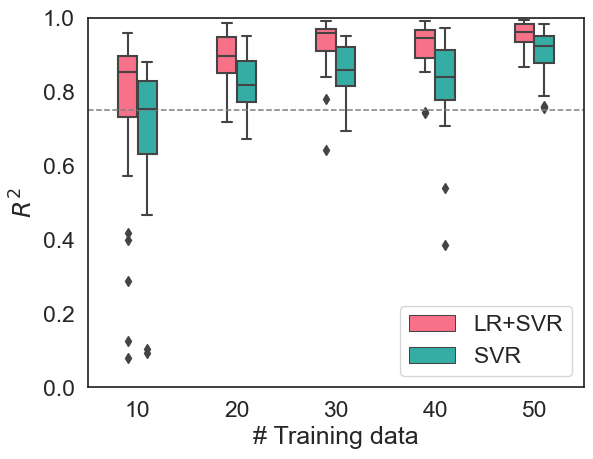

In [46]:
TFTFB_LR = ComparisonResultsPlot([complexSVRR2Lists_TFTFB_LR, SVRR2Lists_TFTFB_LR], 'LR', 'SVR', position = 'lower right', \
                              xname = '# Training data', yname = '$R^2$', show = 1, \
                              ylimit = [0, 1], yline = 0.75)

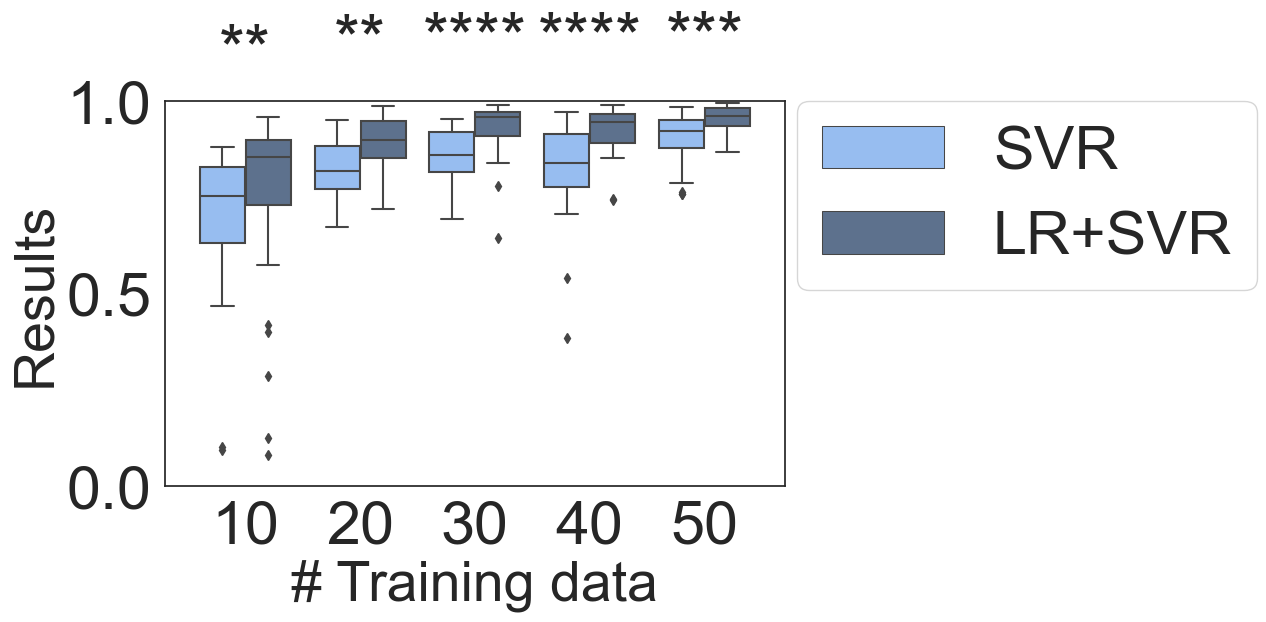

In [47]:
statsPlot(TFTFB_LR, 'LR', 'SVR')

In [48]:
# storeCorrelations([complexSVRSpearmanLists_TFTFB_LR, complexSVRPearsonLists_TFTFB_LR,\
#                    complexSVRR2Lists_TFTFB_LR, complexSVRMSELists_TFTFB_LR], 'SF3_TFTFB_LR_Corr.xlsx')

# storeCorrelations([SVRSpearmanLists_TFTFB_LR, SVRPearsonLists_TFTFB_LR,\
#                    SVRR2Lists_TFTFB_LR, SVRMSELists_TFTFB_LR], 'SF3_TFTFB_Corr.xlsx')

# storeRawData([complexPredictedSVRSpearmanLists_TFTFB_LR, complexPredictedSVRPearsonLists_TFTFB_LR,\
#              complexPredictedSVRR2Lists_TFTFB_LR, complexPredictedSVRMSELists_TFTFB_LR], \
#              'SF3_TFTFB_LR_Raw.xlsx')

# storeRawData([PredictedSVRSpearmanLists_TFTFB_LR, PredictedSVRPearsonLists_TFTFB_LR,\
#              PredictedSVRR2Lists_TFTFB_LR, PredictedSVRMSELists_TFTFB_LR], 'SF3_TFTFB_Raw.xlsx')

# storeWeight([r2Recorder_TFTFB_LR, mseRecorder_TFTFB_LR, \
#              pearsonRecorder_TFTFB_LR, spearmanRecorder_TFTFB_LR],\
#             'SF3_TFTFB_LR_Weight.xlsx')

# storeSVCSVRModel([r2Recorder_TFTFB_LR, mseRecorder_TFTFB_LR, \
#                   pearsonRecorder_TFTFB_LR, spearmanRecorder_TFTFB_LR],\
#                  'SF3_TFTFB_LR')
# storeSVRModel([SVRr2Recorder_TFTFB_LR, SVRmseRecorder_TFTFB_LR, \
#                SVRpearsonRecorder_TFTFB_LR, SVRspearmanRecorder_TFTFB_LR],\
#               'SF3_TFTFB_LR')
# storeScalerModel([scXRecorder_TFTFB_LR, scDensityRecorder_TFTFB_LR, \
#                   scDistanceRecorder_TFTFB_LR], 'SF3_TFTFB_LR')

# storeIndex(indexRecorder_TFTFB_LR, 'SF3_TFTFB_LR_TrainingIndices.xlsx')

# storeDataframes([TrainXDFRecorder_TFTFB_LR, TrainYDFRecorder_TFTFB_LR, \
# SVMSVRFullXDFRecorder_TFTFB_LR, SVMSVRFullYDFRecorder_TFTFB_LR], 'SF3_TFTFB_LR')

In [49]:
complexSVRSpearmanLists_DAMCLA_LR, complexSVRPearsonLists_DAMCLA_LR, \
complexSVRR2Lists_DAMCLA_LR, complexSVRMSELists_DAMCLA_LR, \
complexPredictedSVRSpearmanLists_DAMCLA_LR, complexPredictedSVRPearsonLists_DAMCLA_LR, \
complexPredictedSVRR2Lists_DAMCLA_LR, complexPredictedSVRMSELists_DAMCLA_LR, \
r2Recorder_DAMCLA_LR, mseRecorder_DAMCLA_LR, pearsonRecorder_DAMCLA_LR, spearmanRecorder_DAMCLA_LR, \
SVRSpearmanLists_DAMCLA_LR, SVRPearsonLists_DAMCLA_LR, SVRR2Lists_DAMCLA_LR, SVRMSELists_DAMCLA_LR, \
PredictedSVRSpearmanLists_DAMCLA_LR, PredictedSVRPearsonLists_DAMCLA_LR, \
PredictedSVRR2Lists_DAMCLA_LR, PredictedSVRMSELists_DAMCLA_LR, \
SVRr2Recorder_DAMCLA_LR, SVRmseRecorder_DAMCLA_LR, SVRpearsonRecorder_DAMCLA_LR, SVRspearmanRecorder_DAMCLA_LR,\
indexRecorder_DAMCLA_LR, TrainXDFRecorder_DAMCLA_LR, TrainYDFRecorder_DAMCLA_LR, \
SVMSVRFullXDFRecorder_DAMCLA_LR, SVMSVRFullYDFRecorder_DAMCLA_LR, scXRecorder_DAMCLA_LR, \
scDensityRecorder_DAMCLA_LR, scDistanceRecorder_DAMCLA_LR = \
ComparisonMultipleRun(30, 'HelenaExpDAMCLA.xlsx', 3, 'Sheet1', [10, 20, 30, 40, 50], 0, ['poly'],\
                     0.5) #, 'sigmoid', 'rbf'

10
R2:  0.999780393299934
MSE:  0.006403136290123477
Pearson:  0.9998901906209169
Spearman:  1.0
R2:  0.9998485667348338
MSE:  0.01121920601851852
Pearson:  0.9999242805006958
Spearman:  1.0
R2:  0.9999512756449667
MSE:  0.0081548070600823
Pearson:  0.9999756375257183
Spearman:  1.0
R2:  0.9998879581162062
MSE:  0.03108302117119342
Pearson:  0.9999439774888425
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.48842879385119053, 0.16978784344547337, 0.7128858488769017, 0.6048161313207082]
Regression:  [0.35449616801566847, 0.22851344823052827, 0.5923524914861846, 0.5473541817319085]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.004761625656686541
MSE:  0.5652448052641976
Pearson:  0.06900453359516712
Spearman:  0.5
R2:  0.0052702335118025995
MSE:  0.46134265763072707
Pearson:  0.07259637395767501
Spearman:  0.5
R2:  0.0060996032748400495
MSE:  0.578065896434568
Pearson:  0.07809995694518695
Spearman:  0.5
R2:  0.005593129868258009
MSE:  0.5586521452959307
Pearson:  0.07478723064974402
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8495452089168595, 0.10856607961212437, 0.8982103627560214, 0.8807489726897247]
Regression:  [0.12284929399059609, 0.13539306282492514, 0.7501235103530244, 0.42082947126920056]
R2:  0.4091840359026648
MSE:  0.4097867119194077
Pearson:  -0.6396749455017485
Spearman:  -0.5
R2:  0.9956672017905044
MSE:  0.27187585633922634
Pearson:  0.9978312491551389
Spearman:  0.5
R2:  nan
MSE:  0.0493190821761317
Pearson:  nan
Spearman:  nan
R2:  0.9495422955540491
MSE:  0.02331422727777777
Pearson:  -0.9744446087664751
Spearman:  -1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name

Classification:  [0.7934364389891898, 0.10827366187772515, 0.897448019458012, 0.802634981162114]
Regression:  [0.6843495511777066, 0.11313412182710907, 0.7158733765714851, 0.8032090561904276]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/daal4py/sklearn/_device_offload.py", line 88, in wrapper_with_self
    return wrapper_impl(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/daal4py/sklearn/_device_offload.py", line 74, in wrapper_impl
 

R2:  0.8819765361326959
MSE:  0.35372013240082323
Pearson:  0.9391360583710413
Spearman:  1.0
R2:  0.7126118570831753
MSE:  0.27958780517211934
Pearson:  0.8441634066240817
Spearman:  1.0
R2:  0.8424869485484067
MSE:  0.09676973838395057
Pearson:  0.9178708779280487
Spearman:  1.0
R2:  0.8874002409546266
MSE:  0.3238233497686786
Pearson:  0.9420192359790889
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.84349888394118, 0.10599486623634433, 0.9343971274625165, 0.8863315146581636]
Regression:  [0.45894943966613144, 0.23423738402570343, 0.7430235911031229, 0.7858241664109111]
R2:  0.9362609260838654
MSE:  0.0342355101965432
Pearson:  0.9676057699723919
Spearman:  0.5
R2:  0.24568915929064117
MSE:  0.4555851380270617
Pearson:  0.4956704139754975
Spearman:  0.0
R2:  0.7405071835624086
MSE:  0.15077597435080017
Pearson:  0.8605272706674723
Spearman:  0.5
R2:  0.839236133608808
MSE:  0.09317134193580247
Pearson:  0.9160983209289316
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6917806601410899, 0.05898558536765777, 0.8868302773471359, 0.6673783513559242]
Regression:  [0.6812853313604583, 0.1435603593569582, 0.5174502147410771, 0.8148928727795114]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.6138597182679633
MSE:  0.15924819518353914
Pearson:  0.7834920026828371
Spearman:  1.0
R2:  0.9962196494615649
MSE:  0.08698187763914045
Pearson:  0.9981080349649355
Spearman:  1.0
R2:  0.8968603758692748
MSE:  0.061890520258847746
Pearson:  0.9470271252024804
Spearman:  1.0
R2:  0.9968658725901399
MSE:  0.007661263380674889
Pearson:  0.9984317065228546
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8238168305935524, 0.13089299910501181, 0.8908004055042387, 0.7706361816539544]
Regression:  [0.4282474035126168, 0.15831057184422498, 0.7048704179135066, 0.5649720053538031]
R2:  0.7834308912907333
MSE:  0.0813804686613626
Pearson:  -0.8851163151195065
Spearman:  -1.0
R2:  0.7920071070072969
MSE:  0.03178209985514401
Pearson:  -0.889947811395307
Spearman:  -1.0
R2:  0.780237982068325
MSE:  0.006944572671604939
Pearson:  -0.8833108071728349
Spearman:  -1.0
R2:  0.03130768268461984
MSE:  0.24996403317366248
Pearson:  -0.17693977134782285
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.838203722820313, 0.0937126879688205, 0.8027603142477828, 0.7627036293165362]
Regression:  [0.6161941669901528, 0.15382543720478917, 0.6435514189215537, 0.615209841664921]
R2:  0.8610761029421689
MSE:  0.10020533180978508
Pearson:  0.9279418639883474
Spearman:  1.0
R2:  0.980336081910719
MSE:  0.05804395200082307
Pearson:  0.9901192261090174
Spearman:  1.0
R2:  0.9724952192691907
MSE:  0.1857758201507785
Pearson:  0.9861517222360822
Spearman:  1.0
R2:  0.0948574813425418
MSE:  0.39540492573405767
Pearson:  0.3079894175820686
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8403719313263784, 0.08493193863256285, 0.8910352371473585, 0.8557824505757147]
Regression:  [0.7316875278934691, 0.22065954146929428, 0.7726930458807351, 0.863292819386857]
R2:  0.9103227148162657
MSE:  0.032782515359259294
Pearson:  0.954108334947487
Spearman:  1.0
R2:  0.8955302126347408
MSE:  0.03253785664444448
Pearson:  0.9463245810158061
Spearman:  1.0
R2:  0.962910010041588
MSE:  0.04644581438384778
Pearson:  0.9812797817348468
Spearman:  1.0
R2:  0.7925792638474038
MSE:  0.13614571731367173
Pearson:  0.8902692086371428
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7377975225618285, 0.23087153240422498, 0.9391237714775451, 0.8382743260846439]
Regression:  [0.542543807718244, 0.14139087022400604, 0.6261833946844186, 0.7646730679680277]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


R2:  0.40241862071535517
MSE:  0.14422272203724276
Pearson:  -0.6343647379192472
Spearman:  -0.5
R2:  0.2757451612088259
MSE:  0.11693542144032931
Pearson:  -0.525114426776513
Spearman:  -0.5
R2:  0.4028546092988888
MSE:  0.34831294094577786
Pearson:  -0.6347082867734507
Spearman:  -0.5
R2:  0.5805042238592001
MSE:  0.2554639084921811
Pearson:  -0.7619082778518687
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.49876355716067194, 0.09835157204900526, 0.9279325442602941, 0.7425426888758028]
Regression:  [0.6313234758618684, 0.167764177905986, 0.8691389796530666, 0.6480252203099567]
R2:  0.8485428931590542
MSE:  0.053282429611111154
Pearson:  0.9211638796430601
Spearman:  1.0
R2:  0.7315980676031055
MSE:  0.09577132056131686
Pearson:  0.8553350616004849
Spearman:  1.0
R2:  0.7543655530730177
MSE:  0.1362509024131688
Pearson:  0.868542199937929
Spearman:  1.0
R2:  0.9708532650379057
MSE:  0.008267033972477383
Pearson:  0.9853188646513906
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6923998685717986, 0.06895724197840845, 0.660258480341663, 0.6471429356160698]
Regression:  [0.18107491322888897, 0.311672975048831, 0.5633259528580303, 0.21218199522497386]
R2:  0.9894421985426058
MSE:  0.06664109297314819
Pearson:  0.99470709183287
Spearman:  1.0
R2:  0.9893594523916089
MSE:  0.04597919490149179
Pearson:  0.9946654977386161
Spearman:  1.0
R2:  0.9987424173580394
MSE:  0.03688469876148148
Pearson:  0.9993710108653537
Spearman:  1.0
R2:  0.9999680187535338
MSE:  0.20584444248554734
Pearson:  0.9999840092489147
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6835682561361863, 0.1479664212095474, 0.8029420692295306, 0.8706227543898285]
Regression:  [0.48579675963902086, 0.20893610452317818, 0.7239481528445983, 0.7559758206432181]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.22327519292340958
MSE:  0.27093129267304533
Pearson:  0.4725200449964103
Spearman:  -0.5
R2:  0.4535353629168013
MSE:  0.28768183250205764
Pearson:  0.6734503418343487
Spearman:  0.5
R2:  0.8477633378053964
MSE:  0.1265412699173297
Pearson:  0.9207406463306572
Spearman:  0.5
R2:  0.3515113650335602
MSE:  0.31840727242489725
Pearson:  0.5928839389235976
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6807365275852914, 0.08594051652444445, 0.9068093865242616, 0.7832777810884995]
Regression:  [0.3729241181846716, 0.17842376021884318, 0.826219703900236, 0.654829872526246]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9938364802038532
MSE:  0.8599640460148151
Pearson:  0.9969134767891611
Spearman:  1.0
R2:  0.8921787763986613
MSE:  0.6696714600201904
Pearson:  0.9445521565263935
Spearman:  1.0
R2:  0.2514967491563206
MSE:  0.908022255160642
Pearson:  0.5014945155795033
Spearman:  0.5
R2:  0.9980110789535717
MSE:  1.0920982641823052
Pearson:  -0.9990050445085707
Spearman:  -0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.2933488471603878, 0.22567866837111114, 0.6459338214049473, 0.34757946383506394]
Regression:  [0.4753147455216841, 0.2399154075701372, 0.6458910345955773, -0.05413963096472352]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.7625903573741387
MSE:  0.022964467392592613
Pearson:  0.8732641967778929
Spearman:  0.5
R2:  0.9467583769793029
MSE:  0.1608681140213993
Pearson:  0.9730150959668111
Spearman:  1.0
R2:  0.6859362938953472
MSE:  0.005079557932510278
Pearson:  -0.8282127105371824
Spearman:  -0.8660254037844387
R2:  0.01923904495572023
MSE:  0.0007214460129053488
Pearson:  -0.13870488439748702
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6991852256479109, 0.09076999270140605, 0.8992393023628051, 0.8040200233120903]
Regression:  [0.4189435522037767, 0.24106243496841645, 0.7138884193829655, 0.7731673195681065]
R2:  0.8111377157957724
MSE:  0.10930583917242805
Pearson:  0.9006318425393212
Spearman:  0.5
R2:  0.8632289248509214
MSE:  0.09037617954686417
Pearson:  0.9291011381173316
Spearman:  0.5
R2:  0.8797767291387275
MSE:  0.07343335701161406
Pearson:  0.9379641406465002
Spearman:  0.5
R2:  0.9998787728753133
MSE:  0.03217366646416193
Pearson:  0.9999393846005435
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.607691778934228, 0.18192033657294032, 0.7453626927799888, 0.7156713406686909]
Regression:  [0.382053336748661, 0.23163695053820763, 0.6829867220148407, 0.6294780099963408]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.5920020270493519
MSE:  0.38424220209035215
Pearson:  0.769416679731699
Spearman:  0.5
R2:  0.6114251783992901
MSE:  0.3829142716836307
Pearson:  0.7819368122804363
Spearman:  0.5
R2:  0.2473974833572564
MSE:  0.6196267954205764
Pearson:  0.49739067477914833
Spearman:  0.5
R2:  0.9749995219266332
MSE:  0.23614808685267497
Pearson:  0.9874206408246857
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7408730805151825, 0.10878107417689376, 0.790215175180822, 0.7777899496839978]
Regression:  [0.8112798977457449, 0.13826597796888887, 0.7385652982452824, 0.7280069589007536]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9869556542108929
MSE:  0.20031662205080036
Pearson:  0.9934564178719129
Spearman:  0.8660254037844387
R2:  0.9869556542108934
MSE:  0.14538332040288068
Pearson:  0.9934564178719129
Spearman:  0.8660254037844387
R2:  0.9869556542108929
MSE:  0.1386605398010865
Pearson:  0.993456417871913
Spearman:  0.8660254037844387
R2:  0.9869556542108925
MSE:  0.09247438865226339
Pearson:  0.9934564178719129
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7430663179180765, 0.0693579730848834, 0.8957703224835152, 0.7875969515424889]
Regression:  [0.6599310061778225, 0.2889312292301997, 0.7105605341359631, 0.7632075186816835]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9991377695406978
MSE:  0.3293771775292181
Pearson:  0.9995687918000931
Spearman:  0.5
R2:  0.95074452457381
MSE:  0.9610937683118429
Pearson:  -0.9750612927266724
Spearman:  -1.0
R2:  0.99952944621806
MSE:  0.02884050999341564
Pearson:  0.9997646954249085
Spearman:  0.5
R2:  0.999407331136458
MSE:  0.10309753480020571
Pearson:  0.999703621648165
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.10639539270701859, 0.19111165150343548, 0.7947615884932228, 0.7453277300568149]
Regression:  [0.47513049229621523, 0.2666515411732358, 0.7086837402323913, 0.6250650340343804]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9940378231731245
MSE:  0.036927689373662524
Pearson:  0.9970144548466309
Spearman:  0.5
R2:  0.8467084915466094
MSE:  0.10284971434732511
Pearson:  0.9201676431752038
Spearman:  0.5
R2:  0.959646962003273
MSE:  0.054432882182578884
Pearson:  0.9796157215986648
Spearman:  0.5
R2:  0.8767130082980211
MSE:  0.36196786067934067
Pearson:  0.9363295404386326
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.4804597525893012, 0.09937888957682672, 0.7427687453644749, 0.846699112756871]
Regression:  [0.5581325018566756, 0.1804499743817528, 0.7573924413938464, 0.7269098832328659]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9994739971422976
MSE:  0.411534989106173
Pearson:  0.9997369639771739
Spearman:  0.5
R2:  0.9999266155012068
MSE:  0.16037413203420217
Pearson:  0.9999633070774178
Spearman:  0.5
R2:  0.9995194980138813
MSE:  0.45816693769927985
Pearson:  0.9997597201397348
Spearman:  0.5
R2:  0.8974614515717725
MSE:  0.14431412149012351
Pearson:  0.9473444207740775
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.28867190053563463, 0.2684728147443416, 0.7237210888072994, 0.9111869731426302]
Regression:  [0.09942597533202056, 0.3863558354646365, 0.662052201167365, 0.7017265726674081]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


R2:  0.2730850860599156
MSE:  0.1849791016135803
Pearson:  0.5225754357601546
Spearman:  1.0
R2:  0.9805210697316303
MSE:  0.006514715575440322
Pearson:  0.9902126386446652
Spearman:  1.0
R2:  0.9996296946411842
MSE:  0.03336062019240967
Pearson:  0.9998148301766603
Spearman:  0.8660254037844387
R2:  0.9996296946411845
MSE:  0.043613494210699565
Pearson:  0.9998148301766603
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6737660455289919, 0.14396694223602505, 0.8424206470036816, 0.858131215840014]
Regression:  [0.548978073745667, 0.11491632120065842, 0.7522037947108965, 0.8104245159417454]
R2:  0.9965948892661375
MSE:  0.30915217609898354
Pearson:  0.998295992812822
Spearman:  0.5
R2:  0.7671738514247975
MSE:  0.27491938384526743
Pearson:  0.8758846107934526
Spearman:  0.5
R2:  0.9959464130514776
MSE:  0.11979153540923637
Pearson:  0.9979711484063445
Spearman:  1.0
R2:  0.9985530781046181
MSE:  0.10187499366131682
Pearson:  0.9992762771649382
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8356788193953262, 0.17284561534710563, 0.9541604802472864, 0.8432908963465642]
Regression:  [0.41833332864310974, 0.23737933291465024, 0.7991060283359097, 0.7280411750538681]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9265498208286703
MSE:  0.12815683240334316
Pearson:  0.9625745793592672
Spearman:  1.0
R2:  0.7198770648438925
MSE:  0.1464370523904894
Pearson:  0.8484556940959808
Spearman:  1.0
R2:  0.673165385700405
MSE:  0.22726099242304545
Pearson:  0.8204665658638411
Spearman:  0.5
R2:  0.6476223720031634
MSE:  0.4447534456520826
Pearson:  0.8047498816422176
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.731509166280847, 0.12802053194981863, 0.846665899866079, 0.7559714677851023]
Regression:  [0.6557197270602589, 0.1457939024801951, 0.8309177689640392, 0.7976346734660464]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


R2:  0.8513771729908651
MSE:  0.09435402562717947
Pearson:  0.9227010203694718
Spearman:  0.5
R2:  0.8184727648755177
MSE:  0.10741504010706175
Pearson:  0.9046948462744315
Spearman:  0.5
R2:  0.45017063339204916
MSE:  0.23616871710041146
Pearson:  0.6709475638170609
Spearman:  0.5
R2:  0.5323016034634532
MSE:  0.1429078021573045
Pearson:  0.7295900242351543
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7964769029941574, 0.09550023066529491, 0.893571994088869, 0.8142347498261456]
Regression:  [0.3278423836981768, 0.23128414874710104, 0.817000134692891, 0.6074634835578354]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9997409703721031
MSE:  0.0020160261740740652
Pearson:  0.9998704767979214
Spearman:  0.5
R2:  0.999998699012883
MSE:  0.005476707236213965
Pearson:  0.9999993495062299
Spearman:  0.8660254037844387
R2:  0.9918718502990189
MSE:  0.062160732317901236
Pearson:  0.9959276330632758
Spearman:  0.5
R2:  0.9999986990128834
MSE:  0.002482537252674898
Pearson:  0.9999993495062299
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.026723247281459354, 0.2700824039080293, 0.3141171250828596, 0.5587284667772887]
Regression:  [0.20736632342138908, 0.388898430804964, 0.38266244428387897, 0.6124426685839528]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.3567118974437851
MSE:  0.18243130812345695
Pearson:  0.5972536290754416
Spearman:  0.5
R2:  0.9473877167363437
MSE:  0.1594064833725195
Pearson:  0.9733384389493427
Spearman:  1.0
R2:  0.6777890894822427
MSE:  0.17945425328446515
Pearson:  0.8232794722827983
Spearman:  1.0
R2:  0.4278607666897383
MSE:  0.2664996990106996
Pearson:  0.6541106685338027
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6072864274410924, 0.22043836788850488, 0.7428655419487071, 0.37247920704701953]
Regression:  [0.4621397170923828, 0.24559496314756216, 0.6858724421835225, 0.6451698611156247]
R2:  0.634970184508999
MSE:  0.14020493056463199
Pearson:  0.7968501644029441
Spearman:  1.0
R2:  0.8294044478577531
MSE:  0.051865003629218136
Pearson:  0.9107164475607943
Spearman:  1.0
R2:  0.5895982799337224
MSE:  0.12278484572949251
Pearson:  0.7678530327697627
Spearman:  1.0
R2:  0.6848091122953291
MSE:  0.13810930461399187
Pearson:  0.8275319403475185
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.569465836752574, 0.20505814928215824, 0.7030586134434368, 0.6870831979042225]
Regression:  [0.5881194263697948, 0.3833079070124555, 0.6244522199607585, 0.7826246249706336]
R2:  0.9978959745561122
MSE:  0.04462629869391866
Pearson:  0.9989474333297585
Spearman:  1.0
R2:  0.9866311828284412
MSE:  0.034459256482304544
Pearson:  0.9932931001614986
Spearman:  0.8660254037844387
R2:  0.9938132417261673
MSE:  0.18342751833950635
Pearson:  0.9969018215080998
Spearman:  1.0
R2:  0.9936910544961749
MSE:  0.03373667385550981
Pearson:  0.9968405361421531
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7295746573698991, 0.07711992976097129, 0.8161266691200263, 0.8974229947719684]
Regression:  [0.5566182038069555, 0.1324225834181863, 0.7529743057253535, 0.6502917290245849]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9843923707264728
MSE:  0.018523299820576156
Pearson:  0.9921654956339052
Spearman:  1.0
R2:  0.9790407968639576
MSE:  0.030452026519615986
Pearson:  0.9894649043113946
Spearman:  1.0
R2:  0.35374967981886507
MSE:  0.2888689076656608
Pearson:  0.5947685935041167
Spearman:  1.0
R2:  0.931094878548504
MSE:  0.0449969932243827
Pearson:  0.9649325772034564
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.45724777750965595, 0.17856322890567367, 0.635409540468169, 0.8536211594104078]
Regression:  [0.672394778119605, 0.2739140547002058, 0.5961422852694074, 0.7184335852035739]
20
R2:  0.0027885464568274086
MSE:  0.13671222725418386
Pearson:  0.0528066895083133
Spearman:  0.0
R2:  0.022661327753137363
MSE:  0.07621619129240743
Pearson:  -0.15053679866775882
Spearman:  -0.6000000000000001
R2:  0.3018434354887867
MSE:  0.04779912861659255
Pearson:  0.5494027989451697
Spearman:  0.39999999999999997
R2:  0.04465621157742179
MSE:  0.04664558695939644
Pearson:  0.21132016367924236
Spearman:  0.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8247985261847148, 0.05183033011950303, 0.9338428780522412, 0.9086710749673471]
Regression:  [0.4077956555564707, 0.257927613161719, 0.5590740273676658, 0.733622528957793]
R2:  0.9017239542775565
MSE:  0.05501605184012347
Pearson:  0.9495914670412515
Spearman:  0.7999999999999999
R2:  0.957383641511761
MSE:  0.0351281807577284
Pearson:  0.9784598313225541
Spearman:  0.7999999999999999
R2:  0.8904541708256275
MSE:  0.1174856423943704
Pearson:  0.9436387925608123
Spearman:  0.6000000000000001
R2:  0.9744904395654059
MSE:  0.07846375246666655
Pearson:  0.9871628232289777
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7838372536968755, 0.08306433681290983, 0.9171992071538435, 0.8685212274622482]
Regression:  [0.3792332413565523, 0.14370019257604935, 0.7713311466570695, 0.8117906959165804]
R2:  0.9937082254469183
MSE:  0.044101069831617226
Pearson:  0.996849148791791
Spearman:  0.7999999999999999
R2:  0.9387759092281134
MSE:  0.03834349326159116
Pearson:  0.9689044892186813
Spearman:  0.7999999999999999
R2:  0.48567330089159355
MSE:  0.1837453142405006
Pearson:  0.6969026480733114
Spearman:  0.7999999999999999
R2:  0.9450717820412002
MSE:  0.042401684565965464
Pearson:  0.9721480247581644
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8797755507247427, 0.053763909485000004, 0.9300385020565713, 0.7434505903379616]
Regression:  [0.6968475571887176, 0.13174970320059692, 0.8547810309040311, 0.6746641976583522]
R2:  0.4114537871636929
MSE:  0.252519748969136
Pearson:  0.6414466362556536
Spearman:  0.7999999999999999
R2:  0.396287849929684
MSE:  0.2366479188958162
Pearson:  0.6295139791376234
Spearman:  0.7999999999999999
R2:  0.3966936171359778
MSE:  0.2914155842709878
Pearson:  0.6298361827776948
Spearman:  0.7999999999999999
R2:  0.5864867265896205
MSE:  0.20003526406160055
Pearson:  0.7658242138961266
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8774949414734241, 0.059366364337325936, 0.9478346009377427, 0.8583704808041267]
Regression:  [0.718790721112923, 0.10519922156033565, 0.8688326019919135, 0.8360654818404368]
R2:  0.9846469146472208
MSE:  0.03152098365123458
Pearson:  0.9922937642891956
Spearman:  0.39999999999999997
R2:  0.9582024876894162
MSE:  0.025400047400000004
Pearson:  0.9788781781659125
Spearman:  1.0
R2:  0.9996877523323866
MSE:  0.011418729187654329
Pearson:  0.9998438639769646
Spearman:  0.7999999999999999
R2:  0.8185681276076415
MSE:  0.11140380129290113
Pearson:  0.9047475491028654
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6071652945501747, 0.1023111135469005, 0.9172533366743634, 0.9108757725980946]
Regression:  [0.6870138009216806, 0.10570717757764114, 0.8953134759573738, 0.7702063587909946]
R2:  0.9546897352395719
MSE:  0.02720882365282534
Pearson:  0.9770822561276872
Spearman:  1.0
R2:  0.9722113431519078
MSE:  0.03290280840679013
Pearson:  0.986007780472298
Spearman:  1.0
R2:  0.9263491704867168
MSE:  0.049800130770530894
Pearson:  0.9624703478480346
Spearman:  1.0
R2:  0.9512223745119377
MSE:  0.029817160474382716
Pearson:  0.9753062977915898
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8299102734276652, 0.057993135525459136, 0.900959487471884, 0.8618234128214031]
Regression:  [0.7409058313374589, 0.11505694420333334, 0.9037815602776804, 0.7899959671245127]
R2:  0.9879560691653605
MSE:  0.017717956693175566
Pearson:  0.9939597925295373
Spearman:  1.0
R2:  0.982013079668509
MSE:  0.03336283172490564
Pearson:  0.9909657308244867
Spearman:  1.0
R2:  0.982389492093382
MSE:  0.03700765908557098
Pearson:  0.9911556346474465
Spearman:  0.7999999999999999
R2:  0.9743973924244942
MSE:  0.17477678305635194
Pearson:  0.9871156935357144
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8184824923794181, 0.06357710806617627, 0.9269494446000173, 0.8958758493515869]
Regression:  [0.6315288528472247, 0.1193363311606352, 0.7856758248129742, 0.8409526780387772]
R2:  0.5157117396843623
MSE:  0.2303316623621914
Pearson:  0.7181307260411312
Spearman:  1.0
R2:  0.7790349386271026
MSE:  0.12593268697550616
Pearson:  0.8826295591170183
Spearman:  1.0
R2:  0.5596963683417114
MSE:  0.22794759030856487
Pearson:  0.7481285774128077
Spearman:  1.0
R2:  0.5272662659466445
MSE:  0.2276177578851853
Pearson:  0.7261310253298948
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8026624720896399, 0.06079288989492284, 0.918256592588763, 0.9306351612115507]
Regression:  [0.7587763095888599, 0.17868843704989423, 0.4009958831559225, 0.8618411567626544]
R2:  0.9468972908039124
MSE:  0.0400431338253858
Pearson:  0.9730864765291481
Spearman:  0.7999999999999999
R2:  0.8308477569868278
MSE:  0.07301203566666664
Pearson:  0.9115085062613667
Spearman:  1.0
R2:  0.6885712270405393
MSE:  0.17976437475185186
Pearson:  0.8298019203644562
Spearman:  1.0
R2:  0.5979527365780556
MSE:  0.22559715671265435
Pearson:  0.773274037180905
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8245275625309747, 0.05356834266209878, 0.9510507332052347, 0.9024363110581304]
Regression:  [0.5464226123422484, 0.15798431613728142, 0.7439529143148443, 0.8154156491157221]
R2:  0.5223296888502479
MSE:  0.27295834745871056
Pearson:  0.7227237984529413
Spearman:  0.7999999999999999
R2:  0.9456215993858635
MSE:  0.05116626873209873
Pearson:  0.9724307684282021
Spearman:  0.7999999999999999
R2:  0.700662616564396
MSE:  0.13935824562880017
Pearson:  0.8370559220054511
Spearman:  0.39999999999999997
R2:  0.7425734335806301
MSE:  0.08494376779410152
Pearson:  0.8617270064124891
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8706992115358541, 0.08264197105197105, 0.9140703081308182, 0.8162681669010784]
Regression:  [0.7248518277254392, 0.07953108980828191, 0.8638924062239675, 0.7593780951377845]
R2:  0.781787738870301
MSE:  0.10192662480555559
Pearson:  0.8841876151984378
Spearman:  0.7999999999999999
R2:  0.9581176982100699
MSE:  0.029953649650891662
Pearson:  0.9788348676922323
Spearman:  0.7999999999999999
R2:  0.9607048361315664
MSE:  0.019426770124828522
Pearson:  0.9801555162991054
Spearman:  0.7999999999999999
R2:  0.9054029682349033
MSE:  0.04303283686227712
Pearson:  0.9515266513529211
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8044074095309289, 0.07825028692705248, 0.9230990584981942, 0.9441553054445964]
Regression:  [0.7790202845910075, 0.14173124751419292, 0.769617321106731, 0.8870560631843133]
R2:  0.9795282768129632
MSE:  0.006238335777629623
Pearson:  0.9897112087942438
Spearman:  0.7999999999999999
R2:  0.9699782043360374
MSE:  0.054117488595003815
Pearson:  0.984874715045542
Spearman:  0.7999999999999999
R2:  0.9056087424171003
MSE:  0.012577789200925919
Pearson:  0.9516347736485358
Spearman:  0.7999999999999999
R2:  0.9688945869488624
MSE:  0.027185669048902593
Pearson:  0.9843244317545217
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8973109383799277, 0.061846443093640756, 0.8268259114544927, 0.8817330450419298]
Regression:  [0.32712703476911187, 0.1268884568258958, 0.80246262432856, 0.6711503156055802]
R2:  0.9992463911300907
MSE:  0.0037772497562189116
Pearson:  0.9996231245474919
Spearman:  1.0
R2:  0.9990103573784127
MSE:  0.0018659345368312783
Pearson:  0.9995050562045258
Spearman:  1.0
R2:  0.9997263636553974
MSE:  0.0011012515432784573
Pearson:  0.9998631724668117
Spearman:  1.0
R2:  0.9950002588285425
MSE:  0.0030355094398148157
Pearson:  0.9974969969020171
Spearman:  0.9486832980505139


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7374439843251273, 0.10950674811056764, 0.8736936634948124, 0.8372295918440426]
Regression:  [0.5473051868141346, 0.19074144463862655, 0.6813973186548202, 0.8158604448299217]
R2:  0.9807428352088455
MSE:  0.009897607013580207
Pearson:  0.9903246110285481
Spearman:  0.39999999999999997
R2:  0.9995942986115983
MSE:  0.002409622266255139
Pearson:  0.9997971287274227
Spearman:  0.39999999999999997
R2:  0.9972651337652899
MSE:  0.004184727903012316
Pearson:  0.9986316306653267
Spearman:  0.632455532033676
R2:  0.9978908786601609
MSE:  0.0020266190791047257
Pearson:  0.9989448826938154
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8649664889572516, 0.05810400397680123, 0.933661292163626, 0.9184750894090572]
Regression:  [0.8146698245621667, 0.11109762863898634, 0.8997705340849427, 0.8993147989105486]
R2:  0.425685507353445
MSE:  0.21971222823654327
Pearson:  -0.6524457888234432
Spearman:  -1.0
R2:  0.9619194375047069
MSE:  0.208107433333642
Pearson:  0.9807749168411206
Spearman:  1.0
R2:  0.66730939188136
MSE:  0.21110038580845683
Pearson:  0.8168900733154736
Spearman:  0.7999999999999999
R2:  0.9761249739719019
MSE:  0.20864519328996914
Pearson:  0.9879903713963523
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.4974746988146425, 0.18409390066081793, 0.7834430819598053, 0.7033657434284912]
Regression:  [0.5199652270985476, 0.14450544576415653, 0.8466843666257524, 0.5519586052248794]
R2:  0.9983830159370516
MSE:  0.0007881369790123398
Pearson:  0.999191180874337
Spearman:  1.0
R2:  0.9992362470077232
MSE:  0.0006701756296296296
Pearson:  0.9996180505611749
Spearman:  1.0
R2:  0.9980992427281149
MSE:  0.001026014617530869
Pearson:  0.9990491693245709
Spearman:  1.0
R2:  0.9985325900015214
MSE:  0.000778679661382716
Pearson:  0.9992660256415816
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8386127080577597, 0.06369447425556729, 0.7943376126300539, 0.8890872355898923]
Regression:  [0.7552099576386931, 0.08324103680521436, 0.8833337176979263, 0.8215374192159788]
R2:  0.9697573783370741
MSE:  0.05116486116748965
Pearson:  0.9847625999889894
Spearman:  0.7999999999999999
R2:  0.9772575654067528
MSE:  0.02212270722222222
Pearson:  0.9885633846176747
Spearman:  0.7999999999999999
R2:  0.9676619544364184
MSE:  0.01561799396790126
Pearson:  0.9836981012670595
Spearman:  0.7999999999999999
R2:  0.9884805435025712
MSE:  0.016219293292163966
Pearson:  0.9942235882851356
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.5885745768591503, 0.1276450066181834, 0.7727553622444212, 0.7180737676708213]
Regression:  [0.6363267618330841, 0.15863900232240744, 0.7418803393200624, 0.7191372246456387]
R2:  0.9086234026699402
MSE:  0.02761676409506169
Pearson:  0.9532173952829125
Spearman:  0.7999999999999999
R2:  0.9854919523516468
MSE:  0.005307866568724259
Pearson:  0.9927194731401449
Spearman:  0.7999999999999999
R2:  0.9942623620205834
MSE:  0.0015191462425925904
Pearson:  0.9971270541012229
Spearman:  0.7999999999999999
R2:  0.8837249288093566
MSE:  0.03438309516406031
Pearson:  0.9400664491456742
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7989840522835696, 0.10683928704833337, 0.8970894974711643, 0.936788993082026]
Regression:  [0.8601512832557819, 0.04765282490999915, 0.924103447007415, 0.8447239185287028]
R2:  0.6989215569784183
MSE:  0.12007344298111496
Pearson:  0.8360152851344399
Spearman:  0.7999999999999999
R2:  0.9797933895584479
MSE:  0.022455399350248668
Pearson:  0.989845134128793
Spearman:  0.7999999999999999
R2:  0.9997027079611586
MSE:  0.01048632688745678
Pearson:  0.9998513429311174
Spearman:  0.7999999999999999
R2:  0.9863957460068794
MSE:  0.012706891327932106
Pearson:  0.9931745798231447
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8999832660941744, 0.09065507724597224, 0.9083153916859239, 0.92056088784889]
Regression:  [0.7006816805556895, 0.15543867548849924, 0.7680139180443788, 0.8320195983160578]
R2:  0.9538006355366871
MSE:  0.0283647124809328
Pearson:  0.9766271732532774
Spearman:  1.0
R2:  0.8938897137670547
MSE:  0.059796285958504815
Pearson:  0.9454574098112801
Spearman:  1.0
R2:  0.756513855013861
MSE:  0.09925187318279319
Pearson:  0.8697780492826095
Spearman:  1.0
R2:  0.9109026820422658
MSE:  0.04327854457274076
Pearson:  0.9544122180914627
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8183439528688161, 0.06237562580351852, 0.8462650263912717, 0.862911260891895]
Regression:  [0.7433033054786478, 0.09064895027993829, 0.848290699568067, 0.7734830629813098]
R2:  0.9986019677290361
MSE:  0.00220429200644719
Pearson:  0.9993007393818119
Spearman:  1.0
R2:  0.9950248608979582
MSE:  0.002978526300720171
Pearson:  0.9975093287272847
Spearman:  0.7999999999999999
R2:  0.9955869484400666
MSE:  0.0032567697691358115
Pearson:  0.9977910344556452
Spearman:  0.7999999999999999
R2:  0.964983169720539
MSE:  0.015565742708573398
Pearson:  0.9823355687953781
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7235356283021855, 0.1211212588604496, 0.8850161722547553, 0.7676645757683117]
Regression:  [0.7122752388401898, 0.11239602397741429, 0.8024480749786147, 0.7135554604520121]
R2:  0.9884565350945526
MSE:  0.03729993654686412
Pearson:  0.9942115142637169
Spearman:  1.0
R2:  0.9922103350114526
MSE:  0.009575657494032896
Pearson:  0.9960975529592737
Spearman:  0.7999999999999999
R2:  0.9858816227638618
MSE:  0.014001866017695465
Pearson:  0.992915717855177
Spearman:  0.7999999999999999
R2:  0.9977072892603726
MSE:  0.014158461228395057
Pearson:  0.9988529868105578
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7613516825148191, 0.059110049865380244, 0.9487810279250825, 0.8096577590248477]
Regression:  [0.680668598457767, 0.10857570570456795, 0.8168525096977839, 0.845958631068675]
R2:  0.8856535092428598
MSE:  0.1345128243865935
Pearson:  0.9410916582580356
Spearman:  0.316227766016838
R2:  0.7782949719734369
MSE:  0.2154475466232789
Pearson:  0.8822102765063647
Spearman:  0.316227766016838
R2:  0.9678619167091526
MSE:  0.03387194703333332
Pearson:  0.9837997340460873
Spearman:  0.316227766016838
R2:  0.9119732648237616
MSE:  0.05358972433518523
Pearson:  0.9549729131361588
Spearman:  0.316227766016838


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.5120651606022636, 0.11604656211715196, 0.9081314475000428, 0.8709645792132108]
Regression:  [0.6308111037440934, 0.20706754035406857, 0.8872305182655041, 0.8169511003399683]
R2:  0.7729174707258877
MSE:  0.06693266238333331
Pearson:  0.8791572502834109
Spearman:  0.7999999999999999
R2:  0.7768259533550558
MSE:  0.07578323162276542
Pearson:  0.8813773047651361
Spearman:  0.7999999999999999
R2:  0.9679446743672441
MSE:  0.05586427527283953
Pearson:  0.983841793362756
Spearman:  1.0
R2:  0.8490555775598535
MSE:  0.07680160412441704
Pearson:  0.9214421183991175
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8658142990945121, 0.04646481682784755, 0.9358316960303376, 0.8597197561060751]
Regression:  [0.7902076145194052, 0.07413062165024693, 0.9254347644115068, 0.8946597488459391]
R2:  0.9864618912395021
MSE:  0.004992336490775016
Pearson:  0.9932078791670462
Spearman:  1.0
R2:  0.9905350951983484
MSE:  0.003418975540740721
Pearson:  0.9952562962364759
Spearman:  1.0
R2:  0.995070604241956
MSE:  0.001776234090946487
Pearson:  0.9975322572438227
Spearman:  1.0
R2:  0.9886857978154517
MSE:  0.004682612721913567
Pearson:  0.9943268063445999
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7673711341059652, 0.09458709395470509, 0.9186596477130722, 0.8152441456563764]
Regression:  [0.716838192827503, 0.10383423667430172, 0.8695007771456098, 0.848603127224359]
R2:  0.9993163393207468
MSE:  0.004277127417283938
Pearson:  0.9996581112164029
Spearman:  0.9486832980505139
R2:  0.9857159516699336
MSE:  0.0071306656758852085
Pearson:  0.9928322877857741
Spearman:  0.39999999999999997
R2:  0.98689886067087
MSE:  0.011523158811747702
Pearson:  0.9934278336501701
Spearman:  1.0
R2:  0.9999390339987718
MSE:  0.011965643332647467
Pearson:  0.9999695165347648
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8747738512748773, 0.0400905324306829, 0.9335510385925354, 0.9150353280461437]
Regression:  [0.5420628836080619, 0.20163347073430554, 0.7441316253976065, 0.7161565145403831]
R2:  0.9981319506776285
MSE:  0.13333482097895785
Pearson:  0.9990655387298816
Spearman:  0.7999999999999999
R2:  0.9749606573857944
MSE:  0.1401060194419754
Pearson:  0.9874009607984966
Spearman:  1.0
R2:  0.9676021514831292
MSE:  0.04100478971745544
Pearson:  0.9836677037918493
Spearman:  0.6000000000000001
R2:  0.985986241103958
MSE:  0.05255420022715242
Pearson:  0.9929683988445743
Spearman:  0.8944271909999159


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.913252390416263, 0.03161837583503548, 0.9730145322245136, 0.9249759501345235]
Regression:  [0.7932316095466149, 0.10049178121332476, 0.9263193887811509, 0.8812218599843039]
R2:  0.817539455518026
MSE:  0.11951588090366956
Pearson:  0.9041788846893218
Spearman:  0.39999999999999997
R2:  0.42161384736075164
MSE:  0.15853542253383832
Pearson:  0.649317986321611
Spearman:  0.39999999999999997
R2:  0.8867521042097721
MSE:  0.0676375791432099
Pearson:  0.9416751585391706
Spearman:  0.19999999999999998
R2:  0.8725838680135659
MSE:  0.07137030252469136
Pearson:  0.9341219770530856
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8407025013945589, 0.046623697616178614, 0.9429781674978449, 0.7758769260751192]
Regression:  [0.5528228174766082, 0.1493392483367766, 0.7048281913606392, 0.8277857544323625]
R2:  0.8575737494922144
MSE:  0.012884719691726738
Pearson:  0.9260527789992393
Spearman:  0.7999999999999999
R2:  0.6444690891186176
MSE:  0.09526101208309859
Pearson:  0.8027883214886832
Spearman:  0.7999999999999999
R2:  0.6302123281840807
MSE:  0.006758144214814802
Pearson:  0.793859136235189
Spearman:  0.7999999999999999
R2:  0.9510266430127052
MSE:  0.0034657731923182426
Pearson:  0.9752059490244638
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8516180703041852, 0.02835923601401235, 0.9400192080102759, 0.8155976073564596]
Regression:  [0.5981609372431481, 0.31094690191044494, 0.7800152576933079, 0.7730274253096584]
R2:  0.9905556911967607
MSE:  0.025976489200411554
Pearson:  0.9952666432653918
Spearman:  0.7999999999999999
R2:  0.985781820123879
MSE:  0.008974101765432129
Pearson:  0.9928654592259106
Spearman:  0.7999999999999999
R2:  0.9875580792156993
MSE:  0.014147000942901278
Pearson:  0.99375956811278
Spearman:  1.0
R2:  0.9844578889564795
MSE:  0.016257024872618632
Pearson:  0.992198512877579
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8212604184479149, 0.0589733488162438, 0.9086141788158579, 0.8657969126023949]
Regression:  [0.7986367443088123, 0.10363316448167566, 0.9021909011059985, 0.8646912663636515]
30
R2:  0.9724238221157551
MSE:  0.016447479387236785
Pearson:  0.9861155216888915
Spearman:  0.7714285714285715
R2:  0.9844148658174396
MSE:  0.009586335645267488
Pearson:  0.9921768319293892
Spearman:  0.942857142857143
R2:  0.9754322522379941
MSE:  0.012227288264837696
Pearson:  0.9876397380816522
Spearman:  1.0
R2:  0.9828748244940257
MSE:  0.00950625179341565
Pearson:  0.9914004359964879
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8378251449833524, 0.061679921356113415, 0.9039514871659633, 0.8633851226842889]
Regression:  [0.8029712326474336, 0.09238098787568294, 0.8504748242496456, 0.8327078358103243]
R2:  0.9980700598896938
MSE:  0.000667346201160266
Pearson:  0.9990345639114265
Spearman:  0.6
R2:  0.9997031196468145
MSE:  0.00011686222971193343
Pearson:  0.9998515488045283
Spearman:  0.942857142857143
R2:  0.99120715429746
MSE:  0.0023720151611111065
Pearson:  0.99559387015864
Spearman:  0.3714285714285715
R2:  0.9988078806755724
MSE:  0.00040166104841199754
Pearson:  0.9994037625882604
Spearman:  0.3714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7484692488971257, 0.12851060879704054, 0.8240450135869657, 0.9226341005495554]
Regression:  [0.5581006700049521, 0.26646302211073686, 0.725201753119618, 0.8172735405225106]
R2:  0.9930965025448332
MSE:  0.0061497279958518366
Pearson:  0.9965422733355738
Spearman:  0.942857142857143
R2:  0.9759525309738979
MSE:  0.011547604082304515
Pearson:  0.9879030979675578
Spearman:  0.8857142857142858
R2:  0.9917511499132212
MSE:  0.00591818202654319
Pearson:  0.9958670342536805
Spearman:  0.8857142857142858
R2:  0.9939916418600716
MSE:  0.005557321958650212
Pearson:  0.9969912947764751
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8890101410877458, 0.11092359606284405, 0.9436935478260055, 0.9144624438179976]
Regression:  [0.6737198914508501, 0.1009137883046671, 0.8051197009488393, 0.6784883212317383]
R2:  0.48360910614505437
MSE:  0.23690430319329803
Pearson:  0.6954200932853856
Spearman:  0.3714285714285715
R2:  0.450519980793453
MSE:  0.2640596478236856
Pearson:  0.6712078521541989
Spearman:  0.11595420713048969
R2:  0.40084122273481054
MSE:  0.27315775956968935
Pearson:  0.6331202277094062
Spearman:  -0.08571428571428573
R2:  0.48700285179067804
MSE:  0.24814267346616367
Pearson:  0.6978558961495402
Spearman:  0.40583972495671394


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9174451768314412, 0.04518149246991623, 0.921618742609915, 0.7733181698888986]
Regression:  [0.6259879818771792, 0.08170119376783068, 0.7687057774178252, 0.834243330590044]
R2:  0.9974861895578747
MSE:  0.0015539594289223177
Pearson:  0.9987423038791713
Spearman:  0.7714285714285715
R2:  0.999613893355026
MSE:  0.0002742768129858274
Pearson:  0.999806928039122
Spearman:  0.9276336570439175
R2:  0.833939929251735
MSE:  0.08722710445061732
Pearson:  0.9132031150033024
Spearman:  0.8285714285714287
R2:  0.8999645708457047
MSE:  0.05247503261399176
Pearson:  0.9486646250628854
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.891689763852621, 0.039341442213746025, 0.9487508173431352, 0.8544309334266468]
Regression:  [0.7665472560805864, 0.09032707373566956, 0.8371933113738407, 0.9026598418489392]
R2:  0.9987125724667485
MSE:  0.0019508510115612155
Pearson:  0.9993560789161929
Spearman:  1.0
R2:  0.9657775704078563
MSE:  0.03742437667974539
Pearson:  0.9827398284428364
Spearman:  1.0
R2:  0.9988002623003378
MSE:  0.0028144211164609126
Pearson:  0.9993999511208398
Spearman:  0.942857142857143
R2:  0.9999722533172253
MSE:  0.0011652950667181052
Pearson:  0.9999861265623761
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6975560986498098, 0.11284099511235746, 0.8460959862850779, 0.7828949330803447]
Regression:  [0.6997177817515525, 0.12042281772161764, 0.7467400441871022, 0.7294788687084204]
R2:  0.6543097076415915
MSE:  0.1439543738861912
Pearson:  0.8088941263488018
Spearman:  0.8285714285714287
R2:  0.5293264451984089
MSE:  0.19928171553497945
Pearson:  0.7275482425230707
Spearman:  0.753702346348183
R2:  0.6624544575802597
MSE:  0.13842819021349242
Pearson:  0.8139130528381149
Spearman:  0.8285714285714287
R2:  0.6765861251992311
MSE:  0.1251500923435759
Pearson:  0.8225485549189369
Spearman:  0.8116794499134279


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8840772312146036, 0.05178291743691408, 0.9255806402476825, 0.8442015739093945]
Regression:  [0.8312597996043583, 0.059806384748275015, 0.9083748520779342, 0.8901583413524624]
R2:  0.8419308236396513
MSE:  0.09979688788608924
Pearson:  0.917567885030667
Spearman:  0.7944613465542746
R2:  0.9909001691096069
MSE:  0.006197540385550986
Pearson:  0.9954396863243937
Spearman:  0.8857142857142858
R2:  0.9949885410974384
MSE:  0.002440706937791501
Pearson:  0.9974911233176151
Spearman:  0.9856107606091623
R2:  0.9917114053653362
MSE:  0.011535009785185164
Pearson:  0.9958470793075291
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9073333192685231, 0.047680446854774614, 0.9020762579023881, 0.815995521115276]
Regression:  [0.877412990427285, 0.05553061265407212, 0.8946813749839978, 0.7915875670883057]
R2:  0.9887188422755444
MSE:  0.01014912048184729
Pearson:  0.9943434227044217
Spearman:  0.6571428571428573
R2:  0.9873420039021112
MSE:  0.013849920396533882
Pearson:  0.9936508460732627
Spearman:  0.4285714285714286
R2:  0.9985875178781513
MSE:  0.011796315363694567
Pearson:  0.9992935093745735
Spearman:  0.9276336570439175
R2:  0.9837664519090586
MSE:  0.017201400288065858
Pearson:  0.991850014825356
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.733601442039737, 0.12113064918404325, 0.8505926651733823, 0.7991845369360338]
Regression:  [0.7462658662252892, 0.11303435007196426, 0.8463895387070136, 0.7446197992531433]
R2:  0.985344540846151
MSE:  0.008409870658790586
Pearson:  0.9926452240585011
Spearman:  0.7714285714285715
R2:  0.9756285931008947
MSE:  0.012002080199691354
Pearson:  0.9877391321097362
Spearman:  0.942857142857143
R2:  0.9997702150317945
MSE:  0.0017636465664609155
Pearson:  0.9998851009149976
Spearman:  0.8285714285714287
R2:  0.9872886931366891
MSE:  0.008216134870370383
Pearson:  0.9936240200079153
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6502899636611076, 0.07251096133817664, 0.8213206295802774, 0.8685587325082831]
Regression:  [0.6274507023206258, 0.1473606366399638, 0.7748826268251221, 0.7586991413229077]
R2:  0.9633969090373371
MSE:  0.01791882121485547
Pearson:  0.9815278442496358
Spearman:  0.8285714285714287
R2:  0.9961137823530918
MSE:  0.0025725605548971194
Pearson:  0.9980549996633912
Spearman:  0.942857142857143
R2:  0.9942054138763023
MSE:  0.00311785911334978
Pearson:  0.9970984975800048
Spearman:  0.8285714285714287
R2:  0.9806567591467609
MSE:  0.01208752737684849
Pearson:  0.9902811515659383
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.836077039056049, 0.060131805812173554, 0.9251464273378112, 0.8454867226747785]
Regression:  [0.6866072495301742, 0.10932287341938765, 0.8845493259530692, 0.7352462601697138]
R2:  0.6055622057619516
MSE:  0.1510642078489198
Pearson:  0.7781787749366799
Spearman:  0.7714285714285715
R2:  0.6245126096790238
MSE:  0.14354124244098773
Pearson:  0.7902611022181363
Spearman:  0.8285714285714287
R2:  0.5703107816177311
MSE:  0.16776022557341108
Pearson:  0.7551892356341762
Spearman:  0.8285714285714287
R2:  0.609456156975382
MSE:  0.14978057991953914
Pearson:  0.7806767301357086
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8887223852138251, 0.04819085537338185, 0.879228082563023, 0.8164240279626637]
Regression:  [0.7629362964989033, 0.0631763012373364, 0.8939543590948229, 0.8541803590643047]
R2:  0.5929610552834145
MSE:  0.1254876644525835
Pearson:  0.7700396452673164
Spearman:  0.3714285714285715
R2:  0.6440758707382694
MSE:  0.1153385558156378
Pearson:  0.8025433762347488
Spearman:  0.6
R2:  0.6249018631646134
MSE:  0.1157607409540381
Pearson:  0.7905073454210362
Spearman:  0.6
R2:  0.4051820986572232
MSE:  0.19796181619753092
Pearson:  0.6365391572065489
Spearman:  0.40583972495671394


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8209077320732132, 0.03359101425735646, 0.9510555387666001, 0.9326043215816638]
Regression:  [0.6344025757740992, 0.08452941519704146, 0.8460912875799189, 0.7761486511318539]
R2:  0.9636266285517556
MSE:  0.12757703913775317
Pearson:  0.9816448586692417
Spearman:  0.7714285714285715
R2:  0.4739745563522324
MSE:  0.1935356250685187
Pearson:  0.6884581006511814
Spearman:  0.8116794499134279
R2:  0.8680821937860199
MSE:  0.04790554546328313
Pearson:  0.9317092860898296
Spearman:  0.6
R2:  0.9387522651132771
MSE:  0.06200469104185192
Pearson:  0.9688922876735462
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7256948751585103, 0.06489981391484569, 0.8592376006347947, 0.767512051144857]
Regression:  [0.7734341645947722, 0.12627015236915642, 0.8060322452042641, 0.7227189222290262]
R2:  0.9973505742852533
MSE:  0.006180325422997089
Pearson:  0.9986744085462755
Spearman:  0.942857142857143
R2:  0.9976988540131289
MSE:  0.004185212587439253
Pearson:  0.9988487643347861
Spearman:  0.942857142857143
R2:  0.9549293252068765
MSE:  0.02450152126831272
Pearson:  0.9772048532456624
Spearman:  1.0
R2:  0.9125438862021267
MSE:  0.04627109678059338
Pearson:  0.955271629539016
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8696122404081634, 0.04589906639807911, 0.9281151807767691, 0.9341743824389034]
Regression:  [0.6737105596963532, 0.11820163859149913, 0.8146878502149508, 0.8538103018225454]
R2:  0.8814629723843798
MSE:  0.1038220040679781
Pearson:  0.9388625950501918
Spearman:  0.8857142857142858
R2:  0.9658236080102351
MSE:  0.03513155484274693
Pearson:  0.9827632512514064
Spearman:  0.942857142857143
R2:  0.8371194480985902
MSE:  0.0533125116734568
Pearson:  0.9149423195472985
Spearman:  0.942857142857143
R2:  0.9293433741218387
MSE:  0.03904894323252057
Pearson:  0.9640245713268095
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8869179680092222, 0.04669038817220459, 0.8666000542305283, 0.9153179949260782]
Regression:  [0.817866133267286, 0.06667225537581523, 0.8630820623262869, 0.8725920741842359]
R2:  0.8571539001113676
MSE:  0.06419284412485768
Pearson:  0.9258260636379645
Spearman:  0.942857142857143
R2:  0.9600227912571192
MSE:  0.019644669798536792
Pearson:  0.9798075276589373
Spearman:  0.942857142857143
R2:  0.8881929240625441
MSE:  0.0517325612629383
Pearson:  0.9424398782217058
Spearman:  0.942857142857143
R2:  0.94695024683602
MSE:  0.025599186539460476
Pearson:  0.9731136864909568
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8467740924450373, 0.04635619861437186, 0.9497367746173925, 0.8571803578362315]
Regression:  [0.6956638210293085, 0.08916322411685189, 0.8509881728497442, 0.8184585775522701]
R2:  0.3746804398690173
MSE:  0.22264236032813986
Pearson:  0.6121114603313822
Spearman:  0.753702346348183
R2:  0.5393947154152755
MSE:  0.1496102731415637
Pearson:  0.7344349633665839
Spearman:  0.8116794499134279
R2:  0.3869917640708121
MSE:  0.2184239040902892
Pearson:  0.622086621035055
Spearman:  0.8285714285714287
R2:  0.3850514087310176
MSE:  0.20784707304609054
Pearson:  0.6205251072527346
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8410041358865862, 0.09201327651012245, 0.8995188223670845, 0.8994015606072604]
Regression:  [0.4452216869076131, 0.13488888527372542, 0.873543480067365, 0.8162854285471961]
R2:  0.9947407495302598
MSE:  0.001905887474897123
Pearson:  0.9973669081788608
Spearman:  0.7714285714285715
R2:  0.9886345878692678
MSE:  0.005877440462917226
Pearson:  0.9943010549472769
Spearman:  0.7714285714285715
R2:  0.9814119466864095
MSE:  0.008701249596387722
Pearson:  0.9906623777485497
Spearman:  0.7714285714285715
R2:  0.9938232143046225
MSE:  0.0034121821677983426
Pearson:  0.9969068232812047
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9155693886861981, 0.03327179779521827, 0.9639559577639052, 0.8993578645298048]
Regression:  [0.8059091529702475, 0.060827763933602313, 0.9099036251429999, 0.7683492257895197]
R2:  0.9173197859741636
MSE:  0.022136692647572
Pearson:  0.9577681274578744
Spearman:  0.6571428571428573
R2:  0.7441066899893363
MSE:  0.06556763534320985
Pearson:  0.8626161892692117
Spearman:  0.48571428571428577
R2:  0.696966015933081
MSE:  0.09217349724249191
Pearson:  0.8348449053165988
Spearman:  0.6571428571428573
R2:  0.8056020981223857
MSE:  0.04481650029016917
Pearson:  0.8975533956943094
Spearman:  0.5428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.853534452272141, 0.056176697213723314, 0.9142006271483554, 0.9229705936764147]
Regression:  [0.7299781971947951, 0.14296308776154223, 0.818044804902853, 0.6860467150730469]
R2:  0.9640241016734792
MSE:  0.03934309843031548
Pearson:  0.9818472904038992
Spearman:  0.6571428571428573
R2:  0.9999182314009388
MSE:  0.00028455927700045625
Pearson:  0.9999591148646723
Spearman:  0.942857142857143
R2:  0.9706698623282144
MSE:  0.020352233969821668
Pearson:  0.9852257925613873
Spearman:  0.7714285714285715
R2:  0.9882517063032028
MSE:  0.012875787840512099
Pearson:  0.9941084982551969
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8220930508346618, 0.08662928224091657, 0.8553414722908284, 0.8192931636155211]
Regression:  [0.6638479707643783, 0.08528822600472667, 0.8248987431708299, 0.8014633118299906]
R2:  0.9990699045779142
MSE:  0.0008589327709090628
Pearson:  0.9995348441039531
Spearman:  0.7714285714285715
R2:  0.9927763807062786
MSE:  0.0036799200613425904
Pearson:  0.9963816441034419
Spearman:  0.7714285714285715
R2:  0.9980122211945549
MSE:  0.004898723775308644
Pearson:  0.9990056161977043
Spearman:  0.6
R2:  0.9973673896165072
MSE:  0.001732074758601965
Pearson:  0.9986828273363405
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6187759874445409, 0.03626168598229864, 0.8965963152359331, 0.7869472034124302]
Regression:  [0.6337127981896782, 0.12996195756525578, 0.7987414067883214, 0.7128222624912995]
R2:  0.9816962771087215
MSE:  0.006416039715643567
Pearson:  0.9908058725647126
Spearman:  0.6571428571428573
R2:  0.9988018468019129
MSE:  0.0006683678512574283
Pearson:  0.9994007438469878
Spearman:  0.6571428571428573
R2:  0.9999874891520631
MSE:  1.3748406814814384e-05
Pearson:  0.9999937445564662
Spearman:  0.942857142857143
R2:  0.9992805571473701
MSE:  0.0005648128266335417
Pearson:  0.9996402138506486
Spearman:  0.6377481392176932


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7999412601892523, 0.07236544810352219, 0.8987191145396771, 0.8210348158479949]
Regression:  [0.84222368017257, 0.11431285452034885, 0.9052940623292196, 0.7690625329238195]
R2:  0.9826926493293172
MSE:  0.006814191650085605
Pearson:  0.9913085540482924
Spearman:  0.942857142857143
R2:  0.9866532359622326
MSE:  0.015892067174959727
Pearson:  0.993304201119794
Spearman:  0.8285714285714287
R2:  0.9965023345722218
MSE:  0.003787670545068195
Pearson:  0.9982496353979913
Spearman:  1.0
R2:  0.9799635852021997
MSE:  0.007260331115637877
Pearson:  0.9899311012399803
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8382725874182418, 0.06824978110113267, 0.9226551483650767, 0.8716997821088843]
Regression:  [0.8514788096472631, 0.1294417407203351, 0.9082162455600675, 0.7987958996692004]
R2:  0.6608661598969109
MSE:  0.09324664301669132
Pearson:  0.8129367502437759
Spearman:  0.7142857142857143
R2:  0.6659726691726309
MSE:  0.09144081855027014
Pearson:  0.8160714853324011
Spearman:  0.8285714285714287
R2:  0.638783389250866
MSE:  0.09877341826954734
Pearson:  0.7992392565751922
Spearman:  0.8285714285714287
R2:  0.6795638969699316
MSE:  0.08783763376296298
Pearson:  0.82435665641149
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8740965673650625, 0.08969447236235926, 0.8820717472575665, 0.8545709036829674]
Regression:  [0.5904155499105316, 0.18267880578661239, 0.7552524554446813, 0.7996570559728954]
R2:  0.9396045661305168
MSE:  0.03151389154930843
Pearson:  0.9693320205845453
Spearman:  0.9856107606091623
R2:  0.9382886676602408
MSE:  0.018837747011728398
Pearson:  0.9686530171636492
Spearman:  0.8285714285714287
R2:  0.9949174078727396
MSE:  0.001504402705349784
Pearson:  0.9974554666112867
Spearman:  0.9856107606091623
R2:  0.9772303904504906
MSE:  0.008399130357488448
Pearson:  0.9885496398514801
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7488785671748301, 0.05636875848978441, 0.8916066511430253, 0.8121675543103997]
Regression:  [0.5794785763964746, 0.12474570775043359, 0.8734029137612571, 0.664456303035605]
R2:  0.9823546466281775
MSE:  0.008504961444901706
Pearson:  0.9911380562909378
Spearman:  0.942857142857143
R2:  0.8866529113653074
MSE:  0.038544222370480254
Pearson:  0.9416224887741943
Spearman:  1.0
R2:  0.29690625084266103
MSE:  0.2707262205181757
Pearson:  0.5448910449279388
Spearman:  0.8285714285714287
R2:  0.9655118693551359
MSE:  0.012385412044444453
Pearson:  0.9826046353214176
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8731540817650463, 0.04066472643314913, 0.92012103683093, 0.8882045722043842]
Regression:  [0.8406599858070004, 0.04552839081163251, 0.9250422202969174, 0.8860874665145896]
R2:  0.7459423362860892
MSE:  0.0020541323979423863
Pearson:  0.8636795333259257
Spearman:  0.8986451052612952
R2:  0.7694852056769463
MSE:  0.003339471821134669
Pearson:  0.8772030584060606
Spearman:  0.9258200997725515
R2:  0.06544765102246823
MSE:  0.020219186700411555
Pearson:  0.2558273852082068
Spearman:  0.6571428571428573
R2:  0.06854204179468412
MSE:  0.005761290104691348
Pearson:  0.26180535096648444
Spearman:  0.08571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.856915975877302, 0.03549428005965168, 0.9490060573000462, 0.8552357624004899]
Regression:  [0.7586884860432601, 0.10217857120046739, 0.852789276358847, 0.787363964147533]
R2:  0.9777350950810745
MSE:  0.005787902162780058
Pearson:  0.988804882209364
Spearman:  0.942857142857143
R2:  0.9749338091590155
MSE:  0.006679454791358029
Pearson:  0.9873873653025012
Spearman:  0.8857142857142858
R2:  0.8570118222034967
MSE:  0.04327450183973767
Pearson:  0.9257493301123674
Spearman:  0.8285714285714287
R2:  0.8683250075641147
MSE:  0.04369217030038578
Pearson:  0.931839582527011
Spearman:  0.5428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8653675703744025, 0.057370614301820985, 0.7740531285605918, 0.8795555944361824]
Regression:  [0.6838784981334711, 0.12625144006924163, 0.7528809291753557, 0.7955064488842184]
R2:  0.2943770238702138
MSE:  0.045968740917375406
Pearson:  -0.5425652254524003
Spearman:  -0.2
R2:  0.29822285869273063
MSE:  0.08563216017826336
Pearson:  -0.5460978471782604
Spearman:  -0.4285714285714286
R2:  nan
MSE:  0.0027677168580263396
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  0.22014838552190363
MSE:  0.04608535107498999
Pearson:  -0.46919972881695454
Spearman:  -0.08571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8738550775469134, 0.047323274569041764, 0.9387191971010816, 0.9326229095207221]
Regression:  [0.7888316541057288, 0.08974892022446142, 0.8721889207658863, 0.89991863885589]
40
R2:  0.5784310758466803
MSE:  0.16676212070324076
Pearson:  0.7605465638911799
Spearman:  0.6190476190476191
R2:  0.5286472885735962
MSE:  0.20030798901548205
Pearson:  0.7270813493506737
Spearman:  0.5039526306789697
R2:  0.5842680985222133
MSE:  0.15829214702459554
Pearson:  0.7643743183298436
Spearman:  0.7619047619047621
R2:  0.5986230030230775
MSE:  0.15201815527168105
Pearson:  0.7737073109536173
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8980564491843399, 0.05773318092987432, 0.9404447155652103, 0.9144032129314708]
Regression:  [0.7839504316326473, 0.06851497008766348, 0.9348422201564344, 0.8326942326963493]
R2:  0.9001493244309868
MSE:  0.03327304701365431
Pearson:  0.948761995671721
Spearman:  0.5476190476190477
R2:  0.8948305964771549
MSE:  0.0400584984061334
Pearson:  0.9459548596403291
Spearman:  0.8024095954818835
R2:  0.9480846275073435
MSE:  0.05091431577264202
Pearson:  0.973696373366638
Spearman:  0.7380952380952381
R2:  0.9596562415961802
MSE:  0.016304195835995405
Pearson:  0.979620457930611
Spearman:  0.5476190476190477


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9164120551328118, 0.049008940530946524, 0.9389253265431805, 0.8623904195111153]
Regression:  [0.8975003077907154, 0.06193088381951535, 0.9224566058184773, 0.7819273103105173]
R2:  0.991562041992832
MSE:  0.06323435536624712
Pearson:  0.9957720833568452
Spearman:  0.7857142857142858
R2:  0.9555901407125914
MSE:  0.03137143917983065
Pearson:  0.977542909908609
Spearman:  0.6904761904761906
R2:  0.8697152044626176
MSE:  0.04583151380061731
Pearson:  0.9325852263802046
Spearman:  0.880952380952381
R2:  0.7190743466071521
MSE:  0.08733339574583332
Pearson:  0.8479825155079272
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7239542794214043, 0.08789350646263228, 0.8714072851001977, 0.8890803000833566]
Regression:  [0.7654249506288389, 0.10589157506998843, 0.8983446885439859, 0.9069185884968048]
R2:  0.7222436516134721
MSE:  0.10670833215313587
Pearson:  0.8498491934534455
Spearman:  0.9285714285714287
R2:  0.6494838484888994
MSE:  0.13082616215341292
Pearson:  0.8059056076792737
Spearman:  0.5065203663850859
R2:  0.6839869773549387
MSE:  0.1272827491791236
Pearson:  0.8270350520715182
Spearman:  0.880952380952381
R2:  0.7777886030652523
MSE:  0.07424426498276429
Pearson:  0.8819232410279552
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9080865017361774, 0.06633055822135231, 0.9080724781012874, 0.8409558210614062]
Regression:  [0.7739455740163094, 0.11638738988816048, 0.8692083671172084, 0.7511530980828008]
R2:  0.5716492517413622
MSE:  0.21927325225521266
Pearson:  0.7560748982351961
Spearman:  0.7380952380952381
R2:  0.579368030044898
MSE:  0.2239956026593225
Pearson:  0.7611622889009269
Spearman:  0.7545045450053531
R2:  0.5851793083723307
MSE:  0.21617385766172825
Pearson:  0.7649701356081366
Spearman:  0.7857142857142858
R2:  0.48519739947383983
MSE:  0.26012872547410204
Pearson:  0.696561124004089
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6845227806535114, 0.10386144223482398, 0.9158644286491375, 0.9246457349263687]
Regression:  [0.8743837165722856, 0.07617449874625257, 0.9278061335377201, 0.848735759933315]
R2:  0.9066300136986529
MSE:  0.028988937081851886
Pearson:  0.9521712102866025
Spearman:  0.7380952380952381
R2:  0.907069449967675
MSE:  0.02914458253580247
Pearson:  0.9524019371923154
Spearman:  0.9523809523809524
R2:  0.9142621712180016
MSE:  0.026464064229876575
Pearson:  0.9561705764234757
Spearman:  0.8333333333333335
R2:  0.8866278872239013
MSE:  0.03753653588744853
Pearson:  0.9416092009023178
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8997536011488689, 0.03412558542576132, 0.9358700312579764, 0.9124756876910255]
Regression:  [0.9317608149217814, 0.023898203446159758, 0.9651178481005203, 0.9333240731099927]
R2:  0.9473848085466007
MSE:  0.022321725569700728
Pearson:  0.9733369450229457
Spearman:  0.9285714285714287
R2:  0.9710231908993859
MSE:  0.011245999219058625
Pearson:  0.9854050897470473
Spearman:  0.8095238095238096
R2:  0.93009299466279
MSE:  0.027002339589814833
Pearson:  0.9644132903806283
Spearman:  0.9285714285714287
R2:  0.9597644305967236
MSE:  0.017818138605148318
Pearson:  0.9796756762300083
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8323215580854108, 0.08982692388209874, 0.8936914521220262, 0.9374131741891223]
Regression:  [0.712168944982461, 0.09638808109278724, 0.8694860791087861, 0.8737802123775402]
R2:  0.9649411979911878
MSE:  0.027897464619367304
Pearson:  0.9823142053290219
Spearman:  0.8095238095238096
R2:  0.9289638950489367
MSE:  0.0573628116350652
Pearson:  0.9638277310022454
Spearman:  0.8095238095238096
R2:  0.9937506819511371
MSE:  0.005492913769521616
Pearson:  0.9968704439149236
Spearman:  0.9700772721497397
R2:  0.9928353004281524
MSE:  0.008640709216062253
Pearson:  0.9964112105090709
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8980650589013163, 0.042400308677748154, 0.9360719923530318, 0.9387341272491552]
Regression:  [0.7425618800736478, 0.10634195990120977, 0.8266023878823929, 0.7250482407301598]
R2:  0.3534808206995572
MSE:  0.17953264977393696
Pearson:  0.5945425306061437
Spearman:  0.4761904761904762
R2:  0.3057668078122029
MSE:  0.20341135650365388
Pearson:  0.5529618502321865
Spearman:  0.4761904761904762
R2:  0.3122863655565131
MSE:  0.19728657925495013
Pearson:  0.5588258812514977
Spearman:  0.45420146992971866
R2:  0.20518884034739676
MSE:  0.23759318104378702
Pearson:  0.4529777481812952
Spearman:  0.4761904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8589508566302457, 0.04378317301384776, 0.9054568833947805, 0.8972866340094523]
Regression:  [0.7908224892781925, 0.07447168249363686, 0.8840332908906111, 0.8415422041841171]
R2:  0.994575751216309
MSE:  0.0016445730506172878
Pearson:  0.9972841877901749
Spearman:  0.9047619047619048
R2:  0.9877790256658697
MSE:  0.005696228653456778
Pearson:  0.9938707288505233
Spearman:  0.9285714285714287
R2:  0.9885752279650699
MSE:  0.007750909789986273
Pearson:  0.994271204433212
Spearman:  0.6190476190476191
R2:  0.9922701941840962
MSE:  0.0023902936660139436
Pearson:  0.9961275993486456
Spearman:  0.934148484292342


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8937873611521084, 0.05429764572037681, 0.9279838761149382, 0.8724090025006948]
Regression:  [0.896362271057202, 0.04490082526674897, 0.9295868285838338, 0.8940823457104109]
R2:  0.8364433023098101
MSE:  0.07162358617086764
Pearson:  0.9145727430389615
Spearman:  0.8333333333333335
R2:  0.9340528711289391
MSE:  0.027312597473456823
Pearson:  0.9664641075223327
Spearman:  0.8333333333333335
R2:  0.7862563110524445
MSE:  0.09572798688376827
Pearson:  0.886710951241973
Spearman:  0.8333333333333335
R2:  0.8623148017710749
MSE:  0.058686377488305956
Pearson:  0.9286090683226581
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.847197124151223, 0.054273725990916656, 0.9021350105933116, 0.8249906223444445]
Regression:  [0.7066447149137771, 0.1341088174087706, 0.898823170279406, 0.852565623372767]
R2:  0.840826006410773
MSE:  0.06449551534777677
Pearson:  0.9169656517071798
Spearman:  0.9047619047619048
R2:  0.4475700983046857
MSE:  0.2544591981168395
Pearson:  0.6690067998942055
Spearman:  0.9523809523809524
R2:  0.7091503279747337
MSE:  0.1067622845136727
Pearson:  0.8421106387967876
Spearman:  0.9523809523809524
R2:  0.7623332294931722
MSE:  0.08784432482398132
Pearson:  0.8731169620922342
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.902383226282888, 0.032122342441435185, 0.9477401565716671, 0.8510697415948877]
Regression:  [0.8370850752859125, 0.07144903579344034, 0.9094423871075392, 0.8606683991585969]
R2:  0.9650112366494136
MSE:  0.010597101325608038
Pearson:  0.9823498545067402
Spearman:  0.9027075674773933
R2:  0.9617312363254822
MSE:  0.012747241382870375
Pearson:  0.9806789670047389
Spearman:  0.9523809523809524
R2:  0.9885818069867698
MSE:  0.0035443563585048072
Pearson:  0.9942745128920731
Spearman:  0.9523809523809524
R2:  0.9696551997349331
MSE:  0.009286120193449947
Pearson:  0.9847107188077793
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8874042199916977, 0.054391376424545904, 0.9431388057380918, 0.9341743314062243]
Regression:  [0.575924487441328, 0.1013802379246428, 0.9286599664856634, 0.887002212265222]
R2:  0.9734977426082891
MSE:  0.01383131972290381
Pearson:  0.9866598920642761
Spearman:  0.9047619047619048
R2:  0.9958793879091574
MSE:  0.003788311488850317
Pearson:  0.9979375671399275
Spearman:  0.9285714285714287
R2:  0.9575411439849049
MSE:  0.030022708269024697
Pearson:  0.9785403129073962
Spearman:  0.9047619047619048
R2:  0.993631415550396
MSE:  0.0026318354666666826
Pearson:  0.9968106217082537
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8157549521680373, 0.057768010616923715, 0.9291240582160379, 0.8046123923312033]
Regression:  [0.6602312057114846, 0.1143980251061574, 0.8286990712994635, 0.8293387837426734]
R2:  0.9716676569219957
MSE:  0.015957502248148143
Pearson:  0.985732041135924
Spearman:  0.9523809523809524
R2:  0.9731674625134862
MSE:  0.016663826645970516
Pearson:  0.9864925050467874
Spearman:  0.9285714285714287
R2:  0.9750660168221208
MSE:  0.015418105640123468
Pearson:  0.9874543112580554
Spearman:  0.9285714285714287
R2:  0.9738221078957955
MSE:  0.01531643076140837
Pearson:  0.9868242538039866
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8695820582992001, 0.04919887077541669, 0.9161408444181488, 0.9004855920550745]
Regression:  [0.8225438361810619, 0.11062534643664611, 0.8795349280247795, 0.8425308449156074]
R2:  0.7094549276312173
MSE:  0.07860342131978391
Pearson:  0.8422914742719512
Spearman:  0.8095238095238096
R2:  0.5516197311602944
MSE:  0.12695449244103701
Pearson:  0.7427110684245215
Spearman:  0.7380952380952381
R2:  0.7063024591631376
MSE:  0.0785474443640267
Pearson:  0.8404180264387107
Spearman:  0.7857142857142858
R2:  0.5666910423734798
MSE:  0.12471842686563578
Pearson:  0.7527888431515704
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9677720185770222, 0.05753386277390742, 0.9811451573357239, 0.8562934148374549]
Regression:  [0.8452422806578592, 0.07883595657913664, 0.9004730300973186, 0.8103917754931926]
R2:  0.9854223432302787
MSE:  0.008808906894125668
Pearson:  0.9926844127064143
Spearman:  0.9759000729485332
R2:  0.9680869764537924
MSE:  0.01968080441493711
Pearson:  0.9839141103032278
Spearman:  0.9700772721497397
R2:  0.8697508931292636
MSE:  0.07619783500968794
Pearson:  0.9326043604494157
Spearman:  0.9523809523809524
R2:  0.9779264721216311
MSE:  0.01430398724140397
Pearson:  0.988901649367434
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8372596567184133, 0.05598705656202227, 0.9255236625026817, 0.8954709641567103]
Regression:  [0.8360970951626518, 0.06664352916729535, 0.8998208551615399, 0.7885637330103987]
R2:  0.6699771929264686
MSE:  0.15813753059155095
Pearson:  0.8185213454311796
Spearman:  0.9285714285714287
R2:  0.6470193508957444
MSE:  0.17035196808665118
Pearson:  0.8043751307044147
Spearman:  0.8024095954818835
R2:  0.6636886818940817
MSE:  0.16169313497881088
Pearson:  0.8146709040429037
Spearman:  0.9285714285714287
R2:  0.6502326034831405
MSE:  0.16919476710740744
Pearson:  0.8063700164832152
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7900055661822378, 0.09459932173871972, 0.8932389719150908, 0.8307722261895698]
Regression:  [0.7998507067799826, 0.06773990988849796, 0.8797088854063007, 0.7024706244141998]
R2:  0.8712451446882457
MSE:  0.03313618593218467
Pearson:  0.9334051342735619
Spearman:  0.8660254037844388
R2:  0.9777120120391696
MSE:  0.020844530902604554
Pearson:  0.9887932099479495
Spearman:  0.9334876415650787
R2:  0.8766255976341136
MSE:  0.033517598800377205
Pearson:  0.9362828619782131
Spearman:  0.9523809523809524
R2:  0.9567225755408035
MSE:  0.011734729048611106
Pearson:  0.978121963530522
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8444864655720985, 0.028921627427945785, 0.9426524307472023, 0.9312160492153082]
Regression:  [0.8481412426708951, 0.08085323050325102, 0.8653507099189175, 0.887625706667612]
R2:  0.9944980377280003
MSE:  0.0025240835156250044
Pearson:  0.9972452244698894
Spearman:  0.9047619047619048
R2:  0.9761856892007027
MSE:  0.009803949871673512
Pearson:  0.9880210975483787
Spearman:  0.9285714285714287
R2:  0.9525176890203533
MSE:  0.017058218322260805
Pearson:  0.9759701271147356
Spearman:  0.9285714285714287
R2:  0.9892570696927798
MSE:  0.00400626772222223
Pearson:  0.9946140305127312
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9167960231923018, 0.035044430835514444, 0.9608661752616998, 0.8657247253506403]
Regression:  [0.8541418636385751, 0.07239606416698816, 0.9101009177268349, 0.8878577382606282]
R2:  0.8213524804456331
MSE:  0.07899133625998747
Pearson:  0.9062849885359645
Spearman:  0.7619047619047621
R2:  0.7818447724386842
MSE:  0.09067304370482188
Pearson:  0.8842198665709138
Spearman:  0.7857142857142858
R2:  0.8259566721219468
MSE:  0.07581955210528124
Pearson:  0.9088215843178169
Spearman:  0.7380952380952381
R2:  0.7934994077366132
MSE:  0.08777787380167905
Pearson:  0.8907858371890593
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8359124056028284, 0.08546512290542067, 0.9273413611553953, 0.9296471242011672]
Regression:  [0.8510148856185651, 0.0414192046735734, 0.9380183387918675, 0.9040414566231803]
R2:  0.6625304724375242
MSE:  0.0011002134660493845
Pearson:  0.8139597486593082
Spearman:  0.7619047619047621
R2:  0.5084812083932826
MSE:  0.03197045872854939
Pearson:  0.7130786831712771
Spearman:  0.6190476190476191
R2:  0.4524279459413352
MSE:  8.319032355967084e-05
Pearson:  0.6726276428614388
Spearman:  0.7784570702436182
R2:  0.10975052221785969
MSE:  0.00011461317695473164
Pearson:  0.3312861636378128
Spearman:  0.29940656547831473


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8031754993197189, 0.08228976848400589, 0.9497805474429278, 0.9262017227007504]
Regression:  [0.8586953393917983, 0.06874810906022635, 0.924228123475548, 0.9046401778271744]
R2:  0.887206373276391
MSE:  0.046743361547702346
Pearson:  0.9419163302949956
Spearman:  0.7619047619047621
R2:  0.9067152211918789
MSE:  0.047880800817939884
Pearson:  0.9522159530231987
Spearman:  0.7619047619047621
R2:  0.8967581658762014
MSE:  0.04293775695980799
Pearson:  0.9469731600611507
Spearman:  0.9047619047619048
R2:  0.9635132745434805
MSE:  0.016206481713362704
Pearson:  0.9815871202004843
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8572379619728202, 0.0773879809615242, 0.9389932591471932, 0.8680744651292027]
Regression:  [0.853994872640589, 0.058062662836424826, 0.9435276705626633, 0.8436423265223034]
R2:  0.8072014742979142
MSE:  0.07397438137926249
Pearson:  0.8984439182820004
Spearman:  0.7380952380952381
R2:  0.7040601179452366
MSE:  0.1129686450609954
Pearson:  0.8390829029036623
Spearman:  0.8095238095238096
R2:  0.7264962410675366
MSE:  0.11631979488047613
Pearson:  0.8523474884503011
Spearman:  0.8095238095238096
R2:  0.7703240450185669
MSE:  0.0872492851026106
Pearson:  0.8776810611028171
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8834100127582196, 0.07082951109734566, 0.9078499682421253, 0.8359847189327775]
Regression:  [0.5893599757936874, 0.06966374259412896, 0.8584367528246779, 0.7758266185051405]
R2:  0.653999086654781
MSE:  0.08843239466165978
Pearson:  0.8087021000682396
Spearman:  0.9285714285714287
R2:  0.6707953164443813
MSE:  0.08719132287576545
Pearson:  0.8190209499422962
Spearman:  0.9047619047619048
R2:  0.6270040732440579
MSE:  0.1038735018107339
Pearson:  0.7918358878227598
Spearman:  0.9285714285714287
R2:  0.6355075535814244
MSE:  0.10471262482743819
Pearson:  0.7971872763544489
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.866617278348407, 0.04060012340141971, 0.9323793076796456, 0.9038039404417091]
Regression:  [0.769750041246009, 0.07465419180363972, 0.8963154505165284, 0.8597943873298141]
R2:  0.9688822380853975
MSE:  0.01256181395746297
Pearson:  0.9843181589737122
Spearman:  0.9523809523809524
R2:  0.9786453876266796
MSE:  0.008606759757716052
Pearson:  0.9892650745006006
Spearman:  0.9523809523809524
R2:  0.971269936459469
MSE:  0.011776506042283936
Pearson:  0.9855302818581826
Spearman:  0.9940297973880048
R2:  0.9818956382947339
MSE:  0.007855154340287428
Pearson:  0.9909064730309989
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7979523010568002, 0.0753247473292227, 0.9201749911177509, 0.8814365553234405]
Regression:  [0.6652656951163719, 0.14524531281939798, 0.7848812573577411, 0.7893405979576853]
R2:  0.9992457681528538
MSE:  0.0003310171008406667
Pearson:  0.9996228129413882
Spearman:  1.0
R2:  0.9984759998011326
MSE:  0.0007083542226948313
Pearson:  0.9992377093570541
Spearman:  0.9761904761904763
R2:  0.9832919610751081
MSE:  0.012090259451514292
Pearson:  0.9916107911247781
Spearman:  0.9761904761904763
R2:  0.9993129063235914
MSE:  0.00032579913990684483
Pearson:  0.9996563941292985
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7006050144469842, 0.07445631738007973, 0.7639959086624784, 0.7419283134203948]
Regression:  [0.47765303086508853, 0.18167604652347993, 0.7109822092707487, 0.6455682133926092]
R2:  0.8857879938976639
MSE:  0.047547718037654285
Pearson:  0.9411631069573775
Spearman:  0.9461247469114746
R2:  0.9248767789128443
MSE:  0.033110457997029365
Pearson:  0.9617051413571859
Spearman:  0.9285714285714287
R2:  0.8922299202922487
MSE:  0.044942642182836105
Pearson:  0.9445792292297397
Spearman:  0.9523809523809524
R2:  0.9114085986231854
MSE:  0.0333825822353138
Pearson:  0.9546772222186852
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9064154502437372, 0.026351481452505467, 0.9647245219608649, 0.8404001111419841]
Regression:  [0.8092416975258576, 0.08591500326037181, 0.9079313539261837, 0.7721702060904595]
R2:  0.5075760315627026
MSE:  0.1655468552531837
Pearson:  0.7124437041357743
Spearman:  0.9697815168769669
R2:  0.49518325872351865
MSE:  0.16148831857776183
Pearson:  0.7036925882255114
Spearman:  0.6546536707079772
R2:  0.4723693452367823
MSE:  0.17820181834855334
Pearson:  0.6872913103166532
Spearman:  0.9047619047619048
R2:  0.6411627852998727
MSE:  0.1186898590252218
Pearson:  0.800726411016817
Spearman:  0.934148484292342


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7099616624060339, 0.12109997590590196, 0.8458215595381793, 0.8112809113642679]
Regression:  [0.7793787114335925, 0.08589584827222231, 0.8548445433799257, 0.7514104024572195]
R2:  0.711157451224382
MSE:  0.12688901114524873
Pearson:  0.8433015185711348
Spearman:  0.8571428571428572
R2:  0.7279046729523859
MSE:  0.11101690661063103
Pearson:  0.8531732959676985
Spearman:  0.9285714285714287
R2:  0.7380703065613545
MSE:  0.1212354880222073
Pearson:  0.8591101830157494
Spearman:  0.9047619047619048
R2:  0.7523100151760477
MSE:  0.09540308610683329
Pearson:  0.8673580663002147
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9012211710941296, 0.04214754235202677, 0.9585268176847506, 0.9204007101733902]
Regression:  [0.6964759538093654, 0.05922938288567737, 0.8762918576692689, 0.8722978605168105]
50
R2:  0.9221001964360113
MSE:  0.040425567620466375
Pearson:  0.9602604836376489
Spearman:  0.7454545454545454
R2:  0.8720571707705403
MSE:  0.06052740768436997
Pearson:  0.933840013476902
Spearman:  0.7575757575757575
R2:  0.8640892274103389
MSE:  0.07429201732008228
Pearson:  0.9295639985554189
Spearman:  0.7696969696969697
R2:  0.9143825670187543
MSE:  0.04133463396590616
Pearson:  0.9562335316327044
Spearman:  0.7818181818181817


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8306053013242779, 0.05751874509089719, 0.9201567481251285, 0.9532270468155831]
Regression:  [0.9205658532488279, 0.017736664756271607, 0.9489722280401579, 0.9612161315741211]
R2:  0.98988434071295
MSE:  0.004149719219691353
Pearson:  0.994929314430402
Spearman:  0.9272727272727272
R2:  0.9754123718500955
MSE:  0.009222189653827147
Pearson:  0.98762967343539
Spearman:  0.8936211492096949
R2:  0.991562791521548
MSE:  0.003509971046380797
Pearson:  0.9957724597123321
Spearman:  0.9515151515151514
R2:  0.9946958743850809
MSE:  0.0028497840952201206
Pearson:  0.997344411116381
Spearman:  0.9045340337332909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6308058635461291, 0.10535927501837314, 0.8013887667732443, 0.7250768352578585]
Regression:  [0.5172859877921827, 0.11473905906811803, 0.8600981145597977, 0.6568224929262457]
R2:  0.9384407308480951
MSE:  0.023005739290260622
Pearson:  0.9687315060676489
Spearman:  0.8666666666666665
R2:  0.9435596982496204
MSE:  0.01829874067569493
Pearson:  0.9713700109894376
Spearman:  0.9361745372672995
R2:  0.9712733535019048
MSE:  0.009300526642013883
Pearson:  0.9855320154626661
Spearman:  0.9030303030303028
R2:  0.8536242616342988
MSE:  0.04911215716987655
Pearson:  0.9239178868461736
Spearman:  0.7212121212121211


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8717853166340243, 0.03973202574855712, 0.9617539604904252, 0.9492917166866747]
Regression:  [0.462938901889336, 0.08544164943417881, 0.8873902377314757, 0.7801949803071548]
R2:  0.97638568794847
MSE:  0.00898674465851369
Pearson:  0.9881223041448207
Spearman:  0.8303030303030302
R2:  0.9723681624576884
MSE:  0.00978385737431443
Pearson:  0.9860872996128124
Spearman:  0.8666666666666665
R2:  0.9000836178409649
MSE:  0.04433600526398151
Pearson:  0.9487273674986744
Spearman:  0.7818181818181817
R2:  0.9099636219977126
MSE:  0.03134465828301784
Pearson:  0.9539201339722905
Spearman:  0.8060606060606059


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7665308293247026, 0.0972326105118245, 0.8799160014871934, 0.9398799519807923]
Regression:  [0.883449596431736, 0.028960234140886835, 0.9665806700841699, 0.9263830206609276]
R2:  0.9760413345267694
MSE:  0.00781431583658271
Pearson:  0.9879480424226617
Spearman:  0.8545454545454544
R2:  0.9772925602753142
MSE:  0.0084462597588148
Pearson:  0.9885810843200034
Spearman:  0.9878787878787878
R2:  0.9807986665849914
MSE:  0.006226077834139231
Pearson:  0.9903527990494053
Spearman:  0.8424242424242423
R2:  0.983497027086976
MSE:  0.0051823859064609075
Pearson:  0.9917141861882263
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8970508405904516, 0.03556984901548149, 0.9553827575144032, 0.9082833133253301]
Regression:  [0.7840117318035371, 0.040987260038503094, 0.9298375588692815, 0.8854474299654225]
R2:  0.9992993937976875
MSE:  0.00028219478222221944
Pearson:  0.9996496355212099
Spearman:  0.9030303030303028
R2:  0.9994891629532596
MSE:  0.0003243796266049322
Pearson:  0.9997445488489847
Spearman:  0.8909090909090909
R2:  0.998029799966133
MSE:  0.0011163282258024564
Pearson:  0.9990144142934743
Spearman:  0.9151515151515152
R2:  0.9781773565422325
MSE:  0.015614451854390431
Pearson:  0.9890284912692011
Spearman:  0.8303030303030302


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9422637547548075, 0.027427211865703724, 0.9517872532576466, 0.9261464585834334]
Regression:  [0.8064008723007142, 0.04582565951022839, 0.9556902391548692, 0.8825450180072029]
R2:  0.7325673004507268
MSE:  0.08990459913456787
Pearson:  0.8559014548712527
Spearman:  0.6969696969696969
R2:  0.7290751825686324
MSE:  0.09745488307993141
Pearson:  0.8538589945468938
Spearman:  0.6242424242424242
R2:  0.728554548517067
MSE:  0.09496648073740746
Pearson:  0.8535540688890583
Spearman:  0.6969696969696969
R2:  0.729603006142004
MSE:  0.09410924819753087
Pearson:  0.8541680198544104
Spearman:  0.7926976633148354


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8991925776270493, 0.03182846718378262, 0.9460727060322127, 0.8651440246838684]
Regression:  [0.8483757816181904, 0.052276628618171284, 0.9376502459939966, 0.9539429548633096]
R2:  0.997495251981028
MSE:  0.001604038242746918
Pearson:  0.9987468407865068
Spearman:  0.8545454545454544
R2:  0.9965736897484204
MSE:  0.0023500056580345783
Pearson:  0.9982853749046017
Spearman:  0.7575757575757575
R2:  0.9876172635467616
MSE:  0.010706164114268179
Pearson:  0.9937893456597133
Spearman:  0.7575757575757575
R2:  0.9956859708274621
MSE:  0.0023002133180246857
Pearson:  0.9978406540262137
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8555854976023849, 0.06845584963187062, 0.9021835952659703, 0.8897478991596638]
Regression:  [0.8452265798920505, 0.04861508626218383, 0.9225931534548274, 0.8021608643457383]
R2:  0.9965281279868307
MSE:  0.001484037705418537
Pearson:  0.9982625546352176
Spearman:  0.9816498172140427
R2:  0.9914913617809727
MSE:  0.002143819135462963
Pearson:  0.9957365925690251
Spearman:  0.9272727272727272
R2:  0.9931920231386954
MSE:  0.002494450327250038
Pearson:  0.9965901981951735
Spearman:  0.9393939393939393
R2:  0.990758445787861
MSE:  0.0032569604759945074
Pearson:  0.9953684974861625
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8026760669342713, 0.0885365521369383, 0.8842725541488127, 0.93040280407188]
Regression:  [0.8011923439473356, 0.11681968973684914, 0.8684029732136344, 0.782953181272509]
R2:  0.9846002154846749
MSE:  0.007999162754567909
Pearson:  0.992270233094128
Spearman:  0.8424242424242423
R2:  0.9917938050731067
MSE:  0.004266804817839504
Pearson:  0.9958884501153262
Spearman:  0.9030303030303028
R2:  0.9887513458668803
MSE:  0.004809499806865293
Pearson:  0.9943597668182681
Spearman:  0.7575757575757575
R2:  0.9738872849568891
MSE:  0.010998273255678991
Pearson:  0.9868572768931126
Spearman:  0.7454545454545454


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.772123869952893, 0.07870572417009787, 0.8781368916350053, 0.7598079231692676]
Regression:  [0.7045771554223479, 0.10566512689671653, 0.8309906079213221, 0.7109243697478992]
R2:  0.851913258489583
MSE:  0.06655545581089509
Pearson:  0.9229914725985191
Spearman:  0.7333333333333332
R2:  0.8613297310419691
MSE:  0.06143382084938274
Pearson:  0.9280785155588769
Spearman:  0.7454545454545454
R2:  0.8572249784568929
MSE:  0.07357461223554529
Pearson:  0.9258644492888213
Spearman:  0.5272727272727272
R2:  0.8985817516387936
MSE:  0.04120449937540122
Pearson:  0.9479355208234331
Spearman:  0.7212121212121211


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8948162810369811, 0.030438149968919734, 0.9646861570918079, 0.9234056868119318]
Regression:  [0.8450601884202603, 0.10193027877453771, 0.8446468386241062, 0.896470588235294]
R2:  0.9635859287197713
MSE:  0.014082733352359392
Pearson:  0.981624128024455
Spearman:  0.8787878787878788
R2:  0.9915570558112468
MSE:  0.003113174427722903
Pearson:  0.9957695796775712
Spearman:  0.8787878787878788
R2:  0.9837390573468765
MSE:  0.007041904999595332
Pearson:  0.9918362048982065
Spearman:  0.9030303030303028
R2:  0.963714162241462
MSE:  0.013983672304436718
Pearson:  0.9816894428695165
Spearman:  0.8787878787878788


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8357476125245653, 0.06755576124208591, 0.9393861943812939, 0.9352701080432172]
Regression:  [0.9086157451241338, 0.03352485510160792, 0.9498169601259534, 0.9176690919593915]
R2:  0.9508132620554449
MSE:  0.022839312532085043
Pearson:  0.9750965398643585
Spearman:  0.9030303030303028
R2:  0.9689657667479417
MSE:  0.014356881920030509
Pearson:  0.9843605877664654
Spearman:  0.8303030303030302
R2:  0.8807532492485326
MSE:  0.0474896014042963
Pearson:  0.9384845492859926
Spearman:  0.9393939393939393
R2:  0.952855008947297
MSE:  0.01985307291573047
Pearson:  0.9761429244466693
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8043673390695563, 0.0533756833166653, 0.9047282995714089, 0.9152941176470587]
Regression:  [0.8560285124460826, 0.06576985141284569, 0.854023056280876, 0.8837935174069628]
R2:  0.8979997020793561
MSE:  0.03714636621099751
Pearson:  0.9476284620458361
Spearman:  0.9515151515151514
R2:  0.8830246259723951
MSE:  0.046274497607530864
Pearson:  0.9396939001464231
Spearman:  0.9515151515151514
R2:  0.8867224985362573
MSE:  0.03676421025991512
Pearson:  0.9416594387230757
Spearman:  0.7939393939393938
R2:  0.8808891127366808
MSE:  0.04790301562333331
Pearson:  0.938556931004551
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9416331245413193, 0.021404080880203017, 0.9596010940319282, 0.8778461443514007]
Regression:  [0.8639562391888571, 0.05143449966901927, 0.9362097637401895, 0.8136854741896759]
R2:  0.9938509281692837
MSE:  0.0016425316530092639
Pearson:  0.9969207231115635
Spearman:  0.9030303030303028
R2:  0.9877777786630856
MSE:  0.0028298064035753097
Pearson:  0.9938701015037557
Spearman:  0.8909090909090909
R2:  0.9379499217882332
MSE:  0.01475193251635804
Pearson:  0.9684781472951431
Spearman:  0.8545454545454544
R2:  0.9761037947147968
MSE:  0.005794894377969843
Pearson:  0.9879796529862324
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7306172972177694, 0.13239317031770167, 0.8437672568628011, 0.8370149836773608]
Regression:  [0.6987933249940164, 0.14282216424415584, 0.84434572404312, 0.6981512605042016]
R2:  0.9502476986840145
MSE:  0.029245202184503778
Pearson:  0.9748064929430942
Spearman:  0.7939393939393938
R2:  0.7231744999116192
MSE:  0.1176760731994666
Pearson:  0.8503966720958046
Spearman:  0.7333333333333332
R2:  0.945343594440006
MSE:  0.0383211306166074
Pearson:  0.9722878146104712
Spearman:  0.9393939393939393
R2:  0.9126179825444498
MSE:  0.03971999043955867
Pearson:  0.9553104116173183
Spearman:  0.8060606060606059


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8771194369456156, 0.032387833367056806, 0.9342946527516174, 0.8926189631444991]
Regression:  [0.7841652679551295, 0.055138948294936936, 0.8759738575974882, 0.8689221335003219]
R2:  0.8619933311766554
MSE:  0.0584347510240988
Pearson:  0.9284359596529292
Spearman:  0.8303030303030302
R2:  0.7471677945827729
MSE:  0.11153763437530866
Pearson:  0.8643886825860073
Spearman:  0.8303030303030302
R2:  0.7399794564092096
MSE:  0.09916214336267747
Pearson:  0.8602205859017847
Spearman:  0.9515151515151514
R2:  0.5092477242321997
MSE:  0.1733973008781019
Pearson:  0.7136159500965484
Spearman:  0.5151515151515151


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8976036007959353, 0.027234074338543194, 0.943501079162021, 0.9505582971621048]
Regression:  [0.9307429665754088, 0.01766725045270234, 0.9590972223529033, 0.9257809710190783]
R2:  0.9153870225927904
MSE:  0.03295570649986625
Pearson:  0.9567586020479724
Spearman:  0.8181818181818182
R2:  0.8866224444670279
MSE:  0.044557111935902775
Pearson:  0.9416063107621082
Spearman:  0.8424242424242423
R2:  0.8175895808355192
MSE:  0.0720417559326085
Pearson:  0.904206602959478
Spearman:  0.7939393939393938
R2:  0.8563380653532179
MSE:  0.06095868746836761
Pearson:  0.925385360459748
Spearman:  0.7696969696969697


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9477961389907607, 0.010153950088943074, 0.9852769544555666, 0.8243457382953181]
Regression:  [0.8942159218776894, 0.04838100048971811, 0.9602104085312299, 0.8273229291716686]
R2:  0.9512608721111999
MSE:  0.014822009103882034
Pearson:  0.9753260337503555
Spearman:  0.9878787878787878
R2:  0.8983067199261588
MSE:  0.03274158690566527
Pearson:  0.9477904409341547
Spearman:  0.8666666666666665
R2:  0.9601544349455493
MSE:  0.02260671410798024
Pearson:  0.9798747036971356
Spearman:  0.8666666666666665
R2:  0.8995169975921206
MSE:  0.03226884061395066
Pearson:  0.9484286992663817
Spearman:  0.9999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9068481116678286, 0.05659065287303086, 0.9389845741026019, 0.9183154063604231]
Regression:  [0.853414152092418, 0.055277508590292596, 0.8903519259466521, 0.8680432172869147]
R2:  0.9709450179910488
MSE:  0.00975663290805926
Pearson:  0.9853654235820581
Spearman:  0.9515151515151514
R2:  0.9403032528625163
MSE:  0.019345437709421265
Pearson:  0.9696923495947134
Spearman:  0.9693020207710987
R2:  0.9404579728334036
MSE:  0.021209453397206948
Pearson:  0.9697721241783576
Spearman:  0.9483326481409007
R2:  0.8806657060988471
MSE:  0.03643361145695138
Pearson:  0.9384379074285347
Spearman:  0.6727272727272726


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8965100706537769, 0.055189689778216054, 0.9563137965172441, 0.8773261001943948]
Regression:  [0.784838826720551, 0.09295597126683953, 0.8588432568688138, 0.8274421371061754]
R2:  0.8976680865703222
MSE:  0.04858594590777783
Pearson:  0.9474534746204282
Spearman:  0.8997002046464955
R2:  0.888365351372621
MSE:  0.0518975594876247
Pearson:  0.9425313529918362
Spearman:  0.8545454545454544
R2:  0.9086462311378325
MSE:  0.042045498495802434
Pearson:  0.9532293696366226
Spearman:  0.9118583155200968
R2:  0.9066057470912666
MSE:  0.041993809508998746
Pearson:  0.9521584674261246
Spearman:  0.8303030303030302


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8587939397708527, 0.04134914740253528, 0.9128637663857591, 0.9205762304921968]
Regression:  [0.8426794074866837, 0.06949137746100753, 0.9401377536307952, 0.9127710151734231]
R2:  0.7902987341044434
MSE:  0.0873408383362965
Pearson:  0.8889874769109194
Spearman:  0.9757575757575757
R2:  0.7625600757088887
MSE:  0.09325469260790453
Pearson:  0.8732468584019576
Spearman:  0.9151515151515152
R2:  0.800756973014028
MSE:  0.08042782713171366
Pearson:  0.894850251725968
Spearman:  0.9636363636363635
R2:  0.8637645288146167
MSE:  0.050378593388641965
Pearson:  0.9293893311280348
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8939959192678889, 0.054421293296217435, 0.9203930619766436, 0.8874054572304034]
Regression:  [0.9214444582764405, 0.06846576106013581, 0.8996047027183302, 0.8886274225361637]
R2:  0.9993122318285056
MSE:  0.00032099583931851646
Pearson:  0.9996560567657786
Spearman:  0.8909090909090909
R2:  0.9868196192661876
MSE:  0.006235601378258425
Pearson:  0.9933879500306955
Spearman:  0.7333333333333332
R2:  0.9985273728502814
MSE:  0.0006223150537037022
Pearson:  0.9992634151465178
Spearman:  0.9393939393939393
R2:  0.997822419997192
MSE:  0.001344850695590297
Pearson:  0.9989106166205224
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8144579846366053, 0.07272185708197533, 0.897795233806803, 0.9483645141433827]
Regression:  [0.795906493550906, 0.10413184612657339, 0.8864986028574962, 0.7532473771049197]
R2:  0.9987696134822215
MSE:  0.0005015935119753087
Pearson:  0.9993846173932341
Spearman:  0.9393939393939393
R2:  0.9994205699979227
MSE:  0.0004598676464395039
Pearson:  0.9997102430194073
Spearman:  0.9393939393939393
R2:  0.9992572468327365
MSE:  0.0003078404835849883
Pearson:  0.9996285544304627
Spearman:  0.9272727272727272
R2:  0.9981165245619048
MSE:  0.0019225114478038853
Pearson:  0.9990578184278947
Spearman:  0.9211323729436766


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8341412427109735, 0.08721578409363033, 0.9223250475440918, 0.9068164904532261]
Regression:  [0.8118340900498654, 0.05774962168785442, 0.9368730248838204, 0.8319327731092436]
R2:  0.9691801627697224
MSE:  0.008239536722686416
Pearson:  0.9844694829042302
Spearman:  0.8060606060606059
R2:  0.9365127412030275
MSE:  0.015374122714252402
Pearson:  0.9677358840112459
Spearman:  0.7939393939393938
R2:  0.9690567958062251
MSE:  0.007870362793252778
Pearson:  0.9844068243395234
Spearman:  0.8816806132678187
R2:  0.927441938948134
MSE:  0.01917636699688616
Pearson:  0.9630378699449641
Spearman:  0.7939393939393938


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7644302208345207, 0.05380593640768003, 0.8840645822450148, 0.8562716106684465]
Regression:  [0.7255066483471821, 0.133648561213728, 0.8078055151292884, 0.6888355342136855]
R2:  0.9872824907226052
MSE:  0.004548739100668406
Pearson:  0.993620898895854
Spearman:  0.709090909090909
R2:  0.9741972140615057
MSE:  0.02075145382922839
Pearson:  0.9870142927341558
Spearman:  0.9151515151515152
R2:  0.9593796556827507
MSE:  0.016796118132839533
Pearson:  0.9794792778220226
Spearman:  0.8875420937728943
R2:  0.9768924558088546
MSE:  0.007640495411679028
Pearson:  0.9883787006046086
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8293664242333528, 0.06869107217461727, 0.9077465496282225, 0.957319512434786]
Regression:  [0.8720386043960451, 0.042285039208359555, 0.9386940059605831, 0.8521968787515005]
R2:  0.7765742940212796
MSE:  0.10603203716846372
Pearson:  0.8812345283868988
Spearman:  0.9757575757575757
R2:  0.8561264948430162
MSE:  0.058993056588557066
Pearson:  0.9252710385843794
Spearman:  0.9757575757575757
R2:  0.8947787989509839
MSE:  0.039975018350637034
Pearson:  0.9459274808096994
Spearman:  0.8787878787878788
R2:  0.9370653100937777
MSE:  0.025016028310059186
Pearson:  0.9680213376231835
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9566294516328867, 0.08400320955582387, 0.9822820503687801, 0.918079231692677]
Regression:  [0.749032305031882, 0.09754198186581484, 0.9159636255818784, 0.8679761880503748]
R2:  0.9818917803860068
MSE:  0.007799929565185183
Pearson:  0.9909045263727514
Spearman:  0.8666666666666665
R2:  0.967388076012968
MSE:  0.01389958269741728
Pearson:  0.9835588828397452
Spearman:  0.8666666666666665
R2:  0.9809968654014761
MSE:  0.014099552752123387
Pearson:  0.9904528587476923
Spearman:  0.9636363636363635
R2:  0.9658931449716133
MSE:  0.012289190705249382
Pearson:  0.9827986289019806
Spearman:  0.8424242424242423


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9147353503071142, 0.04437224641802439, 0.9485140209410743, 0.8670828331332533]
Regression:  [0.7645439923629452, 0.0839232724163839, 0.8474951674029216, 0.8700955714148119]
R2:  0.7638937245104168
MSE:  0.08329489972651576
Pearson:  0.8740101398212818
Spearman:  0.8909090909090909
R2:  0.8028399512452725
MSE:  0.08225363506604938
Pearson:  0.8960133655505775
Spearman:  0.9393939393939393
R2:  0.8234740692711644
MSE:  0.07228064933901238
Pearson:  0.907454720231905
Spearman:  0.9151515151515152
R2:  0.7544366848110218
MSE:  0.10570758499567903
Pearson:  0.8685831478972073
Spearman:  0.9878787878787878


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8394485032415208, 0.05669867711475996, 0.9000718076401024, 0.8696487313126416]
Regression:  [0.8393198897995406, 0.044470977803097306, 0.9108663450475041, 0.7647058823529412]
R2:  0.8358088169411222
MSE:  0.07334709197888886
Pearson:  0.9142258019445318
Spearman:  0.9118583155200968
R2:  0.9020443403440844
MSE:  0.045321384491028786
Pearson:  0.9497601488502689
Spearman:  0.9515151515151514
R2:  0.9032554650327684
MSE:  0.04451723818972218
Pearson:  0.9503975300014033
Spearman:  0.9393939393939393
R2:  0.8545452701844485
MSE:  0.06428425612129635
Pearson:  0.9244161780196452
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Classification:  [0.8820225326208252, 0.0730529799600247, 0.9099320942786631, 0.8717764051160767]
Regression:  [0.880774518166271, 0.06352763405983027, 0.9113355739031543, 0.8385516721155523]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


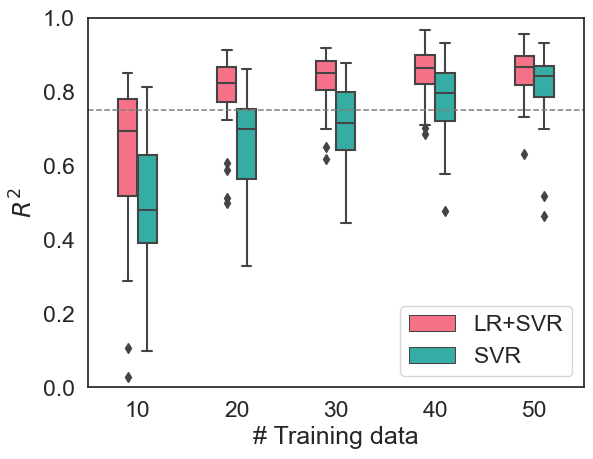

In [50]:
DAMCLA_LR = ComparisonResultsPlot([complexSVRR2Lists_DAMCLA_LR, SVRR2Lists_DAMCLA_LR], 'LR', 'SVR', position = 'lower right', \
                              xname = '# Training data', yname = '$R^2$', show = 1, \
                              ylimit = [0, 1], yline = 0.75)

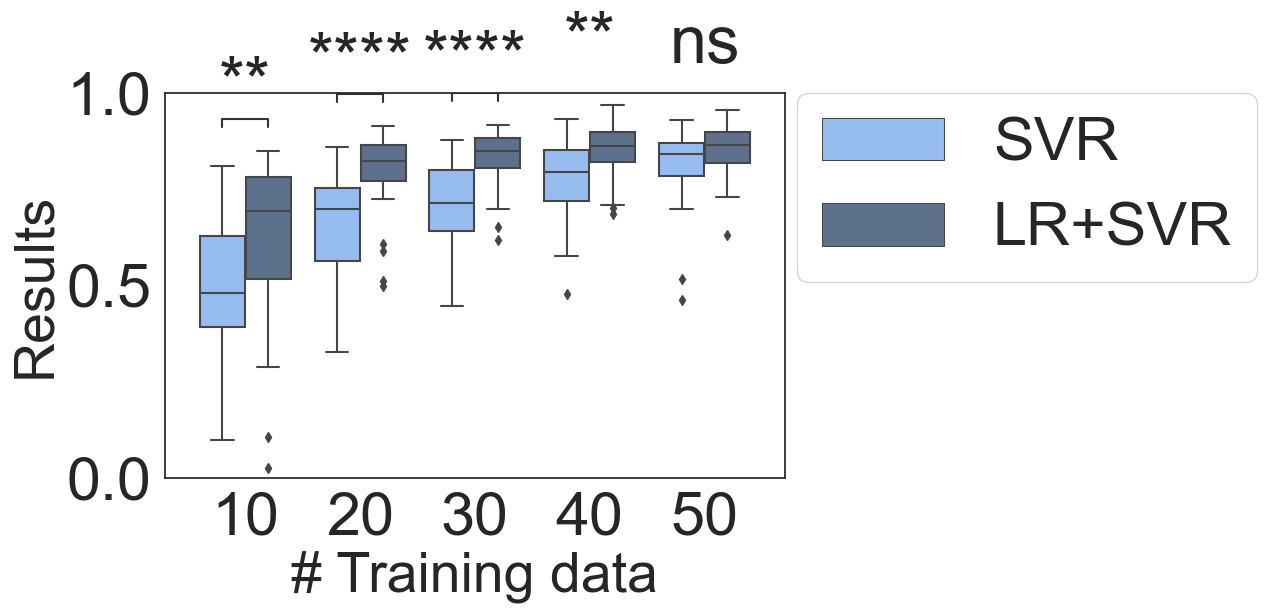

In [51]:
statsPlot(DAMCLA_LR, 'LR', 'SVR')

In [ ]:
# storeCorrelations([complexSVRSpearmanLists_DAMCLA_LR, complexSVRPearsonLists_DAMCLA_LR,\
#                    complexSVRR2Lists_DAMCLA_LR, complexSVRMSELists_DAMCLA_LR], 'SF3_DAMCLA_LR_Corr.xlsx')

# storeCorrelations([SVRSpearmanLists_DAMCLA_LR, SVRPearsonLists_DAMCLA_LR,\
#                    SVRR2Lists_DAMCLA_LR, SVRMSELists_DAMCLA_LR], 'SF3_DAMCLA_Corr.xlsx')

# storeRawData([complexPredictedSVRSpearmanLists_DAMCLA_LR, complexPredictedSVRPearsonLists_DAMCLA_LR,\
#              complexPredictedSVRR2Lists_DAMCLA_LR, complexPredictedSVRMSELists_DAMCLA_LR], \
#              'SF3_DAMCLA_LR_Raw.xlsx')

# storeRawData([PredictedSVRSpearmanLists_DAMCLA_LR, PredictedSVRPearsonLists_DAMCLA_LR,\
#              PredictedSVRR2Lists_DAMCLA_LR, PredictedSVRMSELists_DAMCLA_LR], 'SF3_DAMCLA_Raw.xlsx')

# storeWeight([r2Recorder_DAMCLA_LR, mseRecorder_DAMCLA_LR, \
#              pearsonRecorder_DAMCLA_LR, spearmanRecorder_DAMCLA_LR],\
#             'SF3_DAMCLA_LR_Weight.xlsx')

# storeSVCSVRModel([r2Recorder_DAMCLA_LR, mseRecorder_DAMCLA_LR, \
#                   pearsonRecorder_DAMCLA_LR, spearmanRecorder_DAMCLA_LR],\
#                  'SF3_DAMCLA_LR')
# storeSVRModel([SVRr2Recorder_DAMCLA_LR, SVRmseRecorder_DAMCLA_LR, \
#                SVRpearsonRecorder_DAMCLA_LR, SVRspearmanRecorder_DAMCLA_LR],\
#               'SF3_DAMCLA_LR')
# storeScalerModel([scXRecorder_DAMCLA_LR, scDensityRecorder_DAMCLA_LR, \
#                   scDistanceRecorder_DAMCLA_LR], 'SF3_DAMCLA_LR')

# storeIndex(indexRecorder_DAMCLA_LR, 'SF3_DAMCLA_LR_TrainingIndices.xlsx')

# storeDataframes([TrainXDFRecorder_DAMCLA_LR, TrainYDFRecorder_DAMCLA_LR, \
# SVMSVRFullXDFRecorder_DAMCLA_LR, SVMSVRFullYDFRecorder_DAMCLA_LR], 'SF3_DAMCLA_LR')

In [57]:
complexSVRSpearmanLists_DAHBSUL_LR, complexSVRPearsonLists_DAHBSUL_LR, \
complexSVRR2Lists_DAHBSUL_LR, complexSVRMSELists_DAHBSUL_LR, \
complexPredictedSVRSpearmanLists_DAHBSUL_LR, complexPredictedSVRPearsonLists_DAHBSUL_LR, \
complexPredictedSVRR2Lists_DAHBSUL_LR, complexPredictedSVRMSELists_DAHBSUL_LR, \
r2Recorder_DAHBSUL_LR, mseRecorder_DAHBSUL_LR, pearsonRecorder_DAHBSUL_LR, spearmanRecorder_DAHBSUL_LR, \
SVRSpearmanLists_DAHBSUL_LR, SVRPearsonLists_DAHBSUL_LR, SVRR2Lists_DAHBSUL_LR, SVRMSELists_DAHBSUL_LR, \
PredictedSVRSpearmanLists_DAHBSUL_LR, PredictedSVRPearsonLists_DAHBSUL_LR, \
PredictedSVRR2Lists_DAHBSUL_LR, PredictedSVRMSELists_DAHBSUL_LR, \
SVRr2Recorder_DAHBSUL_LR, SVRmseRecorder_DAHBSUL_LR, SVRpearsonRecorder_DAHBSUL_LR, SVRspearmanRecorder_DAHBSUL_LR,\
indexRecorder_DAHBSUL_LR, TrainXDFRecorder_DAHBSUL_LR, TrainYDFRecorder_DAHBSUL_LR, \
SVMSVRFullXDFRecorder_DAHBSUL_LR, SVMSVRFullYDFRecorder_DAHBSUL_LR, scXRecorder_DAHBSUL_LR, \
scDensityRecorder_DAHBSUL_LR, scDistanceRecorder_DAHBSUL_LR = \
ComparisonMultipleRun(30, 'HelenaExpDAHBSUL.xlsx', 3, 'Sheet1', [10, 20, 30, 40, 50], 0, ['poly'],\
                     0.4) #, 'sigmoid', 'rbf'

10


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without f

SVM:  [0.4530730234593061, 0.057833022623826204, 0.8494453949029915, 0.9002629965215835]
SVR:  [0.18197314205131798, 12.163381484658974, 0.4265831009912584, 0.8109594228138933]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8512332471749331, 0.22344449834551577, 0.8884544651404391, 0.9077207380442277]
SVR:  [0.7340409737809104, 0.16114404982808792, 0.8567619119574065, 0.907506718971834]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.90530627 -0.59334948 -2.82403305         nan -2.68992948         nan
  0.31017409 -2.6398061  -2.76785733  0.13271326]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.38637371 -0.70047565         nan -0.60993674 -2.81373212 -2.68719969
 -0.41260773  0.31441044 -1.1410233  -2.56801223]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.4997079   0.26097203 -2.82973211 -0.59700434         nan -0.6971161
         nan -2.80729388 -2.47356959 -8.05834339]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One

SVM:  [0.6348893217029529, 0.037136850620569824, 0.8047708343064996, 0.908560351328234]
SVR:  [0.6833031215123282, 1.9178042262159263, 0.8266215104340846, 0.9283077265079509]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.51165644         nan -4.28202023         nan -0.75887488 -0.56970114
         nan -3.6263726          nan         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan -0.51113561 -0.78663283 -0.92385646         nan
 -2.01505137 -0.50259841         nan -0.51218241]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -2.00723802 -0.49532312 -0.42954156 -0.5112646   0.02128716
  0.08880708 -0.51928683 -0.35659878         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: On

SVM:  [0.8116260993207822, 0.061835197886021286, 0.8639974706429694, 0.9024570934683294]
SVR:  [0.6911651573275183, 0.06531742504127637, 0.8313634327582122, 0.894209161624892]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.64122278  0.42303739         nan -0.16565207  0.11200602  0.6397999
  0.62308026 -0.53879963 -0.01652149  0.12202665]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.52360838  0.6416626   0.53853619  0.53644926 -0.01463212  0.53853619
 -0.58728708 -0.49479089         nan         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-5.91328117e-01 -7.42926993e+00  7.75364733e-01 -2.56376609e+03
 -2.25028193e+00             nan  6.78158859e-01             nan
  7.49102993e-01  6.76341318e-01]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_s

SVM:  [0.8299721513745099, 0.05962784299911021, 0.9345150570587998, 0.8975712951110927]
SVR:  [0.6359328348393379, 0.09737794853446538, 0.7974539703577493, 0.8061439936850335]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6721504610436063, 0.2670766818062345, 0.7970159740256555, 0.8113874609586808]
SVR:  [0.6480960841391018, 0.1021981232727678, 0.805044150428473, 0.8619700455686685]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-109.95250343  -13.64125216   -1.71690804 -116.53653716 -112.80610682
           nan -115.71469905           nan -114.03724057           nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  -3.27750492   -3.41142302 -117.08205822   -1.8345052    -1.75734825
           nan   -3.42177943   -1.71336928  -25.21842039   -1.53482349]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -92.92625477   -1.74045837  -16.86836749 -106.20583818           nan
   -2.83614534  -13.12090084  -16.86836749 -117.09651589 -102.38795513]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-pack

SVM:  [0.054866817019016016, 0.09677386081957681, 0.8429873047048199, 0.9016952780060647]
SVR:  [0.752914626077701, 0.09707157702450052, 0.86770653223178, 0.8924019113625048]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-4.56658574  0.82179589  0.5478553   0.82756662 -4.26039807  0.81348686
 -4.11915787 -4.54672426 -4.56866379         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-6.70873374         nan  0.82790558  0.81331334  0.78603517  0.78030467
 -0.93932802 -0.94148216         nan -3.76481151]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -4.38953096 -4.13417121 -4.54898782         nan -8.9359962
         nan         nan -4.22781835         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, b

SVM:  [0.7094643071797242, 0.07488595478388824, 0.35891442174925786, 0.8910437134030829]
SVR:  [0.6876340816099591, 0.2689863452189871, 0.8292370479000317, 0.8540348768845304]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without f

SVM:  [0.7080186331880719, 0.08155436782936368, 0.8844591538600874, 0.8788117002655008]
SVR:  [0.6369079049269588, 0.09139314184097107, 0.7980651006822433, 0.849639254397674]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.803445129661127, 0.09386300878749446, 0.8507640821003313, 0.9078606735915621]
SVR:  [0.6296627030093679, 0.13713780346204094, 0.7935128877399327, 0.7879935300454857]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1281.91110173   -16.45306951            nan   -23.71768765
   -16.45306951  -299.66247169  -163.70858055   -16.4253177
            nan    -7.15930245]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [          nan -167.66136082  -16.42710407           nan  -13.18332618
           nan           nan           nan -129.3934297   -14.23556401]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [  

SVM:  [0.5022660449992575, 0.2761369147568925, 0.869043797046815, 0.8417205487191046]
SVR:  [0.736872933973274, 0.09060622772843493, 0.858413032271338, 0.8855450695431201]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan  0.29900147         nan         nan  0.34777907         nan
  0.18649726 -0.37626148 -0.41993972 -0.39082265]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.42531732 -0.41851761         nan -0.37621123 -0.11444923 -0.12137415
         nan  0.35452852 -0.12207043 -0.28562069]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_te

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5121810772933519, 0.21094809135320985, 0.8644176243519188, 0.39828126222201027]
SVR:  [0.4214687136806478, 0.2748786862933173, 0.6492062181469361, 0.7136712914053589]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.08945090e+01 -2.71164539e+00 -7.81828732e+04 -1.99243679e+00
             nan -8.32460776e-01 -2.86452615e+00 -2.00737377e+00
 -1.12355776e+00             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.97535742         nan -9.362085    0.53174056         nan         nan
 -7.96642129 -1.87299812 -1.25775613 -0.05354151]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-1.71746012 -6.97990679         nan         nan -0.74990324  0.56819171
 -1.46740923  0.68960325 -0.23288064         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_

SVM:  [0.696298083870466, 0.04241085463613298, 0.9180408600033869, 0.8541665809290804]
SVR:  [0.7333491926138592, 0.07518861884017886, 0.8563580983524701, 0.8882532339591795]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.795137066801218, 0.10078816474151776, 0.3791844797892346, 0.8047446382116897]
SVR:  [0.7201424506836249, 0.11478597848100812, 0.8486120731427438, 0.8967810708437927]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.1638402837236116, 0.4626492335884224, 0.930031095570531, 0.9252209129638101]
SVR:  [0.8434307987383075, 0.030497014250846066, 0.9183848859483191, 0.9297729340035699]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7560402830814861, 0.30967674657449307, 0.8248861565131913, 0.7925208565768921]
SVR:  [0.7974857123891503, 0.03944538743784628, 0.8930205554124445, 0.912593787692578]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.38058347231204953, 0.8439402669312498, 0.8336462949026247, 0.6875115755566135]
SVR:  [0.7301418819909908, 0.05600211667236125, 0.8544834006526933, 0.850758738776349]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without f

SVM:  [0.7291277445288561, 0.06492383444160563, 0.7521448756134641, 0.756793019714368]
SVR:  [0.7313264703626478, 0.060916895770595184, 0.8551762802853267, 0.9058484586574473]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan  0.14267959 -0.16733306         nan -1.46108342  0.65957426
  0.14267959 -3.59291585 -1.46012025 -1.77867324]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -0.89639977 -3.54736822  0.73229138 -0.73758009  0.73184055
 -3.58908816  0.1428831  -3.56295184  0.09847121]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.14601701  0.14602632  0.17626914  0.14295924 -3.5

SVM:  [0.23541156740870625, 0.3523656576211082, 0.9468589979267893, 0.887623986500391]
SVR:  [0.7455323881352147, 0.12781081146386572, 0.8634421741698829, 0.9048277565131497]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7424799917612428, 0.13154568044319734, 0.8561736442856962, 0.8929122645351362]
SVR:  [0.7423999867468751, 0.13096874134570233, 0.8616263614507595, 0.9044034424221243]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-241.31195301   -1.09651429   -0.61285402           nan           nan
   -0.88866474           nan   -1.77976356   -0.90821253 -231.7263086 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan -0.40363728 -4.58554923         nan -2.0826312  -8.24374219
 -0.16269962 -1.79497399 -0.59982795 -1.79497399]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.01404671 -3.32568495         nan -0.28894151 -1.65470452  0.10652609
 -1.86870293         nan         nan -2.28753023]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:

SVM:  [0.6129011663384779, 0.07782523217923173, 0.762091298500605, 0.808190311561098]
SVR:  [0.26161659788188996, 1.1986460753167436, 0.5114846995579535, 0.40390994773017236]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ 0.6997511   0.75313945         nan  0.07175355 -0.27908112         nan
 -0.39024348 -0.74237327  0.60667371 -0.3761611 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan  0.20106661  0.50500774 -0.39883548  0.60865431
 -0.39889355         nan         nan -0.39865126]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-0.74259723  0.62982788  0.62982788  0.64289482         nan  0.1828408
 -0.00697719         nan  0.57269827 -0.37938435]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One

SVM:  [0.2694629074121148, 0.04375681450963116, 0.7381732443811748, 0.8920150307316391]
SVR:  [0.6982222754174565, 0.17613580378931087, 0.8355969575204643, 0.8590560935829997]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [ -4031.44465447 -17440.76193303 -49678.17542833 -24948.04663519
  -4728.00671041 -23710.82209046 -10170.97162916             nan
 -25953.64562883 -27312.17047305]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-25470.64732566 -27530.43541045             nan -48461.33144844
 -27264.46928779 -26208.40149392             nan -27475.69488314
 -17188.09501292             nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8515787663569807, 0.451983948042607, 0.9297854361189832, 0.8996867913266772]
SVR:  [0.7312379927532512, 0.06509197514019605, 0.8551245480941656, 0.9068317357435152]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7389956517234385, 0.0647066648563015, 0.8571312198415264, 0.9044161830678683]
SVR:  [0.63313976260436, 0.13292600184250913, 0.7957007996755816, 0.854698110877886]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without f

SVM:  [0.7561162961691192, 0.08434069653202177, 0.8726902843961988, 0.8761364618605789]
SVR:  [0.6893615931372453, 0.08432825598692584, 0.8302780215911086, 0.8207878371384377]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6863077494616997, 0.07105577406627125, 0.8284349772062296, 0.8831579337356512]
SVR:  [0.2771691903279087, 6.556658046133356, 0.5264686033638747, 0.6634755874262369]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan -34.35433855 -34.78928992          nan -16.72226566
          nan -32.32516889 -25.13108672 -20.54090734 -34.39359497]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-34.38038129 -20.06810509 -35.44240371 -36.06136896 -39.51447508
          nan -34.07741181          nan -34.34111834          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [-14.35239379 -34.89079918 -39.01

SVM:  [0.5509540735635065, 0.23169409997727206, 0.7657321526511676, 0.7481036675524017]
SVR:  [0.4817121830087486, 0.27162197081698625, 0.694054884723643, 0.756590346923093]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
 -0.66153761         nan -5.93870576         nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan -5.66053026         nan -5.6552152 ]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [         nan          nan  -1.84597959  -6.55104937          nan
          nan -10.13686794          nan          nan          nan]
  category=UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:972: UserW

SVM:  [0.19807649924153947, 0.4749103898192628, 0.7900146679540032, 0.5214080808706995]
SVR:  [0.15341732637336777, 0.4764455320390749, 0.39168523890155454, 0.8066499329717781]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.787235578391143, 0.056976420003703065, 0.887262970258053, 0.9000489774491895]
SVR:  [0.7312181807177658, 0.055552336695540806, 0.855112963717523, 0.9225786005700255]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5091244247434663, 0.06243990303989507, 0.6941993963095207, 0.9002712280243679]
SVR:  [0.14594506643692695, 7.992210696330562, 0.3820275728752135, 0.6995460326273704]
20


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7341745791251828, 0.05593461693274378, 0.9000978106816867, 0.8916132888883114]
SVR:  [0.729467311674042, 0.06258504335630183, 0.8540885853786142, 0.8977549095026962]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7824203807975341, 0.10275686089391078, 0.8695184373189797, 0.9240506329113924]
SVR:  [0.5976919495625825, 0.3130834924099139, 0.7731053935671276, 0.8057196436943272]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7643065971992586, 0.024736796779813996, 0.9450191317048103, 0.8840834505391468]
SVR:  [0.8130973189692743, 0.04269243341793152, 0.9017190909420043, 0.8281997187060478]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8484287372815804, 0.04668354036379076, 0.8925610323251929, 0.8447306887785044]
SVR:  [0.7351854340339788, 0.06855461108662117, 0.8574295504786266, 0.9013648697111512]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6707981564236207, 0.07343643805764644, 0.8415796194630443, 0.8858180965775904]
SVR:  [0.7161312676934132, 0.08102911976892799, 0.8462453944887461, 0.9115799343647446]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7581771157758757, 0.05048702748366296, 0.8580662488240208, 0.9117962482355834]
SVR:  [0.7346566764189688, 0.06117716893271206, 0.8571211562077845, 0.8506730583424224]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7769735415397854, 0.07617903350283237, 0.8378883499152272, 0.7339428035630567]
SVR:  [0.7421820224151514, 0.20753172347117035, 0.861499867913601, 0.9081340834505391]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7317071987187631, 0.0873976653835709, 0.8731874592026487, 0.7757781046670055]
SVR:  [0.5655434587621364, 0.1407721608375804, 0.752026235421436, 0.7860102321409708]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.795747707985151, 0.06548018363487378, 0.8444306747372983, 0.8691565234357137]
SVR:  [0.7150309416558733, 0.19441263901486727, 0.845595022251121, 0.8939691395438292]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7698083111999834, 0.0724181698932452, 0.877852480985905, 0.8925691514299109]
SVR:  [0.7590444281185437, 0.08384406396242529, 0.8712315582659664, 0.8812939521800283]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7429100974280369, 0.03198218916051475, 0.6149303653507981, 0.8794421003281764]
SVR:  [0.01261008165751603, 0.22091821315867793, 0.11229461989568337, 0.14871073605250823]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9142027333424977, 0.045796957602272266, 0.8587804601883136, 0.8480124707861907]
SVR:  [0.7210564409611648, 0.08858114295840541, 0.8491504230471567, 0.8875110613787033]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7869719798675079, 0.027847333305438548, 0.8039359061626555, 0.920762545506584]
SVR:  [0.747146387838892, 0.16481973927348198, 0.86437629990583, 0.9089832922289949]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8197203788443186, 0.05269486862239594, 0.881513952454531, 0.9181840025005445]
SVR:  [0.7613390572200096, 0.07478553232320877, 0.8725474527038684, 0.9188403589020818]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7105645992927768, 0.05842998469708063, 0.8429513379734788, 0.9111814345991561]
SVR:  [0.709529465533714, 0.05755023379648503, 0.8423357202052604, 0.9109235818096579]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5636605538978299, 0.07437663594050772, 0.9028979021260624, 0.901306266461014]
SVR:  [0.8523885135209004, 0.03750095704571047, 0.9232488903437138, 0.9090770574292146]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6373579604879703, 0.06482222272694638, 0.9128964574990799, 0.7132484367705503]
SVR:  [0.6183122079088005, 0.38452917288950383, 0.7863283079660817, 0.8105649939484824]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.581362559000549, 0.042670521667399895, 0.886667780057248, 0.8913502109704641]
SVR:  [0.5420865600210913, 0.09884768609998382, 0.7362652782938301, 0.7513830285982186]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7347245156519484, 0.07046425749927591, 0.8571602703394622, 0.8780759381066046]
SVR:  [0.1477999747026, 0.4426133458627494, 0.3844476228338525, 0.6782974583886892]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7355158258809931, 0.03972501527725553, 0.8591555848921905, 0.8954758556024379]
SVR:  [0.7389158392225228, 0.08543048070514589, 0.8596021400755838, 0.9103375527426161]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7221465187230912, 0.03184141513206818, 0.9373313784442138, 0.9131973745897798]
SVR:  [0.8293217864694956, 0.03484611082772711, 0.9106710638147545, 0.9185654008438819]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8618007254941099, 0.45204085645178316, 0.45456309110767523, 0.8876868711291152]
SVR:  [0.8389090992298526, 0.03146847841874149, 0.9159198104800724, 0.8753333060001809]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8243044482866795, 0.1309077800776719, 0.8777466175392091, 0.8256446319737459]
SVR:  [0.8272125908617908, 0.4560790474217239, 0.909512281864182, 0.8309892170651665]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9136012440410187, 0.057092789438006754, 0.846318057691485, 0.9251109066667687]
SVR:  [0.726129182211685, 0.0561539974138056, 0.852132138938372, 0.896453917349649]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.5697740514483807, 0.029309930323449047, 0.8739749773169553, 0.9132847707890697]
SVR:  [0.6798046790487398, 0.07380511732197255, 0.8245026858954065, 0.8967234923002803]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8897912242873879, 0.07018521021194776, 0.8541371474322286, 0.8395736027664256]
SVR:  [0.5468879514787545, 0.0948468023408065, 0.739518729633506, 0.8042241222836309]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7165931239527588, 0.048126127704221755, 0.8705092932602458, 0.8510548523206751]
SVR:  [0.7633288873245082, 0.04686759613893034, 0.8736869504144537, 0.8888420065635255]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7174164291312276, 0.08216325923304801, 0.8470043855442708, 0.926189206469294]
SVR:  [0.7179790502980591, 0.08163730340575764, 0.8473364445709031, 0.9259079108686353]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7541511215112239, 0.0419195468160128, 0.8016531306395878, 0.9126635763376149]
SVR:  [0.6409853909092817, 0.07491385560195678, 0.8006156324412368, 0.8597096795135877]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8996698621810479, 0.03278689584890733, 0.9220455659489848, 0.8849507735583686]
SVR:  [0.7529935082011447, 0.04832828102090401, 0.8677519854204565, 0.9174636661978435]
30


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.849216654598054, 0.033138325751520946, 0.9013337157631135, 0.9051605735677792]
SVR:  [0.6856780638118102, 0.07043473176643476, 0.8280567998705222, 0.7796761410161089]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.711759086404481, 0.03806876589352167, 0.27679462736232285, 0.9079345639051701]
SVR:  [0.7163660514408625, 0.06372757349046584, 0.8463841039627713, 0.9157379056950398]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7292175657114112, 0.05791172977478167, 0.9013536220006739, 0.9090797750306312]
SVR:  [0.9121020702364002, 0.020266020608017875, 0.9550403500566873, 0.9073826208257354]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7724043773118221, 0.027478298632339786, 0.9550972731982439, 0.9262612743008125]
SVR:  [0.8284516446610342, 0.049657999588622825, 0.9101931908452368, 0.9401534437718144]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7423881112073789, 0.016177053901197832, 0.8616161745955057, 0.9062549208293238]
SVR:  [0.7423476095829008, 0.05828290931961085, 0.8615959665544521, 0.9062549208293238]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7637880020977862, 0.05007778305910949, 0.8790433102205741, 0.9120286939025456]
SVR:  [0.7536132123102641, 0.06453722174454775, 0.8681089864240917, 0.8957571516052839]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8175154041357612, 0.10236913196794147, 0.9022077109352789, 0.8919779546846295]
SVR:  [0.7818777763147702, 0.04831248701882444, 0.8842385290829446, 0.8929927390429533]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7788601847429124, 0.020923430762414572, 0.9670894627524751, 0.9237592840812239]
SVR:  [0.7816470359625428, 0.04637927072137707, 0.8841080454121786, 0.9331373732959053]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.932756753691515, 0.016411335565849255, 0.9643259184106928, 0.9379231913218441]
SVR:  [0.8841750826257043, 0.022996754084313904, 0.9403058452576502, 0.9078295862129299]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7778641258383547, 0.13041709199590498, 0.8620858635743625, 0.8661085304200759]
SVR:  [0.7655116743588931, 0.21237320830962278, 0.8749352400943131, 0.8985294246641146]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7918239865309028, 0.02072857934513905, 0.7659359383422735, 0.9209248615946971]
SVR:  [0.6679514673171557, 0.07613067457073104, 0.8172829787271702, 0.8187456805989143]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8391036867627343, 0.03527425766115443, 0.8683166411524819, 0.8915230513515877]
SVR:  [0.9036815676998595, 0.021216884488349824, 0.9506216743267851, 0.9066398390342051]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7667098148849933, 0.05584902930526806, 0.8649776670089623, 0.9012238756698252]
SVR:  [0.6610280089279776, 0.0782505308651024, 0.8130362900436724, 0.8359796691744016]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.584244523753862, 0.019065815497554806, 0.9753835786424297, 0.9313352404803976]
SVR:  [0.7196411883064373, 0.06533331911104545, 0.8483166792574786, 0.9033584407522715]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8818585251616134, 0.02931587668600546, 0.6997483787289754, 0.8590149593211441]
SVR:  [0.7596341732882769, 0.05677017567562271, 0.8715699474444243, 0.9218965969731432]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8286053700358416, 0.0357216502240568, 0.8687556393876199, 0.8780859067448167]
SVR:  [0.7570884059240272, 0.050699104774154145, 0.8701082725293601, 0.9128685154404689]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8811286030110539, 0.06552047079662802, 0.8319309433530204, 0.9109518935865472]
SVR:  [0.7492220274475707, 0.04712333688381154, 0.8655761245826796, 0.851236560583361]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9305278337639604, 0.0685686288025819, 0.8323080208162488, 0.913708336978392]
SVR:  [0.6922580326757766, 0.06908476053550669, 0.8320204520778177, 0.913708336978392]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9215831822613421, 0.03682605297658347, 0.9564378272529123, 0.9255964097669357]
SVR:  [0.6530450835599594, 0.24316918424716175, 0.808112048889236, 0.8529337147882567]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8805802894812236, 0.06173834624417536, 0.9318114040194251, 0.9146531362085557]
SVR:  [0.721990193551781, 0.06175596396419772, 0.8497000609343162, 0.8983466013472138]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8883710395078759, 0.05874853604436446, 0.8726003265291244, 0.9028256495494709]
SVR:  [0.8643305462087902, 0.035951974058491036, 0.9296937916372197, 0.9223515003061851]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7815385400262669, 0.04672301761767349, 0.8801683162535454, 0.8589874813335547]
SVR:  [0.7944432815331552, 0.041896498550896576, 0.8913154781182454, 0.8018966135956713]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9193509344182392, 0.05197958636774728, 0.8820212253434718, 0.8242570576560497]
SVR:  [0.837564701271632, 0.03763702515630071, 0.9151856102844014, 0.8837974263082159]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7319242429351662, 0.051400943248013774, 0.8877558856764439, 0.9057379559261457]
SVR:  [0.7310067226534589, 0.05661226815037977, 0.8549893114264404, 0.9057379559261457]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7322760416129427, 0.01763521729244141, 0.9563233318401221, 0.8909631703263058]
SVR:  [0.7322807083990144, 0.06919434063273812, 0.8557340173202266, 0.8961070772460853]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.882568675697939, 0.02616693883881672, 0.8689550536878567, 0.9006911031405826]
SVR:  [0.7552661675371295, 0.054084271329711164, 0.8690605085591736, 0.9016359023707462]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6706856323481306, 0.07253215322769352, 0.827592564713796, 0.8037617006386142]
SVR:  [0.37980551385453687, 0.22180609927016529, 0.6162836310129751, 0.7965532324381068]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7838100728540194, 0.0498319696693091, 0.846089910886895, 0.9074526065661435]
SVR:  [0.7114307285285079, 0.06935801972449396, 0.8434635312380184, 0.8859494878257639]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8060785948804119, 0.04459861452830595, 0.840689424610799, 0.8865093737490284]
SVR:  [0.7158182082327956, 0.10839131741467929, 0.8460604046005201, 0.8717248860878236]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7667430227352651, 0.05393096438686059, 0.9110831579055161, 0.8961770623742455]
SVR:  [0.7873028582266831, 0.05402772899668412, 0.8873008837066956, 0.9413174700376169]
40


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8064167878416496, 0.046083403140573374, 0.7816352151443451, 0.9036398999722146]
SVR:  [0.7888738758976848, 0.14381886087163165, 0.8881857215119393, 0.9059183106418451]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8883766225978202, 0.023813635380371727, 0.9087681791050306, 0.8480689080300086]
SVR:  [0.9024009919506597, 0.018823176254060995, 0.9499478890711112, 0.929369269241456]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9118521664107151, 0.013677950096047381, 0.8979076244896194, 0.9307029730480691]
SVR:  [0.8520090839666327, 0.029635733733136372, 0.9230433814109893, 0.8513475965545987]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8593226188195017, 0.015445494361474502, 0.9795772712253423, 0.8963601000277857]
SVR:  [0.8134247973464195, 0.0375880878655243, 0.9019006582470268, 0.8951931091969992]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8768209973820651, 0.028746109772259873, 0.9390473712233506, 0.9224912822685514]
SVR:  [0.7025505873718109, 0.06059951892795539, 0.8381829080647082, 0.9046249601450972]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7634604797817043, 0.030902831481291464, 0.8763096078683577, 0.9124201166990832]
SVR:  [0.7508244228859208, 0.07390320913500532, 0.8665012538282454, 0.9036398999722146]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7384992652373795, 0.029918575516922005, 0.9192226897092981, 0.8447346485134761]
SVR:  [0.8720441099043842, 0.02465457179962483, 0.9338330203544867, 0.9633787163100863]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9391985503933344, 0.05632229612880467, 0.9585805532001115, 0.9224784662406227]
SVR:  [0.7254453759074239, 0.058623825735837194, 0.8517308118809749, 0.9013059183106419]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9348634320359598, 0.01313162399472943, 0.8679372607396529, 0.8190052792442346]
SVR:  [0.8805163666318175, 0.02590048895819833, 0.9383583359419881, 0.8943595443178662]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9113891786273995, 0.06105266036244519, 0.9035903843450914, 0.9242567379827731]
SVR:  [0.8544297652984985, 0.03837994947258653, 0.9243537014035798, 0.9052514587385387]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8927296577031133, 0.026540884807558167, 0.9626535120551766, 0.9448735759933318]
SVR:  [0.8661937263564413, 0.029771604499712032, 0.9306952918954954, 0.9423728813559324]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8586231573859293, 0.04469684304355284, 0.8585758320217658, 0.8965823839955543]
SVR:  [0.7214916831710139, 0.07027636309133208, 0.8494066653676631, 0.8854126146151711]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8820040903754436, 0.046550982225168076, 0.9564757137702828, 0.8733537093637121]
SVR:  [0.8041323164807157, 0.047265263532809056, 0.8967342507569992, 0.9057515976660185]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8400162188690911, 0.0633442847339069, 0.9446842535650732, 0.9215893303695473]
SVR:  [0.7067379476265778, 0.06332232897624522, 0.8406770769008625, 0.9215893303695473]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7583211646351717, 0.026640662294621854, 0.9346034879034957, 0.9141983884412339]
SVR:  [0.7723703060626673, 0.043977869670189206, 0.8788460081622191, 0.8968046679633234]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8475042805579873, 0.08306105924296528, 0.9508388850559436, 0.8072797999444292]
SVR:  [0.6750524572119476, 0.08298902554469985, 0.821615760080068, 0.8846901917199224]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7559432026496603, 0.017052720489949158, 0.8694499425784443, 0.8718532925812728]
SVR:  [0.6840679492996237, 0.06854073597539502, 0.8270840037744798, 0.8816893581550432]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7867557784290501, 0.02579186550107955, 0.8868583689685579, 0.9119755487635456]
SVR:  [0.7524253189692522, 0.053163412665210984, 0.8674245321463144, 0.9141428174492916]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8986482659309628, 0.05083582024757435, 0.9386645316905164, 0.9212003334259518]
SVR:  [0.8284713324249285, 0.03373343454740615, 0.9102040059376411, 0.8800777993887192]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8754688409486951, 0.023538691035691277, 0.9702539391994408, 0.9137538205056962]
SVR:  [0.7612628888591236, 0.05578280448983221, 0.872503804495501, 0.9154765212559046]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8500158722291736, 0.010882219083370857, 0.9611823387336556, 0.904251180883579]
SVR:  [0.876282556312793, 0.027937955335127093, 0.9360996508453536, 0.9105307029730484]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9525266439942925, 0.009614110840680609, 0.9311273400679854, 0.8758544040011116]
SVR:  [0.7104102427043623, 0.05907638314931738, 0.8428583764217819, 0.8730758544040013]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9189732235723592, 0.06034398096078126, 0.9595393993354608, 0.9257571547652129]
SVR:  [0.7394734222496855, 0.060725650687375635, 0.8599264051357447, 0.8766879688802447]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9056337786020151, 0.029228003912360398, 0.9548493114673335, 0.943651014170603]
SVR:  [0.8793608128179623, 0.02390089563089981, 0.9377424021648814, 0.8985273687135318]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8405771587541158, 0.04493340315592799, 0.9291963249450346, 0.9265351486524035]
SVR:  [0.8660858965462077, 0.03445596194257821, 0.9306373603859925, 0.930925257015838]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8196119537257127, 0.024219398273478757, 0.902129556944469, 0.9220744940386107]
SVR:  [0.7826349312422952, 0.0520020558798433, 0.8846665650075709, 0.9253532281141434]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7250680386566858, 0.02031530731305167, 0.8821773733407319, 0.9235898860794666]
SVR:  [0.7219887389495252, 0.06428634620536712, 0.8496992049834607, 0.8979160878021674]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8369761174309458, 0.018619827672100207, 0.9462553338871104, 0.844956932481245]
SVR:  [0.7743789679331627, 0.04947144882882095, 0.879988049880885, 0.8678521811614339]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7941313043797701, 0.030530282546730667, 0.9197058734255332, 0.7398268940265796]
SVR:  [0.7827746843380464, 0.044334523882650995, 0.8847455477921584, 0.8114588978123727]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7787916405262171, 0.06752380641969243, 0.83621865054062, 0.8741317032509033]
SVR:  [0.6947271723349042, 0.06451524826801897, 0.8335029528051503, 0.9130313976104476]
50


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9421189853701952, 0.009004595233018218, 0.969259620123704, 0.9309483793517406]
SVR:  [0.6996153868740289, 0.06946156523613839, 0.836430144646897, 0.853157262905162]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9324301686338347, 0.011526455726561816, 0.9506390368647697, 0.8880192076830732]
SVR:  [0.9071788798532708, 0.017362612417798042, 0.9524593848838235, 0.8792797118847538]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8153426911133947, 0.015420276089986307, 0.9013529317545687, 0.9286177341868506]
SVR:  [0.9166200729720547, 0.016763245017968324, 0.9574027746837039, 0.9362529715296838]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9542692110782323, 0.014875263777043245, 0.9483601212218866, 0.7853729983775954]
SVR:  [0.9121942217308371, 0.019872474172646717, 0.9550885936554978, 0.9013901897001434]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8905379660131704, 0.007749246198229163, 0.9686711217675784, 0.9336374549819928]
SVR:  [0.882440426475943, 0.024774330096640138, 0.9393830030801826, 0.9373829531812724]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8994548783998062, 0.020170133050297145, 0.9453284941296876, 0.9086674669867947]
SVR:  [0.8547184312080663, 0.028389533168303303, 0.9245098329428768, 0.935846338535414]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7409633670120317, 0.040726540220304745, 0.8977119866594363, 0.893109243697479]
SVR:  [0.7595148503311651, 0.05713654065452589, 0.8715014918697293, 0.9059783913565426]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8503119825745208, 0.04052781014441455, 0.9344403461174475, 0.9016566626650659]
SVR:  [0.855418657008262, 0.027753660753609202, 0.9248884565223321, 0.9170228091236493]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8238777701928862, 0.05549769242407951, 0.9408997757436218, 0.8783193277310924]
SVR:  [0.817252057322386, 0.03576299180397255, 0.9040199429893049, 0.9103001200480192]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8402462356262019, 0.04065254359891898, 0.9063518726584086, 0.9056159814370573]
SVR:  [0.8445852065572325, 0.03395307493731589, 0.9190131699585334, 0.8851112874408952]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9628210089483691, 0.019781184478117334, 0.9207695332748373, 0.92124849939976]
SVR:  [0.9347764176174995, 0.012671796895459372, 0.966838361680741, 0.9268187274909964]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9076816113448694, 0.04589209293640356, 0.9755231473813251, 0.9035030855686003]
SVR:  [0.9121521296975005, 0.01996889107162346, 0.9550665577317116, 0.914115585271532]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.809676015418701, 0.0072148204306987365, 0.9007139391371265, 0.880048019207683]
SVR:  [0.683484010297101, 0.07776890525293412, 0.8267309177096872, 0.7216806722689074]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8751605182373715, 0.02923650586305001, 0.9127972069536605, 0.923265306122449]
SVR:  [0.8403867287996069, 0.03660064992710674, 0.9167260925705158, 0.935078031212485]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8288919685410157, 0.051541453629237816, 0.8570705573921593, 0.9189435774309724]
SVR:  [0.8541829610397631, 0.032659399925010074, 0.9242201907769395, 0.9104921968787514]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9422460994399041, 0.029641922996843085, 0.8443228697914534, 0.9221349854995392]
SVR:  [0.882377019188954, 0.022727954125217224, 0.9393492530411437, 0.9457610029377402]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7440928718566369, 0.04308898700559324, 0.9220171512562975, 0.9213186393685446]
SVR:  [0.7058391387814451, 0.05689972955273209, 0.8401423324541177, 0.8939950541605438]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8792985579496777, 0.014947988242565345, 0.9541226421802628, 0.8970468187274909]
SVR:  [0.7904977811434537, 0.04983693287553998, 0.8890994214054202, 0.9054981992797119]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8770046347049807, 0.05700540157523507, 0.8556483627232896, 0.9177911164465786]
SVR:  [0.8296234000292393, 0.03330910867109082, 0.9108366483784232, 0.9225930372148858]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.773804558146928, 0.017494288912182823, 0.8899779243455226, 0.9441056422569026]
SVR:  [0.9115244130827527, 0.019353943936260797, 0.954737876635652, 0.9460264105642258]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7210717492469095, 0.016819675817000678, 0.9341469609376674, 0.9012725090036015]
SVR:  [0.8537545910642458, 0.03081271283141783, 0.9239884150054294, 0.9079951980792317]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9618300112666072, 0.02886457472692622, 0.9352065111794637, 0.8907082833133254]
SVR:  [0.8798471544708293, 0.028398280621498656, 0.938001681486141, 0.920672268907563]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.6850173072412612, 0.028503934209000405, 0.8288746462230079, 0.8936854741896758]
SVR:  [0.883600666418539, 0.020709830420884243, 0.9400003544778799, 0.9196158463385354]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8416104673465042, 0.02024891053433134, 0.90427592716339, 0.9566136044439059]
SVR:  [0.7948891778869009, 0.04149697609150715, 0.8915655768853472, 0.9260726550725729]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.923098138103158, 0.04884524902326969, 0.8340463877584849, 0.8844657863145257]
SVR:  [0.8530023501196894, 0.03235357395859454, 0.9235812634087427, 0.9204801920768306]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.9197272812619133, 0.014108612423514825, 0.8976868009623185, 0.8740666044921426]
SVR:  [0.7850547646106562, 0.04661866932811294, 0.8860331622522125, 0.899325314192333]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7303184461840019, 0.04131510358730191, 0.8868011321344048, 0.8435534213685474]
SVR:  [0.8628456317445345, 0.027862312880025452, 0.928894844287842, 0.9312364945978392]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.959861053679106, 0.021713343702545032, 0.8743571845862453, 0.9438175270108043]
SVR:  [0.7556016604544371, 0.06027680200016541, 0.8692535075882277, 0.9001200480192078]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.7851715336168354, 0.04011727740385707, 0.8916835856630833, 0.8674669867947179]
SVR:  [0.8619049587937064, 0.026762617709409246, 0.9283883663606016, 0.9158703481392556]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SV

SVM:  [0.8104363726451775, 0.053355485437774935, 0.9502345875225731, 0.9217286914765905]
SVR:  [0.8745941008113945, 0.0253285321737579, 0.9351973592838012, 0.9207683073229291]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


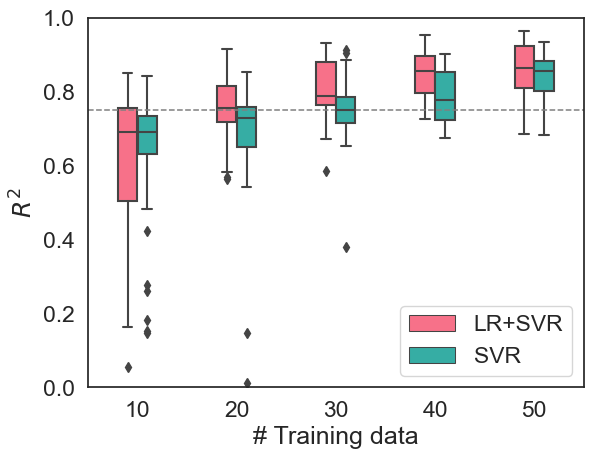

In [58]:
DAHBSUL_LR = ComparisonResultsPlot([complexSVRR2Lists_DAHBSUL_LR, SVRR2Lists_DAHBSUL_LR], 'LR', 'SVR', position = 'lower right', \
                              xname = '# Training data', yname = '$R^2$', show = 1, \
                              ylimit = [0, 1], yline = 0.75)

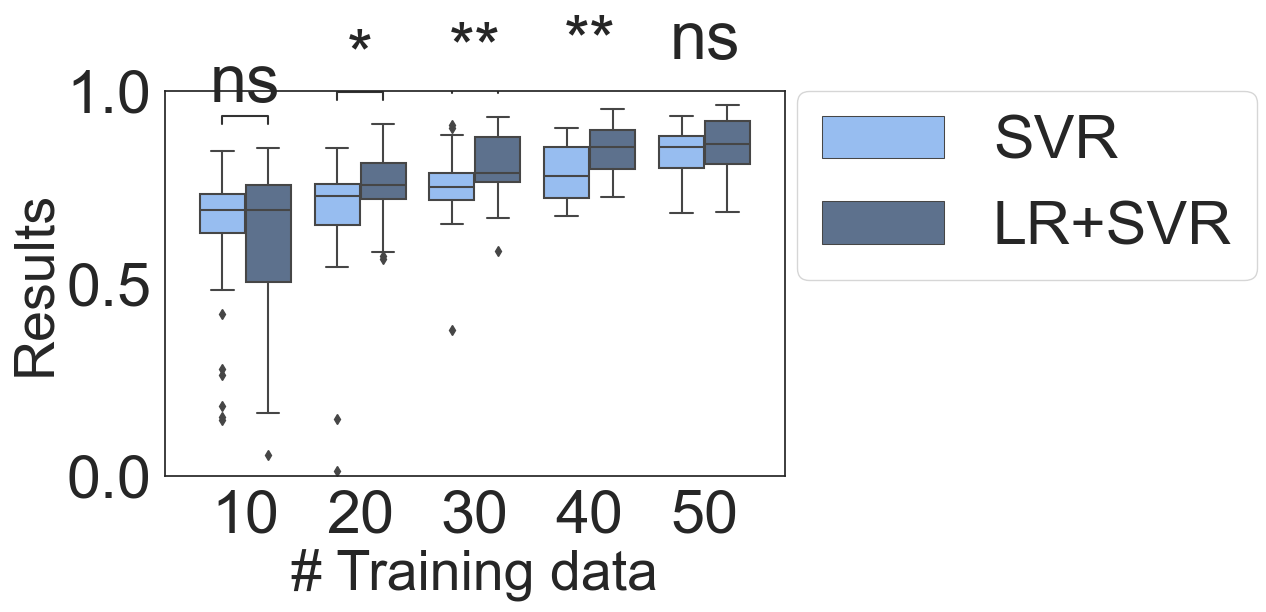

In [59]:
statsPlot(DAHBSUL_LR, 'LR', 'SVR')

In [61]:
# storeCorrelations([complexSVRSpearmanLists_DAHBSUL_LR, complexSVRPearsonLists_DAHBSUL_LR,\
#                    complexSVRR2Lists_DAHBSUL_LR, complexSVRMSELists_DAHBSUL_LR], 'SF3_DAHBSUL_LR_Corr.xlsx')

# storeCorrelations([SVRSpearmanLists_DAHBSUL_LR, SVRPearsonLists_DAHBSUL_LR,\
#                    SVRR2Lists_DAHBSUL_LR, SVRMSELists_DAHBSUL_LR], 'SF3_DAHBSUL_Corr.xlsx')

# storeRawData([complexPredictedSVRSpearmanLists_DAHBSUL_LR, complexPredictedSVRPearsonLists_DAHBSUL_LR,\
#              complexPredictedSVRR2Lists_DAHBSUL_LR, complexPredictedSVRMSELists_DAHBSUL_LR], \
#              'SF3_DAHBSUL_LR_Raw.xlsx')

# storeRawData([PredictedSVRSpearmanLists_DAHBSUL_LR, PredictedSVRPearsonLists_DAHBSUL_LR,\
#              PredictedSVRR2Lists_DAHBSUL_LR, PredictedSVRMSELists_DAHBSUL_LR], 'SF3_DAHBSUL_Raw.xlsx')

# storeWeight([r2Recorder_DAHBSUL_LR, mseRecorder_DAHBSUL_LR, \
#              pearsonRecorder_DAHBSUL_LR, spearmanRecorder_DAHBSUL_LR],\
#             'SF3_DAHBSUL_LR_Weight.xlsx')

# storeSVCSVRModel([r2Recorder_DAHBSUL_LR, mseRecorder_DAHBSUL_LR, \
#                   pearsonRecorder_DAHBSUL_LR, spearmanRecorder_DAHBSUL_LR],\
#                  'SF3_DAHBSUL_LR')
# storeSVRModel([SVRr2Recorder_DAHBSUL_LR, SVRmseRecorder_DAHBSUL_LR, \
#                SVRpearsonRecorder_DAHBSUL_LR, SVRspearmanRecorder_DAHBSUL_LR],\
#               'SF3_DAHBSUL_LR')
# storeScalerModel([scXRecorder_DAHBSUL_LR, scDensityRecorder_DAHBSUL_LR, \
#                   scDistanceRecorder_DAHBSUL_LR], 'SF3_DAHBSUL_LR')

# storeIndex(indexRecorder_DAHBSUL_LR, 'SF3_DAHBSUL_LR_TrainingIndices.xlsx')

# storeDataframes([TrainXDFRecorder_DAHBSUL_LR, TrainYDFRecorder_DAHBSUL_LR, \
# SVMSVRFullXDFRecorder_DAHBSUL_LR, SVMSVRFullYDFRecorder_DAHBSUL_LR], 'SF3_DAHBSUL_LR')

Finished storing correlations for:  SF3_DAHBSUL_LR_Corr.xlsx
Finished storing correlations for:  SF3_DAHBSUL_Corr.xlsx
Finished storing raw data for:  SF3_DAHBSUL_LR_Raw.xlsx
Finished storing raw data for:  SF3_DAHBSUL_Raw.xlsx
Finished storing weight for:  SF3_DAHBSUL_LR_Weight.xlsx
Finished storing classification and regression models for complex pipeline.
Finished storing regression models for simple pipeline.
Finished storing: SCX
Finished storing: SCDensity
Finished storing: SCDistance
Finished storing all.
Finished storing all training indices for:  SF3_DAHBSUL_LR_TrainingIndices.xlsx
Finished storing all dataframes for:  TrainX
Finished storing all dataframes for:  TrainY
Finished storing all dataframes for:  FullX
Finished storing all dataframes for:  FullY
Finished storing all dataframes


In [ ]:
# HelenaExpDABCLA, 0.3

In [52]:
complexSVRSpearmanLists_DABCLA_LR, complexSVRPearsonLists_DABCLA_LR, \
complexSVRR2Lists_DABCLA_LR, complexSVRMSELists_DABCLA_LR, \
complexPredictedSVRSpearmanLists_DABCLA_LR, complexPredictedSVRPearsonLists_DABCLA_LR, \
complexPredictedSVRR2Lists_DABCLA_LR, complexPredictedSVRMSELists_DABCLA_LR, \
r2Recorder_DABCLA_LR, mseRecorder_DABCLA_LR, pearsonRecorder_DABCLA_LR, spearmanRecorder_DABCLA_LR, \
SVRSpearmanLists_DABCLA_LR, SVRPearsonLists_DABCLA_LR, SVRR2Lists_DABCLA_LR, SVRMSELists_DABCLA_LR, \
PredictedSVRSpearmanLists_DABCLA_LR, PredictedSVRPearsonLists_DABCLA_LR, \
PredictedSVRR2Lists_DABCLA_LR, PredictedSVRMSELists_DABCLA_LR, \
SVRr2Recorder_DABCLA_LR, SVRmseRecorder_DABCLA_LR, SVRpearsonRecorder_DABCLA_LR, SVRspearmanRecorder_DABCLA_LR,\
indexRecorder_DABCLA_LR, TrainXDFRecorder_DABCLA_LR, TrainYDFRecorder_DABCLA_LR, \
SVMSVRFullXDFRecorder_DABCLA_LR, SVMSVRFullYDFRecorder_DABCLA_LR, scXRecorder_DABCLA_LR, \
scDensityRecorder_DABCLA_LR, scDistanceRecorder_DABCLA_LR = \
ComparisonMultipleRun(30, 'HelenaExpDABCLA.xlsx', 3, 'Sheet1', [10, 20, 30, 40, 50], 0, ['poly'],\
                     0.3) #, 'sigmoid', 'rbf'

10


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9763427649862929
MSE:  0.16001699450699589
Pearson:  0.9881005844479059
Spearman:  0.5
R2:  0.9894863281299662
MSE:  0.18571155461728395
Pearson:  0.9947292737875801
Spearman:  1.0
R2:  0.966648878871028
MSE:  0.1673427251096624
Pearson:  0.9831830342672865
Spearman:  0.5
R2:  0.9846069946057864
MSE:  0.1550232223880822
Pearson:  0.9922736490534181
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7570425807160277, 0.1314114103076055, 0.9423264452157175, 0.8703606643518813]
Regression:  [0.9131108827674513, 0.049741634047036985, 0.9328512563388374, 0.855245492093419]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.77584393705168
MSE:  0.004805341257155908
Pearson:  0.8808200366997108
Spearman:  0.5
R2:  0.9207983476216669
MSE:  0.004226402440020565
Pearson:  0.9595823818837377
Spearman:  0.5
R2:  0.47764011510141596
MSE:  0.007564653276748961
Pearson:  0.6911151243471785
Spearman:  0.5
R2:  0.8305008557953889
MSE:  0.01730041816419749
Pearson:  0.9113181967871534
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8465481065079076, 0.0467850592745096, 0.9421507293783631, 0.8753738352511216]
Regression:  [0.8605268058975638, 0.04464195014822132, 0.9542837912207347, 0.8080103887573644]
R2:  0.9740263114806338
MSE:  0.23370398163908557
Pearson:  0.986927713401865
Spearman:  1.0
R2:  0.9501205600444854
MSE:  0.34209588319341594
Pearson:  0.9747412785167588
Spearman:  1.0
R2:  0.923817934520119
MSE:  0.2569554898042982
Pearson:  0.9611544800499654
Spearman:  1.0
R2:  0.9640255452835297
MSE:  0.1791212209655236
Pearson:  0.9818480255536138
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9274169526801819, 0.022496585119766783, 0.9745373574066779, 0.7292359687763955]
Regression:  [0.8786310180992004, 0.07288939910554185, 0.9224286229223188, 0.7327323980400016]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9995230478813016
MSE:  0.4559966483793323
Pearson:  0.9997614954984522
Spearman:  1.0
R2:  0.958217402502014
MSE:  0.6421566040802315
Pearson:  0.9788857964553443
Spearman:  1.0
R2:  0.9760469992600119
MSE:  0.5723549074337448
Pearson:  0.9879509093371046
Spearman:  1.0
R2:  0.9929831157228928
MSE:  0.7394759064658438
Pearson:  0.9964853815901631
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6764280589188619, 0.0618189504589754, 0.9513733640642225, 0.6194151789858072]
Regression:  [0.919793143277194, 0.04040101930698902, 0.9480703965720849, 0.6716547166064367]
R2:  0.09871843225996607
MSE:  0.015838469784773726
Pearson:  0.31419489534358447
Spearman:  0.5
R2:  0.8604511201813677
MSE:  0.004727069922542305
Pearson:  0.9276050453621779
Spearman:  0.5
R2:  0.15572605718697682
MSE:  0.015425945188477426
Pearson:  0.39462140994499645
Spearman:  0.5
R2:  0.9331412506981348
MSE:  0.04021051123706989
Pearson:  0.9659923657556173
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8299900834077507, 0.04029120284785853, 0.9626842546764117, 0.26723856313516214]
Regression:  [0.5574395446053931, 0.15757486601971113, 0.7996588905969091, 0.6001245380550148]
R2:  0.9798287694288248
MSE:  0.09599369156964606
Pearson:  0.989863005384495
Spearman:  0.5
R2:  0.9999966635174936
MSE:  0.2921341034880659
Pearson:  0.9999983317573555
Spearman:  0.8660254037844387
R2:  0.77885617303003
MSE:  0.38741533498107
Pearson:  0.8825282845495834
Spearman:  0.5
R2:  0.6103199961794427
MSE:  0.3959603815775035
Pearson:  0.781229797293628
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8923095210613792, 0.20719749683346111, 0.8967635048942812, 0.698719538784705]
Regression:  [0.591788379970094, 0.31417971015698176, 0.8607042191411967, 0.5342954703784882]
R2:  0.8164315476757373
MSE:  0.19627832422558023
Pearson:  0.9035660173311839
Spearman:  1.0
R2:  0.7759656428378188
MSE:  0.1579743852938271
Pearson:  0.8808891206263243
Spearman:  1.0
R2:  0.7782841822406548
MSE:  0.09356125679999995
Pearson:  0.8822041613145194
Spearman:  1.0
R2:  0.75790559989184
MSE:  0.12275071040875717
Pearson:  0.8705777391432887
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.832118778538115, 0.07054358663685874, 0.5854135746527366, 0.8136390990530609]
Regression:  [0.7996020645784353, 0.06934750650910401, 0.8449706562982531, 0.8379647540468632]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9999522281445303
MSE:  0.038525110423148164
Pearson:  0.9999761137869896
Spearman:  1.0
R2:  0.9924188408177015
MSE:  0.006043098972656612
Pearson:  0.9962022087998509
Spearman:  1.0
R2:  0.9981877847243551
MSE:  0.010485659999999996
Pearson:  0.9990934814742589
Spearman:  1.0
R2:  0.9987920009260186
MSE:  0.01137204935057154
Pearson:  0.9993958179450316
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.723227754255245, 0.0641779631061974, 0.8611405216246601, 0.7305288757562806]
Regression:  [0.9241517461032864, 0.03776020737163924, 0.9434071577870422, 0.7591571702334698]
R2:  0.9956745612696873
MSE:  0.00636131259867399
Pearson:  0.9978349368856994
Spearman:  0.5
R2:  0.9998632074369246
MSE:  0.007070633407716034
Pearson:  0.9999316013792766
Spearman:  1.0
R2:  0.9961879966346637
MSE:  0.15220844010418075
Pearson:  0.9980921784257522
Spearman:  0.5
R2:  0.9993593855980261
MSE:  0.0038330838411268615
Pearson:  0.9996796414842235
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9210919234552677, 0.043870513549868866, 0.711549154838115, 0.8474984661158941]
Regression:  [0.8912804118693981, 0.048691246691027305, 0.9259167731824651, 0.8710723317094787]
R2:  0.9999847009163837
MSE:  0.0057747078085267495
Pearson:  0.9999923504289339
Spearman:  1.0
R2:  0.9998159973693107
MSE:  0.0019183190946502032
Pearson:  0.999907994452145
Spearman:  1.0
R2:  0.999436475916057
MSE:  0.002191299978600798
Pearson:  0.9997181982519159
Spearman:  1.0
R2:  0.9758145141116408
MSE:  0.013338634199588438
Pearson:  0.9878332420563912
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.937971507401823, 0.03623275821888202, 0.9656308726568078, 0.9031425127738663]
Regression:  [0.7394464542461134, 0.09100233458710566, 0.9253634352442829, 0.7311266837256183]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.8928038888655362
MSE:  0.03298260701399177
Pearson:  0.9448830027392474
Spearman:  1.0
R2:  0.8963380420005973
MSE:  0.3543399468148148
Pearson:  0.9467513094792094
Spearman:  1.0
R2:  0.8898697634948258
MSE:  0.11613176752839506
Pearson:  0.9433290854706146
Spearman:  0.8660254037844387
R2:  0.8974478731024153
MSE:  0.21635578436984368
Pearson:  0.9473372541510311
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8812333726514738, 0.08523994263425852, 0.7771236014288962, 0.6810586796821977]
Regression:  [0.669451487543734, 0.13387001911113555, 0.9423283312901864, 0.8153782201034678]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.7253601879987507
MSE:  0.00365308237787655
Pearson:  0.8516808017084515
Spearman:  0.5
R2:  0.15435600568382848
MSE:  0.002165382176131682
Pearson:  -0.3928816688060521
Spearman:  0.0
R2:  0.9554332770156105
MSE:  0.004165616935802443
Pearson:  0.9774626729525838
Spearman:  0.5
R2:  0.7357917867271014
MSE:  0.005714403191403758
Pearson:  0.857783065073624
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8402983417632991, 0.025156925775034287, 0.5689401599692328, 0.8332913331777774]
Regression:  [0.8488934856293258, 0.04048169559946499, 0.942743721120886, 0.7780001158654007]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9981284749353397
MSE:  0.0008310159723822468
Pearson:  0.9990637992317305
Spearman:  1.0
R2:  0.9997376650564648
MSE:  0.001342051056987659
Pearson:  0.9998688239246514
Spearman:  0.5
R2:  0.9998413366325122
MSE:  0.0044577779350288334
Pearson:  0.9999206651692487
Spearman:  1.0
R2:  0.995783270827287
MSE:  0.002127696502057608
Pearson:  0.9978894081145901
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8306723815626837, 0.05860774173942387, 0.8570009435634273, 0.6308923458033089]
Regression:  [0.5390458251720536, 0.061181271541488357, 0.9105938709785142, 0.5646998627360986]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/daal4py/sklearn/_device_offload.py", line 88, in wrapper_with_self
    return wrapper_impl(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/daal4py/sklearn/_device_offload.py", line 74, in wrapper_impl
 

R2:  0.9997771788650893
MSE:  0.01075280829062642
Pearson:  0.9998885832256956
Spearman:  1.0
R2:  0.7225818724973272
MSE:  0.015367665182617242
Pearson:  0.8500481589282616
Spearman:  0.5
R2:  0.8471690528635556
MSE:  0.007844661270781891
Pearson:  0.9204178686137918
Spearman:  1.0
R2:  0.9900797133126858
MSE:  0.019503170915226315
Pearson:  0.9950274937471255
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9606560680885664, 0.016108508042626847, 0.9852851353899765, 0.8270418956279216]
Regression:  [0.899748841137452, 0.1579826406331962, 0.9507985871720537, 0.8395555342301961]
R2:  0.48491933194939085
MSE:  0.1495942231275722
Pearson:  0.6963614951656869
Spearman:  1.0
R2:  0.9963050567214117
MSE:  0.0067997579708847814
Pearson:  0.9981508186248268
Spearman:  1.0
R2:  0.5981451510778476
MSE:  0.10861883042798363
Pearson:  0.7733984426399161
Spearman:  1.0
R2:  0.6997270367447034
MSE:  0.027316496397119378
Pearson:  0.8364968838822433
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8946909595572526, 0.048167578975756686, 0.9649177176439363, 0.8438591980115803]
Regression:  [0.925896010910504, 0.12388459215524769, 0.9563501758245154, 0.8193175613003769]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9969582833314395
MSE:  0.0017807168823045225
Pearson:  0.9984779833984518
Spearman:  1.0
R2:  0.9919804418447775
MSE:  0.29939003479714504
Pearson:  0.995982149360508
Spearman:  1.0
R2:  0.996886377867701
MSE:  0.10382434145567081
Pearson:  0.9984419752132324
Spearman:  1.0
R2:  0.9989559246966336
MSE:  0.060948340031504344
Pearson:  0.9994778260154819
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7789692133961749, 0.10182624395989033, 0.8963888983369623, 0.8668690279549576]
Regression:  [0.7867735629236299, 0.11576571857706107, 0.64067245642404, 0.798199636255659]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/daal4py/sklearn/_device_offload.py", line 88, in wrapper_with_self
    return wrapper_impl(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/daal4py/sklearn/_device_offload.py", line 74, in wrapper_impl
 

R2:  0.09603829641579605
MSE:  0.5430426948823045
Pearson:  0.30990046210968436
Spearman:  0.5
R2:  0.4458610637461183
MSE:  0.4900908389893002
Pearson:  0.6677282858664279
Spearman:  0.8660254037844387
R2:  0.4458610637461181
MSE:  0.4681228442036008
Pearson:  0.6677282858664279
Spearman:  0.8660254037844387
R2:  0.3739560757365764
MSE:  0.49507846043518505
Pearson:  0.6115194810769123
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8491795717338915, 0.08636483666374373, 0.9291216536413616, 0.8606914753201484]
Regression:  [0.18854283638890984, 0.4323326996045404, 0.7849143569114374, 0.8368960733124264]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.8165111439588758
MSE:  0.04789025988662549
Pearson:  0.9036100618955476
Spearman:  0.5
R2:  0.9873658001290704
MSE:  0.01585007485930499
Pearson:  0.9936628201402478
Spearman:  1.0
R2:  0.6855171756825048
MSE:  0.07844378363456792
Pearson:  0.8279596461679187
Spearman:  0.5
R2:  0.8149856200198197
MSE:  0.04595637382921813
Pearson:  0.9027655398938418
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8965282052711481, 0.07073069202077804, 0.9632822182861632, 0.8682866891452704]
Regression:  [0.8905815351181743, 0.13235496105369499, 0.8555510479581513, 0.6974117303577014]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9874150117806838
MSE:  0.11588833403045261
Pearson:  0.9936875825835219
Spearman:  0.8660254037844387
R2:  0.987415011780684
MSE:  0.17322659234340723
Pearson:  0.9936875825835219
Spearman:  0.8660254037844387
R2:  0.9137479893410061
MSE:  0.07041089307910375
Pearson:  0.9559016630077626
Spearman:  0.5
R2:  0.9648075444243905
MSE:  0.03361719547019452
Pearson:  0.9822461730260852
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7355749939579408, 0.06205922512550848, 0.7574401861004748, 0.4928168324418534]
Regression:  [0.6821335508138182, 0.17231814977223595, 0.7049667657347651, 0.7510820882911164]
R2:  0.5196230675486008
MSE:  0.29093769816296317
Pearson:  0.7208488520824603
Spearman:  1.0
R2:  0.999845339884602
MSE:  0.05983432093959773
Pearson:  0.9999226669521009
Spearman:  1.0
R2:  0.4551072709170501
MSE:  0.14355964700310933
Pearson:  0.6746163879695262
Spearman:  1.0
R2:  0.26179655069254193
MSE:  0.841142125428807
Pearson:  0.511660581530903
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9452463132258248, 0.034471962417779264, 0.9490901435161351, 0.8734876159762908]
Regression:  [0.9008888552773751, 0.029333827573787517, 0.9526184802154658, 0.7160074426372849]
R2:  0.9757428169679246
MSE:  0.011673830526234578
Pearson:  0.9877969512849918
Spearman:  1.0
R2:  0.8349784062823044
MSE:  0.16397163692181074
Pearson:  0.9137715284918351
Spearman:  0.5
R2:  0.9973956419855169
MSE:  0.0034746950074732545
Pearson:  0.9986969720518417
Spearman:  1.0
R2:  0.9995536809741068
MSE:  0.0075102530220392955
Pearson:  0.9997768155814111
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9410576178358041, 0.021705151321760395, 0.97786949744453, 0.8155886221339769]
Regression:  [0.907979142620314, 0.025989681164560758, 0.9705508005484865, 0.6107094665269281]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.6634194083167035
MSE:  0.007259626547050764
Pearson:  0.8145056220289113
Spearman:  0.8660254037844387
R2:  0.6634194083167035
MSE:  0.004874176556687195
Pearson:  0.8145056220289113
Spearman:  0.8660254037844387
R2:  0.6709360353729118
MSE:  0.002209891959901241
Pearson:  0.8191068522316924
Spearman:  1.0
R2:  0.6634194083167039
MSE:  0.006634909553909495
Pearson:  -0.8145056220289113
Spearman:  -0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8983589035835309, 0.03803955018316873, 0.9350507681406192, 0.9068214662424707]
Regression:  [0.8504641390504122, 0.04378458695147172, 0.9499552935724567, 0.8192933723678939]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9999511615476533
MSE:  0.0006987788271147709
Pearson:  0.9999755804756698
Spearman:  0.5
R2:  0.9997650066013478
MSE:  0.1394253368131688
Pearson:  0.9998824963971253
Spearman:  1.0
R2:  0.9999656631781831
MSE:  2.2595896060584917e-05
Pearson:  0.9999828314417116
Spearman:  0.8660254037844387
R2:  0.9957568569546165
MSE:  0.07607309726648379
Pearson:  0.9978761731570788
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.518714584301221, 0.29529393139566534, 0.944246505287645, 0.8699444948735241]
Regression:  [0.9071925365705704, 0.1089090246385117, 0.9336134760220076, 0.8301178066152302]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.787832478801488
MSE:  0.12638142836049385
Pearson:  0.8875992782790485
Spearman:  0.5
R2:  0.9559984725797558
MSE:  0.027591870860082305
Pearson:  0.9777517438387701
Spearman:  0.5
R2:  0.8057760033050091
MSE:  0.10103244868916317
Pearson:  0.8976502678131439
Spearman:  0.5
R2:  0.9554321933438357
MSE:  0.04119660177283954
Pearson:  0.9774621186234459
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9291176279709582, 0.028423209833226645, 0.9633133448054738, 0.8095457056121729]
Regression:  [0.828964427773788, 0.21335655855071395, 0.9402080442790618, 0.7285210991097136]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.6924356406286729
MSE:  0.2170065125540125
Pearson:  0.8321271781576859
Spearman:  1.0
R2:  0.8321735899818288
MSE:  0.2509722811146318
Pearson:  0.9122354904200062
Spearman:  1.0
R2:  0.7108011182858887
MSE:  0.26856576656226555
Pearson:  0.843090219541117
Spearman:  0.5
R2:  0.9001310399599473
MSE:  0.08275449287407399
Pearson:  0.9487523596597519
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9369856520555709, 0.027622952249980178, 0.9393210342669991, 0.8452311019420373]
Regression:  [0.8716138456827588, 0.09145977194305988, 0.9582015251940552, 0.8472282553588283]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


R2:  0.40672885084654714
MSE:  0.021167912977777772
Pearson:  0.6377529700805376
Spearman:  1.0
R2:  0.9050972342202531
MSE:  0.015862370241975298
Pearson:  0.9513659833209577
Spearman:  0.5
R2:  0.9831124195477893
MSE:  0.01711331881646091
Pearson:  0.9915202567511111
Spearman:  1.0
R2:  0.89945633125519
MSE:  0.016889672148148165
Pearson:  0.9483967161769329
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.773182262938626, 0.2814288773530359, 0.9006541682284437, 0.8513329594179564]
Regression:  [0.860964425179546, 0.19656860691709194, 0.9071764557473099, 0.6425595525137223]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.989393215250177
MSE:  0.5782285082703246
Pearson:  0.9946824695600986
Spearman:  0.5
R2:  0.9993634808553223
MSE:  0.3492984986793221
Pearson:  0.9996816897669589
Spearman:  1.0
R2:  0.6867211909058761
MSE:  0.49821570509201657
Pearson:  0.8286864249557104
Spearman:  1.0
R2:  0.9993059759914404
MSE:  0.17393819287743204
Pearson:  0.9996529277661523
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.874958682846103, 0.07256030410778998, 0.7528292903232385, 0.8239221601249851]
Regression:  [0.9035739650894474, 0.04877839066030178, 0.8878810736426405, 0.7747340615490331]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9530552275168318
MSE:  0.021864538842798386
Pearson:  0.9762454750301444
Spearman:  0.5
R2:  0.14413080218647764
MSE:  0.39821589238058364
Pearson:  0.3796456271135987
Spearman:  -0.5
R2:  0.9901089936964591
MSE:  0.4956865603674732
Pearson:  0.9950422069924768
Spearman:  1.0
R2:  0.037657836527915454
MSE:  0.7006933395292183
Pearson:  -0.19405627155007235
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6750735406765331, 0.034907716057229095, 0.9665860151841766, 0.8771657956804167]
Regression:  [0.6658828015886515, 0.06598113706997714, 0.8708961447597046, 0.7563328344081865]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9947995092240722
MSE:  0.012467077997222215
Pearson:  0.9973963651548325
Spearman:  1.0
R2:  0.9742441360985477
MSE:  0.029136735683950615
Pearson:  0.987038062132635
Spearman:  1.0
R2:  0.9856218545631825
MSE:  0.1078505786036008
Pearson:  0.992784898436304
Spearman:  1.0
R2:  0.9665889316749265
MSE:  0.04455395927599448
Pearson:  0.9831525475097576
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7955355595091697, 0.07098606586984034, 0.9432279777284387, 0.7645846303614363]
Regression:  [0.779826693403394, 0.0412916329523863, 0.9557646096961057, 0.7867383293400498]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/daal4py/sklearn/_device_offload.py", line 88, in wrapper_with_self
    return wrapper_impl(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/daal4py/sklearn/_device_offload.py", line 74, in wrapper_impl
 

R2:  0.986466361298146
MSE:  0.3326115718790123
Pearson:  0.9932101294782218
Spearman:  0.5
R2:  0.970794883285607
MSE:  0.4031723790209875
Pearson:  0.9852892383892191
Spearman:  0.5
R2:  0.9958783973281452
MSE:  0.29208863550823033
Pearson:  0.9979370708256838
Spearman:  0.5
R2:  0.9958213015269141
MSE:  0.32255826828230444
Pearson:  0.9979084635009938
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9013691849133391, 0.045231354425204984, 0.9355762996599908, 0.7533749906267162]
Regression:  [0.26772052033024807, 0.4166175422360083, 0.5823799154594184, 0.6752268039693338]
20
R2:  0.9264946175009477
MSE:  0.1590511432765432
Pearson:  0.9625459041006551
Spearman:  0.9486832980505139
R2:  0.23380249015770757
MSE:  0.2390727879398149
Pearson:  0.48353127112701555
Spearman:  -0.19999999999999998
R2:  0.9931872247292327
MSE:  0.0250329224633086
Pearson:  0.996587790778731
Spearman:  0.9486832980505139
R2:  0.9980243617384802
MSE:  0.025850388371982155
Pearson:  0.999011692493376
Spearman:  0.9486832980505139


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9230951080294157, 0.03527595918832647, 0.9745448456626293, 0.8647736297153431]
Regression:  [0.880597731756335, 0.09176634848214507, 0.924507006368403, 0.7453906125442366]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9985131321944916
MSE:  0.0019046764873113678
Pearson:  0.9992562895446252
Spearman:  1.0
R2:  0.999725255967329
MSE:  0.008450109074069788
Pearson:  0.9998626185468329
Spearman:  1.0
R2:  0.9998882313156193
MSE:  0.00996927823688886
Pearson:  0.9999441140961924
Spearman:  1.0
R2:  0.9993324015675134
MSE:  0.02456698295986903
Pearson:  0.9996661450541939
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7781254341514918, 0.12009062387573113, 0.882765466284839, 0.8836127786482899]
Regression:  [0.7470645867804988, 0.12254141811181736, 0.8733036631864707, 0.8512552374299839]
R2:  0.9912493823093612
MSE:  0.04537350137081226
Pearson:  0.9956150773814952
Spearman:  1.0
R2:  0.9916198011386336
MSE:  0.03935741288004117
Pearson:  0.9958010851262581
Spearman:  1.0
R2:  0.9760748532456104
MSE:  0.054505291032484526
Pearson:  0.98796500608352
Spearman:  1.0
R2:  0.9929921906289959
MSE:  0.11526270726064825
Pearson:  0.996489935036474
Spearman:  0.9486832980505139


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9224648612488744, 0.05157075529770434, 0.8694642145857601, 0.8503490891243315]
Regression:  [0.9391764380752549, 0.026617858645027036, 0.9620844307455101, 0.8806801538571869]
R2:  0.9960329860364501
MSE:  0.0033049620484567905
Pearson:  0.9980145219566947
Spearman:  0.39999999999999997
R2:  0.996814805651226
MSE:  0.00460210977091907
Pearson:  0.9984061326189988
Spearman:  0.39999999999999997
R2:  0.9918541703705905
MSE:  0.041581209150963
Pearson:  0.9959187569127262
Spearman:  1.0
R2:  0.9987090784843506
MSE:  0.006108469071141901
Pearson:  0.9993543307978158
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9297591506949922, 0.029838235788600797, 0.9574108785525065, 0.8977947002185751]
Regression:  [0.8808817041676319, 0.03263106040476863, 0.9559976714062695, 0.8762961067000217]
R2:  0.9191624181025796
MSE:  0.02961609002716049
Pearson:  0.9587295854945648
Spearman:  1.0
R2:  0.9928655172073336
MSE:  0.06510549657054185
Pearson:  0.9964263731994119
Spearman:  1.0
R2:  0.9748904746922259
MSE:  0.007892074870370342
Pearson:  0.9873654210535359
Spearman:  1.0
R2:  0.9120187206023032
MSE:  0.04811332973799908
Pearson:  0.9549967123515681
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9533871421629745, 0.017623007616880137, 0.9817543503202187, 0.875776039267694]
Regression:  [0.9348342321785208, 0.024401612480003696, 0.9642803608349269, 0.813180249860309]
R2:  0.9923377303514033
MSE:  0.013167863410370347
Pearson:  0.9961614981273887
Spearman:  1.0
R2:  0.9911012913163909
MSE:  0.02856322087808642
Pearson:  0.9955407029932986
Spearman:  1.0
R2:  0.999430368735362
MSE:  0.0032350935764444404
Pearson:  0.9997151437961526
Spearman:  1.0
R2:  0.9970798738183876
MSE:  0.023040965469290145
Pearson:  0.9985388694579634
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9356202471847027, 0.03541457331280477, 0.959215388961213, 0.7434039349473424]
Regression:  [0.9286980451650463, 0.02929446623862354, 0.9635354718312995, 0.7868437427585955]
R2:  0.7963861625930801
MSE:  0.1863219170398148
Pearson:  0.8924047078501324
Spearman:  1.0
R2:  0.7952319546778567
MSE:  0.18726044406666673
Pearson:  0.891757789244286
Spearman:  1.0
R2:  0.7943349912935828
MSE:  0.18714912814645893
Pearson:  0.891254728623407
Spearman:  0.9486832980505139
R2:  0.7961518386388812
MSE:  0.18523594510756172
Pearson:  0.8922734102498409
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8318032148848297, 0.06415523451988518, 0.9267645310480824, 0.7957569676892542]
Regression:  [0.8137676264542517, 0.09641055118458956, 0.8754794340799141, 0.7797584032830266]
R2:  0.8261163167693505
MSE:  0.0008869292141404061
Pearson:  -0.9089094106506711
Spearman:  -0.8944271909999159
R2:  nan
MSE:  0.0002453377108079501
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  0.6621752682684092
MSE:  0.0004218671200168909
Pearson:  -0.8137415242375242
Spearman:  -0.7745966692414834
R2:  0.6250070180026456
MSE:  0.0016014559943415693
Pearson:  -0.7905738536042322
Spearman:  -0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9005415514563143, 0.055515292010756834, 0.933599312708578, 0.8425371151747315]
Regression:  [0.9048473514901697, 0.027060749000972228, 0.9404899940440334, 0.8889618601498255]
R2:  0.9984966385491394
MSE:  0.006760956209953708
Pearson:  0.9992480365500547
Spearman:  1.0
R2:  0.9952823494186026
MSE:  0.007523605264602628
Pearson:  0.9976383860991931
Spearman:  1.0
R2:  0.988349244707092
MSE:  0.038067013727377676
Pearson:  0.9941575552733543
Spearman:  0.8944271909999159
R2:  0.9991396126362023
MSE:  0.007294609162307103
Pearson:  0.9995697137449704
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8491680066303322, 0.025540631509759944, 0.9055700472660948, 0.7895467914867462]
Regression:  [0.8974951527915426, 0.042235521579853566, 0.9458798583664244, 0.8516184279721165]
R2:  0.9233876249191819
MSE:  0.05227942347130862
Pearson:  0.9609306035917382
Spearman:  0.39999999999999997
R2:  0.9277760796659459
MSE:  0.050145689985322386
Pearson:  0.9632113369691753
Spearman:  0.39999999999999997
R2:  0.8370026441933032
MSE:  0.09838942222500004
Pearson:  0.9148784860260422
Spearman:  0.39999999999999997
R2:  0.9567064508005482
MSE:  0.039595669876543234
Pearson:  0.9781137207914773
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9130471120088326, 0.023895622974350942, 0.9652935472393956, 0.6566710232837891]
Regression:  [0.8595455528166791, 0.05568352138419228, 0.9359680238319324, 0.7725252476053215]
R2:  0.9995923239379314
MSE:  0.0034536136222222207
Pearson:  0.9997961411897585
Spearman:  1.0
R2:  0.9953002493771067
MSE:  0.029753815762654314
Pearson:  0.9976473572245391
Spearman:  1.0
R2:  0.9957273605576352
MSE:  0.013088357802469096
Pearson:  0.9978613934598507
Spearman:  0.7999999999999999
R2:  0.999039944780323
MSE:  0.009826856202160447
Pearson:  0.9995198571215695
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8492614199753549, 0.031077952112337954, 0.9695435171726727, 0.8903752616834283]
Regression:  [0.9196503596784472, 0.03246165505833334, 0.9425195082471011, 0.8719600485280257]
R2:  0.9597750101007144
MSE:  0.39903437574955425
Pearson:  -0.9796810757081686
Spearman:  -0.9486832980505139
R2:  0.9594672758385646
MSE:  0.48440383110030316
Pearson:  -0.9795240047280946
Spearman:  -0.316227766016838
R2:  0.9650893966527632
MSE:  0.2927316055530865
Pearson:  -0.982389635863878
Spearman:  -0.7999999999999999
R2:  0.9599099100494455
MSE:  0.33706584538696316
Pearson:  -0.9797499221992546
Spearman:  -0.9486832980505139


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8560894265619897, 0.0757388694380439, 0.9649602558411838, 0.8882624309282234]
Regression:  [0.9018759832710782, 0.09931641973232769, 0.932498080992308, 0.8962112924653831]
R2:  0.9942703104457321
MSE:  0.0031045284604938423
Pearson:  0.9971310397564267
Spearman:  0.6000000000000001
R2:  0.9089258324544058
MSE:  0.06409712606327157
Pearson:  0.9533760183969416
Spearman:  0.7999999999999999
R2:  0.9196513309574181
MSE:  0.05738798895709875
Pearson:  0.9589845311356269
Spearman:  0.7999999999999999
R2:  0.9797570337994626
MSE:  0.0134753341308642
Pearson:  0.9898267695912565
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9762412804437428, 0.008016426414382726, 0.989102166428194, 0.8842416317052149]
Regression:  [0.9687500054201437, 0.012212881394021359, 0.9768677505707652, 0.8626681205092003]
R2:  0.9789105753427946
MSE:  0.043187621172530846
Pearson:  0.9893990981109667
Spearman:  1.0
R2:  0.9942691646863955
MSE:  0.003550993178026406
Pearson:  0.9971304652282948
Spearman:  1.0
R2:  0.9967349026919857
MSE:  0.005395501054698251
Pearson:  0.9983661165584425
Spearman:  1.0
R2:  0.9996607644494852
MSE:  0.004729637271604959
Pearson:  0.9998303678372071
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9296424776228025, 0.026284820806591225, 0.9671199380651692, 0.8766786253315836]
Regression:  [0.9018174915224019, 0.02596757817503086, 0.9560037084352472, 0.8685985233973708]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.799934438928892
MSE:  0.13453937718184467
Pearson:  0.8943905404960923
Spearman:  1.0
R2:  0.8759793053671421
MSE:  0.20757890051213992
Pearson:  0.9359376610475413
Spearman:  1.0
R2:  0.7996454309918907
MSE:  0.18758134147594116
Pearson:  0.8942289589315988
Spearman:  1.0
R2:  0.9379394532999323
MSE:  0.28608643619876545
Pearson:  0.9684727426726745
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9338706795659796, 0.03712182031730551, 0.970585597281223, 0.8697920049625739]
Regression:  [0.9161248542231264, 0.039786458572461, 0.9598459251459461, 0.8844013031072678]
R2:  0.9954635756193309
MSE:  0.004961243535493842
Pearson:  0.9977292095650656
Spearman:  0.39999999999999997
R2:  0.9950090417737494
MSE:  0.004624768449314146
Pearson:  0.9975013993843563
Spearman:  0.19999999999999998
R2:  0.9847749965239021
MSE:  0.02554893251959874
Pearson:  0.9923583004761447
Spearman:  0.19999999999999998
R2:  0.9905733570987688
MSE:  0.022421549582098764
Pearson:  0.9952755181851752
Spearman:  0.19999999999999998


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9580096573058766, 0.014896461510639503, 0.978617077832813, 0.8787495213650286]
Regression:  [0.9058575429092055, 0.03365940664045887, 0.96533681776169, 0.8870532626887895]
R2:  0.9615908232103131
MSE:  0.0254147207655775
Pearson:  0.9806073746460978
Spearman:  1.0
R2:  0.9574504496465671
MSE:  0.050635702394465076
Pearson:  0.9784939701636218
Spearman:  1.0
R2:  0.9282491079143399
MSE:  0.03816413114738053
Pearson:  0.9634568531669386
Spearman:  0.7745966692414834
R2:  0.9961058091069379
MSE:  0.02124454180288068
Pearson:  0.9980510052632272
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8686905280288064, 0.04969960141033334, 0.9101776305723364, 0.8877934127267886]
Regression:  [0.9055844815265359, 0.039887754037137374, 0.9594222293556164, 0.8791038044909794]
R2:  0.683552494680488
MSE:  0.0018405173456790165
Pearson:  0.8267723354590959
Spearman:  0.7999999999999999
R2:  0.7632426429460911
MSE:  0.0021563807055555626
Pearson:  0.8736375924524376
Spearman:  0.7999999999999999
R2:  0.2664550056561595
MSE:  0.015067874609238217
Pearson:  0.516192798919318
Spearman:  0.39999999999999997
R2:  0.3431155971766297
MSE:  0.012916129750960223
Pearson:  0.5857606995835668
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8945483227669105, 0.15913326143827553, 0.8977432736155473, 0.8541579486188998]
Regression:  [0.9402955348567018, 0.02851474403348379, 0.9676776917107035, 0.9120325245663828]
R2:  0.9814877635967661
MSE:  0.020843889579321023
Pearson:  0.9907006427759932
Spearman:  1.0
R2:  0.9724975287863904
MSE:  0.016381379680719885
Pearson:  0.9861528932099679
Spearman:  0.7999999999999999
R2:  0.9963642734896386
MSE:  0.00580858400677022
Pearson:  0.9981804814208894
Spearman:  0.7999999999999999
R2:  0.9596266064432832
MSE:  0.00902633601032099
Pearson:  0.979605331979815
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.958692116114421, 0.01984987504334526, 0.9753796019062724, 0.8633094648377838]
Regression:  [0.9399686244817901, 0.02459191577233306, 0.9506932653306431, 0.7056611263380482]
R2:  0.9430855024847323
MSE:  0.19385501024931415
Pearson:  0.9711258942509629
Spearman:  1.0
R2:  0.15985988723372893
MSE:  0.5070680722851789
Pearson:  0.3998248206824196
Spearman:  0.39999999999999997
R2:  0.9381909353974514
MSE:  0.19938339159037033
Pearson:  0.9686025683413457
Spearman:  1.0
R2:  0.943774905156739
MSE:  0.22339090085486102
Pearson:  0.9714807796126177
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9424774686206928, 0.031950445952663345, 0.9582447952034009, 0.8949870678250187]
Regression:  [0.9313000151446489, 0.03659590309771605, 0.9660883044120714, 0.8939309994388033]
R2:  0.9233553927310713
MSE:  0.026237334317275412
Pearson:  0.9609138321051848
Spearman:  0.7999999999999999
R2:  0.9501408292870537
MSE:  0.009067978247376537
Pearson:  0.9747516757036396
Spearman:  0.7999999999999999
R2:  0.9386206977918032
MSE:  0.013732401180691339
Pearson:  0.968824389552515
Spearman:  0.7999999999999999
R2:  0.9318841155746875
MSE:  0.01997528124681228
Pearson:  0.9653414502520277
Spearman:  0.7745966692414834


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9283478749815957, 0.06491380555185688, 0.9628951197901685, 0.8644396531334727]
Regression:  [0.8458785848407575, 0.16527588541872879, 0.9265005230202528, 0.7868671858447223]
R2:  0.997698998902585
MSE:  0.07181011855391077
Pearson:  0.9988488368630084
Spearman:  1.0
R2:  0.9793096467601139
MSE:  0.03466125177873795
Pearson:  0.9896007511921737
Spearman:  0.7999999999999999
R2:  0.9995863874866513
MSE:  0.01668600052692898
Pearson:  0.9997931723544884
Spearman:  0.7999999999999999
R2:  0.997041223649844
MSE:  0.07394355552129622
Pearson:  0.9985195159083491
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8797299238146293, 0.040147385441543226, 0.9077483997402438, 0.8917789556814988]
Regression:  [0.9397476853424883, 0.029744067367932097, 0.9758550766827225, 0.8953605628263805]
R2:  0.9835364074631486
MSE:  0.07982429706111113
Pearson:  0.9917340406899162
Spearman:  0.632455532033676
R2:  0.9817319763585598
MSE:  0.005676754510820314
Pearson:  0.9908238876604458
Spearman:  0.7745966692414834
R2:  0.9677024441849185
MSE:  0.0050241970716735475
Pearson:  0.983718681425192
Spearman:  0.39999999999999997
R2:  0.9771930991680059
MSE:  0.04283132194705077
Pearson:  0.9885307780580256
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9366245510205949, 0.02088842088610865, 0.971810978397491, 0.8073093411608577]
Regression:  [0.8674236436421056, 0.03113950069080245, 0.9477681097086867, 0.8507283627841734]
R2:  0.5430935927425712
MSE:  0.05661955833785623
Pearson:  0.7369488399764066
Spearman:  0.316227766016838
R2:  0.39467919632205517
MSE:  0.02098284998551134
Pearson:  0.6282349849555142
Spearman:  0.7745966692414834
R2:  0.9220579845212441
MSE:  0.025662867844302
Pearson:  0.9602385039776546
Spearman:  0.7999999999999999
R2:  0.9207430880760672
MSE:  0.07540387036790129
Pearson:  0.9595535879126643
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.952774587094964, 0.031887261945366, 0.9697103508623784, 0.892752586925586]
Regression:  [0.9124539139868852, 0.030580411975987664, 0.9587505297110326, 0.8651090497532907]
R2:  0.7309640641393066
MSE:  0.009874383158230474
Pearson:  0.8549643642511111
Spearman:  1.0
R2:  0.946410520903774
MSE:  0.005819372562885816
Pearson:  0.9728363279112133
Spearman:  0.7999999999999999
R2:  0.3500134676207987
MSE:  0.0068536804126133645
Pearson:  0.5916193604174889
Spearman:  0.7999999999999999
R2:  0.926473011629807
MSE:  0.005062280792181068
Pearson:  0.9625346807413263
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8842479479127159, 0.044958371368079016, 0.9433950485847713, 0.8346803786345678]
Regression:  [0.899630567388177, 0.03674581397703704, 0.9480487352984662, 0.7815620204315299]
R2:  0.4206682773959043
MSE:  0.01125365832253087
Pearson:  -0.6485894521158238
Spearman:  -0.7999999999999999
R2:  0.00071474260487007
MSE:  0.006431081075924709
Pearson:  -0.026734670464961197
Spearman:  0.39999999999999997
R2:  0.046343966118591255
MSE:  0.005818510930903699
Pearson:  -0.21527648761207363
Spearman:  -0.39999999999999997
R2:  0.3762863939024133
MSE:  0.0032106013848968683
Pearson:  0.6134218726964449
Spearman:  0.7745966692414834


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.933377318352602, 0.03405474815761376, 0.9229346641844788, 0.8825384892594162]
Regression:  [0.881719724396476, 0.06106296498608953, 0.9532297672025762, 0.8776436123595619]
R2:  0.940341296131633
MSE:  0.059877790323799744
Pearson:  0.9697119655504065
Spearman:  0.9486832980505139
R2:  0.99001679602793
MSE:  0.01845319567309671
Pearson:  0.9949958773924292
Spearman:  1.0
R2:  0.98032736501341
MSE:  0.01724818025063217
Pearson:  0.9901148241559714
Spearman:  1.0
R2:  0.9389907637257627
MSE:  0.06178669660620718
Pearson:  0.969015357837925
Spearman:  0.316227766016838


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.925306884609508, 0.014619736421799163, 0.9675494438261509, 0.8387486248091008]
Regression:  [0.9525757069413253, 0.027491765342365925, 0.9718154926488685, 0.8782644229801697]
R2:  0.9795408476223538
MSE:  0.01871236822407134
Pearson:  0.989717559520065
Spearman:  0.7999999999999999
R2:  0.9860078828779774
MSE:  0.015145815381925935
Pearson:  0.9929792962987581
Spearman:  0.7999999999999999
R2:  0.9132811898949684
MSE:  0.04912533519211251
Pearson:  0.9556574647304172
Spearman:  0.7999999999999999
R2:  0.9924093296295282
MSE:  0.009924794336635222
Pearson:  0.9961974350647202
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9207166009945076, 0.041188163326500785, 0.9509748745753335, 0.8940558540893654]
Regression:  [0.8896567789955978, 0.05324578497413753, 0.929184926309834, 0.8872229937501854]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.8364072910829043
MSE:  0.05764533151234579
Pearson:  0.9145530553679779
Spearman:  0.7999999999999999
R2:  0.9973685457270226
MSE:  0.03384420571591226
Pearson:  0.9986834061538333
Spearman:  1.0
R2:  0.9948550047123973
MSE:  0.02469378364550759
Pearson:  0.997424184944599
Spearman:  1.0
R2:  0.6176541741943001
MSE:  0.07366400208419072
Pearson:  0.7859097748433339
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9179487609042127, 0.0294343613533671, 0.954158342774069, 0.872393280856836]
Regression:  [0.9393721841207582, 0.024534522715685802, 0.9617984830529513, 0.8777465661987751]
R2:  0.9987056591146081
MSE:  0.007183782554938254
Pearson:  0.9993526200068763
Spearman:  1.0
R2:  0.9973979720784101
MSE:  0.0028689463279835486
Pearson:  0.9986981386176754
Spearman:  1.0
R2:  0.9791240377794972
MSE:  0.012893799113580236
Pearson:  0.9895069670191803
Spearman:  1.0
R2:  0.9985800121185122
MSE:  0.056352651400212145
Pearson:  0.9992897538344481
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8893359532993268, 0.03386716089083334, 0.9391664817777716, 0.8520875275453285]
Regression:  [0.8727770325304514, 0.04849176495497777, 0.9388334667792374, 0.8539190361504702]
30
R2:  0.1909632955779145
MSE:  0.022298101679012295
Pearson:  0.4369934731525341
Spearman:  0.7247137945655605
R2:  0.9818781539160876
MSE:  0.017620805279012306
Pearson:  0.9908976505755213
Spearman:  0.8533103351879245
R2:  0.812908993922122
MSE:  0.01295449039043778
Pearson:  0.9016146593318688
Spearman:  0.8285714285714287
R2:  0.9806933103740297
MSE:  0.010240243378240995
Pearson:  0.9902996063687138
Spearman:  0.8986451052612952


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8331612818788907, 0.10390743576598878, 0.9583817801556598, 0.8790439702336024]
Regression:  [0.8641112232213175, 0.03367850012967471, 0.9405261847390605, 0.8325647966488845]
R2:  0.9527647439878225
MSE:  0.2448058922649062
Pearson:  0.9760966878275036
Spearman:  0.46381682852195877
R2:  0.9771054639429513
MSE:  0.1195235598105452
Pearson:  0.9884864510669591
Spearman:  0.48571428571428577
R2:  0.9983559309772695
MSE:  0.08796012250549269
Pearson:  0.9991776273402392
Spearman:  0.9856107606091623
R2:  0.975938640143872
MSE:  0.0802290138485726
Pearson:  0.9878960674807202
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.908576069254557, 0.026837425649625712, 0.9577763137601389, 0.8060503203109417]
Regression:  [0.9194342928262609, 0.03375867092874888, 0.9513675396346825, 0.8314451436284046]
R2:  0.9373110276566587
MSE:  0.0248909617271111
Pearson:  0.9681482467353124
Spearman:  0.942857142857143
R2:  0.9513333505447276
MSE:  0.021662629534979452
Pearson:  0.9753631890453565
Spearman:  0.942857142857143
R2:  0.9759987823343683
MSE:  0.009635125705251022
Pearson:  0.9879265065450811
Spearman:  1.0
R2:  0.9524464245757104
MSE:  0.019639416688888856
Pearson:  0.9759336168898531
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9509816540388794, 0.021856056028890142, 0.9735305310307815, 0.8741294337224857]
Regression:  [0.9453711061147702, 0.018464706665483048, 0.974966859106184, 0.8874306699726172]
R2:  0.987546503466853
MSE:  0.0042720310653406495
Pearson:  0.9937537438756409
Spearman:  0.6
R2:  0.9967612654889916
MSE:  0.0016108151408700609
Pearson:  0.99837931944176
Spearman:  0.9276336570439175
R2:  0.9983732149519114
MSE:  0.0006963216728395082
Pearson:  0.9991862764029094
Spearman:  0.9276336570439175
R2:  0.9927583733731868
MSE:  0.002639690019753085
Pearson:  0.9963726076991412
Spearman:  0.9710083124552245


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9300554475888139, 0.024946567510123484, 0.9734290373737753, 0.7382446385702635]
Regression:  [0.9116205182245654, 0.03070055470135309, 0.9688094276801795, 0.7848925230584954]
R2:  0.8017053735059723
MSE:  0.0021610503064602208
Pearson:  0.8953800162534185
Spearman:  0.9276336570439175
R2:  0.8291980285750143
MSE:  0.0019906481369917537
Pearson:  0.9106031125441061
Spearman:  0.9856107606091623
R2:  0.7995815701436667
MSE:  0.0035285510759945128
Pearson:  0.894193251005434
Spearman:  0.942857142857143
R2:  0.7206872426042809
MSE:  0.004625959002297669
Pearson:  0.8489330024237958
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9105325499067372, 0.027788874222367723, 0.9720297148837704, 0.9055791580385192]
Regression:  [0.9336519568308778, 0.025151528270915144, 0.9681653681724981, 0.8837470404783082]
R2:  0.9959620082101411
MSE:  0.002827020318518518
Pearson:  0.9979789618073827
Spearman:  0.6377481392176932
R2:  0.9972003542872371
MSE:  0.0031138977115740697
Pearson:  0.9985991960177201
Spearman:  0.9276336570439175
R2:  0.9328062616938767
MSE:  0.049392243958847726
Pearson:  0.965818959067318
Spearman:  0.4285714285714286
R2:  0.995742175155619
MSE:  0.002811055015637861
Pearson:  0.9978688166064811
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8868269325780144, 0.032330003614827366, 0.9480090492338975, 0.6418511066398389]
Regression:  [0.9167574464873163, 0.03840781896147709, 0.9380980077683179, 0.7227735118320799]
R2:  0.48911592199660076
MSE:  0.004499937751599476
Pearson:  0.6993682306171769
Spearman:  0.5428571428571429
R2:  0.22457188429775868
MSE:  0.20320136420342094
Pearson:  -0.47389016058339806
Spearman:  0.0
R2:  0.6826704117091421
MSE:  0.0025842848244855754
Pearson:  0.8262387135139229
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  nan
MSE:  0.009352308738793946
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9458803643523713, 0.013186736620633454, 0.9722639911745843, 0.8852786032715931]
Regression:  [0.9239813328744757, 0.03190382831164868, 0.9485636642649125, 0.7520776834922579]
R2:  0.8583665715257425
MSE:  0.006777374518272756
Pearson:  0.9264807453615764
Spearman:  0.8857142857142858
R2:  0.9056062869987396
MSE:  0.004914541361459781
Pearson:  0.9516334835422404
Spearman:  0.8857142857142858
R2:  0.788571683291206
MSE:  0.00673608400715961
Pearson:  0.8880155873019381
Spearman:  0.9710083124552245
R2:  0.7995965882690294
MSE:  0.006181927858024691
Pearson:  0.894201648549716
Spearman:  0.8116794499134279


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9255852160077354, 0.028793393811131728, 0.961221020386361, 0.8624026731048043]
Regression:  [0.9229460645275263, 0.03329859881430875, 0.9633300890866462, 0.8975624355188991]
R2:  0.9749297511044483
MSE:  0.023145123333577888
Pearson:  0.987385310354802
Spearman:  0.9856107606091623
R2:  0.9742033553102415
MSE:  0.01637024963347051
Pearson:  0.9870174037524576
Spearman:  1.0
R2:  0.9596902411978665
MSE:  0.022246527235391
Pearson:  0.9796378112332469
Spearman:  1.0
R2:  0.9740824187988303
MSE:  0.014675490550539691
Pearson:  0.9869561382345369
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9614652490148784, 0.01167949249121693, 0.9871698581810809, 0.8868903381040834]
Regression:  [0.9533468258819137, 0.00955573596958995, 0.9827849000908994, 0.8046578382291831]
R2:  0.989573983191456
MSE:  0.004784609133516228
Pearson:  0.9947733325695134
Spearman:  0.6
R2:  0.9941881164872707
MSE:  0.012197809466403265
Pearson:  0.9970898236805303
Spearman:  0.7142857142857143
R2:  0.9928624475164473
MSE:  0.01845199880954729
Pearson:  0.9964248328481417
Spearman:  0.8857142857142858
R2:  0.9894204558472084
MSE:  0.01756880648482509
Pearson:  0.9946961625779043
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9223289503467395, 0.0267079343149424, 0.9560433913580679, 0.8302114617909452]
Regression:  [0.9413649850679384, 0.028879191551371423, 0.9496052157256255, 0.7682159760242874]
R2:  0.9839370346026092
MSE:  0.062120731388181055
Pearson:  0.9919360032797528
Spearman:  0.6571428571428573
R2:  0.7735208195556093
MSE:  0.27651993219320153
Pearson:  0.8795003237950564
Spearman:  0.6571428571428573
R2:  0.9851493742050377
MSE:  0.025271673558189305
Pearson:  0.9925469128484747
Spearman:  0.8986451052612952
R2:  0.7478546637902829
MSE:  0.24629908306502055
Pearson:  0.8647859063318981
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9722290612429477, 0.013771627096297248, 0.9871200921788916, 0.9085500835038537]
Regression:  [0.8965935199511739, 0.0386180962999432, 0.9465179671062303, 0.8604651247104054]
R2:  0.998066316375055
MSE:  0.003409207219615922
Pearson:  0.9990326903435416
Spearman:  0.8857142857142858
R2:  0.994874639360958
MSE:  0.005252086901793417
Pearson:  0.9974340275732314
Spearman:  0.8857142857142858
R2:  0.9964777703983794
MSE:  0.034618776246754676
Pearson:  0.9982373316994206
Spearman:  0.87831006565368
R2:  0.9866463730434031
MSE:  0.04262763265448557
Pearson:  0.9933007465231278
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9074259915255266, 0.025330048665133064, 0.967572816128504, 0.8777218852717259]
Regression:  [0.8760887952646312, 0.05262415611235767, 0.9353220191152223, 0.8677528497517784]
R2:  0.9687108531883835
MSE:  0.014910310577863862
Pearson:  0.9842310974503818
Spearman:  0.5768179036829705
R2:  0.9983415094650044
MSE:  0.002300305004686785
Pearson:  0.9991704106232352
Spearman:  0.4285714285714286
R2:  0.9590670522120197
MSE:  0.01745935325260632
Pearson:  0.979319688463384
Spearman:  0.6
R2:  0.9980141787558087
MSE:  0.0038626702485596675
Pearson:  0.9990065959521031
Spearman:  0.46381682852195877


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6068593282695011, 0.2947902487140587, 0.7909476403206411, 0.7984668271629543]
Regression:  [0.8300833007961502, 0.06146360220863317, 0.9573817271999265, 0.6887839046483403]
R2:  0.9958556876605962
MSE:  0.0050688327437366275
Pearson:  0.9979256924544014
Spearman:  0.942857142857143
R2:  0.9890985986252018
MSE:  0.010200652060082286
Pearson:  0.9945343627171472
Spearman:  1.0
R2:  0.957910507055773
MSE:  0.024530900708459067
Pearson:  0.9787290263682656
Spearman:  0.942857142857143
R2:  0.9988718608763538
MSE:  0.002059878391769541
Pearson:  0.9994357712611418
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9358741312310694, 0.03518888745332893, 0.9622986178554935, 0.8656418731414615]
Regression:  [0.9057382051891723, 0.044803829075976, 0.9439752164686673, 0.8536555595316402]
R2:  0.9945550533629623
MSE:  0.002912180904526749
Pearson:  0.9972738106272332
Spearman:  0.9856107606091623
R2:  0.9991463969632438
MSE:  0.001499450959144803
Pearson:  0.9995731073629601
Spearman:  0.8696565534786727
R2:  0.9975399588345948
MSE:  0.001483096065158543
Pearson:  0.9987692220100672
Spearman:  0.9276336570439175
R2:  0.9992347422613046
MSE:  0.0022720084238353915
Pearson:  0.9996172979002037
Spearman:  0.9856107606091623


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9238192045104903, 0.023771558655287087, 0.9703869733080331, 0.8646605598189785]
Regression:  [0.9302973912630406, 0.024227909917530863, 0.9709849675846509, 0.8447016907352091]
R2:  0.9669055562320664
MSE:  0.02584819275802461
Pearson:  0.9833135594672059
Spearman:  0.7142857142857143
R2:  0.9432384895950886
MSE:  0.039880486621656414
Pearson:  0.97120465896488
Spearman:  0.7714285714285715
R2:  0.89816702838621
MSE:  0.07648301647182364
Pearson:  0.9477167448062789
Spearman:  0.7714285714285715
R2:  0.8629829634411644
MSE:  0.06807328799060353
Pearson:  0.9289687634367285
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8945044873152095, 0.059557360011640234, 0.9485733753068275, 0.8866710127199228]
Regression:  [0.7790461331013965, 0.07404661603099666, 0.8682756729624925, 0.8876220533178424]
R2:  0.9419990522376257
MSE:  0.027263627553654315
Pearson:  0.970566356431968
Spearman:  0.8285714285714287
R2:  0.9387126724023731
MSE:  0.026389143722170782
Pearson:  0.9688718555115396
Spearman:  1.0
R2:  0.937642126021556
MSE:  0.03222411034314509
Pearson:  0.968319227332369
Spearman:  1.0
R2:  0.9072629838452886
MSE:  0.05027407055925922
Pearson:  0.9525035348203641
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9435634346248525, 0.023031723751058206, 0.9677848655285264, 0.8811459518071075]
Regression:  [0.9252503769219189, 0.024376895419961225, 0.9587663853939752, 0.8738101915733754]
R2:  0.9686224254252052
MSE:  0.052385515766117934
Pearson:  0.9841861741688942
Spearman:  1.0
R2:  0.9986370787341188
MSE:  0.0007579436065843575
Pearson:  0.9993183070143958
Spearman:  0.9710083124552245
R2:  0.9565194836490132
MSE:  0.030116565266034786
Pearson:  0.9780181407566084
Spearman:  0.8280786712108252
R2:  0.9989878430044122
MSE:  0.0006149224303497952
Pearson:  0.9994937933796348
Spearman:  0.9856107606091623


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8935638145285189, 0.04553719363207399, 0.9569042285835208, 0.8422549514337545]
Regression:  [0.8693782418275283, 0.03402686656705467, 0.941332241507717, 0.8743099610306768]
R2:  0.9773589194751148
MSE:  0.004416994823868326
Pearson:  0.9886146466015536
Spearman:  0.6
R2:  0.9753699219348783
MSE:  0.005877792306675824
Pearson:  0.9876081823956696
Spearman:  0.6
R2:  0.9850712833932217
MSE:  0.003310975426646091
Pearson:  0.9925075734689495
Spearman:  0.6
R2:  0.9712875388025946
MSE:  0.008398615424742793
Pearson:  0.985539212209537
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9285408284312656, 0.042107853746525606, 0.963801335918685, 0.905346063385215]
Regression:  [0.9167794298294217, 0.036915553278173634, 0.9607266639481016, 0.9039727297827325]
R2:  0.6251653328527031
MSE:  0.06992175132431698
Pearson:  0.7906739738050717
Spearman:  -0.08571428571428573
R2:  0.9657132704580799
MSE:  0.019495808970370374
Pearson:  0.9827071132631935
Spearman:  0.8285714285714287
R2:  0.9799921020388616
MSE:  0.02634230689343875
Pearson:  0.9899455045803589
Spearman:  0.7714285714285715
R2:  0.9798897872786241
MSE:  0.016191109038683135
Pearson:  0.9898938262655366
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6033274869019515, 0.029106751529031596, 0.9535252093841106, 0.8725109394722294]
Regression:  [0.8524240951976882, 0.10539663467736379, 0.9256348873720528, 0.5950552924342418]
R2:  0.9860672176261691
MSE:  0.005918755213037156
Pearson:  0.9930091729818862
Spearman:  0.8285714285714287
R2:  0.9739528306254898
MSE:  0.011165382146090544
Pearson:  0.9868904856292262
Spearman:  0.8285714285714287
R2:  0.9868750513124052
MSE:  0.0060955891218164296
Pearson:  0.9934158501415231
Spearman:  0.8285714285714287
R2:  0.9904209596802848
MSE:  0.004889774386625545
Pearson:  0.9951989548227456
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.954792001158293, 0.03846084841835207, 0.8029905311660626, 0.8499702715500405]
Regression:  [0.9439624979610174, 0.022421491318377673, 0.9744925860112662, 0.8610896366263819]
R2:  0.9647434728671055
MSE:  0.015870019010600825
Pearson:  0.9822135576681403
Spearman:  0.942857142857143
R2:  0.9651275187499567
MSE:  0.012409878264266115
Pearson:  0.9824090384101507
Spearman:  0.942857142857143
R2:  0.9843862756023943
MSE:  0.008172657877557601
Pearson:  0.992162424002438
Spearman:  0.942857142857143
R2:  0.9954115230297383
MSE:  0.0021429193119670785
Pearson:  0.9977031236944879
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9388592124467353, 0.035381988143301485, 0.9594193319050356, 0.8512351408558076]
Regression:  [0.915132868995413, 0.03590563297107724, 0.9585039501123704, 0.8740645886918335]
R2:  0.7868341183907331
MSE:  0.08630057650052249
Pearson:  0.887036706337868
Spearman:  0.9258200997725515
R2:  0.7454805796243509
MSE:  0.11709854902701589
Pearson:  0.8634121725018418
Spearman:  0.87831006565368
R2:  0.8380413388616985
MSE:  0.05720457413566258
Pearson:  0.9154459781230667
Spearman:  1.0
R2:  0.8647173111805988
MSE:  0.038198779384910876
Pearson:  0.9299017750174472
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.956150402075122, 0.03970943605990522, 0.9779141728763361, 0.8598899432588037]
Regression:  [0.9511116391524346, 0.02345138514259798, 0.9795403893526917, 0.8574053399520448]
R2:  0.9646447608591254
MSE:  0.017159920128243616
Pearson:  0.9821633066140915
Spearman:  1.0
R2:  0.9738701285000739
MSE:  0.014081249710288029
Pearson:  0.9868485843836807
Spearman:  0.942857142857143
R2:  0.9423265071441417
MSE:  0.03089105142174339
Pearson:  0.9707350344682846
Spearman:  1.0
R2:  0.9686849281603767
MSE:  0.01553146766301236
Pearson:  0.984217927168763
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9551126338312923, 0.027492479397081486, 0.9783061960885044, 0.8783210421212843]
Regression:  [0.9226505821405687, 0.02745419944982321, 0.9613789480134466, 0.8937911608941977]
R2:  0.9636809403230393
MSE:  0.0107072333514632
Pearson:  0.9816725219354159
Spearman:  1.0
R2:  0.9503335862671951
MSE:  0.015073658366913578
Pearson:  0.9748505456054251
Spearman:  1.0
R2:  0.9209569364649028
MSE:  0.024085727584743356
Pearson:  0.9596650126293568
Spearman:  0.9411239481143202
R2:  0.9399988570800785
MSE:  0.019500840455702727
Pearson:  0.9695353820671417
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9781783993535953, 0.017606698887415118, 0.9728227408823291, 0.8692654933618746]
Regression:  [0.9651910460204156, 0.018109042798712522, 0.9796784016118312, 0.7996360538211597]
R2:  0.9608928549259573
MSE:  0.011555541279218108
Pearson:  0.9802514243427333
Spearman:  0.8986451052612952
R2:  0.9662569031557307
MSE:  0.009889344934452685
Pearson:  0.9829836739009102
Spearman:  0.942857142857143
R2:  0.9803326083095106
MSE:  0.006285281597530883
Pearson:  0.9901174719746698
Spearman:  0.942857142857143
R2:  0.9657544340177527
MSE:  0.009903592896799264
Pearson:  0.9827280570014029
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9352437097607513, 0.0344537949817915, 0.9654006076918716, 0.8439085954937762]
Regression:  [0.9475884457899292, 0.029774267068578768, 0.9664214225808017, 0.8389924710110326]
R2:  0.9495229909926409
MSE:  0.0016342814065514284
Pearson:  0.9744347032986054
Spearman:  0.942857142857143
R2:  0.940391506246229
MSE:  0.001216383004618189
Pearson:  0.9697378543947993
Spearman:  0.942857142857143
R2:  0.6369791597862274
MSE:  0.00881937797860082
Pearson:  0.7981097416936016
Spearman:  0.5428571428571429
R2:  0.00884657605094775
MSE:  0.049401152483127535
Pearson:  -0.09405623876674918
Spearman:  -0.08571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9179305634468106, 0.018935769534104935, 0.9812696958571251, 0.8937184380916674]
Regression:  [0.9211033703205131, 0.03840621740966491, 0.8686651005404711, 0.8415627799025476]
R2:  0.5613287136879325
MSE:  0.054211156299203846
Pearson:  -0.7492187355425199
Spearman:  -0.6
R2:  nan
MSE:  0.01201964998340165
Pearson:  nan
Spearman:  nan
R2:  0.45163594506268157
MSE:  0.18120489460161493
Pearson:  -0.6720386484888214
Spearman:  -0.6789347398332045


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  0.8354353694680605
MSE:  0.0067119462611298225
Pearson:  0.9140215366543945
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9125269422096183, 0.028214432151777376, 0.9583935483290045, 0.8541983803105985]
Regression:  [0.8675103140475272, 0.05366167692467429, 0.9295484561032888, 0.8831010236619726]
R2:  0.93591833786786
MSE:  0.0558888851798354
Pearson:  0.9674287249548981
Spearman:  0.5428571428571429
R2:  0.9108135142135249
MSE:  0.054298815095779766
Pearson:  0.9543655034699885
Spearman:  0.7589709258986453
R2:  0.9261139080525721
MSE:  0.05698529009871969
Pearson:  0.9623481220704764
Spearman:  0.7142857142857143
R2:  0.9752869529818319
MSE:  0.024572632640946484
Pearson:  0.9875661765075958
Spearman:  0.5428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9202171426057907, 0.06265149868658586, 0.9435232421501107, 0.8133191040200249]
Regression:  [0.9248881743812181, 0.026989749980319413, 0.9600486617923641, 0.8432978151542384]
R2:  0.952522783697625
MSE:  0.039967425627692114
Pearson:  0.9759727371692434
Spearman:  0.6667366910003157
R2:  0.9871772346310966
MSE:  0.029698668734126396
Pearson:  0.9935679315633612
Spearman:  0.6667366910003157
R2:  0.9305465335972597
MSE:  0.012564887057574546
Pearson:  0.964648398950239
Spearman:  0.2571428571428572
R2:  0.9925644678208703
MSE:  0.03986569749596003
Pearson:  0.9962752972049795
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9227184863943898, 0.0223847384939711, 0.9746718848565883, 0.927974495033153]
Regression:  [0.9112446983734721, 0.03017695794085266, 0.9492137937118419, 0.9293580187144145]
40
R2:  0.9968288051287629
MSE:  0.0015032873358696089
Pearson:  0.9984131435076176
Spearman:  0.9581010095306072
R2:  0.9927203392721838
MSE:  0.002990471621506356
Pearson:  0.996353521232391
Spearman:  0.9761904761904763
R2:  0.9975933704000046
MSE:  0.0012399560707407054
Pearson:  0.9987959603442562
Spearman:  0.9761904761904763
R2:  0.9881878369800218
MSE:  0.011517057134499305
Pearson:  0.9940763738164298
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9570236757507921, 0.018467092250397794, 0.9818123287489143, 0.8980170615899423]
Regression:  [0.9605673175827184, 0.022255943130506172, 0.9805353103022333, 0.8833500069215119]
R2:  0.9898180108551684
MSE:  0.0022519235472839554
Pearson:  0.9948959799170809
Spearman:  0.04761904761904763
R2:  0.9937554373726959
MSE:  0.001374846853437037
Pearson:  0.9968728290873895
Spearman:  0.38095238095238104
R2:  0.9623723002415393
MSE:  0.009566630875548727
Pearson:  0.9810057595353556
Spearman:  0.261904761904762
R2:  0.9900720655665542
MSE:  0.002335939193621417
Pearson:  0.9950236507573846
Spearman:  0.3571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9758684940204931, 0.013087942699025279, 0.9853089268682548, 0.907236833052725]
Regression:  [0.9637357600743616, 0.018780366878549375, 0.9825000845294307, 0.908792809431927]
R2:  0.9575849137507694
MSE:  0.018740948679629582
Pearson:  0.9785626774769052
Spearman:  0.880952380952381
R2:  0.9777149740793187
MSE:  0.008797810518864179
Pearson:  0.9887947077524833
Spearman:  0.7857142857142858
R2:  0.9484082108785934
MSE:  0.02177793536666665
Pearson:  0.9738625215494193
Spearman:  0.7857142857142858
R2:  0.9546931530261996
MSE:  0.019655514017695455
Pearson:  0.9770840051020175
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9456233961347279, 0.02064892624676954, 0.97696230095279, 0.8805580380300909]
Regression:  [0.9386995887739689, 0.02338342281542181, 0.9642372641405084, 0.873143555843583]
R2:  0.9960266257344363
MSE:  0.003099417271604935
Pearson:  0.9980113354739194
Spearman:  0.4285714285714286
R2:  0.9957610641843299
MSE:  0.0037771585293306324
Pearson:  0.9978782812469315
Spearman:  0.9047619047619048
R2:  0.987824463903031
MSE:  0.007905589820677598
Pearson:  0.9938935878166388
Spearman:  0.3333333333333334
R2:  0.9940707644369509
MSE:  0.005429395321808637
Pearson:  0.9970309746627487
Spearman:  0.5952380952380953


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9523391273909555, 0.016577562506934155, 0.9729126095701717, 0.8704182382202178]
Regression:  [0.9533838804387548, 0.021067545136757966, 0.9739765277789687, 0.8975741271080475]
R2:  0.9250791345525206
MSE:  0.01905140093298511
Pearson:  0.9618103422985844
Spearman:  0.8263621207201486
R2:  0.9414271821134337
MSE:  0.01192906855270062
Pearson:  0.9702717053039491
Spearman:  0.8263621207201486
R2:  0.9551270731237501
MSE:  0.01206951506055518
Pearson:  0.9773060283881145
Spearman:  0.8333333333333335
R2:  0.9450004193540671
MSE:  0.011621997307407412
Pearson:  0.972111320453613
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9441140389717149, 0.036222299078807904, 0.9819657267984876, 0.6585718255070854]
Regression:  [0.9179216586520897, 0.03089293139115221, 0.9609218083330382, 0.7479681574514198]
R2:  0.9373797289355595
MSE:  0.031386221952743515
Pearson:  0.9681837268491759
Spearman:  0.9285714285714287
R2:  0.9197146220893039
MSE:  0.040534835807678596
Pearson:  0.9590175296048056
Spearman:  0.9047619047619048
R2:  0.9542944227115316
MSE:  0.02119501258869598
Pearson:  0.9768799428340882
Spearman:  0.880952380952381
R2:  0.9302094686562649
MSE:  0.03514599516829528
Pearson:  0.9644736744236542
Spearman:  0.8742671711966791


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9152891295042542, 0.00712896394103909, 0.9777767009837202, 0.6443626274665839]
Regression:  [0.950009756612123, 0.00960661964945474, 0.9586249395776956, 0.581593834005135]
R2:  0.9880640616912916
MSE:  0.005643810947608051
Pearson:  0.9940141154386548
Spearman:  0.8095238095238096
R2:  0.9778900803181249
MSE:  0.013563902823765437
Pearson:  0.9888832490835938
Spearman:  0.8095238095238096
R2:  0.9739604321368662
MSE:  0.014175007147873793
Pearson:  0.9868943368653333
Spearman:  0.880952380952381
R2:  0.99080315466042
MSE:  0.005897766500535842
Pearson:  0.9953909556854632
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.962861997208459, 0.013608524544605765, 0.979712476742681, 0.7840451252019462]
Regression:  [0.9505448132300068, 0.021863416224367892, 0.9701410868179634, 0.7266259313441824]
R2:  0.9485646205046033
MSE:  0.023223605843943403
Pearson:  0.9739428219893628
Spearman:  1.0
R2:  0.8586888317653221
MSE:  0.06719774407383047
Pearson:  0.9266546453589506
Spearman:  0.9761904761904763
R2:  0.9568079132666709
MSE:  0.018186251465895052
Pearson:  0.9781655858118661
Spearman:  0.9523809523809524
R2:  0.9382932619749762
MSE:  0.027444021955358007
Pearson:  0.9686553886573779
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.986745463698783, 0.005288690861909912, 0.9727303388158904, 0.83274288342134]
Regression:  [0.9751595939350516, 0.009522094389615907, 0.9866738581273501, 0.6491323165766076]
R2:  0.9390845548042973
MSE:  0.0272823479264343
Pearson:  0.9690637516718377
Spearman:  0.9461247469114746
R2:  0.9495531220307782
MSE:  0.01825849822268947
Pearson:  0.9744501639544108
Spearman:  0.9285714285714287
R2:  0.9129928548540004
MSE:  0.0310647710311439
Pearson:  0.9555065959238587
Spearman:  0.880952380952381
R2:  0.9587846467014335
MSE:  0.01535672836230708
Pearson:  0.9791754933113027
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9192345303801606, 0.02915474789527653, 0.9638334788054743, 0.8595206689722011]
Regression:  [0.8363557806505914, 0.04200881536220162, 0.9527011218382533, 0.7901639344262297]
R2:  0.9351849286033255
MSE:  0.020630637549289066
Pearson:  0.9670495998672073
Spearman:  0.9221722216732094
R2:  0.97241378931557
MSE:  0.007525434239544771
Pearson:  0.9861104346449086
Spearman:  0.880952380952381
R2:  0.9451454344265494
MSE:  0.01663628451181074
Pearson:  0.9721859052807491
Spearman:  0.880952380952381
R2:  0.9688476041028382
MSE:  0.008604728371893178
Pearson:  0.9843005659364618
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9515184100470437, 0.030515421256996453, 0.9605429150555147, 0.9057983785698668]
Regression:  [0.9116736748015903, 0.03343515451642198, 0.9361186661702074, 0.9205123063356796]
R2:  0.9839373413724889
MSE:  0.011977410392109769
Pearson:  0.9919361579116314
Spearman:  0.9523809523809524
R2:  0.9218791097115389
MSE:  0.03584574653929634
Pearson:  0.9601453586366695
Spearman:  0.9285714285714287
R2:  0.9978189955104257
MSE:  0.0015380426530864173
Pearson:  0.9989089025083444
Spearman:  0.9523809523809524
R2:  0.9653001267874362
MSE:  0.019070747063580265
Pearson:  0.982496883856349
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9818382977465528, 0.00532860723308928, 0.9952842077366433, 0.8877311438915044]
Regression:  [0.9857482586842323, 0.02869901522980283, 0.9798405763827095, 0.8636701505952763]
R2:  0.9868769658945482
MSE:  0.005121898786685515
Pearson:  0.9934168137768498
Spearman:  0.9523809523809524
R2:  0.9507095085405245
MSE:  0.01719432945713603
Pearson:  0.9750433367499749
Spearman:  0.9523809523809524
R2:  0.9389234285379031
MSE:  0.021636375959452156
Pearson:  0.9689806130867136
Spearman:  0.9523809523809524
R2:  0.9626588207464816
MSE:  0.013994217516574231
Pearson:  0.9811517827260381
Spearman:  0.9639253854237598


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9582145851950524, 0.014197257755390946, 0.9828491168209408, 0.9201043774164366]
Regression:  [0.9348243469027021, 0.034205303358617295, 0.9713104926055369, 0.9060667708895898]
R2:  0.9939816775042883
MSE:  0.0028574914256001356
Pearson:  0.9969862975509183
Spearman:  0.9761904761904763
R2:  0.997171427731691
MSE:  0.002494066203772898
Pearson:  0.9985847123462741
Spearman:  0.8503146459584139
R2:  0.9987101241922987
MSE:  0.001139932091882723
Pearson:  0.9993548539894617
Spearman:  0.9047619047619048
R2:  0.9656220817626666
MSE:  0.03624685748477045
Pearson:  0.9826607154876327
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9171053040069486, 0.032892808518291856, 0.961676500200418, 0.8720956423545653]
Regression:  [0.9189257921776036, 0.031522290474074066, 0.9648500824950281, 0.8419049202580157]
R2:  0.8326372025993234
MSE:  0.08944682505428238
Pearson:  0.9124895630084343
Spearman:  0.8095238095238096
R2:  0.833613984245684
MSE:  0.08830491227768135
Pearson:  0.9130246350705353
Spearman:  0.7857142857142858
R2:  0.8280540031203905
MSE:  0.09275986467992593
Pearson:  0.9099747266382681
Spearman:  0.8095238095238096
R2:  0.8405374303372358
MSE:  0.08564935651693807
Pearson:  0.9168082843960541
Spearman:  0.8263621207201486


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9832414365692738, 0.01326349836796695, 0.994426966200503, 0.8330091692136707]
Regression:  [0.9878557449827122, 0.008933381102030171, 0.9938141810097464, 0.8405535361410273]
R2:  0.9844738109299263
MSE:  0.010283218094238681
Pearson:  0.9922065364277373
Spearman:  0.9761904761904763
R2:  0.9790320699761632
MSE:  0.014194356966345691
Pearson:  0.9894604943989243
Spearman:  0.9761904761904763
R2:  0.9594586898745215
MSE:  0.02200028812861538
Pearson:  0.9795196219956606
Spearman:  0.9452300860699551
R2:  0.9861073589129655
MSE:  0.008082980720619585
Pearson:  0.9930293847177765
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9304958199033904, 0.019673227301201513, 0.9773974086586428, 0.8400472634365627]
Regression:  [0.9204031453920466, 0.02238615182169413, 0.9709827025868449, 0.9075504313617653]
R2:  0.9836647857189534
MSE:  0.010040642343172842
Pearson:  0.9917987627129574
Spearman:  0.9761904761904763
R2:  0.9757296372403861
MSE:  0.011522376995776223
Pearson:  0.9877902799888172
Spearman:  0.9761904761904763
R2:  0.9923728052626918
MSE:  0.004482519376736114
Pearson:  0.9961791030044204
Spearman:  0.9761904761904763
R2:  0.9832512710075315
MSE:  0.007202854898834011
Pearson:  0.9915902737560163
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9612757319800508, 0.03706712358928568, 0.9633988169257613, 0.8852859862758528]
Regression:  [0.88819400091897, 0.032674807872114194, 0.9371489269366834, 0.8704038514694263]
R2:  0.9958529511474674
MSE:  0.003736954297039105
Pearson:  0.9979243213528105
Spearman:  0.9518763181059628
R2:  0.9277759611147632
MSE:  0.07018651104831966
Pearson:  0.9632112754296243
Spearman:  0.7380952380952381
R2:  0.993606852734877
MSE:  0.004493801518908544
Pearson:  0.9967983009289678
Spearman:  0.9940297973880048
R2:  0.9965131678192727
MSE:  0.003779800271407409
Pearson:  0.9982550615044598
Spearman:  0.9518763181059628


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9312072793049448, 0.0262813126925681, 0.952704486403336, 0.8876415443439802]
Regression:  [0.896724102519047, 0.042004137045097104, 0.937590708520839, 0.8766221165870273]
R2:  0.770488596514379
MSE:  0.10582086482921813
Pearson:  0.877774798290757
Spearman:  0.880952380952381
R2:  0.8375955439499242
MSE:  0.07989726083806586
Pearson:  0.91520246063367
Spearman:  0.9047619047619048
R2:  0.7754368930372257
MSE:  0.09951925527382717
Pearson:  0.8805889466926243
Spearman:  0.8571428571428572
R2:  0.7609238317055632
MSE:  0.10868953061153716
Pearson:  0.8723094816093442
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9802292139162637, 0.014510090552688953, 0.9883381781054216, 0.8369249619286929]
Regression:  [0.9828233305874302, 0.006448074055514532, 0.9893602784303124, 0.824451236454571]
R2:  0.9929072396951995
MSE:  0.02352071005802366
Pearson:  0.9964473090410749
Spearman:  0.9271050693011065
R2:  0.9976322731469797
MSE:  0.0013073121351851887
Pearson:  0.9988154349763421
Spearman:  0.9761904761904763
R2:  0.9944335254105983
MSE:  0.0038705907781249973
Pearson:  0.9972128786826804
Spearman:  0.8333333333333335
R2:  0.9956578837791
MSE:  0.0009713612865451505
Pearson:  0.9978265800123286
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9327019729247991, 0.03676319615246585, 0.9578956410056912, 0.8410376153042639]
Regression:  [0.9031631210633294, 0.0378810670013889, 0.9624506718275267, 0.8195231756570038]
R2:  0.972025448304824
MSE:  0.009342987990361819
Pearson:  0.9859135095457531
Spearman:  0.407192929050508
R2:  0.9865275147449802
MSE:  0.004550868816666666
Pearson:  0.9932409147558212
Spearman:  0.3571428571428572
R2:  0.9828998049582843
MSE:  0.00821889084088647
Pearson:  0.9914130344908142
Spearman:  0.5714285714285715
R2:  0.9803559186182
MSE:  0.007196147053802486
Pearson:  0.9901292433910837
Spearman:  0.4761904761904762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9417539920317219, 0.027629511665804928, 0.9665289222478346, 0.81250001129476]
Regression:  [0.8996606276155721, 0.03481040086726338, 0.9547411854381882, 0.8804626922374732]
R2:  0.970734517466715
MSE:  0.017092144394735963
Pearson:  0.9852586043606597
Spearman:  0.6428571428571429
R2:  0.9509135957637794
MSE:  0.031014667221753528
Pearson:  0.9751479865967931
Spearman:  0.6190476190476191
R2:  0.9838997087338714
MSE:  0.008366520248489539
Pearson:  0.9919171884456238
Spearman:  0.6988459044322258
R2:  0.947951890685013
MSE:  0.029046551039437585
Pearson:  0.9736282096801698
Spearman:  0.7142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9419888241493325, 0.022450417948911137, 0.9693874390973893, 0.8665805390926573]
Regression:  [0.9367680117634697, 0.02449515152440433, 0.9735711561105664, 0.8723478266104885]
R2:  0.9565037714388729
MSE:  0.008420943102469138
Pearson:  0.978010108045348
Spearman:  0.9700772721497397
R2:  0.9304343121405817
MSE:  0.01349126272572013
Pearson:  0.9645902301706057
Spearman:  0.7857142857142858
R2:  0.8926570183187981
MSE:  0.028591233557072847
Pearson:  0.9448052806365967
Spearman:  0.8333333333333335
R2:  0.9267151978757957
MSE:  0.023636170525051427
Pearson:  0.9626604790245603
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8883447570087161, 0.056629105858080044, 0.9448456940940806, 0.8831394725494903]
Regression:  [0.908119738143917, 0.04808831384106082, 0.951962061033911, 0.8796887474182676]
R2:  0.9683888884681332
MSE:  0.0606748966114112
Pearson:  0.9840675223114181
Spearman:  0.9047619047619048
R2:  0.9795549129233907
MSE:  0.03150670237609368
Pearson:  0.9897246652091634
Spearman:  0.9523809523809524
R2:  0.974768795197203
MSE:  0.02771223598965433
Pearson:  0.98730380086233
Spearman:  0.9761904761904763
R2:  0.9849424590993057
MSE:  0.021086703237770076
Pearson:  0.9924426729536096
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9658659221221549, 0.014179655602615445, 0.9826951202176252, 0.8596832453459295]
Regression:  [0.960198400281039, 0.017181406870467417, 0.9805424839918131, 0.8345686084003009]
R2:  0.963309356513433
MSE:  0.011248199036710198
Pearson:  0.9814832431139273
Spearman:  0.934148484292342
R2:  0.9665252507648358
MSE:  0.01056346872669753
Pearson:  0.9831201608983692
Spearman:  0.9285714285714287
R2:  0.9748385745644094
MSE:  0.010379033053703704
Pearson:  0.9873391385762085
Spearman:  0.934148484292342
R2:  0.986881961680627
MSE:  0.004652296809259264
Pearson:  0.9934193282197739
Spearman:  0.9523809523809524


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.880639872081299, 0.01923461967709249, 0.9756862397169999, 0.8220632183781714]
Regression:  [0.9492811673896243, 0.01621475253637858, 0.9763625151848794, 0.760160190825189]
R2:  0.9979893715308484
MSE:  0.001315317052194784
Pearson:  0.9989941799284159
Spearman:  1.0
R2:  0.9951052627267136
MSE:  0.0036058714704603986
Pearson:  0.9975496292048399
Spearman:  0.9761904761904763
R2:  0.9953278361682824
MSE:  0.002520033669478742
Pearson:  0.9976611830517825
Spearman:  0.9761904761904763
R2:  0.9970630612247479
MSE:  0.0014212135358428264
Pearson:  0.9985304508249847
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9573203627764023, 0.019623898861284864, 0.9794771012939432, 0.8739544866002662]
Regression:  [0.9541934952428475, 0.028876911061131664, 0.9785430583911634, 0.8778257978071166]
R2:  0.9994127614624114
MSE:  0.00023761421694101537
Pearson:  0.9997063376124067
Spearman:  0.9221722216732094
R2:  0.9981857106838876
MSE:  0.0012727629232078762
Pearson:  0.9990924435125548
Spearman:  0.6428571428571429
R2:  0.9992420067600118
MSE:  0.0007688020539062543
Pearson:  0.9996209315335549
Spearman:  0.6428571428571429
R2:  0.993023054795116
MSE:  0.002307797491599151
Pearson:  0.9965054213576142
Spearman:  0.6428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.94037594605263, 0.01574320439528879, 0.9607500144513335, 0.8864458540636456]
Regression:  [0.8954057577736542, 0.035623805564595906, 0.9356474495265037, 0.8809325344269484]
R2:  0.9536368690500528
MSE:  0.01569283829856552
Pearson:  0.9765433267654093
Spearman:  0.7229440390678199
R2:  0.9760080305761677
MSE:  0.007110012050077144
Pearson:  0.9879311871664785
Spearman:  0.38095238095238104
R2:  0.9792240741575798
MSE:  0.0070973651783150385
Pearson:  0.9895575143252563
Spearman:  0.5714285714285715
R2:  0.9837339792766122
MSE:  0.005898621883834864
Pearson:  0.9918336449609944
Spearman:  0.7229440390678199


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9472545840671466, 0.020156122195993432, 0.9680837779271769, 0.8320207516995084]
Regression:  [0.90139838475946, 0.029615523378385245, 0.9427368377332441, 0.868899422108827]
R2:  0.9845336095854416
MSE:  0.007306275143718678
Pearson:  0.9922366701475216
Spearman:  0.8333333333333335
R2:  0.9937632881441179
MSE:  0.0027676207382030227
Pearson:  0.9968767667791831
Spearman:  0.8095238095238096
R2:  0.9922757580172209
MSE:  0.0033238968137517142
Pearson:  0.9961303920758668
Spearman:  0.8095238095238096
R2:  0.9898566214078741
MSE:  0.004504370575462937
Pearson:  0.9949153840442282
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8974474486092943, 0.03102404032987654, 0.9738324957189075, 0.7728857836297818]
Regression:  [0.8943037048230094, 0.03346559322280071, 0.9476633232970999, 0.8455764276087676]
R2:  0.9692204900688824
MSE:  0.005953674820987669
Pearson:  0.9844899644327932
Spearman:  0.8503146459584139
R2:  0.9819189160964844
MSE:  0.0036960487048997093
Pearson:  0.9909182186721993
Spearman:  0.7619047619047621
R2:  0.9728494839439781
MSE:  0.00557335271180728
Pearson:  0.9863313256426454
Spearman:  0.7545045450053531
R2:  0.9735355153169761
MSE:  0.0052560715169367375
Pearson:  0.9866790335853785
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9565278270882553, 0.019269255120494024, 0.9691238829972928, 0.8515539255326594]
Regression:  [0.9202898502566895, 0.030582027127362656, 0.962717858910269, 0.8495796752325973]
R2:  0.9900603053936309
MSE:  0.0038569895505158286
Pearson:  0.995017741245668
Spearman:  0.523809523809524
R2:  0.9896112078717
MSE:  0.0032695649209876433
Pearson:  0.9947920425253208
Spearman:  0.523809523809524
R2:  0.9508813570590875
MSE:  0.01554089684315106
Pearson:  0.9751314562965792
Spearman:  0.523809523809524
R2:  0.9754181841243443
MSE:  0.009667749927777792
Pearson:  0.9876326159682781
Spearman:  0.5714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9784574441475874, 0.007404303536702249, 0.9866662533025379, 0.8602990337466869]
Regression:  [0.9766157681623472, 0.006600921926255135, 0.9866137253479694, 0.8773417576228953]
50
R2:  0.8833371858843986
MSE:  0.05129755679827164
Pearson:  0.9398601948611285
Spearman:  0.9300954818304988
R2:  0.8149084302010048
MSE:  0.0927284436222795
Pearson:  0.9027227870177006
Spearman:  0.9515151515151514
R2:  0.8097203525801602
MSE:  0.09372771786380246
Pearson:  0.8998446269107577
Spearman:  0.9179373709568976
R2:  0.8984173529919844
MSE:  0.05735605481194346
Pearson:  0.947848802811917
Spearman:  0.9724227787367284


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9811140489271666, 0.0070538955049595405, 0.9908851547832442, 0.8621509374782402]
Regression:  [0.9585353159689719, 0.01094519180260613, 0.9832294123996661, 0.7997022675375268]
R2:  0.9957306310529074
MSE:  0.0012231154551662045
Pearson:  0.9978630322107882
Spearman:  0.9757575757575757
R2:  0.9849981708546129
MSE:  0.00421208154563367
Pearson:  0.9924707405533995
Spearman:  0.9393939393939393
R2:  0.9901086989555754
MSE:  0.0033452901423691945
Pearson:  0.9950420588877515
Spearman:  0.996965091635306
R2:  0.9908453058858802
MSE:  0.0026386453069135864
Pearson:  0.9954121286612294
Spearman:  0.8545454545454544


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9887608703532368, 0.006689613724603654, 0.9897763048695457, 0.8700679017065805]
Regression:  [0.9823470210641347, 0.010233027736607496, 0.9862081022012704, 0.8119567827130851]
R2:  0.9814203173373817
MSE:  0.00574244086456298
Pearson:  0.9906666025143782
Spearman:  0.6443798763008685
R2:  0.9721748039338131
MSE:  0.010200092605570373
Pearson:  0.9859892514291486
Spearman:  0.6363636363636362
R2:  0.9739608049124381
MSE:  0.009785597870478552
Pearson:  0.9868945257282755
Spearman:  0.7173285415424762
R2:  0.9637728107790657
MSE:  0.014146738056790125
Pearson:  0.9817193136426856
Spearman:  0.5878787878787878


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9724446518070389, 0.014340875682740752, 0.9843287532494426, 0.8527723867568412]
Regression:  [0.9457849157350797, 0.01652390413980247, 0.9754934420072607, 0.7842111850865517]
R2:  0.9540918967933008
MSE:  0.02432022583451305
Pearson:  0.9767762777592938
Spearman:  0.9151515151515152
R2:  0.9696545127039433
MSE:  0.01644188171992065
Pearson:  0.9847103699585696
Spearman:  0.9231861823449954
R2:  0.9436075355515744
MSE:  0.02919790132337775
Pearson:  0.9713946343024416
Spearman:  0.9030303030303028
R2:  0.9567962551783794
MSE:  0.02564940617555549
Pearson:  0.9781596266348245
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8877479680926672, 0.03453376726409879, 0.9296380574323877, 0.8912845138055222]
Regression:  [0.9413627979172123, 0.02488552564562415, 0.9497860035875059, 0.8815717220044993]
R2:  0.7352905778120052
MSE:  0.11220592690246918
Pearson:  0.8574908616492685
Spearman:  0.7939393939393938
R2:  0.7287918099440768
MSE:  0.11564609771325114
Pearson:  0.8536930419911343
Spearman:  0.8787878787878788
R2:  0.6938114192672261
MSE:  0.13576442208246914
Pearson:  0.8329534316318208
Spearman:  0.8303030303030302
R2:  0.746685596069152
MSE:  0.10730836188691355
Pearson:  0.8641097129816051
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9745387049586036, 0.006295158838452671, 0.9866429947434321, 0.7717166866746699]
Regression:  [0.9729797826904565, 0.022826956623259266, 0.9788196237028808, 0.8924909474601475]
R2:  0.839883430272752
MSE:  0.024022584217777764
Pearson:  0.9164515427848612
Spearman:  0.309090909090909
R2:  0.8601646219049851
MSE:  0.02710244159986285
Pearson:  0.9274506034851586
Spearman:  0.4666666666666666
R2:  0.8748232529933344
MSE:  0.05820497054395067
Pearson:  0.9353198666730724
Spearman:  0.6484848484848483
R2:  0.8727036262775894
MSE:  0.04506496360395063
Pearson:  0.9341860769020213
Spearman:  0.6363636363636362


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9868032744199035, 0.005853149079719042, 0.9943455278734061, 0.8628571428571428]
Regression:  [0.9878099284095911, 0.00626150183476255, 0.9938027033711985, 0.8634137060128168]
R2:  0.9486730222114031
MSE:  0.022802436278811723
Pearson:  0.9739984713598907
Spearman:  0.8545454545454544
R2:  0.9801340340462833
MSE:  0.008568536133393416
Pearson:  0.9900171887630452
Spearman:  0.9030303030303028
R2:  0.9710504196740083
MSE:  0.012199867478247589
Pearson:  0.9854189056812377
Spearman:  0.9030303030303028
R2:  0.9826940993765796
MSE:  0.007658756368641979
Pearson:  0.9913092854284073
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9382804649975565, 0.02080382970637654, 0.9625380088813984, 0.8240011534664278]
Regression:  [0.8700667693280482, 0.032941085793213136, 0.9571898135729979, 0.8394765338449751]
R2:  0.9777779815172952
MSE:  0.00996582438469135
Pearson:  0.988826567966949
Spearman:  0.8666666666666665
R2:  0.9837994203746026
MSE:  0.006769116601111088
Pearson:  0.9918666343690579
Spearman:  0.8303030303030302
R2:  0.9808076898879761
MSE:  0.00893685310049384
Pearson:  0.9903573546392107
Spearman:  0.8545454545454544
R2:  0.9772703752905343
MSE:  0.009922950383209858
Pearson:  0.9885698636366242
Spearman:  0.7939393939393938


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9626434824111051, 0.018487017625987718, 0.9817201681004997, 0.9009268638780146]
Regression:  [0.9633932399290858, 0.023710219792889235, 0.9792459783332677, 0.8837712088549624]
R2:  0.8997329002972146
MSE:  0.050089841187172066
Pearson:  0.9485425137004744
Spearman:  0.9636363636363635
R2:  0.8954230542639606
MSE:  0.035058529794938245
Pearson:  0.9462679611314971
Spearman:  0.8424242424242423
R2:  0.937493943024478
MSE:  0.029054571977393907
Pearson:  0.9682427087380922
Spearman:  0.9515151515151514
R2:  0.8549262691343573
MSE:  0.08062188632024711
Pearson:  0.9246222304997637
Spearman:  0.9509918346667656


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9007990081331181, 0.03779838217913853, 0.9573742800864651, 0.8927800053987649]
Regression:  [0.8968064636394029, 0.05408849317933894, 0.9504378731882712, 0.8849151698042662]
R2:  0.8984872864249644
MSE:  0.048267735667530814
Pearson:  0.9478856926997916
Spearman:  0.9272727272727272
R2:  0.9139800353024684
MSE:  0.04191230030555062
Pearson:  0.9560230307385217
Spearman:  0.9272727272727272
R2:  0.9500998077225705
MSE:  0.022287751264471852
Pearson:  0.9747306334175461
Spearman:  0.9151515151515152
R2:  0.8952880627360453
MSE:  0.046437714891851806
Pearson:  0.9461966300595481
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9335082126323551, 0.02185566879738738, 0.9625228498452842, 0.8832428960840585]
Regression:  [0.8925114701048799, 0.040208588039358034, 0.952469336951636, 0.8865142729608735]
R2:  0.9956561467225519
MSE:  0.0028135227419024385
Pearson:  0.9978257095918868
Spearman:  0.8545454545454544
R2:  0.9962522590742053
MSE:  0.0023769694751200375
Pearson:  0.9981243705441747
Spearman:  0.8181818181818182
R2:  0.9955300628746381
MSE:  0.002365698457909492
Pearson:  0.9977625282975096
Spearman:  0.9341987329938275
R2:  0.9971401827220054
MSE:  0.0018810532443347087
Pearson:  0.9985690675772034
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9511440831220734, 0.0278617097025878, 0.9790232847485013, 0.8782232893157261]
Regression:  [0.9181511787601385, 0.016177576705272288, 0.9797330969885495, 0.8845775228847093]
R2:  0.9859769454638768
MSE:  0.010020573978204547
Pearson:  0.9929637181004536
Spearman:  0.5272727272727272
R2:  0.9841968023687386
MSE:  0.010742583610984227
Pearson:  0.9920669344196179
Spearman:  0.7696969696969697
R2:  0.9786673587845551
MSE:  0.012917873466475249
Pearson:  0.9892761792262843
Spearman:  0.6848484848484848
R2:  0.9903150153396868
MSE:  0.0047539560722589845
Pearson:  0.9951457256802578
Spearman:  0.6727272727272726


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9339932999136192, 0.03415002355247272, 0.9600058506455834, 0.8899560615689159]
Regression:  [0.9190912230492916, 0.038459009192785984, 0.9547941743918461, 0.8908271680817095]
R2:  0.9641954803199532
MSE:  0.01478019928680383
Pearson:  0.981934560100597
Spearman:  0.9636363636363635
R2:  0.9606510240857
MSE:  0.015411556284074052
Pearson:  0.9801280651454176
Spearman:  0.9878787878787878
R2:  0.9202344413480935
MSE:  0.040306958161796975
Pearson:  0.9592885078786741
Spearman:  0.9151515151515152
R2:  0.9513822604390951
MSE:  0.018882122296574107
Pearson:  0.975388261380613
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.987735771207574, 0.008531579162386622, 0.9851731842238707, 0.8867707082833134]
Regression:  [0.9689739601167234, 0.01619790901217726, 0.9816337936089206, 0.6634813925570229]
R2:  0.9839922691985318
MSE:  0.00716848250694542
Pearson:  0.9919638447032892
Spearman:  0.9515151515151514
R2:  0.9776666448448826
MSE:  0.010217516727631177
Pearson:  0.9887702689931985
Spearman:  0.9757575757575757
R2:  0.9876381841377625
MSE:  0.005490958452314814
Pearson:  0.9937998712707518
Spearman:  0.9878787878787878
R2:  0.9783377904873597
MSE:  0.009812372217777796
Pearson:  0.9891095947807602
Spearman:  0.9483326481409007


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9685667157462899, 0.01163166897094816, 0.9866327656162726, 0.9297096462017759]
Regression:  [0.9320746559780763, 0.026078807414915466, 0.9415615851033274, 0.9251541121449334]
R2:  0.8691904280828004
MSE:  0.061506971425214295
Pearson:  0.9323038282034457
Spearman:  0.7939393939393938
R2:  0.7982762306515497
MSE:  0.09897447415408142
Pearson:  0.8934630550009048
Spearman:  0.7939393939393938
R2:  0.8912467054081519
MSE:  0.048980415586653024
Pearson:  0.9440586345180855
Spearman:  0.8303030303030302
R2:  0.8705044395695969
MSE:  0.0633364745404013
Pearson:  0.9330082741163643
Spearman:  0.7575757575757575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9722444448102596, 0.022761699984921998, 0.9550688436261651, 0.9136353816650646]
Regression:  [0.9419858168913504, 0.022832862007191323, 0.9795791556799694, 0.8659174990716674]
R2:  0.9215760997754692
MSE:  0.024532614112947555
Pearson:  0.9599875518856842
Spearman:  0.309090909090909
R2:  0.8758124843757167
MSE:  0.011162457795185167
Pearson:  0.9358485370911879
Spearman:  0.2727272727272727
R2:  0.8922874253947538
MSE:  0.011873820374976867
Pearson:  0.9446096682729613
Spearman:  0.34545454545454546
R2:  0.9192978153409984
MSE:  0.013539551714272305
Pearson:  0.9588001957347521
Spearman:  0.5151515151515151


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9426644089823388, 0.02396893846551547, 0.9718595975850254, 0.8590238077922536]
Regression:  [0.9441413455879459, 0.028855483930671978, 0.9701983365883469, 0.8299195641518887]
R2:  0.9972693559358906
MSE:  0.002610893948083942
Pearson:  0.9986337446410924
Spearman:  0.9272727272727272
R2:  0.97549614848503
MSE:  0.02044389987563875
Pearson:  0.9876720855046122
Spearman:  0.9272727272727272
R2:  0.9817877882869065
MSE:  0.017862676293387312
Pearson:  0.9908520516640748
Spearman:  0.7212121212121211
R2:  0.9917252695626559
MSE:  0.01124015988543212
Pearson:  0.9958540402903711
Spearman:  0.9272727272727272


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9587900783798387, 0.020650923460968904, 0.9767254229317652, 0.8596061727230552]
Regression:  [0.9112893180795711, 0.03835999165828973, 0.9518712866250075, 0.8650322974876367]
R2:  0.7757031271085092
MSE:  0.10571825826596706
Pearson:  0.8807401019077703
Spearman:  0.7575757575757575
R2:  0.8958268093842517
MSE:  0.04780137665328916
Pearson:  0.946481277883642
Spearman:  0.8181818181818182
R2:  0.7293159740890798
MSE:  0.1333941791141358
Pearson:  0.8539999848296718
Spearman:  0.8181818181818182
R2:  0.8893587084839863
MSE:  0.049853086167993825
Pearson:  0.9430581681338572
Spearman:  0.7575757575757575


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9764801481652674, 0.012739955041349796, 0.9840406348766328, 0.9311813379189747]
Regression:  [0.9638182343144716, 0.017782117505205076, 0.9663740099934722, 0.9183673469387755]
R2:  0.9743024925054095
MSE:  0.010468258815925911
Pearson:  0.9870676230661252
Spearman:  0.9393939393939393
R2:  0.9774163861004104
MSE:  0.0087235542568541
Pearson:  0.9886437103933906
Spearman:  0.9515151515151514
R2:  0.978794359083939
MSE:  0.008290594049086147
Pearson:  0.9893403656396209
Spearman:  0.9151515151515152
R2:  0.982925330108426
MSE:  0.007742804286738689
Pearson:  0.9914259075233134
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9258548084357102, 0.02379391522583433, 0.9693915847480427, 0.8356503159747426]
Regression:  [0.892059110475354, 0.038163059653266315, 0.9446650529515164, 0.8413751801149346]
R2:  0.976776676510372
MSE:  0.0068917093620153285
Pearson:  0.9883201285567204
Spearman:  0.7696969696969697
R2:  0.9613187273671143
MSE:  0.01097451956378588
Pearson:  0.9804686264063291
Spearman:  0.5222329678670935
R2:  0.9738524274835408
MSE:  0.025103228851015087
Pearson:  0.9868396158867666
Spearman:  0.7939393939393938
R2:  0.9887225121620321
MSE:  0.002413022836975304
Pearson:  0.9943452680844979
Spearman:  0.7939393939393938


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.878097186081835, 0.024347035253645073, 0.9591862207652369, 0.8658967054904555]
Regression:  [0.8998862088451463, 0.02369498253419267, 0.9736539374853778, 0.8891773375496971]
R2:  0.9855488799137824
MSE:  0.0060915675804444225
Pearson:  0.992748145258294
Spearman:  0.9757575757575757
R2:  0.9709988783254124
MSE:  0.012696034797985162
Pearson:  0.985392753335142
Spearman:  0.9393939393939393
R2:  0.9893171584291386
MSE:  0.0072352849631995685
Pearson:  0.9946442371165378
Spearman:  0.9757575757575757
R2:  0.9958687506479119
MSE:  0.002287575207685181
Pearson:  0.9979322375030844
Spearman:  0.9878787878787878


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9838040940254753, 0.0035126765298756023, 0.9931337668076893, 0.9146095570868886]
Regression:  [0.9910075278570678, 0.005440189741138544, 0.9945377608918382, 0.8898439375750299]
R2:  0.9903376723162961
MSE:  0.0061075897927042105
Pearson:  0.9951571093632887
Spearman:  0.8787878787878788
R2:  0.9964385164754482
MSE:  0.0020836445468172837
Pearson:  0.9982176698874092
Spearman:  0.9151515151515152
R2:  0.9942349753779541
MSE:  0.003913855874001162
Pearson:  0.9971133212318218
Spearman:  0.9757575757575757
R2:  0.9952444001197898
MSE:  0.002533672718271597
Pearson:  0.9976193663516112
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9411054201666939, 0.05742076193263835, 0.9323488659544088, 0.8008740146117425]
Regression:  [0.8182436890246143, 0.008013814321037045, 0.9878277901001834, 0.8297908515026277]
R2:  0.9387553606719552
MSE:  0.03435647373345679
Pearson:  0.968893885145301
Spearman:  0.8909090909090909
R2:  0.9961974417101516
MSE:  0.0011796228265451088
Pearson:  0.998096909979262
Spearman:  0.8206724839680872
R2:  0.9960627983874838
MSE:  0.0012371586391220833
Pearson:  0.9980294576752149
Spearman:  0.9151515151515152
R2:  0.9940228202254363
MSE:  0.0018502852570096053
Pearson:  0.9970069308813435
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9411906495350896, 0.026451061460164623, 0.9693719877054255, 0.8210066361268831]
Regression:  [0.9486486032368366, 0.023707092062626202, 0.9720144710631582, 0.8413369199097742]
R2:  0.9863996533111123
MSE:  0.0030900880151440322
Pearson:  0.9931765468994486
Spearman:  0.8909090909090909
R2:  0.9888945135256075
MSE:  0.0026793618947530988
Pearson:  0.9944317540814992
Spearman:  0.8666666666666665
R2:  0.9859397157721795
MSE:  0.0031440616558719653
Pearson:  0.9929449711701952
Spearman:  0.7434844114105212
R2:  0.9775718579965323
MSE:  0.0052526983567790075
Pearson:  0.9887223361472792
Spearman:  0.9030303030303028


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9444895672307355, 0.024696843097689138, 0.9666998987020504, 0.9174289901561579]
Regression:  [0.900990233572687, 0.03450712750030305, 0.9556809515239815, 0.8868701646332752]
R2:  0.9918276851794235
MSE:  0.004422082216005082
Pearson:  0.995905459960645
Spearman:  0.8754275592730113
R2:  0.9908620710321537
MSE:  0.0029021010116938284
Pearson:  0.9954205498341661
Spearman:  0.8060606060606059
R2:  0.9924232512002199
MSE:  0.002253993337743217
Pearson:  0.9962044223954338
Spearman:  0.8666666666666665
R2:  0.9904172925932007
MSE:  0.0028156764743175583
Pearson:  0.9951971124321053
Spearman:  0.7939393939393938


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9321312814404277, 0.022558581833790125, 0.9699018745429662, 0.8420294400792884]
Regression:  [0.9405539901794902, 0.02133818062837654, 0.9720968005879653, 0.8479842507653743]
R2:  0.9702257064684268
MSE:  0.03542677892920784
Pearson:  0.9850003586133496
Spearman:  0.9636363636363635
R2:  0.9992530435624035
MSE:  0.00626206716728149
Pearson:  0.9996264520121523
Spearman:  0.9272727272727272
R2:  0.9867046257383071
MSE:  0.010686557144691354
Pearson:  0.9933300688785713
Spearman:  0.9878787878787878
R2:  0.9272399164016418
MSE:  0.04782843004814816
Pearson:  0.9629329760692806
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9842796265638563, 0.011977907485225297, 0.9872635833277112, 0.7694117647058825]
Regression:  [0.6880559201457833, 0.11302847858657414, 0.8714996865872806, 0.6808837852445679]
R2:  0.9862441701543033
MSE:  0.005314423950617276
Pearson:  0.9930982681257196
Spearman:  0.9636363636363635
R2:  0.981618936307432
MSE:  0.0060285456044993375
Pearson:  0.9907668425555187
Spearman:  0.7939393939393938
R2:  0.9888631576641019
MSE:  0.003497024258579482
Pearson:  0.994415988238374
Spearman:  0.9030303030303028
R2:  0.9836948017660018
MSE:  0.005144500119506164
Pearson:  0.9918138947231999
Spearman:  0.7173285415424762


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9495387799650011, 0.016543022900458157, 0.97788502356281, 0.8526495236436921]
Regression:  [0.9237675382235383, 0.024085181425082317, 0.959842657272477, 0.8403486467404738]
R2:  0.8487735905128923
MSE:  0.0771920664383006
Pearson:  0.9212890917149141
Spearman:  0.8787878787878788
R2:  0.8322971684709235
MSE:  0.09010455824321416
Pearson:  0.9123032217804139
Spearman:  0.8060606060606059
R2:  0.8213232504758182
MSE:  0.08939325017278377
Pearson:  0.9062688621351933
Spearman:  0.8528028654224417
R2:  0.7719134855417195
MSE:  0.11646582507304529
Pearson:  0.8785860717890532
Spearman:  0.7333333333333332


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9792809808323472, 0.005456535209086621, 0.9911730341397094, 0.9581492453930148]
Regression:  [0.9694929283665997, 0.007808140639769336, 0.987850086654978, 0.7966566375858551]
R2:  0.9034123228729972
MSE:  0.04652939857876558
Pearson:  0.9504800486454185
Spearman:  0.6848484848484848
R2:  0.901005260325661
MSE:  0.047560231368745716
Pearson:  0.9492129688987931
Spearman:  0.6121212121212121
R2:  0.9107107845784813
MSE:  0.04234724254096416
Pearson:  0.954311681044763
Spearman:  0.8181818181818182
R2:  0.9087158493423244
MSE:  0.04316615525074953
Pearson:  0.9532658859637871
Spearman:  0.6969696969696969


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9071568614641969, 0.03741072133565432, 0.9545775374856093, 0.9183677292423804]
Regression:  [0.8940968213860471, 0.039001510987286776, 0.9473389852657791, 0.9511706750990364]
R2:  0.9980712792260776
MSE:  0.0011182231157407466
Pearson:  0.9990351741685966
Spearman:  0.9636363636363635
R2:  0.9904251704458181
MSE:  0.004454002071882715
Pearson:  0.9952010703600642
Spearman:  0.8787878787878788
R2:  0.9941359688659821
MSE:  0.00294696364844554
Pearson:  0.9970636734261169
Spearman:  0.9045340337332909
R2:  0.9960258046819996
MSE:  0.0020189355053154964
Pearson:  0.9980109241295908
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Classification:  [0.9382206087398784, 0.011927865256680485, 0.9733577800995, 0.8605935469008597]
Regression:  [0.9051275182484965, 0.030700533255453296, 0.9512516160641837, 0.8590362316097099]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


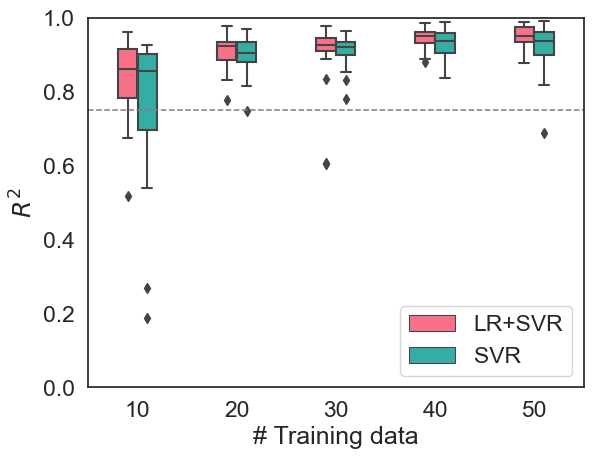

In [53]:
DABCLA_LR = ComparisonResultsPlot([complexSVRR2Lists_DABCLA_LR, SVRR2Lists_DABCLA_LR], 'LR', 'SVR', position = 'lower right', \
                              xname = '# Training data', yname = '$R^2$', show = 1, \
                              ylimit = [0, 1], yline = 0.75)

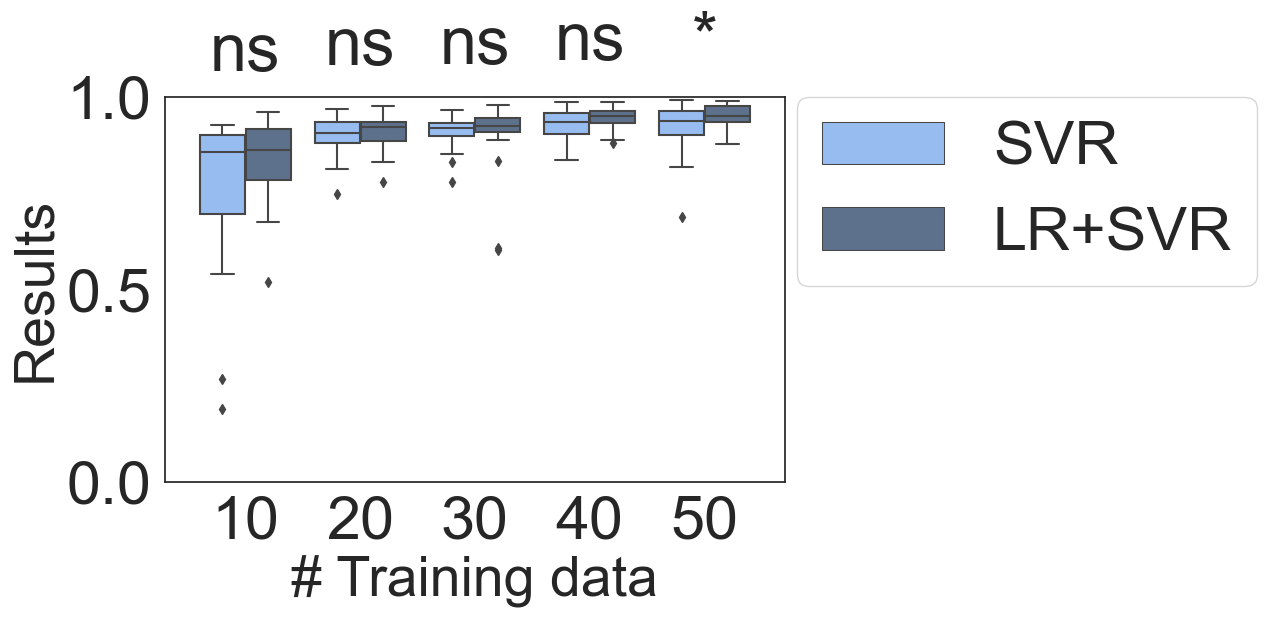

In [54]:
statsPlot(DABCLA_LR, 'LR', 'SVR')

In [60]:
# storeCorrelations([complexSVRSpearmanLists_DABCLA_LR, complexSVRPearsonLists_DABCLA_LR,\
#                    complexSVRR2Lists_DABCLA_LR, complexSVRMSELists_DABCLA_LR], 'SF3_DABCLA_LR_Corr.xlsx')

# storeCorrelations([SVRSpearmanLists_DABCLA_LR, SVRPearsonLists_DABCLA_LR,\
#                    SVRR2Lists_DABCLA_LR, SVRMSELists_DABCLA_LR], 'SF3_DABCLA_Corr.xlsx')

# storeRawData([complexPredictedSVRSpearmanLists_DABCLA_LR, complexPredictedSVRPearsonLists_DABCLA_LR,\
#              complexPredictedSVRR2Lists_DABCLA_LR, complexPredictedSVRMSELists_DABCLA_LR], \
#              'SF3_DABCLA_LR_Raw.xlsx')

# storeRawData([PredictedSVRSpearmanLists_DABCLA_LR, PredictedSVRPearsonLists_DABCLA_LR,\
#              PredictedSVRR2Lists_DABCLA_LR, PredictedSVRMSELists_DABCLA_LR], 'SF3_DABCLA_Raw.xlsx')

# storeWeight([r2Recorder_DABCLA_LR, mseRecorder_DABCLA_LR, \
#              pearsonRecorder_DABCLA_LR, spearmanRecorder_DABCLA_LR],\
#             'SF3_DABCLA_LR_Weight.xlsx')

# storeSVCSVRModel([r2Recorder_DABCLA_LR, mseRecorder_DABCLA_LR, \
#                   pearsonRecorder_DABCLA_LR, spearmanRecorder_DABCLA_LR],\
#                  'SF3_DABCLA_LR')
# storeSVRModel([SVRr2Recorder_DABCLA_LR, SVRmseRecorder_DABCLA_LR, \
#                SVRpearsonRecorder_DABCLA_LR, SVRspearmanRecorder_DABCLA_LR],\
#               'SF3_DABCLA_LR')
# storeScalerModel([scXRecorder_DABCLA_LR, scDensityRecorder_DABCLA_LR, \
#                   scDistanceRecorder_DABCLA_LR], 'SF3_DABCLA_LR')

# storeIndex(indexRecorder_DABCLA_LR, 'SF3_DABCLA_LR_TrainingIndices.xlsx')

# storeDataframes([TrainXDFRecorder_DABCLA_LR, TrainYDFRecorder_DABCLA_LR, \
# SVMSVRFullXDFRecorder_DABCLA_LR, SVMSVRFullYDFRecorder_DABCLA_LR], 'SF3_DABCLA_LR')

Finished storing correlations for:  SF3_DABCLA_LR_Corr.xlsx
Finished storing correlations for:  SF3_DABCLA_Corr.xlsx
Finished storing raw data for:  SF3_DABCLA_LR_Raw.xlsx
Finished storing raw data for:  SF3_DABCLA_Raw.xlsx
Finished storing weight for:  SF3_DABCLA_LR_Weight.xlsx
Finished storing classification and regression models for complex pipeline.
Finished storing regression models for simple pipeline.
Finished storing: SCX
Finished storing: SCDensity
Finished storing: SCDistance
Finished storing all.
Finished storing all training indices for:  SF3_DABCLA_LR_TrainingIndices.xlsx
Finished storing all dataframes for:  TrainX
Finished storing all dataframes for:  TrainY
Finished storing all dataframes for:  FullX
Finished storing all dataframes for:  FullY
Finished storing all dataframes


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 418, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 705, in score
    y_pred = self.predict(X)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/_device_offload.py", line 182, in wrapper
    result = func(self, *args, **kwargs)
  File "/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearnex/svm/svr.py", line 109, in predict
    }, X)
  File "/Users/ychha/anaconda

In [55]:
complexSVRSpearmanLists_TFB_LR, complexSVRPearsonLists_TFB_LR, \
complexSVRR2Lists_TFB_LR, complexSVRMSELists_TFB_LR, \
complexPredictedSVRSpearmanLists_TFB_LR, complexPredictedSVRPearsonLists_TFB_LR, \
complexPredictedSVRR2Lists_TFB_LR, complexPredictedSVRMSELists_TFB_LR, \
r2Recorder_TFB_LR, mseRecorder_TFB_LR, pearsonRecorder_TFB_LR, spearmanRecorder_TFB_LR, \
SVRSpearmanLists_TFB_LR, SVRPearsonLists_TFB_LR, SVRR2Lists_TFB_LR, SVRMSELists_TFB_LR, \
PredictedSVRSpearmanLists_TFB_LR, PredictedSVRPearsonLists_TFB_LR, \
PredictedSVRR2Lists_TFB_LR, PredictedSVRMSELists_TFB_LR, \
SVRr2Recorder_TFB_LR, SVRmseRecorder_TFB_LR, SVRpearsonRecorder_TFB_LR, SVRspearmanRecorder_TFB_LR,\
indexRecorder_TFB_LR, TrainXDFRecorder_TFB_LR, TrainYDFRecorder_TFB_LR, \
SVMSVRFullXDFRecorder_TFB_LR, SVMSVRFullYDFRecorder_TFB_LR, scXRecorder_TFB_LR, \
scDensityRecorder_TFB_LR, scDistanceRecorder_TFB_LR = \
ComparisonMultipleRun(30, 'HelenaExpTFBdensity.xlsx', 3, 'Sheet1', [10, 20, 30, 40, 50], 0, ['poly'],\
                     0.4) #, 'sigmoid', 'rbf'

10


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.972211510821503
MSE:  0.018104011632921774
Pearson:  0.9860078654967731
Spearman:  1.0
R2:  0.6475949986873459
MSE:  0.17234289441819836
Pearson:  0.8047328741187016
Spearman:  1.0
R2:  0.6849656490368986
MSE:  0.10347481700617271
Pearson:  0.8276265154264324
Spearman:  1.0
R2:  0.9185617430426419
MSE:  0.05031775160090137
Pearson:  0.9584162681437758
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.901822763495265, 0.03227640356299315, 0.9252909380343681, 0.868000763362491]
Regression:  [0.7850182309278642, 0.06187708335854825, 0.9141556998363017, 0.29767122874684404]
R2:  0.9995647326032274
MSE:  0.0016778563271147692
Pearson:  0.9997823426142449
Spearman:  1.0
R2:  0.9999221641607497
MSE:  0.004704074948515452
Pearson:  0.9999610813230433
Spearman:  1.0
R2:  0.9263467820278954
MSE:  0.03823028763991768
Pearson:  0.9624691070511797
Spearman:  1.0
R2:  0.9999089678371854
MSE:  0.0009002483275720167
Pearson:  0.9999544828826887
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7926555290418603, 0.037003702991168175, 0.9304297297797073, 0.8715908316921726]
Regression:  [0.7940109251207309, 0.10620626419440668, 0.7406205025052737, 0.7901402397414413]
R2:  0.7189660083311361
MSE:  0.08427810693580247
Pearson:  0.8479186330840571
Spearman:  0.5
R2:  0.3552287936407281
MSE:  0.14987531904151805
Pearson:  0.5960107328234351
Spearman:  0.5
R2:  0.9264682488327282
MSE:  0.030866455383447646
Pearson:  0.9625322066469923
Spearman:  0.5
R2:  0.9275076807095939
MSE:  0.0292312902584819
Pearson:  0.9630720018303895
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9118600893843956, 0.03030970099392318, 0.9514695789016451, 0.8158669520134362]
Regression:  [0.7016198997016726, 0.05437160893308986, 0.9204151449116624, 0.7363177282237379]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9999780259380812
MSE:  0.09991693160105168
Pearson:  0.9999890129086824
Spearman:  1.0
R2:  0.99461993182962
MSE:  0.10969607019410697
Pearson:  0.9973063380073448
Spearman:  0.5
R2:  0.9493295032320442
MSE:  0.176029151035048
Pearson:  0.9743354161848187
Spearman:  0.5
R2:  0.7756310807342084
MSE:  0.2190234637027435
Pearson:  0.8806991999168663
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8886043227044058, 0.025027053292578344, 0.948627352377798, 0.7638749978640791]
Regression:  [0.820699247873263, 0.1355863760977469, 0.9026762474484955, 0.7963500807249695]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


R2:  0.999947049083453
MSE:  0.2212985525794238
Pearson:  0.9999735241912424
Spearman:  0.8660254037844387
R2:  0.9971691233233654
MSE:  0.3345978653981769
Pearson:  0.9985835585084331
Spearman:  0.5
R2:  0.9998112962090329
MSE:  0.11487703910178326
Pearson:  0.9999056436529563
Spearman:  0.5
R2:  0.9999470490834534
MSE:  0.25851055614927976
Pearson:  0.9999735241912423
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.5793814220236558, 0.2078660881365554, 0.8248847275635902, 0.5271064160187654]
Regression:  [0.5474465686548757, 0.21389519764307877, 0.7115898049389007, 0.5376781804643247]
R2:  0.9901327096723648
MSE:  0.0231148571131687
Pearson:  0.9950541239914363
Spearman:  1.0
R2:  0.9870131709248141
MSE:  0.11103732870452672
Pearson:  0.9934853652293091
Spearman:  1.0
R2:  0.9317320817119806
MSE:  0.03942211640658437
Pearson:  0.9652627008809469
Spearman:  1.0
R2:  0.9980473630342908
MSE:  0.12654254761152264
Pearson:  0.9990232044523744
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8376305116942401, 0.023653429569382704, 0.9425938329381482, 0.8958143605165969]
Regression:  [0.22083947308932336, 0.12107532704105751, 0.7787086932809821, 0.7537423208596846]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.999961656111268
MSE:  0.4240585677324187
Pearson:  0.9999808278718487
Spearman:  0.8660254037844387
R2:  0.9999616561112682
MSE:  0.040264630013168705
Pearson:  0.9999808278718487
Spearman:  0.8660254037844387
R2:  0.9999616561112682
MSE:  0.03902834548477366
Pearson:  0.9999808278718488
Spearman:  0.8660254037844387
R2:  0.9999616561112682
MSE:  0.1229392062038518
Pearson:  0.9999808278718487
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6394967207582017, 0.10649050284203361, 0.7844692732169894, 0.6771488694095229]
Regression:  [0.3523351719431211, 0.14140859991086419, 0.46218511018649855, 0.6290236039642958]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9997544422203855
MSE:  0.04085285775016006
Pearson:  0.9998772135719393
Spearman:  1.0
R2:  0.9999941641830007
MSE:  0.004048309705704614
Pearson:  0.9999970820872432
Spearman:  1.0
R2:  0.9999735244918064
MSE:  0.00032076734526748687
Pearson:  0.999986762158283
Spearman:  1.0
R2:  0.9990436944762233
MSE:  0.016140868129218132
Pearson:  0.999521732868387
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.5477911607097163, 0.11505056734585362, 0.802656932115537, 0.8100092936710744]
Regression:  [0.7112843211158251, 0.11059497838381345, 0.884117768534749, 0.7959614127850179]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9975545320760801
MSE:  0.05471627919223049
Pearson:  0.9987765175834284
Spearman:  0.8660254037844387
R2:  0.9975545320760808
MSE:  0.1213446812526749
Pearson:  0.9987765175834284
Spearman:  0.8660254037844387
R2:  0.9975545320760804
MSE:  0.12169087201358024
Pearson:  0.9987765175834284
Spearman:  0.8660254037844387
R2:  0.9975545320760808
MSE:  0.07803908855236631
Pearson:  0.9987765175834284
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.40947591119497956, 0.1818518359322786, 0.6870782568964556, 0.7545518818053689]
Regression:  [0.7458019059360695, 0.06355097091551593, 0.8911080316125103, 0.752268718815344]
R2:  0.9980728451868683
MSE:  0.018231107986831262
Pearson:  0.9990359579048537
Spearman:  0.5
R2:  0.9965453598874968
MSE:  0.0013651875983539013
Pearson:  0.9982711855440368
Spearman:  0.5
R2:  0.9936928214455165
MSE:  0.06814531513580242
Pearson:  0.996841422416583
Spearman:  0.5
R2:  0.9979989423618046
MSE:  0.0005750639335390862
Pearson:  0.9989989701505225
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.5962091571882548, 0.060889922219818704, 0.9321228371345163, 0.7758103396506124]
Regression:  [0.7477606114041795, 0.0874830331675617, 0.8374287547176654, 0.7829319439382135]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.616265201457078
MSE:  0.2077767486518519
Pearson:  0.7850256056060069
Spearman:  1.0
R2:  0.709579928565156
MSE:  0.22649352195496117
Pearson:  0.8423656739000919
Spearman:  1.0
R2:  0.9868096293972605
MSE:  0.04539022672808638
Pearson:  0.9933829218369219
Spearman:  1.0
R2:  0.9801864594403531
MSE:  0.47408418825020565
Pearson:  0.9900436654210524
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.843000559770873, 0.0601244081601463, 0.9123017077211386, 0.8810063743459755]
Regression:  [0.5255009784982161, 0.13733003802088706, 0.8302893775912741, 0.6926435855247527]
R2:  0.7629047575332999
MSE:  0.012879508614357578
Pearson:  -0.8734441925694506
Spearman:  -0.5
R2:  0.7955502838866159
MSE:  0.033827634211489765
Pearson:  -0.8919362555063091
Spearman:  -0.5
R2:  0.01838498998782728
MSE:  0.0006618483609053556
Pearson:  0.13559126073544445
Spearman:  0.5
R2:  0.11089931373695033
MSE:  0.00994132038878605
Pearson:  0.3330154857314452
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8589202393286566, 0.037304120936997406, 0.9382746786985887, 0.8497703432388033]
Regression:  [0.7202490554438701, 0.08505749901721192, 0.8583738564636525, 0.7552760836471455]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.5664635025279992
MSE:  0.23378625724141555
Pearson:  0.7526376967226656
Spearman:  1.0
R2:  0.6976610352196075
MSE:  0.11707492798137858
Pearson:  0.8352610581247083
Spearman:  1.0
R2:  0.7585723696058467
MSE:  0.1263762254054321
Pearson:  0.8709606016381259
Spearman:  1.0
R2:  0.6739905426349443
MSE:  0.1268879196941015
Pearson:  0.8209692702135349
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8428518296320442, 0.05785704709591222, 0.9615048597685802, 0.8522546898268691]
Regression:  [0.760180312917116, 0.07054660461626884, 0.8700199864987168, 0.7227091624428909]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9859862110266383
MSE:  0.019717372040971178
Pearson:  0.99296838369942
Spearman:  0.5
R2:  0.9319988315796348
MSE:  0.03922560885977365
Pearson:  0.9654008657441917
Spearman:  0.5
R2:  0.7497194659538524
MSE:  0.10461329578744853
Pearson:  0.8658634222288479
Spearman:  0.5
R2:  0.748378458934687
MSE:  0.09369549887881479
Pearson:  0.8650887000387226
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.14418406923035693, 0.31812528480832875, 0.6693558204712446, 0.6660162463681921]
Regression:  [0.3784561490033285, 0.2858821065570188, 0.4610420198465946, 0.48053212276731144]
R2:  0.13605630821496162
MSE:  0.03681592844160952
Pearson:  -0.3688581139340188
Spearman:  0.0
R2:  0.12649746309493068
MSE:  0.0457460698332181
Pearson:  0.355664818466672
Spearman:  0.5
R2:  0.0005363143054509188
MSE:  0.10031763576023839
Pearson:  0.023158460774648226
Spearman:  0.5
R2:  0.07086766866026174
MSE:  0.22288169563072702
Pearson:  -0.2662098207434537
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6531919447410043, 0.1542484795539226, 0.7707540006291914, 0.832422291384524]
Regression:  [0.2534392696141722, 0.1382765325719045, 0.6887327286704776, 0.7646255012616131]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9936179687988997
MSE:  0.008141955315226324
Pearson:  0.9968038767976877
Spearman:  0.5
R2:  0.9947002128883301
MSE:  0.004112066625773027
Pearson:  0.9973465861416131
Spearman:  0.8660254037844387
R2:  0.9947002128883301
MSE:  0.003709249780109705
Pearson:  0.9973465861416131
Spearman:  0.8660254037844387
R2:  0.9947002128883299
MSE:  0.002781351944444446
Pearson:  0.9973465861416131
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7762167878680885, 0.14564801455787382, 0.78552961524493, 0.8423280064981391]
Regression:  [0.7078738497853293, 0.16849646150657752, 0.35430690057674324, 0.5090145853828922]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  nan
MSE:  0.00013737598276963555
Pearson:  nan
Spearman:  nan
R2:  0.5659449186612934
MSE:  0.0004423669261088261
Pearson:  -0.7522931068814158
Spearman:  -0.5
R2:  0.9974039131342388
MSE:  0.0002639402995884839
Pearson:  -0.9987011130134176
Spearman:  -1.0
R2:  0.051664120549739345
MSE:  0.014296369009053485
Pearson:  -0.22729742750356716
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.4633451582399718, 0.12257291137274864, 0.7753565513856717, 0.854335498177292]
Regression:  [0.6937327171147568, 0.1062200929098645, 0.7519669575225489, 0.504662511228303]
R2:  0.8047204942936534
MSE:  0.08213718165144028
Pearson:  0.8970621462828834
Spearman:  1.0
R2:  0.5499120717730104
MSE:  0.16146043281237865
Pearson:  0.74156056514152
Spearman:  0.5
R2:  0.8081772442159217
MSE:  0.22110250522798358
Pearson:  0.8989867875647126
Spearman:  1.0
R2:  0.5975956809220949
MSE:  0.1802407751838249
Pearson:  0.7730431300529711
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.612857624745625, 0.13896791691390947, 0.8168413438275497, 0.6598298339922495]
Regression:  [0.7207005130861768, 0.12305122902787989, 0.8750001621790066, 0.7443775211175603]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9230286529340425
MSE:  0.01777048937654316
Pearson:  0.9607438019233026
Spearman:  0.5
R2:  0.8545371215215835
MSE:  0.04017993876584362
Pearson:  0.9244117705446979
Spearman:  0.5
R2:  0.9383904505546716
MSE:  0.023275803648651075
Pearson:  0.968705554105411
Spearman:  1.0
R2:  0.7502287567864437
MSE:  0.06629570310781892
Pearson:  0.8661574665073575
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7260422718223954, 0.06740801272621319, 0.8670205786204437, 0.84409679817156]
Regression:  [0.7112076137367555, 0.07768309314326254, 0.8674938497760083, 0.7523399200091316]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9999221521101056
MSE:  0.0033996877876543217
Pearson:  0.9999610752974868
Spearman:  0.8660254037844387
R2:  0.8014939096481215
MSE:  0.0014568264133973496
Pearson:  -0.8952619223713927
Spearman:  -0.5
R2:  0.9914669925565828
MSE:  0.002179791519798825
Pearson:  -0.9957243557112495
Spearman:  -1.0
R2:  0.9999221521101058
MSE:  0.006504362864563312
Pearson:  0.9999610752974868
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8699904989303806, 0.034356640075616514, 0.9675358634460071, 0.8247800147747506]
Regression:  [0.7816417348542605, 0.11698742571668033, 0.8429177107710581, 0.843797012597571]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9144800734349096
MSE:  0.21014076947983537
Pearson:  0.956284514898631
Spearman:  1.0
R2:  0.9970260735241566
MSE:  0.2960856599539097
Pearson:  0.9985119295852988
Spearman:  0.5
R2:  0.9930447477665438
MSE:  0.14659109245267488
Pearson:  0.9965163058207047
Spearman:  0.5
R2:  0.6795170122359673
MSE:  0.6561059163370536
Pearson:  0.8243282187551069
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.805168908736123, 0.058127664867173655, 0.9676614495761406, 0.744232225222994]
Regression:  [0.5405187744449009, 0.05639380233277088, 0.8078241534213735, 0.726376483869025]
R2:  0.4176073448790736
MSE:  0.1847959569399177
Pearson:  0.6462254597886666
Spearman:  0.8660254037844387
R2:  0.38885077208406504
MSE:  0.41097785223407407
Pearson:  0.623579002279635
Spearman:  0.5
R2:  0.4167477082670053
MSE:  0.22456492751944435
Pearson:  0.6455599958694818
Spearman:  0.5
R2:  0.41760734487907386
MSE:  0.0072268598757201374
Pearson:  0.6462254597886667
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8396882963004664, 0.04838843574824759, 0.8935649057496995, 0.821818220236082]
Regression:  [0.5655908883709037, 0.11177350556596707, 0.9322599395650719, 0.8018435130323526]
R2:  0.8380026776417097
MSE:  0.0012635958061728537
Pearson:  0.9154248618219354
Spearman:  0.8660254037844387
R2:  0.8380026776417095
MSE:  0.03565309800243618
Pearson:  0.9154248618219354
Spearman:  0.8660254037844387
R2:  0.8380026776417093
MSE:  0.0015091050264289033
Pearson:  -0.9154248618219354
Spearman:  -0.8660254037844387
R2:  nan
MSE:  0.001164503202607644
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name

Classification:  [0.8513822319438271, 0.07001242184438958, 0.9326938114154366, 0.8120744270444192]
Regression:  [0.7148603535406527, 0.1302078418519616, 0.8456907180904019, 0.8231157797760095]
R2:  0.953462362014308
MSE:  0.02161407592757202
Pearson:  0.9764539733209693
Spearman:  0.5
R2:  0.9999756905059217
MSE:  6.388790452674637e-05
Pearson:  0.9999878451790908
Spearman:  1.0
R2:  0.9845891999201714
MSE:  0.021306384800823034
Pearson:  0.9922646823908284
Spearman:  0.5
R2:  0.9996699753362154
MSE:  0.0006093110436214115
Pearson:  0.9998349740513258
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6287165509758252, 0.0851215090767139, 0.6877259085294891, 0.7259440137598939]
Regression:  [0.7112019968827216, 0.06274596909549301, 0.8266526318660203, 0.7948905236923963]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9997831479237105
MSE:  0.03637469904261546
Pearson:  0.9998915680831151
Spearman:  0.5
R2:  0.999850708165251
MSE:  0.001391426008230455
Pearson:  0.999925351296411
Spearman:  0.5
R2:  0.9988767979246523
MSE:  0.012697482303136715
Pearson:  0.9994382411758379
Spearman:  1.0
R2:  0.9938444389490411
MSE:  0.07892011107613171
Pearson:  0.9969174684742167
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.794280212875413, 0.05889275584835389, 0.8865186964907459, 0.8169379224060765]
Regression:  [0.7783725541480507, 0.13244865773086756, 0.9207996509222556, 0.8188771188019577]
R2:  0.3088272452287092
MSE:  0.37641677989981687
Pearson:  0.5557222734682398
Spearman:  0.5
R2:  0.3547615315556462
MSE:  0.33456471074462524
Pearson:  0.5956186124993461
Spearman:  0.5
R2:  0.7262870304780022
MSE:  0.13308676079094642
Pearson:  0.8522247534999216
Spearman:  0.5
R2:  0.24285054363546382
MSE:  0.5824026267735882
Pearson:  -0.49279868469331756
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9332970124154876, 0.0221607604784465, 0.9643269341604832, 0.7828021801396682]
Regression:  [0.7501091722225417, 0.06149354074839161, 0.8723843414140634, 0.7196799022446319]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.7443567173601264
MSE:  0.22629213112304522
Pearson:  -0.8627611009776264
Spearman:  -0.8660254037844387
R2:  0.744356717360126
MSE:  0.03561915823333335
Pearson:  0.8627611009776263
Spearman:  0.8660254037844387
R2:  0.744356717360126
MSE:  0.15286647616973018
Pearson:  0.8627611009776264
Spearman:  0.8660254037844387
R2:  0.7443567173601262
MSE:  0.044540750535482405
Pearson:  0.8627611009776264
Spearman:  0.8660254037844387


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8563216120260198, 0.03240903594878525, 0.9256204204380974, 0.7081539334397434]
Regression:  [0.6667792210551527, 0.09499449996755156, 0.8869885992363941, 0.6976122193796936]
R2:  0.006511979517586771
MSE:  0.7480239872210905
Pearson:  -0.08069683709778698
Spearman:  -0.5
R2:  nan
MSE:  0.014099244711111111
Pearson:  nan
Spearman:  nan


/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ychha/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/ychha/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


R2:  0.7383193739806405
MSE:  0.006882533828086435
Pearson:  -0.8592551274101542
Spearman:  -0.8660254037844387
R2:  0.4580016350879448
MSE:  0.020089623950880663
Pearson:  -0.6767581806583093
Spearman:  -0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.885322732227341, 0.023756844993723922, 0.9438069072247816, 0.8781641374989232]
Regression:  [0.8506765222531575, 0.05385792241280862, 0.9253515351905778, 0.8012050470525535]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.9978507270445469
MSE:  0.10075966178783723
Pearson:  0.9989247854791405
Spearman:  0.8660254037844387
R2:  0.8535796580703678
MSE:  0.11867484780128401
Pearson:  0.9238937482580819
Spearman:  0.5
R2:  0.9991358666987235
MSE:  0.004559261596890713
Pearson:  0.9995678399682151
Spearman:  1.0
R2:  0.9576271386623034
MSE:  0.01543850082962965
Pearson:  0.9785842522043275
Spearman:  0.5


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7600062208259132, 0.06869451854858558, 0.7685370735234853, 0.5936219200041228]
Regression:  [0.5588113496811083, 0.10768043727624473, 0.794261727701822, 0.7636242488218462]
R2:  0.9330487378182217
MSE:  0.03869193686286008
Pearson:  0.9659444796768716
Spearman:  0.5
R2:  0.9625473937020512
MSE:  0.02243593701735619
Pearson:  0.9810949972872409
Spearman:  1.0
R2:  0.9943978144850065
MSE:  0.019902761401671822
Pearson:  0.9971949731547017
Spearman:  1.0
R2:  0.9515592582689546
MSE:  0.08739376584142666
Pearson:  0.9754789891478722
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7622265022646143, 0.061681372025294924, 0.8791750198690714, 0.8427508550739231]
Regression:  [0.7324840588274196, 0.07725281906230672, 0.8583429863510696, 0.8345301378332909]
20
R2:  0.9994326992549858
MSE:  0.00042056375998341197
Pearson:  0.9997163093873109
Spearman:  0.8944271909999159
R2:  0.9993905827129725
MSE:  0.000351016847470858
Pearson:  0.9996952449186562
Spearman:  0.7999999999999999
R2:  0.998964889166849
MSE:  0.09368314138888888
Pearson:  0.9994823105822577
Spearman:  0.6000000000000001
R2:  0.9988920337255505
MSE:  0.00042606560030864475
Pearson:  0.9994458633290498
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7275786163776163, 0.10925152033084429, 0.8531763895533556, 0.8494587747925212]
Regression:  [0.675405718542283, 0.11184731691023145, 0.808495665692632, 0.7759283605008195]
R2:  0.4456272964751596
MSE:  0.01582804173648837
Pearson:  0.6675532162121305
Spearman:  0.7999999999999999
R2:  0.3963460370989066
MSE:  0.0016029899346879188
Pearson:  0.6295601933881357
Spearman:  0.39999999999999997
R2:  0.02868013667243599
MSE:  0.001210657751851845
Pearson:  -0.16935210855621488
Spearman:  -0.39999999999999997
R2:  0.24904674017992667
MSE:  0.008733792750464469
Pearson:  0.4990458297390398
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8611449459875199, 0.07647879840000672, 0.936179702693879, 0.8756723879561324]
Regression:  [0.7557801052273935, 0.08587270570847219, 0.8753201886022299, 0.8585042844117622]
R2:  0.983993327870476
MSE:  0.01897455845810183
Pearson:  0.9919643783274056
Spearman:  0.7999999999999999
R2:  0.9980508223652719
MSE:  0.0011765168911604918
Pearson:  0.9990249358075467
Spearman:  0.7999999999999999
R2:  0.590058129031127
MSE:  0.3160784747980881
Pearson:  -0.768152412631196
Spearman:  -0.39999999999999997
R2:  0.9699556834467529
MSE:  0.013632833633950639
Pearson:  0.9848632816014378
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8143535535329145, 0.038020652274305546, 0.8688645493335372, 0.7833809141029433]
Regression:  [0.8356559985275576, 0.11612791554661657, 0.8277512954946479, 0.7175567457524159]
R2:  0.9972024220422097
MSE:  0.02145578884198499
Pearson:  0.9986002313449609
Spearman:  0.19999999999999998
R2:  0.8590148699314005
MSE:  0.06641920941481487
Pearson:  0.9268305508189731
Spearman:  0.7999999999999999
R2:  0.9977576822079707
MSE:  0.0026395480842592626
Pearson:  0.9988782118997146
Spearman:  0.19999999999999998
R2:  0.9996449724452545
MSE:  0.00019560635740740404
Pearson:  0.9998224704642593
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9212337624833451, 0.01993622948944444, 0.9329650709589501, 0.744392937514327]
Regression:  [0.6486115142857686, 0.12766992536642713, 0.7918689503649663, 0.6198262861090876]
R2:  0.8370082209231569
MSE:  0.0942591471651234
Pearson:  0.9148815338190825
Spearman:  1.0
R2:  0.07858573075947949
MSE:  0.45311980814791675
Pearson:  -0.28033146587473823
Spearman:  0.39999999999999997
R2:  0.9380096418595905
MSE:  0.17588799176068232
Pearson:  0.9685089787191394
Spearman:  0.7999999999999999
R2:  0.9761242940322222
MSE:  0.21676495088299405
Pearson:  0.9879900272939105
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9536785958825902, 0.0382811587526989, 0.8066082965183821, 0.8160043151476655]
Regression:  [0.8314906041883348, 0.051280911381090546, 0.7945074233924312, 0.696653051285669]
R2:  0.8703199733135972
MSE:  0.0020579491845679017
Pearson:  0.9329094132409625
Spearman:  0.9486832980505139
R2:  0.821748339440273
MSE:  0.002410560992592586
Pearson:  0.9065033587584068
Spearman:  0.9486832980505139
R2:  0.9981243242719944
MSE:  0.04937460688631136
Pearson:  0.9990617219531505
Spearman:  0.9486832980505139
R2:  0.712121258354137
MSE:  0.02461141851097392
Pearson:  0.8438727737959892
Spearman:  0.316227766016838


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8956983475851629, 0.021825977321875856, 0.95616846929853, 0.8422210106168517]
Regression:  [0.8450756446335884, 0.12465589670085742, 0.8978069208081587, 0.7953126940978877]
R2:  0.6864320804323432
MSE:  0.1084759192176959
Pearson:  0.828511967585468
Spearman:  1.0
R2:  0.8670735971014364
MSE:  0.03698590869722224
Pearson:  0.9311678673050509
Spearman:  1.0
R2:  0.6661783477737
MSE:  0.10800587871597844
Pearson:  0.8161974931189756
Spearman:  0.9486832980505139
R2:  0.6572736562075631
MSE:  0.11541655587657022
Pearson:  0.8107241554360911
Spearman:  0.9486832980505139


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9611365793347731, 0.01321432263860082, 0.9746859600250294, 0.8718799284362145]
Regression:  [0.7388641190715469, 0.09029892906636472, 0.8651208637282835, 0.8306116195308876]
R2:  0.9986857143222044
MSE:  0.0004580728267489733
Pearson:  0.9993426411007411
Spearman:  0.7999999999999999
R2:  0.9980758140069075
MSE:  0.000650557580109743
Pearson:  0.9990374437461829
Spearman:  0.7999999999999999
R2:  0.9989404371751883
MSE:  0.0004259995939259279
Pearson:  0.9994700781790262
Spearman:  1.0
R2:  0.9983622474967324
MSE:  0.025752741880246878
Pearson:  0.9991807881943753
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7705296524940157, 0.07561725290538387, 0.8813747760215467, 0.7730323176142794]
Regression:  [0.7416604335865521, 0.058817792882320405, 0.8767332823133747, 0.790553017678617]
R2:  0.5709851186892809
MSE:  0.1471214869942904
Pearson:  0.7556355726732835
Spearman:  0.7745966692414834
R2:  0.8182856635533436
MSE:  0.05785576872006172
Pearson:  0.9045914346009162
Spearman:  1.0
R2:  0.7124153534076795
MSE:  0.09535840621296436
Pearson:  0.8440470090034556
Spearman:  1.0
R2:  0.6561844682572023
MSE:  0.12044914928257881
Pearson:  0.8100521392214222
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8748957631500045, 0.02205746615665296, 0.9699971046745224, 0.7831234235368846]
Regression:  [0.7336691884388853, 0.08096365658999997, 0.8814370859704419, 0.8002685863853192]
R2:  0.9934453990312514
MSE:  0.0022013695348765327
Pearson:  0.9967173114937111
Spearman:  0.19999999999999998
R2:  0.99446113728725
MSE:  0.002390911390123438
Pearson:  0.9972267231112741
Spearman:  0.7999999999999999
R2:  0.9926479334757127
MSE:  0.0021660465375771434
Pearson:  0.9963171851753401
Spearman:  0.39999999999999997
R2:  0.9937667674849334
MSE:  0.002090948440466379
Pearson:  0.9968785118984828
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8005142100659853, 0.09519620467939813, 0.8927041356648924, 0.8145178393108987]
Regression:  [0.6966516100698874, 0.16418812417776482, 0.8489537502464739, 0.7089201053622337]
R2:  0.9511773127723865
MSE:  0.08340930598505654
Pearson:  0.9752831961909247
Spearman:  0.19999999999999998
R2:  0.987132300817225
MSE:  0.004441651998302455
Pearson:  0.993545318954915
Spearman:  0.39999999999999997
R2:  0.9979272859716739
MSE:  0.0007464477589506024
Pearson:  0.998963105410642
Spearman:  0.7999999999999999
R2:  0.9753672709091386
MSE:  0.009079414325960206
Pearson:  0.9876068402502781
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8509303893496336, 0.03348093090111111, 0.8985139342659706, 0.8303158611814885]
Regression:  [0.7279877211104221, 0.07260205594574076, 0.8794499255326991, 0.7620406354892477]
R2:  0.9973922014383232
MSE:  0.0008663175392592607
Pearson:  0.9986952495322701
Spearman:  1.0
R2:  0.9953381188038294
MSE:  0.014649981116666709
Pearson:  0.9976663364090371
Spearman:  0.7999999999999999
R2:  0.9959343848362979
MSE:  0.0018055212012345544
Pearson:  0.9979651220540214
Spearman:  1.0
R2:  0.9916934391254577
MSE:  0.0495895671175926
Pearson:  0.995838058684974
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9077202454373411, 0.03898361092566455, 0.8134412108437716, 0.7595398171224287]
Regression:  [0.11077959276248607, 0.4342820793854939, 0.36647649392930526, 0.7864860772907577]
R2:  0.9548195494844354
MSE:  0.05285467932376545
Pearson:  0.9771486834072058
Spearman:  0.7999999999999999
R2:  0.9660077186576259
MSE:  0.04436411855123454
Pearson:  0.982856916675884
Spearman:  0.7999999999999999
R2:  0.8936925485100609
MSE:  0.05979005979633056
Pearson:  0.9453531342890132
Spearman:  0.7999999999999999
R2:  0.9489039495452308
MSE:  0.02281871837777778
Pearson:  0.9741170101919125
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9595226556597134, 0.014321632260379736, 0.9811406084596587, 0.8475443712586991]
Regression:  [0.9053911482705923, 0.024954228661509446, 0.9603308699061903, 0.850120860171541]
R2:  0.9891437926715926
MSE:  0.012015263743287062
Pearson:  0.9945570836666903
Spearman:  0.6000000000000001
R2:  0.9928344838100762
MSE:  0.004998007354099244
Pearson:  0.9964108007293355
Spearman:  0.6000000000000001
R2:  0.9993581139087441
MSE:  0.00044353269471878636
Pearson:  0.9996790054356166
Spearman:  0.7378647873726218
R2:  0.9843080443995526
MSE:  0.019304217231186683
Pearson:  0.9921229986244409
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7565302678006869, 0.07833643708285892, 0.855238723998323, 0.8301312082451252]
Regression:  [0.7045717373370923, 0.10165971891617287, 0.8283283461077835, 0.7521117517335166]
R2:  0.9968801879151185
MSE:  0.006644321866790134
Pearson:  0.9984388754025546
Spearman:  0.19999999999999998
R2:  0.7780684453302634
MSE:  0.04289804681740715
Pearson:  0.8820818813070946
Spearman:  0.9486832980505139
R2:  0.9984897627051256
MSE:  0.0022639865119012323
Pearson:  0.9992445960349875
Spearman:  0.7999999999999999
R2:  0.9991902358314967
MSE:  0.001933293109259255
Pearson:  0.9995950359177943
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8722446324130934, 0.04181351433492746, 0.9249928270183809, 0.839786198716165]
Regression:  [0.8719531445794176, 0.047847708910493815, 0.9318588549877662, 0.800956672752046]
R2:  0.900135880528901
MSE:  0.029222888763511683
Pearson:  0.9487549106744593
Spearman:  0.39999999999999997
R2:  0.5217404557115913
MSE:  0.1822395711033951
Pearson:  0.722316035895363
Spearman:  0.39999999999999997
R2:  0.73807071707027
MSE:  0.10689043413786015
Pearson:  0.859110421930889
Spearman:  0.39999999999999997
R2:  0.6080493111471452
MSE:  0.15397858791910152
Pearson:  0.7797751670495447
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9419875892717382, 0.011856406294268795, 0.9747911743342225, 0.78605216965729]
Regression:  [0.8782773074835825, 0.03945324870040125, 0.9054555528906335, 0.8396523370887778]
R2:  0.8638626191300466
MSE:  0.0024167320563785993
Pearson:  0.929442101010088
Spearman:  0.39999999999999997
R2:  0.14465399939147408
MSE:  0.022365383443209867
Pearson:  0.3803340628861346
Spearman:  -0.19999999999999998
R2:  0.7168472282795357
MSE:  0.006878666063973502
Pearson:  0.8466683106621717
Spearman:  0.7999999999999999
R2:  0.025912609777418494
MSE:  0.018392198951028775
Pearson:  0.16097394129926273
Spearman:  0.6000000000000001


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9458693810411107, 0.014105606823271607, 0.9791854253050358, 0.8214149971601296]
Regression:  [0.7196036701608358, 0.1503501636805624, 0.8749907991183119, 0.7986073405475254]
R2:  0.8000293370374187
MSE:  0.07888994287552474
Pearson:  0.8944435907520489
Spearman:  1.0
R2:  0.6558671542148959
MSE:  0.1215982588337217
Pearson:  0.8098562552792292
Spearman:  1.0
R2:  0.8149256105735211
MSE:  0.08539065825837772
Pearson:  0.9027323028304244
Spearman:  1.0
R2:  0.6744635218359931
MSE:  0.11519798467516047
Pearson:  0.8212572811464098
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8415722029405234, 0.032725351218100884, 0.9057917615638695, 0.8753853596321092]
Regression:  [0.7698302866364507, 0.07731637345575616, 0.8690354012128205, 0.7509495583655126]
R2:  0.6026327787423096
MSE:  0.13931264300562415
Pearson:  0.7762942604079395
Spearman:  0.7999999999999999
R2:  0.9401268640950655
MSE:  0.01823025556666666
Pearson:  0.9696013944374593
Spearman:  0.19999999999999998
R2:  0.9177530803633999
MSE:  0.02534684897129629
Pearson:  0.9579943007990182
Spearman:  0.39999999999999997
R2:  0.9811802058271676
MSE:  0.008622649323160465
Pearson:  0.9905454082611093
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8067795421783273, 0.0436405226958642, 0.8715546891318007, 0.86533976170489]
Regression:  [0.8763188296003898, 0.037026614068201305, 0.9354417671463184, 0.7475249731789525]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.11140800864171262
MSE:  0.007315522719007252
Pearson:  -0.33377838252605974
Spearman:  -0.2581988897471611
R2:  0.33939222821125636
MSE:  0.0054169104105709865
Pearson:  -0.5825737963651099
Spearman:  -0.6000000000000001
R2:  0.014246859237033253
MSE:  0.0016975038568363546
Pearson:  -0.11936020792975041
Spearman:  0.0
R2:  0.0012328569295287724
MSE:  0.002496877923285629
Pearson:  0.035112062450513654
Spearman:  -0.632455532033676


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8699479549137945, 0.03722962784865741, 0.924499047584142, 0.8991048212510868]
Regression:  [0.6611836183078337, 0.07511496972439813, 0.7527851319145414, 0.8259871174799219]
R2:  0.9976329216254495
MSE:  0.0007431053641481475
Pearson:  0.9988157596000623
Spearman:  1.0
R2:  0.9996702046398781
MSE:  0.0010005645387516989
Pearson:  0.999835088722074
Spearman:  1.0
R2:  0.9837810360756593
MSE:  0.009780735676183105
Pearson:  0.9918573668001158
Spearman:  1.0
R2:  0.9989629881276683
MSE:  0.00040585047599451146
Pearson:  0.9994813595698864
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7980335470536856, 0.05558096950654321, 0.9034519748411205, 0.7989470742051752]
Regression:  [0.6357015007006708, 0.14379901162445413, 0.8459487800133454, 0.6776623202673141]
R2:  0.7335691709235519
MSE:  0.0776445493874065
Pearson:  0.8564865269947635
Spearman:  0.7378647873726218
R2:  0.7044546571932333
MSE:  0.08589316398047106
Pearson:  0.8393179714465984
Spearman:  0.7378647873726218
R2:  0.8329942086161052
MSE:  0.050650747590617336
Pearson:  0.9126851640166531
Spearman:  0.7999999999999999
R2:  0.8673997217858058
MSE:  0.03616065556574077
Pearson:  0.9313429667881783
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7790037815005469, 0.08944890248635802, 0.8415727727491433, 0.757203808519757]
Regression:  [0.4565428789171405, 0.10695542647479742, 0.7569851592725014, 0.6814693272183004]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


R2:  0.2145280716731352
MSE:  0.3205170009568671
Pearson:  -0.463171751808263
Spearman:  -0.7999999999999999
R2:  0.8539787318086292
MSE:  0.22170605221802064
Pearson:  0.9241096968480687
Spearman:  0.39999999999999997
R2:  0.9479275539250213
MSE:  0.14425807314178454
Pearson:  0.9736157116260097
Spearman:  0.39999999999999997
R2:  0.9312258479802268
MSE:  0.16248957994202637
Pearson:  0.965000439367893
Spearman:  0.316227766016838


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9208174148531083, 0.023720110714081782, 0.9621504956028181, 0.9040821404553046]
Regression:  [0.761969142358037, 0.035398481753842574, 0.857328404383381, 0.8302336755420343]
R2:  0.9333120762910205
MSE:  0.01949103829712794
Pearson:  0.9660807814520588
Spearman:  1.0
R2:  0.9997320786451799
MSE:  0.0001873241154320959
Pearson:  0.9998660303486561
Spearman:  1.0
R2:  0.965084306537019
MSE:  0.009295009987037053
Pearson:  0.9823870451797596
Spearman:  0.7999999999999999
R2:  0.9951925499513025
MSE:  0.0017597517873456803
Pearson:  0.9975933790634851
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7400527523916591, 0.02695308878877648, 0.7521327290127549, 0.8077558926082042]
Regression:  [0.596729382628128, 0.4366403847978709, 0.8496062692513492, 0.4437461315672616]
R2:  0.9608884285094339
MSE:  0.018697568687448523
Pearson:  0.9802491665436057
Spearman:  0.7999999999999999
R2:  0.984785883095869
MSE:  0.008714060177469136
Pearson:  0.9923637856632359
Spearman:  0.6000000000000001
R2:  0.9532183549116391
MSE:  0.02071932120894421
Pearson:  0.9763290198041022
Spearman:  0.7999999999999999
R2:  0.9119646413563842
MSE:  0.03543531836983789
Pearson:  0.9549683980930386
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8690247207942814, 0.02818007265200987, 0.9438063293977843, 0.8849957616849252]
Regression:  [0.8549202238827077, 0.02430243034461722, 0.9501483550586232, 0.8747942021258602]
R2:  0.006487509030446979
MSE:  0.00645484047160494
Pearson:  0.08054507452629847
Spearman:  0.2581988897471611
R2:  0.7299686145274504
MSE:  0.003299783562860087
Pearson:  0.85438200737577
Spearman:  0.316227766016838
R2:  0.036910007758629015
MSE:  0.020172832942798334
Pearson:  0.1921197745122272
Spearman:  0.21081851067789195
R2:  0.8239145551911086
MSE:  0.005019539411111098
Pearson:  0.9076973918609157
Spearman:  0.9486832980505139


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.95721921880976, 0.009651214281975313, 0.9768373089652401, 0.8680785487324382]
Regression:  [0.8519260403375949, 0.05008652262169925, 0.9230155418666423, 0.8514747586491351]
R2:  0.993455586239366
MSE:  0.0022223419037037074
Pearson:  0.9967224218604525
Spearman:  0.7999999999999999
R2:  0.9771019242337656
MSE:  0.010158182341546638
Pearson:  0.9884846605960891
Spearman:  1.0
R2:  0.9508118108531114
MSE:  0.023631314118364215
Pearson:  0.9750957957314301
Spearman:  0.7999999999999999
R2:  0.9932178569619967
MSE:  0.002426824387654313
Pearson:  0.9966031592173469
Spearman:  0.7999999999999999


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8465465444325811, 0.012357536896836423, 0.9386145530529304, 0.8316570626660927]
Regression:  [0.5435040669264234, 0.058012173728851854, 0.8241061479537176, 0.7450371367155568]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  UserWarning,


R2:  0.5881404972659771
MSE:  0.0012559830671296345
Pearson:  -0.7669031863709896
Spearman:  -1.0
R2:  0.0034652533584319653
MSE:  0.0010209092662037031
Pearson:  -0.058866402628595896
Spearman:  -0.39999999999999997
R2:  0.825542344714447
MSE:  0.0003540505266666688
Pearson:  0.9085936081188593
Spearman:  0.39999999999999997
R2:  0.4483920345070439
MSE:  0.0005241813893655281
Pearson:  -0.669620813973882
Spearman:  -0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.6345216982357043, 0.1741207860608889, 0.9211191324144691, 0.8544459799907292]
Regression:  [0.6957465610527516, 0.11179704299959621, 0.827224540601492, 0.6690866957200969]
R2:  0.998365030489932
MSE:  0.0009758919888888904
Pearson:  0.9991821808308694
Spearman:  0.7999999999999999
R2:  0.9941738765527491
MSE:  0.0049205345286008045
Pearson:  0.9970826829068641
Spearman:  0.7999999999999999
R2:  0.8942845638484194
MSE:  0.05303501894366668
Pearson:  0.9456662010711918
Spearman:  1.0
R2:  0.9997522783753757
MSE:  0.0012055382497942455
Pearson:  0.9998761315159873
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8979009703956718, 0.041507907052883965, 0.9394561893213801, 0.8667453596785929]
Regression:  [0.7462219215816482, 0.03635471078361935, 0.8779125645597439, 0.8171019666215926]
R2:  0.9846138676374269
MSE:  0.00531145563933472
Pearson:  0.9922771123216674
Spearman:  0.39999999999999997
R2:  0.9857739406660238
MSE:  0.004985797330925921
Pearson:  0.9928614911789175
Spearman:  0.39999999999999997
R2:  0.9851316570886282
MSE:  0.004854588020987662
Pearson:  0.992537987730761
Spearman:  0.39999999999999997
R2:  0.9791957089647008
MSE:  0.008644622531095677
Pearson:  0.9895431819605958
Spearman:  0.39999999999999997


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.918018344185783, 0.022355399501753078, 0.9669744395132812, 0.8464302357283761]
Regression:  [0.7834247536414024, 0.05171613073381452, 0.9071699093162491, 0.7480562855100397]
30
R2:  0.973433762441043
MSE:  0.006591950683333298
Pearson:  0.9866274689268706
Spearman:  0.6
R2:  0.6432575653373499
MSE:  0.10714509533353905
Pearson:  0.8020333941534792
Spearman:  0.7714285714285715
R2:  0.6740084526917235
MSE:  0.09227112629007196
Pearson:  0.820980178013893
Spearman:  0.6
R2:  0.9080011377864605
MSE:  0.018298152695061725
Pearson:  0.9528909369841128
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9088148248083259, 0.01842347646478346, 0.9540434992078135, 0.8932190179637296]
Regression:  [0.8102386672299854, 0.05924102488175338, 0.9147286822471797, 0.722095850124519]
R2:  0.8933739154428986
MSE:  0.0424884349586191
Pearson:  0.9451845933165113
Spearman:  0.8857142857142858
R2:  0.9875449322838973
MSE:  0.0034818849833333216
Pearson:  0.9937529533459998
Spearman:  0.8857142857142858
R2:  0.9846287517504066
MSE:  0.00461653496753543
Pearson:  0.9922846122713009
Spearman:  0.8857142857142858
R2:  0.9508830912899485
MSE:  0.02245615232146776
Pearson:  0.9751323455254413
Spearman:  0.7714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9361305146340739, 0.015554957585396826, 0.9696766144217073, 0.8285999346244305]
Regression:  [0.7417221588418667, 0.06020162452567905, 0.8923444034868404, 0.7593171378174609]
R2:  0.9960423786262071
MSE:  0.0020403628376136893
Pearson:  0.9980192275834201
Spearman:  0.5768179036829705
R2:  0.986621724613885
MSE:  0.0045815782024701815
Pearson:  0.9932883391109981
Spearman:  0.5797710356524484
R2:  0.9954505581621396
MSE:  0.0015427690618198496
Pearson:  0.9977226860015459
Spearman:  0.6571428571428573
R2:  0.991266920062006
MSE:  0.0031213154147233728
Pearson:  0.9956238848390524
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9100541211014495, 0.0275987687186165, 0.9353693995074102, 0.8638391690764965]
Regression:  [0.9308667401312409, 0.028105697176570642, 0.9548705291349124, 0.7169015699820874]
R2:  0.9718663790546405
MSE:  0.013121576735802469
Pearson:  0.9858328352487759
Spearman:  0.5428571428571429
R2:  0.9596188531006627
MSE:  0.018091561938631682
Pearson:  0.9796013745910438
Spearman:  0.5428571428571429
R2:  0.852181011474186
MSE:  0.10805881609354732
Pearson:  0.9231365074972311
Spearman:  0.3714285714285715
R2:  0.9837461846022121
MSE:  0.0077838978845678935
Pearson:  0.9918397978515542
Spearman:  0.7142857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.950262011588984, 0.02313571075815758, 0.9646267376780642, 0.8909283410965827]
Regression:  [0.8381513193652922, 0.04523919570143958, 0.9472058422455008, 0.8802995594692021]
R2:  0.9517217170380431
MSE:  0.008146259895061713
Pearson:  0.9755622568744876
Spearman:  0.48571428571428577
R2:  0.9486389823580613
MSE:  0.002202762493004123
Pearson:  0.9739809969183494
Spearman:  0.3714285714285715
R2:  0.91479944780016
MSE:  0.0015407158596143838
Pearson:  0.9564514874263934
Spearman:  0.4285714285714286
R2:  0.9475763696326136
MSE:  0.0013039833493662624
Pearson:  0.9734353443514441
Spearman:  0.4285714285714286


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9356864431353856, 0.0190431780261023, 0.9720682297043014, 0.8806459799895805]
Regression:  [0.8258230507037949, 0.03076087905293063, 0.9398054568067257, 0.872067185723034]
R2:  0.9710066222318363
MSE:  0.017665899513423882
Pearson:  0.9853966826775072
Spearman:  0.8857142857142858
R2:  0.9996798757373416
MSE:  0.0006021868427983595
Pearson:  0.999839925056677
Spearman:  0.8857142857142858
R2:  0.9993658388341707
MSE:  0.00043127479055784997
Pearson:  0.9996828691310913
Spearman:  0.8285714285714287
R2:  0.992821418584728
MSE:  0.007655157440337443
Pearson:  0.9964042445637855
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9083509932754925, 0.02170939081349597, 0.9486991700663168, 0.8971238317276613]
Regression:  [0.5577603592067827, 0.06702013193088378, 0.8553210178612567, 0.8524713498381595]
R2:  0.99773791872471
MSE:  0.000635135845893004
Pearson:  0.9988683190114247
Spearman:  0.942857142857143
R2:  0.9967104264248822
MSE:  0.0013964403785679017
Pearson:  0.9983538583212279
Spearman:  0.942857142857143
R2:  0.997516129921982
MSE:  0.0009289964898106998
Pearson:  0.998757292800399
Spearman:  0.942857142857143
R2:  0.9977485827302718
MSE:  0.0006938105242715589
Pearson:  0.9988736570409054
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.918786620679782, 0.025451285311305125, 0.960754170098263, 0.8700954450230837]
Regression:  [0.6673612805014927, 0.07793679801011781, 0.8725628981743347, 0.8023634371585194]
R2:  0.9992404404934373
MSE:  0.0351077428320172
Pearson:  0.9996201481029868
Spearman:  0.33806170189140666
R2:  0.9983350863820775
MSE:  0.008467436339164771
Pearson:  0.9991671964101294
Spearman:  0.4285714285714286
R2:  0.9979040373866508
MSE:  0.0011257275349794242
Pearson:  0.9989514689846808
Spearman:  0.4285714285714286
R2:  0.9082191384507039
MSE:  0.02491481057949246
Pearson:  0.953005319214276
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8167339287208336, 0.06492460011444441, 0.8880443559132387, 0.8637942355492896]
Regression:  [0.8617859311083831, 0.03155148955946699, 0.9091724054139061, 0.8351646430224702]
R2:  0.9800441222618614
MSE:  0.008763305232934672
Pearson:  0.9899717785178836
Spearman:  0.942857142857143
R2:  0.9995640237001767
MSE:  0.00038241851751257585
Pearson:  0.9997819880854909
Spearman:  0.942857142857143
R2:  0.993355678514781
MSE:  0.0028615103895010922
Pearson:  0.9966723024719715
Spearman:  0.5428571428571429
R2:  0.9994046019192692
MSE:  0.0004586625267489718
Pearson:  0.9997022566340787
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7945478538401892, 0.05480117806102292, 0.9201999376652887, 0.8898146736212895]
Regression:  [0.8141026881077007, 0.05677508616132766, 0.886802783410551, 0.7752941698506931]
R2:  0.8899628404249782
MSE:  0.030881589286059673
Pearson:  0.94337841846471
Spearman:  0.7142857142857143
R2:  0.847352376595588
MSE:  0.043057679530406956
Pearson:  0.9205174504568547
Spearman:  0.7142857142857143
R2:  0.9263776307640914
MSE:  0.021317866998445362
Pearson:  0.9624851327496395
Spearman:  0.7142857142857143
R2:  0.8893345608659317
MSE:  0.030722125170839495
Pearson:  0.9430453652215952
Spearman:  0.48571428571428577


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9131008979846255, 0.05770389980015872, 0.9564891440115529, 0.8783305105805665]
Regression:  [0.9035254389497509, 0.02988473207514671, 0.961411060127545, 0.857232899747898]
R2:  0.8942606938313483
MSE:  0.03221117583719708
Pearson:  0.9456535802456142
Spearman:  0.4285714285714286
R2:  0.8932450467840016
MSE:  0.03374058009300412
Pearson:  0.9451164196986536
Spearman:  0.4285714285714286
R2:  0.9180190076968202
MSE:  0.026122639684187
Pearson:  0.958133084543489
Spearman:  0.6571428571428573
R2:  0.8930051269333563
MSE:  0.0309231555668477
Pearson:  0.9449894850914248
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8220685350774378, 0.07057206931576719, 0.8912553103164873, 0.8762717946800876]
Regression:  [0.7935024241631817, 0.08852282600028769, 0.8555013750000062, 0.8351967530877941]
R2:  0.9929793070937486
MSE:  0.0012689839689757683
Pearson:  0.9964834705572132
Spearman:  0.6
R2:  0.9916654069411719
MSE:  0.0014651066584362024
Pearson:  0.9958239839154164
Spearman:  0.6
R2:  0.9965338813030016
MSE:  0.001000481791563791
Pearson:  0.9982654362958787
Spearman:  0.6
R2:  0.9895116615848578
MSE:  0.0018970287172757252
Pearson:  0.9947420075501274
Spearman:  0.3714285714285715


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.894577330142256, 0.01946781349206349, 0.9398115566179132, 0.8427857824290864]
Regression:  [0.9477068779326355, 0.025538032217121778, 0.9437181362159447, 0.8076579986638179]
R2:  0.8929489666876249
MSE:  0.03211644035201186
Pearson:  0.9449597698778636
Spearman:  0.7714285714285715
R2:  0.9294527318067323
MSE:  0.017101294079012373
Pearson:  0.9640812890035426
Spearman:  0.7714285714285715
R2:  0.9032792243741942
MSE:  0.02727781530565843
Pearson:  0.9504100296052194
Spearman:  0.7714285714285715
R2:  0.8901899947812079
MSE:  0.032329667774742776
Pearson:  0.943498804864748
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.739671520586612, 0.07097146047949636, 0.8641061516063352, 0.7573010943065356]
Regression:  [0.6350839501354264, 0.11647702362897783, 0.7848249695523138, 0.7104883048673901]
R2:  0.9986090532587004
MSE:  0.001695313523639683
Pearson:  0.999304284619405
Spearman:  0.8857142857142858
R2:  0.9577786939370501
MSE:  0.015558674406395042
Pearson:  0.9786616851277312
Spearman:  0.6
R2:  0.8409747415259692
MSE:  0.08348694012587653
Pearson:  0.9170467499129853
Spearman:  0.8285714285714287
R2:  0.9961651680399387
MSE:  0.0011642797254915384
Pearson:  0.9980807422448044
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8876686693950618, 0.036856590872627853, 0.9238781023502325, 0.8106828678261303]
Regression:  [0.8073676061850504, 0.04379982774816969, 0.9051060235092769, 0.8834743380463804]
R2:  0.7722256457440644
MSE:  0.07497763497704045
Pearson:  0.8787637030192273
Spearman:  0.8285714285714287
R2:  0.6605923803611461
MSE:  0.10045402148065845
Pearson:  0.8127683436017584
Spearman:  0.7714285714285715
R2:  0.593443910421151
MSE:  0.11661101967757205
Pearson:  0.7703531076208825
Spearman:  0.7714285714285715
R2:  0.7969638800019813
MSE:  0.06247725558930713
Pearson:  0.8927283349384522
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9054647991958845, 0.019232270898132467, 0.8961490707644743, 0.8284906919035918]
Regression:  [0.8113732040626096, 0.047445543072342354, 0.9574327601818484, 0.8575302925836712]
R2:  0.8898682603019544
MSE:  0.03922805537695474
Pearson:  0.9433282887213518
Spearman:  1.0
R2:  0.7242721769193586
MSE:  0.08679259438847742
Pearson:  0.8510418185490997
Spearman:  1.0
R2:  0.6553992290181418
MSE:  0.10760976310982512
Pearson:  0.8095673097514139
Spearman:  0.942857142857143
R2:  0.7625386298805698
MSE:  0.22355583791656383
Pearson:  0.873234578953771
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9362867919803795, 0.019827669494607094, 0.9639620815954668, 0.8558981000015335]
Regression:  [0.9293793084454981, 0.024815553542219888, 0.9318785972996632, 0.8719854418950307]
R2:  0.9734804791052214
MSE:  0.028284927244532788
Pearson:  0.9866511435685975
Spearman:  0.8857142857142858
R2:  0.8764052053904976
MSE:  0.05260264827105623
Pearson:  0.936165159248355
Spearman:  0.942857142857143
R2:  0.9940698124347577
MSE:  0.00483178989327846
Pearson:  0.9970304972440702
Spearman:  0.942857142857143
R2:  0.9204589188275338
MSE:  0.030865812257201624
Pearson:  0.9594055028128272
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9510649676409855, 0.008940155395961191, 0.9765837103314068, 0.8481842137284411]
Regression:  [0.7956720512926431, 0.035109287893579956, 0.9445336892608044, 0.7453498056263411]
R2:  0.9637091346337988
MSE:  0.016743254216268
Pearson:  0.9816868821746566
Spearman:  0.8285714285714287
R2:  0.9957045294114503
MSE:  0.0018463013788177416
Pearson:  0.997849953355438
Spearman:  0.8285714285714287
R2:  0.9926338418506253
MSE:  0.003492730750723373
Pearson:  0.996310113293359
Spearman:  0.8285714285714287
R2:  0.9433896405350849
MSE:  0.022795648453718616
Pearson:  0.9712824720621109
Spearman:  0.9411239481143202


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9505975597906476, 0.017608454424401333, 0.9804619785013877, 0.8944974192983991]
Regression:  [0.9144075519093726, 0.03735777195943563, 0.9446333444894934, 0.7779790909499802]
R2:  0.999516444071069
MSE:  0.0002217004925288681
Pearson:  0.9997581928001735
Spearman:  0.942857142857143
R2:  0.9994666259484026
MSE:  0.0005575987616141247
Pearson:  0.9997332774037296
Spearman:  0.942857142857143
R2:  0.9994943745823723
MSE:  0.0002072016070249445
Pearson:  0.9997471553259716
Spearman:  0.8857142857142858
R2:  0.9995126944696978
MSE:  0.0012740078444444336
Pearson:  0.9997563175442792
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9507068311432257, 0.019435341404292563, 0.9758604563797676, 0.8789130216946551]
Regression:  [0.8814702308934763, 0.022615649001938652, 0.9391264705340432, 0.7310855273229944]
R2:  0.6652067729847803
MSE:  0.07672733764032928
Pearson:  0.8156020923126549
Spearman:  0.08571428571428573
R2:  0.8737528229652132
MSE:  0.023949163347325095
Pearson:  0.9347474648081231
Spearman:  0.14285714285714288
R2:  0.7852079101058375
MSE:  0.04386021097585736
Pearson:  0.886119580026216
Spearman:  0.14285714285714288
R2:  0.8807197579022157
MSE:  0.02284885674132053
Pearson:  0.938466705803789
Spearman:  0.5428571428571429


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7132934678214666, 0.053321390952009544, 0.924293353755232, 0.8405644996931767]
Regression:  [0.825554909061161, 0.040349436529717786, 0.958850288027987, 0.7730374925254645]
R2:  0.9185804152088253
MSE:  0.017711192363740285
Pearson:  0.9584260092510143
Spearman:  0.7826908981308054
R2:  0.6335872267529411
MSE:  0.09951341853575102
Pearson:  0.7959819261471589
Spearman:  0.7142857142857143
R2:  0.8359275295088916
MSE:  0.04370337571860856
Pearson:  0.9142907248293026
Spearman:  0.8857142857142858
R2:  0.9220100145135512
MSE:  0.014772786681378625
Pearson:  0.960213525479386
Spearman:  0.6


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9499823359473878, 0.013975148577221867, 0.9712830478688017, 0.8622202705993336]
Regression:  [0.6958286395094575, 0.10296109529274153, 0.9200279369082948, 0.7706587350188085]
R2:  0.6896643772014375
MSE:  0.11603873235144035
Pearson:  0.8304603405349573
Spearman:  0.753702346348183
R2:  0.688191655330844
MSE:  0.11883093283215022
Pearson:  0.8295731765979685
Spearman:  0.5797710356524484
R2:  0.7732855739718861
MSE:  0.0836734646408779
Pearson:  0.8793665754234046
Spearman:  0.5797710356524484
R2:  0.8127104021550721
MSE:  0.07624015212039854
Pearson:  0.9015045214279692
Spearman:  0.6377481392176932


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.883983028083559, 0.03552626324339941, 0.9363262161401632, 0.8593225095825312]
Regression:  [0.8306035094474153, 0.052281864986960934, 0.8904816639963599, 0.8331160619775052]
R2:  0.9909829800907057
MSE:  0.004933749725279047
Pearson:  0.9954812806329941
Spearman:  0.9258200997725515
R2:  0.9932816093224472
MSE:  0.002407047766485593
Pearson:  0.9966351435316977
Spearman:  0.942857142857143
R2:  0.9956737435456959
MSE:  0.0013864434781893063
Pearson:  0.9978345271364869
Spearman:  0.8857142857142858
R2:  0.9955355406626039
MSE:  0.001982532701326021
Pearson:  0.9977652733296564
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9254651735036102, 0.021728149952671284, 0.9617772670815294, 0.8673016741290601]
Regression:  [0.8953744918916372, 0.036302626000524696, 0.9600293473184485, 0.8374351520421499]
R2:  0.9975466378073353
MSE:  0.0007993108341552845
Pearson:  0.9987725656060719
Spearman:  0.942857142857143
R2:  0.9953941865238245
MSE:  0.0016923600609053356
Pearson:  0.9976944354479604
Spearman:  0.9276336570439175
R2:  0.9813809889854285
MSE:  0.007382865074190475
Pearson:  0.9906467528768407
Spearman:  0.9276336570439175
R2:  0.91800535954029
MSE:  0.03067144638202465
Pearson:  0.9581259622514616
Spearman:  0.9276336570439175


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8805747222908713, 0.04070225545171859, 0.9559343789549108, 0.8408110843024453]
Regression:  [0.7581876056976754, 0.06680136441346876, 0.9206194094780302, 0.7950552922487505]
R2:  0.9994574709484698
MSE:  0.0017484843245141552
Pearson:  0.9997286986720297
Spearman:  0.6789347398332045
R2:  0.9972240409756309
MSE:  0.004207453852739191
Pearson:  0.9986110559049661
Spearman:  0.6571428571428573
R2:  0.9994759867507224
MSE:  0.0009538927349794228
Pearson:  0.9997379590426296
Spearman:  0.8285714285714287
R2:  0.9998792801479566
MSE:  0.00109607403932326
Pearson:  0.9999396382522081
Spearman:  0.8857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.908454938634113, 0.026195151998555908, 0.9448688374237745, 0.8358253391754399]
Regression:  [0.8824700767436643, 0.03251956072873211, 0.9438551230428949, 0.8536301821786361]
R2:  0.9981284071483685
MSE:  0.0011553209022405087
Pearson:  0.9990637653064836
Spearman:  0.6571428571428573
R2:  0.9900394926731862
MSE:  0.0017691513734389979
Pearson:  0.9950072827236929
Spearman:  0.6571428571428573
R2:  0.9959093681485426
MSE:  0.001618706889711937
Pearson:  0.9979525881265816
Spearman:  0.6
R2:  0.9983238573983964
MSE:  0.001133449408893456
Pearson:  0.9991615772228216
Spearman:  0.8285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8302464650211981, 0.0459653944161552, 0.9320595771062543, 0.8650514522857139]
Regression:  [0.5715392793312046, 0.06183260450099612, 0.9000685319233961, 0.8505117662496721]
R2:  0.9514203836763562
MSE:  0.01625558803251026
Pearson:  0.9754078037807348
Spearman:  0.8285714285714287
R2:  0.975213078996005
MSE:  0.009293026507407388
Pearson:  0.9875287737559881
Spearman:  0.942857142857143
R2:  0.9805685009206148
MSE:  0.008052919670838607
Pearson:  0.9902365883568507
Spearman:  0.8986451052612952
R2:  0.9791036244117808
MSE:  0.007149393297233654
Pearson:  0.9894966520467768
Spearman:  0.942857142857143


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9273356370940052, 0.021704794314873363, 0.9574266114415981, 0.8656635464963695]
Regression:  [0.8542874802437851, 0.05231093154052519, 0.9130429417652008, 0.7573228375440711]
R2:  0.9893394703837409
MSE:  0.0025750544047553857
Pearson:  0.9946554531010932
Spearman:  -0.08571428571428573
R2:  0.985067253018853
MSE:  0.004092117380795623
Pearson:  0.9925055430670668
Spearman:  -0.08571428571428573
R2:  0.9657306186097248
MSE:  0.01039397392263376
Pearson:  0.982715939938762
Spearman:  0.08571428571428573
R2:  0.988228563261311
MSE:  0.002292994377777776
Pearson:  0.9940968580884415
Spearman:  0.3768511731740915


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9186506460130602, 0.03887600109188006, 0.9407631967694197, 0.8603446767561894]
Regression:  [0.7414767048141163, 0.09456321947442237, 0.8602498042571196, 0.7127858794467693]
R2:  0.9269880186848752
MSE:  0.024576540212440642
Pearson:  0.962802170066559
Spearman:  0.8280786712108252
R2:  0.9269880186848753
MSE:  0.024753430741128235
Pearson:  0.962802170066559
Spearman:  0.8280786712108252
R2:  0.9226796724082691
MSE:  0.02643191211769549
Pearson:  0.960562164780744
Spearman:  0.5428571428571429
R2:  0.9228497719910506
MSE:  0.025504146857298255
Pearson:  0.9606507023840926
Spearman:  0.6571428571428573


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7196539196927468, 0.08831370230900355, 0.8943966993823413, 0.8576174428864688]
Regression:  [0.7732653163069234, 0.08407025414244448, 0.8702749249081696, 0.8532703533549961]
R2:  0.999560014087114
MSE:  0.0014171735368312896
Pearson:  0.9997799828397818
Spearman:  0.9856107606091623
R2:  0.9990017466484145
MSE:  0.004418614669194234
Pearson:  0.9995007486982764
Spearman:  0.942857142857143
R2:  0.9986196938942473
MSE:  0.0035528687488065977
Pearson:  0.999309608627
Spearman:  1.0
R2:  0.9989731825235995
MSE:  0.0035013601457704476
Pearson:  0.9994864593998257
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8826529708877779, 0.019072015200348916, 0.9326815841912666, 0.8348001049776921]
Regression:  [0.786835273267451, 0.034233606132117095, 0.8879836038715798, 0.815383135171947]
40
R2:  0.9974700202621383
MSE:  0.0011881365210603435
Pearson:  0.9987342090176639
Spearman:  0.912870929175277
R2:  0.9551545905628056
MSE:  0.012395119838751715
Pearson:  0.977320106496743
Spearman:  0.9047619047619048
R2:  0.9283452566404927
MSE:  0.019743163596913568
Pearson:  0.9635067496600598
Spearman:  0.9221722216732094
R2:  0.9214754149057852
MSE:  0.022129353440664384
Pearson:  0.9599351097369992
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8876038912201111, 0.03479762048054579, 0.9280775692855407, 0.8374548485690471]
Regression:  [0.8885731379841929, 0.04335500491778933, 0.9314342470330736, 0.8291422382261074]
R2:  0.9490216787168678
MSE:  0.012603055036728391
Pearson:  0.974177436977919
Spearman:  0.8571428571428572
R2:  0.8189253339757511
MSE:  0.05193819604863268
Pearson:  0.9049449342229343
Spearman:  0.7380952380952381
R2:  0.8434477338670193
MSE:  0.03863707291647377
Pearson:  0.9183941059626958
Spearman:  0.7857142857142858
R2:  0.8930121329126358
MSE:  0.027202673689574755
Pearson:  0.9449931919927439
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9760116749995067, 0.01609990853286007, 0.9814604509064989, 0.8795343087026725]
Regression:  [0.9208493863923274, 0.021043573801050527, 0.954612966355582, 0.8811303457234618]
R2:  0.9579822733672972
MSE:  0.012844525048568214
Pearson:  0.9787656886953571
Spearman:  0.8451542547285167
R2:  0.9859402059097234
MSE:  0.004494076061901223
Pearson:  0.9929452179801882
Spearman:  0.9761904761904763
R2:  0.9903395191149333
MSE:  0.003273071607728396
Pearson:  0.995158037255859
Spearman:  0.9700772721497397
R2:  0.957982273367297
MSE:  0.013206551794455523
Pearson:  0.9787656886953571
Spearman:  0.8451542547285167


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.87096807019107, 0.02208675600233751, 0.9577204390048208, 0.8725166026319707]
Regression:  [0.7111670826867084, 0.036470505908703696, 0.9495353076336408, 0.8479282043558036]
R2:  0.8576030774634761
MSE:  0.0388859564690672
Pearson:  0.9260686137989322
Spearman:  0.880952380952381
R2:  0.9183354038415849
MSE:  0.02427066268817658
Pearson:  0.9582981810697466
Spearman:  0.7380952380952381
R2:  0.8285352660932553
MSE:  0.04688822024402007
Pearson:  0.9102391257758895
Spearman:  0.8622909085775464
R2:  0.8563675583661797
MSE:  0.03879432086186557
Pearson:  0.9254012958528746
Spearman:  0.934148484292342


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9043061417247199, 0.03601456168623209, 0.9410023418363553, 0.8344772016892247]
Regression:  [0.7801933332488432, 0.04994921704321044, 0.9135971478391154, 0.8479021950541819]
R2:  0.997340294426381
MSE:  0.0010639080747515222
Pearson:  0.9986692617810868
Spearman:  0.8571428571428572
R2:  0.9979411885294018
MSE:  0.000894271054303841
Pearson:  0.9989700638804959
Spearman:  0.8333333333333335
R2:  0.9980050882756919
MSE:  0.0009703625675555568
Pearson:  0.9990020461819344
Spearman:  0.8333333333333335
R2:  0.997759604167754
MSE:  0.000845718582831795
Pearson:  0.9988791739583691
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7519537781715199, 0.07768823383043215, 0.9005753587504788, 0.8685431663026698]
Regression:  [0.6885367029197721, 0.12678596515434157, 0.8282340242415794, 0.8434538691684521]
R2:  0.7792189039866895
MSE:  0.07323265216080245
Pearson:  0.8827337673311751
Spearman:  0.8571428571428572
R2:  0.723307553079527
MSE:  0.09165712321227158
Pearson:  0.8504748985593444
Spearman:  0.9523809523809524
R2:  0.7439813684829549
MSE:  0.08289819662539775
Pearson:  0.8625435458473704
Spearman:  0.8675328468813838
R2:  0.7115283303270871
MSE:  0.09394181611322261
Pearson:  0.843521387000405
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9209291094268993, 0.02859649394655258, 0.9641796005015603, 0.9407253112901734]
Regression:  [0.9471950133824097, 0.010924279611604942, 0.9133480132016014, 0.8461292844796297]
R2:  0.9698135916001163
MSE:  0.0093447174804228
Pearson:  0.9847911411056236
Spearman:  0.9523809523809524
R2:  0.9681766644517855
MSE:  0.010409012034242122
Pearson:  0.9839596863956293
Spearman:  0.9761904761904763
R2:  0.9822472221427434
MSE:  0.005709966475732483
Pearson:  0.9910838623157696
Spearman:  0.9523809523809524
R2:  0.9486841460151851
MSE:  0.0162688282731429
Pearson:  0.9740041817236642
Spearman:  0.934148484292342


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.900116877070813, 0.027938445988140288, 0.9543663656385653, 0.8757988330091693]
Regression:  [0.8538115518700831, 0.03659005373082816, 0.9181008816080212, 0.8247030238725578]
R2:  0.950564032503714
MSE:  0.011414125201543189
Pearson:  0.9749687341159785
Spearman:  0.8333333333333335
R2:  0.8600126051761373
MSE:  0.03456610103794101
Pearson:  0.9273686457801649
Spearman:  0.8333333333333335
R2:  0.8764809414875623
MSE:  0.03228499374595869
Pearson:  0.9362056085537847
Spearman:  0.5000000000000001
R2:  0.9567430148441587
MSE:  0.01023276987037036
Pearson:  0.9781324117133419
Spearman:  0.8571428571428572


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9388381451879079, 0.015357713817654321, 0.9402388206897458, 0.8182664389014026]
Regression:  [0.8086681129144343, 0.04113460140516229, 0.9110993743589264, 0.7962767435398723]
R2:  0.9946701616033392
MSE:  0.001752096600600832
Pearson:  0.9973315204100084
Spearman:  0.8095238095238096
R2:  0.9950569695825429
MSE:  0.001520188966197537
Pearson:  0.9975254230256708
Spearman:  0.7857142857142858
R2:  0.9960648202778057
MSE:  0.0011938501943490987
Pearson:  0.9980304706159053
Spearman:  0.7857142857142858
R2:  0.9944329553056748
MSE:  0.0016620207685185233
Pearson:  0.9972125928334813
Spearman:  0.6904761904761906


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8635262015142546, 0.0291028379909122, 0.9427000582268803, 0.8624617949430399]
Regression:  [0.7788376529039378, 0.05132468142081504, 0.9143495407624045, 0.8453694187597552]
R2:  0.9985987155916772
MSE:  0.0007300259713445182
Pearson:  0.9992991121739662
Spearman:  0.8571428571428572
R2:  0.998837366387211
MSE:  0.0003806813753086434
Pearson:  0.9994185141306973
Spearman:  0.8095238095238096
R2:  0.9947592377467647
MSE:  0.001975375261689818
Pearson:  0.9973761766488934
Spearman:  0.7857142857142858
R2:  0.9985658148541637
MSE:  0.0004803517512773147
Pearson:  0.9992826501316648
Spearman:  0.9285714285714287


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8868182027814824, 0.03149494529224736, 0.8724503789246536, 0.8208391219783275]
Regression:  [0.8199265722103516, 0.04557801390625267, 0.8584951595561472, 0.8435355250693088]
R2:  0.9975129792345917
MSE:  0.0008220679384812446
Pearson:  0.9987557154953315
Spearman:  0.912870929175277
R2:  0.9980209861056465
MSE:  0.0006307559222302869
Pearson:  0.9990100030057991
Spearman:  0.9285714285714287
R2:  0.998746499316247
MSE:  0.00039442108646913393
Pearson:  0.9993730531269329
Spearman:  0.880952380952381
R2:  0.9968109751944967
MSE:  0.001341611972572136
Pearson:  0.9984042143312983
Spearman:  0.8451542547285167


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9077757172665253, 0.018992205361027113, 0.9666731530175179, 0.9319643783189964]
Regression:  [0.8963895726126869, 0.041099917297798376, 0.9661373811723487, 0.9086261271525271]
R2:  0.9856856139376757
MSE:  0.004757342588093657
Pearson:  0.9928170092910756
Spearman:  0.8961272244559315
R2:  0.9886755986722667
MSE:  0.0037607548871577507
Pearson:  0.9943216776638569
Spearman:  0.8095238095238096
R2:  0.9730549800488456
MSE:  0.008812977612345663
Pearson:  0.9864354920869612
Spearman:  0.880952380952381
R2:  0.9848362423070438
MSE:  0.005164215933401928
Pearson:  0.992389158700882
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9315320802422419, 0.02033351716226506, 0.9475581041777722, 0.9000333722536239]
Regression:  [0.5873374220671834, 0.1664766623212491, 0.7608515369864326, 0.8585044629269413]
R2:  0.9814674599434176
MSE:  0.007490165524142644
Pearson:  0.9906903956047104
Spearman:  0.8333333333333335
R2:  0.9904424840594197
MSE:  0.004949192223662547
Pearson:  0.995209768872583
Spearman:  0.9047619047619048
R2:  0.9802819758624535
MSE:  0.0079025217357339
Pearson:  0.9900919027355256
Spearman:  0.880952380952381
R2:  0.998135822554853
MSE:  0.0010498839009699065
Pearson:  0.9990674764773663
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9094075620652751, 0.026145509402736616, 0.9517869942800045, 0.8755526122471526]
Regression:  [0.9780511014084731, 0.028884428810580707, 0.8450718680020427, 0.6965268130036123]
R2:  0.9942130184067024
MSE:  0.0022677838786265402
Pearson:  0.9971023109022978
Spearman:  0.9523809523809524
R2:  0.9729692009149168
MSE:  0.013973812889901622
Pearson:  0.9863920117858401
Spearman:  0.880952380952381
R2:  0.9970462862156314
MSE:  0.001049152690757897
Pearson:  0.9985220509411055
Spearman:  0.6666666666666669
R2:  0.9723616153986958
MSE:  0.009893922413234564
Pearson:  0.9860839798915183
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9515010151208732, 0.021370471282956105, 0.9431547109650712, 0.8211869095071814]
Regression:  [0.8632281746586007, 0.04066010169723055, 0.9378325843369755, 0.731242294122027]
R2:  0.9930236312428348
MSE:  0.0017046298376543116
Pearson:  0.9965057105921851
Spearman:  1.0
R2:  0.9885647835416238
MSE:  0.0032199807071970586
Pearson:  0.9942659521182571
Spearman:  0.9761904761904763
R2:  0.993476378062434
MSE:  0.0017467304373765423
Pearson:  0.9967328519028728
Spearman:  0.9523809523809524
R2:  0.9960064372522945
MSE:  0.0009814522877400554
Pearson:  0.998001221067537
Spearman:  0.9761904761904763


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9446650121521643, 0.023611379173755557, 0.9649787169363977, 0.9182970336636472]
Regression:  [0.9307202877548151, 0.030946952250290323, 0.9686993797716533, 0.906221345760934]
R2:  0.9636214849999835
MSE:  0.013860190115076314
Pearson:  0.9816422388018881
Spearman:  0.9047619047619048
R2:  0.9565395369743698
MSE:  0.015628164143105937
Pearson:  0.9780283927240404
Spearman:  0.8095238095238096
R2:  0.9986277985223257
MSE:  0.00043614137124073826
Pearson:  0.9993136637324269
Spearman:  0.8571428571428572
R2:  0.9734366500532569
MSE:  0.009509310645250355
Pearson:  0.9866289323009219
Spearman:  0.7380952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9457045947593569, 0.08113298696391627, 0.9686489520497182, 0.8548326596081922]
Regression:  [0.7505481493435043, 0.10398505340092533, 0.8583684211026925, 0.8193855922675817]
R2:  0.9027387561288652
MSE:  0.024911846857535964
Pearson:  0.9501256528106508
Spearman:  0.7483357769119656
R2:  0.9658423215866336
MSE:  0.008670297098508221
Pearson:  0.9827727721028059
Spearman:  0.8333333333333335
R2:  0.9923329400784116
MSE:  0.001899644704063778
Pearson:  0.9961590937588289
Spearman:  0.9047619047619048
R2:  0.9747543574097685
MSE:  0.006218746588443064
Pearson:  0.9872964891104233
Spearman:  0.7857142857142858


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8455443569367449, 0.038568663448713965, 0.930110506463159, 0.8387958571528809]
Regression:  [0.6578963070660722, 0.09117655292904502, 0.8011571740120387, 0.7242127387212671]
R2:  0.9783875379235263
MSE:  0.007285879982137337
Pearson:  0.9891347420465657
Spearman:  0.9285714285714287
R2:  0.9861339692256956
MSE:  0.0054135757819101325
Pearson:  0.9930427831799071
Spearman:  0.9285714285714287
R2:  0.9859688119262701
MSE:  0.005343310073182426
Pearson:  0.9929596225055026
Spearman:  0.9285714285714287
R2:  0.984200696212286
MSE:  0.005262303044313774
Pearson:  0.9920688969080149
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9272523869403683, 0.01969161723435845, 0.9632715606680777, 0.888703649761366]
Regression:  [0.8954653534583776, 0.03450842090653292, 0.9525032490059331, 0.8143928869130316]
R2:  0.9289017098852781
MSE:  0.022623034968981486
Pearson:  0.963795470981929
Spearman:  0.6428571428571429
R2:  0.8388491998307345
MSE:  0.02965765102345681
Pearson:  0.9158871108552269
Spearman:  0.6428571428571429
R2:  0.9007285824612529
MSE:  0.016124730764814812
Pearson:  0.9490672170406333
Spearman:  0.5389318178609664
R2:  0.8748506377338525
MSE:  0.034660404853360804
Pearson:  0.9353345057966445
Spearman:  0.6190476190476191


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9350318701772641, 0.01858105475383228, 0.9740067379704801, 0.9144667427136636]
Regression:  [0.86539811275428, 0.04027943846163694, 0.9258716503144568, 0.8898614800399275]
R2:  0.9704304170688152
MSE:  0.004152177617669757
Pearson:  0.9851042671051704
Spearman:  0.2380952380952381
R2:  0.9685269371378827
MSE:  0.004414878299399871
Pearson:  0.9841376616804594
Spearman:  0.2380952380952381
R2:  0.9634271965749961
MSE:  0.005212859435108014
Pearson:  0.9815432728998736
Spearman:  0.023809523809523815
R2:  0.9710190074160799
MSE:  0.004187883946244851
Pearson:  0.9854029670221621
Spearman:  0.07142857142857144


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.816246248713839, 0.04565031004020329, 0.9157172256473796, 0.8562773756490533]
Regression:  [0.7882739206492406, 0.06112596040213166, 0.8994582551447641, 0.8634065018060574]
R2:  0.9891046594682926
MSE:  0.00953418777846323
Pearson:  0.9945374097882356
Spearman:  0.6666666666666669
R2:  0.9991013861354157
MSE:  0.0005632464596658485
Pearson:  0.9995505920839707
Spearman:  0.8451542547285167
R2:  0.9991013861354161
MSE:  0.0005198874404578696
Pearson:  0.9995505920839707
Spearman:  0.8451542547285167
R2:  0.999093471198932
MSE:  0.00027851504567900746
Pearson:  0.99954663282857
Spearman:  0.8333333333333335


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.7701540808401035, 0.06900135097686598, 0.8685514678769731, 0.8681300361211449]
Regression:  [0.7002977730769542, 0.08612923514500515, 0.8491366952719941, 0.8743035797407648]
R2:  0.9708514767617635
MSE:  0.013368597691200308
Pearson:  0.9853179571903496
Spearman:  0.8434347122457898
R2:  0.9436299620467643
MSE:  0.021382703106635783
Pearson:  0.9714061776861231
Spearman:  0.9047619047619048
R2:  0.9783010602708424
MSE:  0.009805342662100739
Pearson:  0.9890910272926561
Spearman:  0.9047619047619048
R2:  0.9668311442343365
MSE:  0.014081106095370392
Pearson:  0.9832757213693096
Spearman:  0.8742671711966791


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9390696744152393, 0.026627060592733603, 0.9680005578283226, 0.8979172236773418]
Regression:  [0.8985195934908712, 0.04135306459382484, 0.9563669785527138, 0.8318952980031635]
R2:  0.9943056375788506
MSE:  0.0019991596944444346
Pearson:  0.9971487539875136
Spearman:  0.880952380952381
R2:  0.9959302173401474
MSE:  0.0014453548031021883
Pearson:  0.9979630340549428
Spearman:  0.880952380952381
R2:  0.9887004169703416
MSE:  0.0039628834884444354
Pearson:  0.9943341576001203
Spearman:  0.880952380952381
R2:  0.9978315721866516
MSE:  0.0006941725309799341
Pearson:  0.9989151976953057
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9095773724747888, 0.016148379954819384, 0.9723675980516604, 0.8878662186502302]
Regression:  [0.8943122588695207, 0.09090935781161008, 0.9325989427566811, 0.7979104729524432]
R2:  0.9959394967794014
MSE:  0.0017134062384197497
Pearson:  0.9979676832339821
Spearman:  0.9047619047619048
R2:  0.9647849709563177
MSE:  0.015101766899698922
Pearson:  0.982234682220251
Spearman:  0.8247860988423227
R2:  0.9990680897843257
MSE:  0.00029163863271604757
Pearson:  0.9995339362844694
Spearman:  0.9285714285714287
R2:  0.9980521219632457
MSE:  0.0012822427261604884
Pearson:  0.9990255862405356
Spearman:  0.880952380952381


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9384885124675645, 0.015517577373209858, 0.9306490339655109, 0.8322102901208688]
Regression:  [0.7759346464626496, 0.02940461526451988, 0.9489883650927233, 0.7693953551950218]
R2:  0.9726549839945852
MSE:  0.010938385212962948
Pearson:  0.9862327230398438
Spearman:  0.8571428571428572
R2:  0.9645392315049112
MSE:  0.020672697017326814
Pearson:  0.9821095822284349
Spearman:  0.7380952380952381
R2:  0.9869180844971955
MSE:  0.005823318470254615
Pearson:  0.9934375091052258
Spearman:  0.8333333333333335
R2:  0.9770283485382468
MSE:  0.00814616732553584
Pearson:  0.9884474434881434
Spearman:  1.0


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9241061461472463, 0.03184277301395291, 0.9679312901335797, 0.7490726210710644]
Regression:  [0.8583713429245666, 0.04251306827738684, 0.9262681242135417, 0.8659885712343034]
R2:  0.3903826580822269
MSE:  0.16615710692160485
Pearson:  0.6248060963868924
Spearman:  0.6190476190476191
R2:  0.6060462048324546
MSE:  0.11041170767330241
Pearson:  0.7784896947503253
Spearman:  0.7380952380952381
R2:  0.8199973678111574
MSE:  0.052268567675231456
Pearson:  0.9055370604294211
Spearman:  0.9047619047619048
R2:  0.8334555634688393
MSE:  0.04787718673648832
Pearson:  0.9129378749229539
Spearman:  0.9047619047619048


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9681423609308465, 0.00742676412784774, 0.9893616094244069, 0.8803400992805576]
Regression:  [0.9664066233321996, 0.012245664871477772, 0.97367209572807, 0.8859806333257538]
R2:  0.8245691258644113
MSE:  0.05345514037472998
Pearson:  0.9080578868466543
Spearman:  0.7619047619047621
R2:  0.8635086624550348
MSE:  0.04264577486518297
Pearson:  0.9292516679861461
Spearman:  0.7619047619047621
R2:  0.716975988604149
MSE:  0.08653712362535186
Pearson:  0.8467443466620543
Spearman:  0.6904761904761906
R2:  0.8603722350398132
MSE:  0.043275854454641646
Pearson:  0.9275625235205511
Spearman:  0.8982196964349441


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9391395723195471, 0.019456943885892197, 0.9627661973326465, 0.8174896518804882]
Regression:  [0.9125023203962425, 0.01982177480545267, 0.9515496136017982, 0.8202892041425547]
R2:  0.9986242446455734
MSE:  0.0010399960454185908
Pearson:  0.9993118855720536
Spearman:  0.9761904761904763
R2:  0.9981516231710897
MSE:  0.0011402911574074025
Pearson:  0.9990753841282897
Spearman:  0.9047619047619048
R2:  0.9968820561894661
MSE:  0.0016205453564429046
Pearson:  0.9984398109998749
Spearman:  0.7619047619047621
R2:  0.9691004947327032
MSE:  0.015243269522067919
Pearson:  0.9844290196518501
Spearman:  0.7619047619047621


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8713423685244178, 0.04863663004581962, 0.9070556434716255, 0.8459764378963645]
Regression:  [0.8052735020233633, 0.046546465649257275, 0.8505055180090555, 0.6602573010968086]
R2:  0.9716996742046115
MSE:  0.012985448950272628
Pearson:  0.9857482813602118
Spearman:  0.8743856497851875
R2:  0.8954211422052124
MSE:  0.04435821742323569
Pearson:  0.9462669508152614
Spearman:  0.9700772721497397
R2:  0.9989585834878137
MSE:  0.0006356895065872107
Pearson:  0.9994791561047255
Spearman:  0.934148484292342
R2:  0.9967028249636846
MSE:  0.0016563271493441282
Pearson:  0.9983500513165128
Spearman:  0.9581010095306072


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8031328357397592, 0.08635098701882797, 0.865122461385065, 0.870409741101416]
Regression:  [0.6295718260731078, 0.11311842938407289, 0.8056309509566253, 0.8302673313114999]
R2:  0.964792195242356
MSE:  0.012653709847493876
Pearson:  0.9822383596878896
Spearman:  0.912870929175277
R2:  0.9823847790307246
MSE:  0.00505526537193624
Pearson:  0.9911532570852625
Spearman:  0.8095238095238096
R2:  0.9747249640018857
MSE:  0.0075732350246419675
Pearson:  0.9872816031922634
Spearman:  0.8095238095238096
R2:  0.9952244881830129
MSE:  0.0014360022223808243
Pearson:  0.9976093865752333
Spearman:  0.8095238095238096


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9349859753699687, 0.02552815950716049, 0.954221405568517, 0.7646780963801099]
Regression:  [0.9107050771784351, 0.02590274277881115, 0.9440988611348817, 0.7828950111204428]
50
R2:  0.9914133828368075
MSE:  0.009222219796697514
Pearson:  0.9956974353872803
Spearman:  0.8666666666666665
R2:  0.9819705441756397
MSE:  0.006048914427787654
Pearson:  0.990944268955444
Spearman:  0.7818181818181817
R2:  0.9634003444030903
MSE:  0.014574334318995222
Pearson:  0.9815295942573969
Spearman:  0.7333333333333332
R2:  0.997468254989582
MSE:  0.0008170953762825745
Pearson:  0.9987333252623453
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.925243066500197, 0.016804475310163575, 0.9834906767561007, 0.8036593292874924]
Regression:  [0.8687141317306183, 0.03325000182598459, 0.9006783359351678, 0.8623769507803122]
R2:  0.9795526210096223
MSE:  0.0044052216098765685
Pearson:  0.9897235073542622
Spearman:  0.7454545454545454
R2:  0.9812822784428465
MSE:  0.0037602575984546894
Pearson:  0.9905969303621158
Spearman:  0.8231860349807906
R2:  0.9709420774307984
MSE:  0.005960681490493807
Pearson:  0.9853639314643086
Spearman:  0.6079055436800646
R2:  0.9759214629127911
MSE:  0.004959998795855322
Pearson:  0.9878873735972091
Spearman:  0.6363636363636362


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9221273302090611, 0.023369390626212655, 0.9538734429383483, 0.9101736043015144]
Regression:  [0.8892864082991292, 0.08496576460160489, 0.9280877503353955, 0.8931204290569223]
R2:  0.9896558276549711
MSE:  0.003675511837294542
Pearson:  0.9948144689614097
Spearman:  0.8909090909090909
R2:  0.9829320678092031
MSE:  0.005154173909135788
Pearson:  0.9914293055025172
Spearman:  0.8545454545454544
R2:  0.9737721589510873
MSE:  0.007483871185080458
Pearson:  0.9867989455563315
Spearman:  0.9515151515151514
R2:  0.9813567926794453
MSE:  0.0053195055361728565
Pearson:  0.9906345404231802
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9109752640696367, 0.0469459482291358, 0.9497659465701667, 0.9117406962785114]
Regression:  [0.7628955731512721, 0.029887813260146178, 0.895840554657391, 0.8666986794717887]
R2:  0.9997071163353166
MSE:  0.00020262933678174972
Pearson:  0.9998535474434826
Spearman:  0.9272727272727272
R2:  0.9650813581505686
MSE:  0.01665079172623949
Pearson:  0.9823855445549721
Spearman:  0.8666666666666665
R2:  0.9720783928465737
MSE:  0.008973432443456783
Pearson:  0.9859403596803276
Spearman:  0.9030303030303028
R2:  0.9997709022322514
MSE:  0.00019094719078189003
Pearson:  0.9998854445546508
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9391783525040145, 0.013399525007723593, 0.9737280132390691, 0.8718170638924417]
Regression:  [0.9035778376528675, 0.02886133404307455, 0.9604413838030696, 0.8752671135083113]
R2:  0.9807211842450659
MSE:  0.004508826584224957
Pearson:  0.9903136797222716
Spearman:  0.6969696969696969
R2:  0.9744556851226273
MSE:  0.005532540065758795
Pearson:  0.9871452198752865
Spearman:  0.6727272727272726
R2:  0.9777663932648497
MSE:  0.005517385980880954
Pearson:  0.9888207083515443
Spearman:  0.5167197121280549
R2:  0.972797516931658
MSE:  0.00604900418358026
Pearson:  0.986304981702748
Spearman:  0.56535215562246


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8946241990597932, 0.02467563262943078, 0.9487790957588538, 0.8433335736782226]
Regression:  [0.9074631163675873, 0.0214284528677655, 0.9446349757143613, 0.8342300404350631]
R2:  0.9530775128008033
MSE:  0.01609242956530866
Pearson:  0.9762568887341099
Spearman:  0.8424242424242423
R2:  0.9550500672154968
MSE:  0.015252083847966317
Pearson:  0.9772666305648101
Spearman:  0.7987953376480265
R2:  0.9565124118237349
MSE:  0.014549586049506175
Pearson:  0.9780145253643909
Spearman:  0.7575757575757575
R2:  0.9557252553435324
MSE:  0.014732540393086427
Pearson:  0.9776120167753322
Spearman:  0.9151515151515152


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8962964955258036, 0.027527268529184037, 0.9638891383422075, 0.9197906517279723]
Regression:  [0.9392085885977418, 0.019424497695082466, 0.9557146189793073, 0.8172388955582233]
R2:  0.9823256442705222
MSE:  0.004813272940181293
Pearson:  0.9911234253464712
Spearman:  0.9030303030303028
R2:  0.9774144200563849
MSE:  0.006011905578765448
Pearson:  0.9886427160791631
Spearman:  0.8109906863144085
R2:  0.9808893337405962
MSE:  0.005596049416460911
Pearson:  0.9903985731717291
Spearman:  0.8787878787878788
R2:  0.9782855051942747
MSE:  0.00648522434407406
Pearson:  0.9890831639423829
Spearman:  0.8787878787878788


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9263084002288317, 0.023935583971941014, 0.9652529249953308, 0.8894491708893767]
Regression:  [0.8930383106616205, 0.013530770788058295, 0.9388306842521943, 0.8597839135654262]
R2:  0.9669466480034532
MSE:  0.013783074573333318
Pearson:  0.9833344537864281
Spearman:  0.6
R2:  0.9787478702692483
MSE:  0.007958454761179675
Pearson:  0.9893168705067392
Spearman:  0.5515151515151515
R2:  0.9701184856564884
MSE:  0.010481095144372284
Pearson:  0.9849459303212985
Spearman:  0.5636363636363636
R2:  0.9513331809052903
MSE:  0.01860337990540312
Pearson:  0.9753631020831627
Spearman:  0.5515151515151515


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9268713835651281, 0.02175867151440092, 0.964106026215142, 0.8378871548619448]
Regression:  [0.9350749513681967, 0.02042665789425515, 0.9613050585323828, 0.8403563113181242]
R2:  0.8789680744410718
MSE:  0.03840487299678153
Pearson:  0.9375329724554077
Spearman:  0.9151515151515152
R2:  0.960485345470884
MSE:  0.011803784694351848
Pearson:  0.9800435426402667
Spearman:  0.9757575757575757
R2:  0.9457637513318988
MSE:  0.016229104922075605
Pearson:  0.9725038567182644
Spearman:  0.8787878787878788
R2:  0.9941090845065378
MSE:  0.002029486373570255
Pearson:  0.9970501915683774
Spearman:  0.9636363636363635


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9223027610170046, 0.03589280331252557, 0.9667237529006292, 0.8989984656461933]
Regression:  [0.9372531569838461, 0.03554741968892392, 0.9256018352027863, 0.8737747193363572]
R2:  0.9471014667315182
MSE:  0.011596219042432326
Pearson:  0.9731913823763124
Spearman:  0.9515151515151514
R2:  0.9805673563021048
MSE:  0.004452324554426431
Pearson:  0.990236010404643
Spearman:  0.8090398349558906
R2:  0.9867243160188078
MSE:  0.002895937761879281
Pearson:  0.9933399800767146
Spearman:  0.9515151515151514
R2:  0.9581940480401683
MSE:  0.00938555513174815
Pearson:  0.9788738672781946
Spearman:  0.8666666666666665


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9340099061282676, 0.01857362567711248, 0.9727362724175853, 0.9537539257733431]
Regression:  [0.9283656715395425, 0.043338621552753566, 0.9646429605737932, 0.8314525810324129]
R2:  0.9597583025931952
MSE:  0.015142842739972549
Pearson:  0.9796725486575579
Spearman:  0.9393939393939393
R2:  0.956699850106111
MSE:  0.015008219048755192
Pearson:  0.9781103465898473
Spearman:  0.7575757575757575
R2:  0.9431408788684084
MSE:  0.01787548134427296
Pearson:  0.9711544052664377
Spearman:  0.6
R2:  0.948944706928281
MSE:  0.016100004620260622
Pearson:  0.9741379301352971
Spearman:  0.6363636363636362


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.937524152008265, 0.04410995091255256, 0.8608903445850247, 0.8497959183673469]
Regression:  [0.8860395861559838, 0.05728441567557407, 0.9578340935887539, 0.8474560014303183]
R2:  0.9603700926488962
MSE:  0.011312596131234549
Pearson:  0.979984741028602
Spearman:  0.6484848484848483
R2:  0.8887593034422868
MSE:  0.03466176670995537
Pearson:  0.94274031601618
Spearman:  0.6484848484848483
R2:  0.9515458047355958
MSE:  0.013562669051961596
Pearson:  0.9754720932633573
Spearman:  0.6969696969696969
R2:  0.9062044481113788
MSE:  0.026116585689475436
Pearson:  0.9519477129083185
Spearman:  0.6484848484848483


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9709751528804115, 0.009855007659306669, 0.9860159392937831, 0.8218487394957983]
Regression:  [0.9599194121945813, 0.011082539553869628, 0.979684456614532, 0.8595918367346939]
R2:  0.9702614357226648
MSE:  0.008061064535473233
Pearson:  0.9850184951170537
Spearman:  0.709090909090909
R2:  0.8691062755281053
MSE:  0.032393292333104354
Pearson:  0.9322586956033744
Spearman:  0.7454545454545454
R2:  0.9242316616953716
MSE:  0.020499543311999116
Pearson:  0.9613696800374825
Spearman:  0.7173285415424762
R2:  0.8442173810267889
MSE:  0.03884670771506939
Pearson:  0.9188130283288264
Spearman:  0.8060606060606059


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9348577902712158, 0.026640606571419746, 0.9559177282700932, 0.9133952798618308]
Regression:  [0.8960463583630597, 0.02625890742975309, 0.9709315479520397, 0.8731569250031639]
R2:  0.8571560603142636
MSE:  0.051650069382098776
Pearson:  0.9258272302726159
Spearman:  0.7939393939393938
R2:  0.8633793151569278
MSE:  0.03969964903610425
Pearson:  0.9291820678192879
Spearman:  0.9030303030303028
R2:  0.8687032232383459
MSE:  0.03864514437495199
Pearson:  0.9320425007682569
Spearman:  0.8666666666666665
R2:  0.8815389475179555
MSE:  0.03338310354743483
Pearson:  0.9389030554418041
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9679810886524667, 0.03260152870516313, 0.9684989348692673, 0.884342961670547]
Regression:  [0.9334432065113774, 0.022354132019845672, 0.9844513299560544, 0.8732022380005011]
R2:  0.9776148355466607
MSE:  0.005515899936296304
Pearson:  0.9887440697908944
Spearman:  0.8787878787878788
R2:  0.9809651967774585
MSE:  0.004375516211161718
Pearson:  0.9904368716770687
Spearman:  0.9151515151515152
R2:  0.9832665514714026
MSE:  0.004089889229820497
Pearson:  0.9915979787552023
Spearman:  0.9535451365457985
R2:  0.9929053059563923
MSE:  0.003070791091560575
Pearson:  0.9964463387239639
Spearman:  0.6963106238227914


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9573832503858914, 0.013659420583723231, 0.969695591239106, 0.8110638913236067]
Regression:  [0.9285310651443583, 0.02490353285306731, 0.9572056414532762, 0.8610944388081282]
R2:  0.7109165500348386
MSE:  0.058038892382790266
Pearson:  0.8431586742925906
Spearman:  0.7006490497453708
R2:  0.6906826036327404
MSE:  0.06611164639407506
Pearson:  0.8310731638265911
Spearman:  0.5122046439880474
R2:  0.762910226008077
MSE:  0.04812352002827159
Pearson:  0.8734473229726434
Spearman:  0.6121212121212121
R2:  0.7917042272297174
MSE:  0.03885033069223599
Pearson:  0.8897776279665144
Spearman:  0.6121212121212121


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8659980518550193, 0.035839123257115496, 0.927334122316157, 0.9100345085491525]
Regression:  [0.91328147687725, 0.024119369809656094, 0.9062331326173005, 0.843930081649222]
R2:  0.8292167489549217
MSE:  0.04861649564015123
Pearson:  0.9106133915965225
Spearman:  0.8773666603699838
R2:  0.7973341677931023
MSE:  0.05460693083552095
Pearson:  0.8929357019366522
Spearman:  0.9030303030303028
R2:  0.8738681051947322
MSE:  0.034122955587986954
Pearson:  0.9348091276804757
Spearman:  0.9515151515151514
R2:  0.7736565037251926
MSE:  0.06882389722334355
Pearson:  0.8795774574903523
Spearman:  0.8787878787878788


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9503427840313592, 0.010028854211283952, 0.9847936157349865, 0.8250858366324576]
Regression:  [0.932952793916171, 0.01791948265380523, 0.9704972941306099, 0.8803361344537814]
R2:  0.9921671565061231
MSE:  0.0011780845753184821
Pearson:  0.9960758788898181
Spearman:  0.6930123197952736
R2:  0.9907055654866243
MSE:  0.0011685764372839423
Pearson:  0.995341933953666
Spearman:  0.709090909090909
R2:  0.9921180557207516
MSE:  0.0009522527657613156
Pearson:  0.9960512314739397
Spearman:  0.709090909090909
R2:  0.9847994539410511
MSE:  0.0020309835200493774
Pearson:  0.9923706232759268
Spearman:  0.7212121212121211


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8930642820893374, 0.02857606859722223, 0.9453873396405795, 0.9208661834854761]
Regression:  [0.9241750895915856, 0.036208123918633726, 0.9704957090710901, 0.9173109243697479]
R2:  0.9858674678482225
MSE:  0.00407987547910494
Pearson:  0.9929085898753331
Spearman:  0.8787878787878788
R2:  0.9875064663477483
MSE:  0.003577045408498788
Pearson:  0.9937335992849132
Spearman:  0.9393939393939393
R2:  0.9800458107564916
MSE:  0.00589638917182485
Pearson:  0.9899726313168924
Spearman:  0.8181818181818182
R2:  0.9784260306620689
MSE:  0.006503878460277776
Pearson:  0.9891541996382918
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9616154342706573, 0.007898421164790932, 0.9847221252897793, 0.8640783694776185]
Regression:  [0.9557269233737916, 0.007126431264495161, 0.9403070434437903, 0.8714254846565713]
R2:  0.9928895845668246
MSE:  0.001680960041124822
Pearson:  0.9964384499640826
Spearman:  0.8909090909090909
R2:  0.990615101368567
MSE:  0.0018856948392729704
Pearson:  0.9952964891772533
Spearman:  0.8545454545454544
R2:  0.9946524397198012
MSE:  0.0010704914764246894
Pearson:  0.9973226357201569
Spearman:  0.9393939393939393
R2:  0.9908227151405287
MSE:  0.0018366111279012303
Pearson:  0.9954007811633105
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.840959256860694, 0.0646952112217422, 0.9011855855816463, 0.8749729895200543]
Regression:  [0.765590672342395, 0.07246170785449377, 0.910227659834635, 0.8551184759808133]
R2:  0.9985543754534211
MSE:  0.0005149219361921222
Pearson:  0.999276926308929
Spearman:  0.9151515151515152
R2:  0.9854165603555309
MSE:  0.005179723263209887
Pearson:  0.9926814999563207
Spearman:  0.709090909090909
R2:  0.9982459520911873
MSE:  0.0005524640281481543
Pearson:  0.9991225911224243
Spearman:  0.8545454545454544
R2:  0.9982944791205632
MSE:  0.0005309030529492473
Pearson:  0.9991468756497031
Spearman:  0.7939393939393938


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9649594738573588, 0.008536434909423254, 0.9808936925432958, 0.7603841536614645]
Regression:  [0.926826824825971, 0.01677815196788749, 0.9517968692511425, 0.7659983246468738]
R2:  0.9978233392155623
MSE:  0.000673481386573148
Pearson:  0.9989110767308381
Spearman:  0.8181818181818182
R2:  0.9979757200163378
MSE:  0.0006270714523413021
Pearson:  0.9989873472753988
Spearman:  0.8545454545454544
R2:  0.9915109928159902
MSE:  0.0031125272854321063
Pearson:  0.9957464500644682
Spearman:  0.8303030303030302
R2:  0.9978227334874921
MSE:  0.0007277393089667803
Pearson:  0.9989107735366017
Spearman:  0.8303030303030302


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.8844023429882922, 0.027656125189135804, 0.9421224151771994, 0.9306826096946608]
Regression:  [0.8445003718464967, 0.12382030046936894, 0.9506678659571619, 0.8892787289624785]
R2:  0.8585092192543652
MSE:  0.03740747449333333
Pearson:  0.9265577258079312
Spearman:  0.8875420937728943
R2:  0.819683744898035
MSE:  0.054053397343254275
Pearson:  0.9053638743058147
Spearman:  0.8909090909090909
R2:  0.9272207172097926
MSE:  0.019831516038658258
Pearson:  0.9629230068960822
Spearman:  0.9057792600832962
R2:  0.9155144266939278
MSE:  0.024373412842021575
Pearson:  0.9568251808423147
Spearman:  0.8909090909090909


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9885087858038567, 0.0043999336171796945, 0.9891251217179263, 0.9226632094666536]
Regression:  [0.9543770162545633, 0.007330501511276234, 0.9865238352029209, 0.8635294117647059]
R2:  0.9500971489351575
MSE:  0.01626716893712436
Pearson:  0.9747292695590698
Spearman:  0.6969696969696969
R2:  0.9964494170488437
MSE:  0.0015150517770123502
Pearson:  0.9982231298907291
Spearman:  0.8424242424242423
R2:  0.9932592260456845
MSE:  0.002093885752527439
Pearson:  0.9966239140446531
Spearman:  0.7818181818181817
R2:  0.9703394015960285
MSE:  0.009229009738611113
Pearson:  0.9850580701644084
Spearman:  0.7939393939393938


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9026981629810805, 0.026331457910197528, 0.9266477217759936, 0.8624456772156291]
Regression:  [0.7149760415001251, 0.09675800949360007, 0.8367907517167774, 0.8475984874584431]
R2:  0.9935155771770594
MSE:  0.0024056369077777792
Pearson:  0.9967525155107755
Spearman:  0.9393939393939393
R2:  0.9987831866943825
MSE:  0.0005231046694787347
Pearson:  0.9993914081551742
Spearman:  0.9393939393939393
R2:  0.9993509021769603
MSE:  0.00039357764281978757
Pearson:  0.9996753984053826
Spearman:  0.9393939393939393
R2:  0.9893809777827154
MSE:  0.004021539606909175
Pearson:  0.9946763180968544
Spearman:  0.9515151515151514


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9386109145869143, 0.022675235610864194, 0.9761847053913364, 0.8678239576080652]
Regression:  [0.909284337483081, 0.030081285633152776, 0.9277320201755059, 0.8729411764705882]
R2:  0.9506993011810585
MSE:  0.012043042176844997
Pearson:  0.9750381024252633
Spearman:  0.8787878787878788
R2:  0.9394694762301017
MSE:  0.014740536863125934
Pearson:  0.9692623361247983
Spearman:  0.6121212121212121
R2:  0.9424583187592616
MSE:  0.014452732709965433
Pearson:  0.9708029247788972
Spearman:  0.8060606060606059
R2:  0.9506661648440053
MSE:  0.012897864836208289
Pearson:  0.9750211099478848
Spearman:  0.7333333333333332


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9366731174365326, 0.03153603324227159, 0.9594584038734612, 0.8414405762304922]
Regression:  [0.9220989136383482, 0.016221907340573393, 0.9470359014174132, 0.8630492196878752]
R2:  0.9953197536058535
MSE:  0.0010299531878463649
Pearson:  0.9976571322883694
Spearman:  0.709090909090909
R2:  0.9815635330916367
MSE:  0.005960205452901238
Pearson:  0.9907388823961824
Spearman:  0.7818181818181817
R2:  0.9966544562221719
MSE:  0.0007238539649672355
Pearson:  0.998325826682938
Spearman:  0.6606060606060605
R2:  0.9955357826748986
MSE:  0.0010928432762126658
Pearson:  0.9977653946068172
Spearman:  0.6605782590758164


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9337016704979145, 0.019025280853814813, 0.9672434455697316, 0.9259543817527011]
Regression:  [0.8825407253191064, 0.05257839532548153, 0.8933106247388674, 0.8794390975346188]
R2:  0.875580526437677
MSE:  0.04582233197873437
Pearson:  0.9357245996753942
Spearman:  0.9393939393939393
R2:  0.9692773178580735
MSE:  0.009691765544891987
Pearson:  0.9845188255478274
Spearman:  0.6121212121212121
R2:  0.994552058223491
MSE:  0.0018951259997850366
Pearson:  0.9972723089625477
Spearman:  0.6848484848484848
R2:  0.9964821363014029
MSE:  0.0011853055951196096
Pearson:  0.998239518503151
Spearman:  0.6969696969696969


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9509309673183127, 0.015272859801772566, 0.9725986264120099, 0.8660264105642257]
Regression:  [0.8497428683357522, 0.04784213057562346, 0.9504821841347353, 0.8448905119230917]
R2:  0.9916470025668626
MSE:  0.0023635543312592734
Pearson:  0.9958147430957539
Spearman:  0.6242424242424242
R2:  0.996062579988709
MSE:  0.0018216496972901606
Pearson:  0.9980293482602147
Spearman:  0.7977240352174655
R2:  0.9878986921977682
MSE:  0.0034269725337620132
Pearson:  0.9939309292892382
Spearman:  0.6727272727272726
R2:  0.9960625799887085
MSE:  0.0021044334920443403
Pearson:  0.9980293482602146
Spearman:  0.7977240352174655


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/sit

Classification:  [0.9304503043885848, 0.01767702336305132, 0.914613797872048, 0.8973995749265233]
Regression:  [0.9386585905689208, 0.019978740174778485, 0.9825861944583207, 0.8308486842394053]
R2:  0.9754748459155732
MSE:  0.008551612330370356
Pearson:  0.98766130121392
Spearman:  0.7696969696969697
R2:  0.9725877123579063
MSE:  0.009621789533333338
Pearson:  0.986198617093893
Spearman:  0.8145934285312865
R2:  0.9722178552042041
MSE:  0.010340681994832436
Pearson:  0.9860110826984674
Spearman:  0.8334762598987157
R2:  0.972207687529071
MSE:  0.009965360477530874
Pearson:  0.9860059267210675
Spearman:  0.8060606060606059


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Classification:  [0.8907200156466325, 0.025973168752578712, 0.9444942622499091, 0.8743156367762449]
Regression:  [0.8841708665667555, 0.046357825452111125, 0.9509454206489194, 0.8480322734321977]


/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/Users/ychha/anaconda3/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


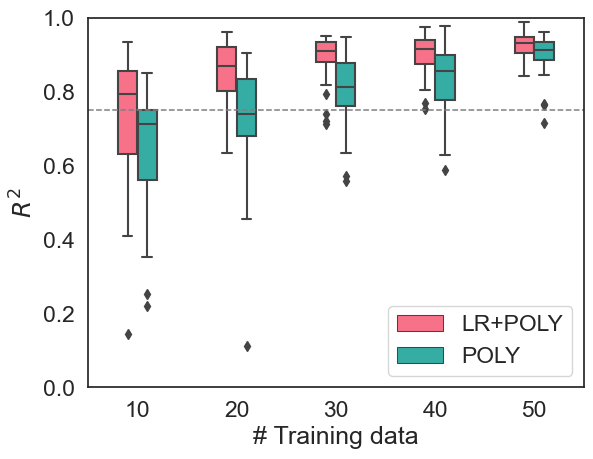

In [56]:
TFB_LR = ComparisonResultsPlot([complexSVRR2Lists_TFB_LR, SVRR2Lists_TFB_LR], 'LR', 'POLY', position = 'lower right', \
                              xname = '# Training data', yname = '$R^2$', show = 1, \
                              ylimit = [0, 1], yline = 0.75)

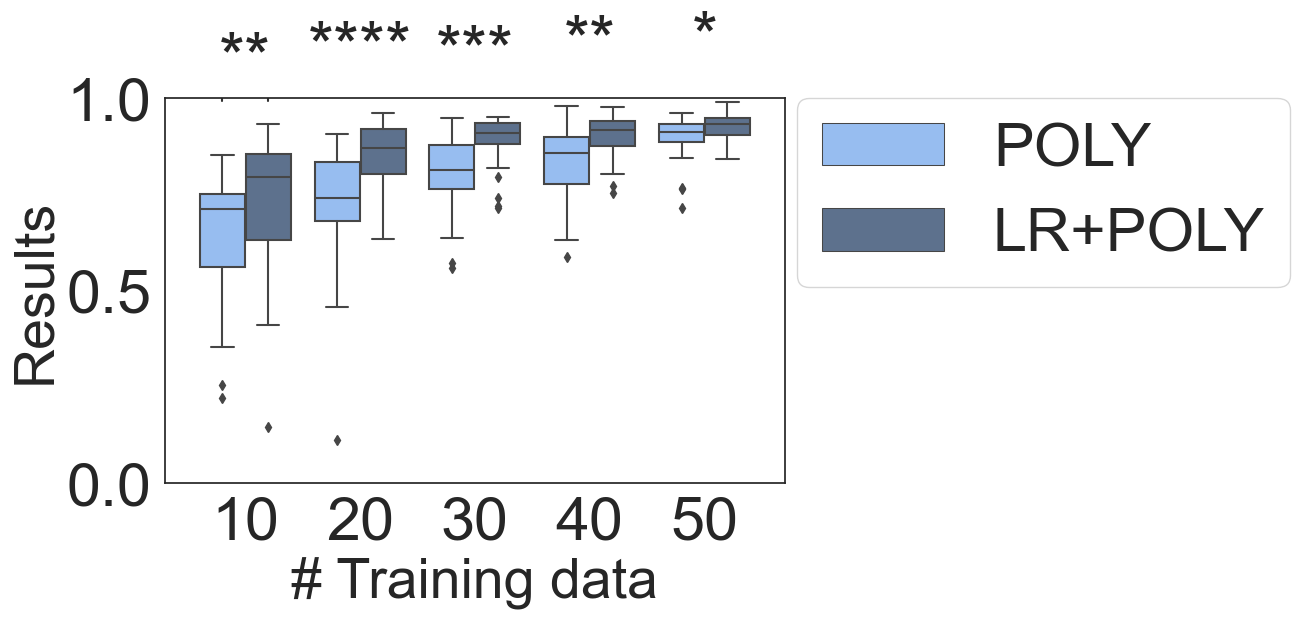

In [57]:
statsPlot(TFB_LR, 'LR', 'POLY')

In [84]:
# storeCorrelations([complexSVRSpearmanLists_TFB_LR, complexSVRPearsonLists_TFB_LR,\
#                    complexSVRR2Lists_TFB_LR, complexSVRMSELists_TFB_LR], 'SF3_TFB_LR_Corr.xlsx')

# storeCorrelations([SVRSpearmanLists_TFB_LR, SVRPearsonLists_TFB_LR,\
#                    SVRR2Lists_TFB_LR, SVRMSELists_TFB_LR], 'SF3_TFB_Corr.xlsx')

# storeRawData([complexPredictedSVRSpearmanLists_TFB_LR, complexPredictedSVRPearsonLists_TFB_LR,\
#              complexPredictedSVRR2Lists_TFB_LR, complexPredictedSVRMSELists_TFB_LR], \
#              'SF3_TFB_LR_Raw.xlsx')

# storeRawData([PredictedSVRSpearmanLists_TFB_LR, PredictedSVRPearsonLists_TFB_LR,\
#              PredictedSVRR2Lists_TFB_LR, PredictedSVRMSELists_TFB_LR], 'SF3_TFB_Raw.xlsx')

# storeWeight([r2Recorder_TFB_LR, mseRecorder_TFB_LR, \
#              pearsonRecorder_TFB_LR, spearmanRecorder_TFB_LR],\
#             'SF3_TFB_LR_Weight.xlsx')

# storeSVCSVRModel([r2Recorder_TFB_LR, mseRecorder_TFB_LR, \
#                   pearsonRecorder_TFB_LR, spearmanRecorder_TFB_LR],\
#                  'SF3_TFB_LR')
# storeSVRModel([SVRr2Recorder_TFB_LR, SVRmseRecorder_TFB_LR, \
#                SVRpearsonRecorder_TFB_LR, SVRspearmanRecorder_TFB_LR],\
#               'SF3_TFB_LR')
# storeScalerModel([scXRecorder_TFB_LR, scDensityRecorder_TFB_LR, \
#                   scDistanceRecorder_TFB_LR], 'SF3_TFB_LR')

# storeIndex(indexRecorder_TFB_LR, 'SF3_TFB_LR_TrainingIndices.xlsx')
# storeDataframes([TrainXDFRecorder_TFB_LR, TrainYDFRecorder_TFB_LR, \
# SVMSVRFullXDFRecorder_TFB_LR, SVMSVRFullYDFRecorder_TFB_LR], 'SF3_TFB_LR')

Finished storing correlations for:  SF3_TFB_LR_Corr.xlsx
Finished storing correlations for:  SF3_TFB_Corr.xlsx
Finished storing raw data for:  SF3_TFB_LR_Raw.xlsx
Finished storing raw data for:  SF3_TFB_Raw.xlsx
Finished storing weight for:  SF3_TFB_LR_Weight.xlsx
Finished storing classification and regression models for complex pipeline.
Finished storing regression models for simple pipeline.
Finished storing: SCX
Finished storing: SCDensity
Finished storing: SCDistance
Finished storing all.
Finished storing all training indices for:  SF3_TFB_LR_TrainingIndices.xlsx
Finished storing all dataframes for:  TrainX
Finished storing all dataframes for:  TrainY
Finished storing all dataframes for:  FullX
Finished storing all dataframes for:  FullY
Finished storing all dataframes


# + kNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
### Select best degrees
### X_train: X training dataset
### Y_train: Y training dataset
### X_test: X testing dataset
### Y_test: Y testing dataset
def knn_rand_param_selection(TrainDF_X, TrainDF_Y, kernelList): 
    #List Hyperparameters that we want to tune.
    leaf_size = list(range(1, 10))
    
    if len(TrainDF_Y) < 15:
        n_neighbors = list(range(1, 5))
    elif len(TrainDF_Y) < 25:
        n_neighbors = list(range(1, 10))
    else:
        n_neighbors = list(range(1, 30))
        
    weights = ['uniform', 'distance']
    metric = ['euclidean', 'manhattan', 'minkowski']
    p=[1,2,3,4,5]
    #Convert to dictionary
    param_rand = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, weights=weights, metric=metric, p=p)
    #Create new KNN object
    knn = KNeighborsRegressor()

    if len(TrainDF_X) > 10:
        rand = RandomizedSearchCV(knn, param_rand, refit = True, scoring='r2', n_jobs = -1) # , n_jobs = -1
    else:
        rand = RandomizedSearchCV(knn, param_rand, refit = True, scoring='r2', cv = 2, n_jobs = -1)
    
    rand.fit(TrainDF_X.values, TrainDF_Y)
    
    # print the best estimator: all kernel information & best 2 parameters & best_score_ & sanity check
#     print(rand.best_estimator_, rand.best_params_, rand.best_score_) #, grid.score(X_test, Y_test))
    
    # Return best estimator
    return rand.best_estimator_

In [ ]:
# Run SVR regression once, given training and testing sets
### For both SVCSCR & SVR
### TestY is density for both
### TrainX is 3-variable input for SVCSVR
### TrainY is density for both
### TrainSVRX is 2-variable input for SVR only\n",
def regressionSVR(trainX, trainSVRX, trainY, \
                  testX, testSVRX, testY, \
                  kernelList, Newfull_df_X, sc_density):
    # Weights to be used
    #### Make this tunable too
    weightList = [0.01, 0.1, 1, 10]
    k = 2  
    kf = KFold(n_splits=k, shuffle=True)

    r2WeightList = []
    MSEWeightList = []
    PearsonWeightList = []
    SpearmanWeightList = []
    # May not need this anymore
    r2ModelList = []
    MSEModelList = []
    PearsonModelList = []
    SpearmanModelList = []
    
    # Score for best SVR model
    SVRR2scoreTemp = -1000
    SVRMSEscoreTemp = 200
    SVRPearsonScoreTemp = -2
    SVRSpearmanScoreTemp = -2
    
    SVRbestR2Model = 0
    SVRbestMSEModel = 0
    SVRbestPearsonModel = 0
    SVRbestSpearmanModel = 0
    
#     R2scoreTemp = -1000
#     MSEscoreTemp = 200
#     PearsonScoreTemp = -2
#     SpearmanScoreTemp = -2
    bestR2Weight = 1
    bestMSEWeight = 1
    bestPearsonWeight = 1
    bestSpearmanWeight = 1
    
    bestR2Model = 0
    bestMSEModel = 0
    bestPearsonModel = 0
    bestSpearmanModel = 0
    

    for i in range(1):    
        if len(trainX) <= 10:
            weightTrainXDF = trainX.sample(frac = 0.7)
        else:
            weightTrainXDF = trainX.sample(frac = 0.8)

        weightTestXDF = trainX.drop(weightTrainXDF.index)
        train_index = weightTrainXDF.index
        test_index = weightTestXDF.index
        TrainY, TestY = trainY.loc[train_index], trainY.loc[test_index]
        TrainYArr = np.array(TrainY)
        TestYArr = np.array(TestY)
        SVRTrainXDF, SVRTestXDF = trainSVRX.loc[train_index], trainSVRX.loc[test_index]

        # Score for best model
        R2scoreTemp = -1000
        MSEscoreTemp = 200
        PearsonScoreTemp = -2
        SpearmanScoreTemp = -2
        R2modelTemp = 0
        MSEmodelTemp = 0
        PearsonmodelTemp = 0
        SpearmanmodelTemp = 0

        # Loop through distances * different weights:
        for w in weightList:
            trainXCopy = weightTrainXDF.copy()
            testXCopy = weightTestXDF.copy()
            # Transform
            trainXCopy['Quant Estimation'] = trainXCopy['Quant Estimation'].apply(lambda x: x*w)
            testXCopy['Quant Estimation'] = testXCopy['Quant Estimation'].apply(lambda x: x*w)
            # Select best parameters
            model = \
            knn_rand_param_selection(trainXCopy, TrainYArr, kernelList)
            #### Predict with the best model of the current weight
            #### On a slice of the training data
            weightY_pred = model.predict(testXCopy.values)
            predictedDensityInversedBack = sc_density.inverse_transform(weightY_pred.reshape(-1, 1))
            # Invert back testY
            testDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
            #### Select the best weight for all metrics
            # R2
            corrTestDensity = testDensityInversedBack.reshape(len(TestYArr))
            corrPredictedDensity = predictedDensityInversedBack.reshape(len(TestYArr)) 
            correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
            correlation_xy = correlation_matrix[0,1]
            R2score = correlation_xy**2
#             print('R2: ', R2score)
            if (math.isnan(R2score) == False) & (R2score > R2scoreTemp):
                R2scoreTemp = R2score
                bestR2Model = model
                bestR2Weight = w
            # MSE
            MSEscore = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
#             print('MSE: ', MSEscore)
            if (math.isnan(MSEscore) == False) & (MSEscore < MSEscoreTemp):
                MSEscoreTemp = MSEscore
                bestMSEModel = model
                bestMSEWeight = w
#                 print(MSEscoreTemp, bestMSEWeight)
            # Pearson
            PearsonScore = pearsonr(corrTestDensity, corrPredictedDensity)[0]
#             print('Pearson: ', PearsonScore)
            if (math.isnan(PearsonScore) == False) & (PearsonScore > PearsonScoreTemp):
                PearsonScoreTemp = PearsonScore
                bestPearsonModel = model
                bestPearsonWeight = w
#                 print(PearsonScoreTemp, bestPearsonWeight)
            # Spearman
            SpearmanScore = spearmanr(corrTestDensity, corrPredictedDensity)[0]
#             print('Spearman: ', SpearmanScore)
            #print(SpearmanScore)
            if (math.isnan(SpearmanScore) == False) & (SpearmanScore > SpearmanScoreTemp):
                SpearmanScoreTemp = SpearmanScore
                bestSpearmanModel = model
                bestSpearmanWeight = w

        # Record best weight now for each fold
#         r2ModelList.append(bestR2Model)
        r2WeightList.append(bestR2Weight)
#         MSEModelList.append(bestMSEModel)
        MSEWeightList.append(bestMSEWeight)
#         PearsonModelList.append(bestPearsonModel)
        PearsonWeightList.append(bestPearsonWeight)
#         SpearmanModelList.append(bestSpearmanModel)
        SpearmanWeightList.append(bestSpearmanWeight)

        #### Train SVR only now\n",
        SVRmodel = \
            knn_rand_param_selection(SVRTrainXDF, TrainYArr, kernelList)
        SVRDensity_pred = SVRmodel.predict(SVRTestXDF.values)
#             print(weightY_pred)
        SVRpredictedDensityInversedBack = sc_density.inverse_transform(SVRDensity_pred.reshape(-1, 1))
#             print(weightY_pred.reshape(-1, 1))
#             print(predictedDensityInversedBack)
        # Invert back testY
#             print(weightTestYArr)
        SVRtestDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
#             print(testDensityInversedBack)
        SVRcorrTestDensity = SVRtestDensityInversedBack.reshape(len(TestYArr))
        SVRcorrPredictedDensity = SVRpredictedDensityInversedBack.reshape(len(TestYArr))

        SVRcorrelation_matrix = np.corrcoef(SVRcorrTestDensity, SVRcorrPredictedDensity)
#             print(correlation_matrix)
        SVRcorrelation_xy = SVRcorrelation_matrix[0,1]
        SVRR2score = SVRcorrelation_xy**2

        if SVRR2score > SVRR2scoreTemp:
            SVRR2scoreTemp = SVRR2score
            SVRbestR2Model = SVRmodel
        # MSE
        SVRMSEscore = mean_squared_error(SVRcorrTestDensity, SVRcorrPredictedDensity, squared=True)
        if SVRMSEscore < SVRMSEscoreTemp:
            SVRMSEscoreTemp = SVRMSEscore
            SVRbestMSEModel = SVRmodel
        # Pearson
        SVRPearsonScore = pearsonr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        if SVRPearsonScore > SVRPearsonScoreTemp:
            SVRPearsonScoreTemp = SVRPearsonScore
            SVRbestPearsonModel = SVRmodel
        # Spearman
        SVRSpearmanScore = spearmanr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        #print(SpearmanScore)
        if SVRSpearmanScore > SVRSpearmanScoreTemp:
            SVRSpearmanScoreTemp = SVRSpearmanScore
            SVRbestSpearmanModel = SVRmodel
    
    ### SVCSVR
#     print(r2WeightList, MSEWeightList, PearsonWeightList, SpearmanWeightList)
    bestR2Weight = max(set(r2WeightList), key = r2WeightList.count)
    bestMSEWeight = max(set(MSEWeightList), key = MSEWeightList.count)
    bestPearsonWeight = max(set(PearsonWeightList), key = PearsonWeightList.count)
    bestSpearmanWeight = max(set(SpearmanWeightList), key = SpearmanWeightList.count)

    #### To predict using the best weight
    metricWeightList = [bestR2Weight, bestMSEWeight, bestPearsonWeight, bestSpearmanWeight]
#     print(metricWeightList)
#     metricModelList = [bestR2Model, bestMSEModel, bestPearsonModel, bestSpearmanModel]
    ### Record SVR models
    SVRModelList = [SVRbestR2Model, SVRbestMSEModel, SVRbestPearsonModel, SVRbestSpearmanModel]
    metricList = ['R2', 'MSE', 'Pearson', 'Spearman']
    # To record final prediction scores
    corrList = []
    predictedList = []
    SVRcorrList = []
    SVRpredictedList = []
    # Loop through the 4 metric
    for i in range(4):
        ### Reserved for final training and testing sets
        finalTrainXCopy = trainX.copy()
        finalTestXCopy = testX.copy()

        finalTrainSVRXCopy = trainSVRX.copy()
        finalTestSVRXCopy = testSVRX.copy()

        weight = metricWeightList[i]
#         finalModel = metricModelList[i]\n",
        m = metricList[i]
        # First, retrain on the full training set using the selected weight\n",
        # Transform\n",
#         print(finalTrainXCopy)\n",
        finalTrainXCopy['Quant Estimation'] = \
        finalTrainXCopy['Quant Estimation'].apply(lambda x: x*weight)

        finalModel = \
        knn_rand_param_selection(finalTrainXCopy, trainY, kernelList)
        
        # Now predict
        corr, predictedDensity = \
        finalCorrPrediction(finalTestXCopy, testY, weight, finalModel, sc_density, metric = m)
        corrList.append(corr) # Save results
        predictedList.append(predictedDensity)
        
        #### For SVR -- retrain with the best model and predict
        SVRCurrModel = SVRModelList[i]
        if SVRCurrModel != 0:
            SVRCurrModel.fit(finalTrainSVRXCopy.values, trainY)
        else: 
            SVRCurrModel = \
            knn_rand_param_selection(finalTrainSVRXCopy, trainY, kernelList)
        # Predict
        SVRcorr, SVRpredictedDensity = \
        SVROnlyfinalCorrPrediction(finalTestSVRXCopy, testY, 1, SVRCurrModel, sc_density, metric = m)
        SVRcorrList.append(SVRcorr)
        SVRpredictedList.append(SVRpredictedDensity)

    print('SVM: ', corrList) #, predictedList)
    print('SVR: ', SVRcorrList) #, SVRpredictedList)
    R2Corr, MSECorr, PearsonCorr, SpearmanCorr = corrList[0], corrList[1], corrList[2], corrList[3]
    R2Predicted, MSEPredicted, PearsonPredicted, SpearmanPredicted = \
    predictedList[0], predictedList[1], predictedList[2], predictedList[3]
    
    SVRR2Corr, SVRMSECorr, SVRPearsonCorr, SVRSpearmanCorr = \
    SVRcorrList[0], SVRcorrList[1], SVRcorrList[2], SVRcorrList[3]
    SVRR2Predicted, SVRMSEPredicted, SVRPearsonPredicted, SVRSpearmanPredicted = \
    SVRpredictedList[0], SVRpredictedList[1], SVRpredictedList[2], SVRpredictedList[3]

    return bestR2Model, bestR2Weight, R2Corr, R2Predicted, bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted
# bestModel, RegressionR2Corr, RegressionMSECorr, RegressionPearsonCorr, RegressionSpearmanCorr"


# + poly reg

In [73]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [94]:
### Select best SVM parameters of any number of kernel(s)
### TrainDF_X: X training dataset
### TrainDF_Y: Y training dataset
### kernelList: the list of kernels to try
def poly_rand_param_selection(TrainDF_X, TrainDF_Y, kernelList):
    # possible degrees
    param_rand = [{'poly__degree': [1, 2, 3,4,5,6,7,8,9]}, \
                  {'regress__alpha': np.logspace(-3,3,7)}]
    regress = Ridge()
    pipeline = Pipeline(steps=[('poly', PolynomialFeatures()), ('regress', regress)])
    
#     grid_search = GridSearchCV(pipeline, param_grid, cv=5,
#                                scoring='neg_mean_squared_error',
#                                return_train_score=True)
#     grid_search.fit(x_train.reshape(-1, 1), y_train)

    if len(TrainDF_X) > 10:
        rand = RandomizedSearchCV(pipeline, param_rand, \
                                  refit = True, scoring='r2', n_jobs = -1) # , n_jobs = -1
    else:
        rand = RandomizedSearchCV(pipeline, param_rand, \
                                  refit = True, scoring='r2', cv = 2, n_jobs = -1)
    
    rand.fit(TrainDF_X.values, TrainDF_Y)
    
    # print the best estimator: all kernel information & best 2 parameters & best_score_ & sanity check
#     print(rand.best_estimator_, rand.best_params_, rand.best_score_) #, grid.score(X_test, Y_test))
    
    # Return best estimator
    return rand.best_estimator_

In [89]:
# Run SVR regression once, given training and testing sets
### For both SVCSCR & SVR
### TestY is density for both
### TrainX is 3-variable input for SVCSVR
### TrainY is density for both
### TrainSVRX is 2-variable input for SVR only\n",
def regressionSVR(trainX, trainSVRX, trainY, \
                  testX, testSVRX, testY, \
                  kernelList, Newfull_df_X, sc_density):
    # Weights to be used
    #### Make this tunable too
    weightList = [0.01, 0.1, 1, 10]
    k = 2  
    kf = KFold(n_splits=k, shuffle=True)

    r2WeightList = []
    MSEWeightList = []
    PearsonWeightList = []
    SpearmanWeightList = []
    # May not need this anymore
    r2ModelList = []
    MSEModelList = []
    PearsonModelList = []
    SpearmanModelList = []
    
    # Score for best SVR model
    SVRR2scoreTemp = -1000
    SVRMSEscoreTemp = 200
    SVRPearsonScoreTemp = -2
    SVRSpearmanScoreTemp = -2
    
    SVRbestR2Model = 0
    SVRbestMSEModel = 0
    SVRbestPearsonModel = 0
    SVRbestSpearmanModel = 0
    
#     R2scoreTemp = -1000
#     MSEscoreTemp = 200
#     PearsonScoreTemp = -2
#     SpearmanScoreTemp = -2
    bestR2Weight = 1
    bestMSEWeight = 1
    bestPearsonWeight = 1
    bestSpearmanWeight = 1
    
    bestR2Model = 0
    bestMSEModel = 0
    bestPearsonModel = 0
    bestSpearmanModel = 0
    

    for i in range(1):    
        if len(trainX) <= 10:
            weightTrainXDF = trainX.sample(frac = 0.7)
        else:
            weightTrainXDF = trainX.sample(frac = 0.8)

        weightTestXDF = trainX.drop(weightTrainXDF.index)
        train_index = weightTrainXDF.index
        test_index = weightTestXDF.index
        TrainY, TestY = trainY.loc[train_index], trainY.loc[test_index]
        TrainYArr = np.array(TrainY)
        TestYArr = np.array(TestY)
        SVRTrainXDF, SVRTestXDF = trainSVRX.loc[train_index], trainSVRX.loc[test_index]

        # Score for best model
        R2scoreTemp = -1000
        MSEscoreTemp = 200
        PearsonScoreTemp = -2
        SpearmanScoreTemp = -2
        R2modelTemp = 0
        MSEmodelTemp = 0
        PearsonmodelTemp = 0
        SpearmanmodelTemp = 0

        # Loop through distances * different weights:
        for w in weightList:
            trainXCopy = weightTrainXDF.copy()
            testXCopy = weightTestXDF.copy()
            # Transform
            trainXCopy['Quant Estimation'] = trainXCopy['Quant Estimation'].apply(lambda x: x*w)
            testXCopy['Quant Estimation'] = testXCopy['Quant Estimation'].apply(lambda x: x*w)
            # Select best parameters
            model = \
            poly_rand_param_selection(trainXCopy, TrainYArr, kernelList)
            #### Predict with the best model of the current weight
            #### On a slice of the training data
            weightY_pred = model.predict(testXCopy.values)
            predictedDensityInversedBack = sc_density.inverse_transform(weightY_pred.reshape(-1, 1))
            # Invert back testY
            testDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
            #### Select the best weight for all metrics
            # R2
            corrTestDensity = testDensityInversedBack.reshape(len(TestYArr))
            corrPredictedDensity = predictedDensityInversedBack.reshape(len(TestYArr)) 
            correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
            correlation_xy = correlation_matrix[0,1]
            R2score = correlation_xy**2
#             print('R2: ', R2score)
            if (math.isnan(R2score) == False) & (R2score > R2scoreTemp):
                R2scoreTemp = R2score
                bestR2Model = model
                bestR2Weight = w
            # MSE
            MSEscore = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
#             print('MSE: ', MSEscore)
            if (math.isnan(MSEscore) == False) & (MSEscore < MSEscoreTemp):
                MSEscoreTemp = MSEscore
                bestMSEModel = model
                bestMSEWeight = w
#                 print(MSEscoreTemp, bestMSEWeight)
            # Pearson
            PearsonScore = pearsonr(corrTestDensity, corrPredictedDensity)[0]
#             print('Pearson: ', PearsonScore)
            if (math.isnan(PearsonScore) == False) & (PearsonScore > PearsonScoreTemp):
                PearsonScoreTemp = PearsonScore
                bestPearsonModel = model
                bestPearsonWeight = w
#                 print(PearsonScoreTemp, bestPearsonWeight)
            # Spearman
            SpearmanScore = spearmanr(corrTestDensity, corrPredictedDensity)[0]
#             print('Spearman: ', SpearmanScore)
            #print(SpearmanScore)
            if (math.isnan(SpearmanScore) == False) & (SpearmanScore > SpearmanScoreTemp):
                SpearmanScoreTemp = SpearmanScore
                bestSpearmanModel = model
                bestSpearmanWeight = w

        # Record best weight now for each fold
#         r2ModelList.append(bestR2Model)
        r2WeightList.append(bestR2Weight)
#         MSEModelList.append(bestMSEModel)
        MSEWeightList.append(bestMSEWeight)
#         PearsonModelList.append(bestPearsonModel)
        PearsonWeightList.append(bestPearsonWeight)
#         SpearmanModelList.append(bestSpearmanModel)
        SpearmanWeightList.append(bestSpearmanWeight)

        #### Train SVR only now\n",
        SVRmodel = \
            poly_rand_param_selection(SVRTrainXDF, TrainYArr, kernelList)
        SVRDensity_pred = SVRmodel.predict(SVRTestXDF.values)
#             print(weightY_pred)
        SVRpredictedDensityInversedBack = sc_density.inverse_transform(SVRDensity_pred.reshape(-1, 1))
#             print(weightY_pred.reshape(-1, 1))
#             print(predictedDensityInversedBack)
        # Invert back testY
#             print(weightTestYArr)
        SVRtestDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
#             print(testDensityInversedBack)
        SVRcorrTestDensity = SVRtestDensityInversedBack.reshape(len(TestYArr))
        SVRcorrPredictedDensity = SVRpredictedDensityInversedBack.reshape(len(TestYArr))

        SVRcorrelation_matrix = np.corrcoef(SVRcorrTestDensity, SVRcorrPredictedDensity)
#             print(correlation_matrix)
        SVRcorrelation_xy = SVRcorrelation_matrix[0,1]
        SVRR2score = SVRcorrelation_xy**2

        if SVRR2score > SVRR2scoreTemp:
            SVRR2scoreTemp = SVRR2score
            SVRbestR2Model = SVRmodel
        # MSE
        SVRMSEscore = mean_squared_error(SVRcorrTestDensity, SVRcorrPredictedDensity, squared=True)
        if SVRMSEscore < SVRMSEscoreTemp:
            SVRMSEscoreTemp = SVRMSEscore
            SVRbestMSEModel = SVRmodel
        # Pearson
        SVRPearsonScore = pearsonr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        if SVRPearsonScore > SVRPearsonScoreTemp:
            SVRPearsonScoreTemp = SVRPearsonScore
            SVRbestPearsonModel = SVRmodel
        # Spearman
        SVRSpearmanScore = spearmanr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        #print(SpearmanScore)
        if SVRSpearmanScore > SVRSpearmanScoreTemp:
            SVRSpearmanScoreTemp = SVRSpearmanScore
            SVRbestSpearmanModel = SVRmodel
    
    ### SVCSVR
#     print(r2WeightList, MSEWeightList, PearsonWeightList, SpearmanWeightList)
    bestR2Weight = max(set(r2WeightList), key = r2WeightList.count)
    bestMSEWeight = max(set(MSEWeightList), key = MSEWeightList.count)
    bestPearsonWeight = max(set(PearsonWeightList), key = PearsonWeightList.count)
    bestSpearmanWeight = max(set(SpearmanWeightList), key = SpearmanWeightList.count)

    #### To predict using the best weight
    metricWeightList = [bestR2Weight, bestMSEWeight, bestPearsonWeight, bestSpearmanWeight]
#     print(metricWeightList)
#     metricModelList = [bestR2Model, bestMSEModel, bestPearsonModel, bestSpearmanModel]
    ### Record SVR models
    SVRModelList = [SVRbestR2Model, SVRbestMSEModel, SVRbestPearsonModel, SVRbestSpearmanModel]
    metricList = ['R2', 'MSE', 'Pearson', 'Spearman']
    # To record final prediction scores
    corrList = []
    predictedList = []
    SVRcorrList = []
    SVRpredictedList = []
    # Loop through the 4 metric
    for i in range(4):
        ### Reserved for final training and testing sets
        finalTrainXCopy = trainX.copy()
        finalTestXCopy = testX.copy()

        finalTrainSVRXCopy = trainSVRX.copy()
        finalTestSVRXCopy = testSVRX.copy()

        weight = metricWeightList[i]
#         finalModel = metricModelList[i]\n",
        m = metricList[i]
        # First, retrain on the full training set using the selected weight\n",
        # Transform\n",
#         print(finalTrainXCopy)\n",
        finalTrainXCopy['Quant Estimation'] = \
        finalTrainXCopy['Quant Estimation'].apply(lambda x: x*weight)

        finalModel = \
        poly_rand_param_selection(finalTrainXCopy, trainY, kernelList)
        
        # Now predict
        corr, predictedDensity = \
        finalCorrPrediction(finalTestXCopy, testY, weight, finalModel, sc_density, metric = m)
        corrList.append(corr) # Save results
        predictedList.append(predictedDensity)
        
        #### For SVR -- retrain with the best model and predict
        SVRCurrModel = SVRModelList[i]
        if SVRCurrModel != 0:
            SVRCurrModel.fit(finalTrainSVRXCopy.values, trainY)
        else: 
            SVRCurrModel = \
            poly_rand_param_selection(finalTrainSVRXCopy, trainY, kernelList)
        # Predict
        SVRcorr, SVRpredictedDensity = \
        SVROnlyfinalCorrPrediction(finalTestSVRXCopy, testY, 1, SVRCurrModel, sc_density, metric = m)
        SVRcorrList.append(SVRcorr)
        SVRpredictedList.append(SVRpredictedDensity)

    print('SVM: ', corrList) #, predictedList)
    print('SVR: ', SVRcorrList) #, SVRpredictedList)
    R2Corr, MSECorr, PearsonCorr, SpearmanCorr = corrList[0], corrList[1], corrList[2], corrList[3]
    R2Predicted, MSEPredicted, PearsonPredicted, SpearmanPredicted = \
    predictedList[0], predictedList[1], predictedList[2], predictedList[3]
    
    SVRR2Corr, SVRMSECorr, SVRPearsonCorr, SVRSpearmanCorr = \
    SVRcorrList[0], SVRcorrList[1], SVRcorrList[2], SVRcorrList[3]
    SVRR2Predicted, SVRMSEPredicted, SVRPearsonPredicted, SVRSpearmanPredicted = \
    SVRpredictedList[0], SVRpredictedList[1], SVRpredictedList[2], SVRpredictedList[3]

    return bestR2Model, bestR2Weight, R2Corr, R2Predicted, bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted
# bestModel, RegressionR2Corr, RegressionMSECorr, RegressionPearsonCorr, RegressionSpearmanCorr"


# + SVR

In [63]:
### Select best SVR parameters of any number of kernel(s)
### X_train: X training dataset
### Y_train: Y training dataset
### X_test: X testing dataset
### Y_test: Y testing dataset
##### Make epsilon tunable
def svr_rand_param_selection(X_train, Y_train, kernelList):
    # 3 universal parameters
    Cs = list(10. ** np.arange(-2, 4))
    gammas = list(10. ** np.arange(-4, 2))
    coef0s = list(10. ** np.arange(-3, 3))
    # Create grid parameters to tune: include 2 universal parameters & other parameters
    param_grid = {'C': Cs, 'gamma': gammas + ['scale', 'auto'], \
                  'degree':[1,2,3,4,5], 'kernel': ['poly', 'linear', 'rbf'], 'coef0': coef0s, \
                  'epsilon':list(10. ** np.arange(-4, 1))} ### 'poly', 'rbf', 'coef0': coef0s, 'rbf', 'sigmoid', 
    # rand Search
    ##### Make epsilon tunable
    if len(X_train) >= 10:
        grid = RandomizedSearchCV(SVR(), param_grid, refit = True, n_jobs = -2) #
    elif len(X_train) == 2:
        grid = RandomizedSearchCV(SVR(), param_grid, refit = True, cv = 1, n_jobs = -2)
    else:
        grid = RandomizedSearchCV(SVR(), param_grid, refit = True, cv = 2, n_jobs = -2)
        
    #print(X_train)
    grid.fit(X_train.values, Y_train)
    # print the best estimator: all kernel information & best 2 parameters & best_score_ & sanity check
#     print(grid.best_estimator_)#, rand.best_estimator_, rand.best_params_, rand.best_score_, rand.score(X_test, Y_test))\n",
    # Return best estimator
    return grid.best_estimator_

# , grid.best_estimator_.C, grid.best_estimator_.gamma, \
# grid.best_estimator_.degree, grid.best_estimator_.kernel, grid.best_estimator_.coef0


In [42]:
# Run SVR regression once, given training and testing sets
### For both SVCSCR & SVR
### TestY is density for both
### TrainX is 3-variable input for SVCSVR
### TrainY is density for both
### TrainSVRX is 2-variable input for SVR only\n",
def regressionSVR(trainX, trainSVRX, trainY, \
                  testX, testSVRX, testY, \
                  kernelList, Newfull_df_X, sc_density):
    # Weights to be used
    #### Make this tunable too
    weightList = [0.01, 0.1, 1, 10]
    k = 2  
    kf = KFold(n_splits=k, shuffle=True)

    r2WeightList = []
    MSEWeightList = []
    PearsonWeightList = []
    SpearmanWeightList = []
    # May not need this anymore
    r2ModelList = []
    MSEModelList = []
    PearsonModelList = []
    SpearmanModelList = []
    
    # Score for best SVR model
    SVRR2scoreTemp = -1000
    SVRMSEscoreTemp = 200
    SVRPearsonScoreTemp = -2
    SVRSpearmanScoreTemp = -2
    
    SVRbestR2Model = 0
    SVRbestMSEModel = 0
    SVRbestPearsonModel = 0
    SVRbestSpearmanModel = 0
    
#     R2scoreTemp = -1000
#     MSEscoreTemp = 200
#     PearsonScoreTemp = -2
#     SpearmanScoreTemp = -2
    bestR2Weight = 1
    bestMSEWeight = 1
    bestPearsonWeight = 1
    bestSpearmanWeight = 1
    
    bestR2Model = 0
    bestMSEModel = 0
    bestPearsonModel = 0
    bestSpearmanModel = 0
    

    for i in range(1):    
        if len(trainX) <= 10:
            weightTrainXDF = trainX.sample(frac = 0.7)
        else:
            weightTrainXDF = trainX.sample(frac = 0.8)

        weightTestXDF = trainX.drop(weightTrainXDF.index)
        train_index = weightTrainXDF.index
        test_index = weightTestXDF.index
        TrainY, TestY = trainY.loc[train_index], trainY.loc[test_index]
        TrainYArr = np.array(TrainY)
        TestYArr = np.array(TestY)
        SVRTrainXDF, SVRTestXDF = trainSVRX.loc[train_index], trainSVRX.loc[test_index]

        # Score for best model
        R2scoreTemp = -1000
        MSEscoreTemp = 200
        PearsonScoreTemp = -2
        SpearmanScoreTemp = -2
        R2modelTemp = 0
        MSEmodelTemp = 0
        PearsonmodelTemp = 0
        SpearmanmodelTemp = 0

        # Loop through distances * different weights:
        for w in weightList:
            trainXCopy = weightTrainXDF.copy()
            testXCopy = weightTestXDF.copy()
            # Transform
            trainXCopy['Quant Estimation'] = trainXCopy['Quant Estimation'].apply(lambda x: x*w)
            testXCopy['Quant Estimation'] = testXCopy['Quant Estimation'].apply(lambda x: x*w)
            # Select best parameters
            model = \
            svr_rand_param_selection(trainXCopy, TrainYArr, kernelList)
            #### Predict with the best model of the current weight
            #### On a slice of the training data
            weightY_pred = model.predict(testXCopy.values)
            predictedDensityInversedBack = sc_density.inverse_transform(weightY_pred.reshape(-1, 1))
            # Invert back testY
            testDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
            #### Select the best weight for all metrics
            # R2
            corrTestDensity = testDensityInversedBack.reshape(len(TestYArr))
            corrPredictedDensity = predictedDensityInversedBack.reshape(len(TestYArr)) 
            correlation_matrix = np.corrcoef(corrTestDensity, corrPredictedDensity)
            correlation_xy = correlation_matrix[0,1]
            R2score = correlation_xy**2
#             print('R2: ', R2score)
            if (math.isnan(R2score) == False) & (R2score > R2scoreTemp):
                R2scoreTemp = R2score
                bestR2Model = model
                bestR2Weight = w
            # MSE
            MSEscore = mean_squared_error(corrTestDensity, corrPredictedDensity, squared=True)
#             print('MSE: ', MSEscore)
            if (math.isnan(MSEscore) == False) & (MSEscore < MSEscoreTemp):
                MSEscoreTemp = MSEscore
                bestMSEModel = model
                bestMSEWeight = w
#                 print(MSEscoreTemp, bestMSEWeight)
            # Pearson
            PearsonScore = pearsonr(corrTestDensity, corrPredictedDensity)[0]
#             print('Pearson: ', PearsonScore)
            if (math.isnan(PearsonScore) == False) & (PearsonScore > PearsonScoreTemp):
                PearsonScoreTemp = PearsonScore
                bestPearsonModel = model
                bestPearsonWeight = w
#                 print(PearsonScoreTemp, bestPearsonWeight)
            # Spearman
            SpearmanScore = spearmanr(corrTestDensity, corrPredictedDensity)[0]
#             print('Spearman: ', SpearmanScore)
            #print(SpearmanScore)
            if (math.isnan(SpearmanScore) == False) & (SpearmanScore > SpearmanScoreTemp):
                SpearmanScoreTemp = SpearmanScore
                bestSpearmanModel = model
                bestSpearmanWeight = w

        # Record best weight now for each fold
#         r2ModelList.append(bestR2Model)
        r2WeightList.append(bestR2Weight)
#         MSEModelList.append(bestMSEModel)
        MSEWeightList.append(bestMSEWeight)
#         PearsonModelList.append(bestPearsonModel)
        PearsonWeightList.append(bestPearsonWeight)
#         SpearmanModelList.append(bestSpearmanModel)
        SpearmanWeightList.append(bestSpearmanWeight)

        #### Train SVR only now\n",
        SVRmodel = \
            svr_rand_param_selection(SVRTrainXDF, TrainYArr, kernelList)
        SVRDensity_pred = SVRmodel.predict(SVRTestXDF.values)
#             print(weightY_pred)
        SVRpredictedDensityInversedBack = sc_density.inverse_transform(SVRDensity_pred.reshape(-1, 1))
#             print(weightY_pred.reshape(-1, 1))
#             print(predictedDensityInversedBack)
        # Invert back testY
#             print(weightTestYArr)
        SVRtestDensityInversedBack = sc_density.inverse_transform(TestYArr.reshape(-1, 1))
#             print(testDensityInversedBack)
        SVRcorrTestDensity = SVRtestDensityInversedBack.reshape(len(TestYArr))
        SVRcorrPredictedDensity = SVRpredictedDensityInversedBack.reshape(len(TestYArr))

        SVRcorrelation_matrix = np.corrcoef(SVRcorrTestDensity, SVRcorrPredictedDensity)
#             print(correlation_matrix)
        SVRcorrelation_xy = SVRcorrelation_matrix[0,1]
        SVRR2score = SVRcorrelation_xy**2

        if SVRR2score > SVRR2scoreTemp:
            SVRR2scoreTemp = SVRR2score
            SVRbestR2Model = SVRmodel
        # MSE
        SVRMSEscore = mean_squared_error(SVRcorrTestDensity, SVRcorrPredictedDensity, squared=True)
        if SVRMSEscore < SVRMSEscoreTemp:
            SVRMSEscoreTemp = SVRMSEscore
            SVRbestMSEModel = SVRmodel
        # Pearson
        SVRPearsonScore = pearsonr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        if SVRPearsonScore > SVRPearsonScoreTemp:
            SVRPearsonScoreTemp = SVRPearsonScore
            SVRbestPearsonModel = SVRmodel
        # Spearman
        SVRSpearmanScore = spearmanr(SVRcorrTestDensity, SVRcorrPredictedDensity)[0]
        #print(SpearmanScore)
        if SVRSpearmanScore > SVRSpearmanScoreTemp:
            SVRSpearmanScoreTemp = SVRSpearmanScore
            SVRbestSpearmanModel = SVRmodel
    
    ### SVCSVR
#     print(r2WeightList, MSEWeightList, PearsonWeightList, SpearmanWeightList)
    bestR2Weight = max(set(r2WeightList), key = r2WeightList.count)
    bestMSEWeight = max(set(MSEWeightList), key = MSEWeightList.count)
    bestPearsonWeight = max(set(PearsonWeightList), key = PearsonWeightList.count)
    bestSpearmanWeight = max(set(SpearmanWeightList), key = SpearmanWeightList.count)

    #### To predict using the best weight
    metricWeightList = [bestR2Weight, bestMSEWeight, bestPearsonWeight, bestSpearmanWeight]
#     print(metricWeightList)
#     metricModelList = [bestR2Model, bestMSEModel, bestPearsonModel, bestSpearmanModel]
    ### Record SVR models
    SVRModelList = [SVRbestR2Model, SVRbestMSEModel, SVRbestPearsonModel, SVRbestSpearmanModel]
    metricList = ['R2', 'MSE', 'Pearson', 'Spearman']
    # To record final prediction scores
    corrList = []
    predictedList = []
    SVRcorrList = []
    SVRpredictedList = []
    # Loop through the 4 metric
    for i in range(4):
        ### Reserved for final training and testing sets
        finalTrainXCopy = trainX.copy()
        finalTestXCopy = testX.copy()

        finalTrainSVRXCopy = trainSVRX.copy()
        finalTestSVRXCopy = testSVRX.copy()

        weight = metricWeightList[i]
#         finalModel = metricModelList[i]\n",
        m = metricList[i]
        # First, retrain on the full training set using the selected weight\n",
        # Transform\n",
#         print(finalTrainXCopy)\n",
        finalTrainXCopy['Quant Estimation'] = \
        finalTrainXCopy['Quant Estimation'].apply(lambda x: x*weight)

        finalModel = \
        svr_rand_param_selection(finalTrainXCopy, trainY, kernelList)
        
        # Now predict
        corr, predictedDensity = \
        finalCorrPrediction(finalTestXCopy, testY, weight, finalModel, sc_density, metric = m)
        corrList.append(corr) # Save results
        predictedList.append(predictedDensity)
        
        #### For SVR -- retrain with the best model and predict
        SVRCurrModel = SVRModelList[i]
        if SVRCurrModel != 0:
            SVRCurrModel.fit(finalTrainSVRXCopy.values, trainY)
        else: 
            SVRCurrModel = \
            svr_rand_param_selection(finalTrainSVRXCopy, trainY, kernelList)
        # Predict
        SVRcorr, SVRpredictedDensity = \
        SVROnlyfinalCorrPrediction(finalTestSVRXCopy, testY, 1, SVRCurrModel, sc_density, metric = m)
        SVRcorrList.append(SVRcorr)
        SVRpredictedList.append(SVRpredictedDensity)

    print('SVM: ', corrList) #, predictedList)
    print('SVR: ', SVRcorrList) #, SVRpredictedList)
    R2Corr, MSECorr, PearsonCorr, SpearmanCorr = corrList[0], corrList[1], corrList[2], corrList[3]
    R2Predicted, MSEPredicted, PearsonPredicted, SpearmanPredicted = \
    predictedList[0], predictedList[1], predictedList[2], predictedList[3]
    
    SVRR2Corr, SVRMSECorr, SVRPearsonCorr, SVRSpearmanCorr = \
    SVRcorrList[0], SVRcorrList[1], SVRcorrList[2], SVRcorrList[3]
    SVRR2Predicted, SVRMSEPredicted, SVRPearsonPredicted, SVRSpearmanPredicted = \
    SVRpredictedList[0], SVRpredictedList[1], SVRpredictedList[2], SVRpredictedList[3]

    return bestR2Model, bestR2Weight, R2Corr, R2Predicted, bestMSEModel, bestMSEWeight, MSECorr, MSEPredicted,\
bestPearsonModel, bestPearsonWeight, PearsonCorr, PearsonPredicted,\
bestSpearmanModel, bestSpearmanWeight, SpearmanCorr, SpearmanPredicted,\
SVRbestR2Model, SVRR2Corr, SVRR2Predicted, SVRbestMSEModel, SVRMSECorr, SVRMSEPredicted, \
SVRbestPearsonModel, SVRPearsonCorr, SVRPearsonPredicted, SVRbestSpearmanModel, SVRSpearmanCorr, SVRSpearmanPredicted
# bestModel, RegressionR2Corr, RegressionMSECorr, RegressionPearsonCorr, RegressionSpearmanCorr"
